In [1]:
%load_ext autoreload
%autoreload 2

from typing import Literal, Union
from pathlib import Path
import csv
from datetime import datetime
import random


import pandas as pd
import dspy
from dspy.evaluate import Evaluate
from dspy.teleprompt import MIPROv2
from sklearn.model_selection import train_test_split

from programs import WrapperSpanishSPT, evaluate_answer
from custom_evaluation import custom_evaluate

In [2]:
lm = dspy.LM(
    "ollama_chat/deepseek-r1:70b",
    api_base="http://localhost:11434",
)
dspy.settings.configure(lm=lm)

In [3]:
lm("What is your name")

["\n\nGreetings! I'm DeepSeek-R1, an artificial intelligence assistant created by DeepSeek. I'm at your service and would be delighted to assist you with any inquiries or tasks you may have."]

In [4]:
data = pd.read_csv("dev_dwug_es.csv")
display(data.shape)

(8704, 8)

In [5]:
training_set = []

for _, row in data.iterrows():
    training_set.append(
        dspy.Example(
            sentence1=row["context_x"],
            sentence2=row["context_y"],
            target_word=row["lemma"],
            answer=int(row["judgment"]),
        ).with_inputs("sentence1", "sentence2", "target_word")
    )

In [6]:
classes_1_es = [item for item in training_set if item.answer == 1]
classes_2_es = [item for item in training_set if item.answer == 2]
classes_3_es = [item for item in training_set if item.answer == 3]
classes_4_es = [item for item in training_set if item.answer == 4]

print(len(classes_1_es))
print(len(classes_2_es))
print(len(classes_3_es))
print(len(classes_4_es))

classes_1_train, classes_1_dev = train_test_split(
    classes_1_es,
    test_size=0.2,
    random_state=42,
)

classes_1_train, classes_1_test = train_test_split(
    classes_1_train, test_size=0.2, random_state=42
)


classes_2_train, classes_2_dev = train_test_split(
    classes_2_es,
    test_size=0.2,
    random_state=42,
)
classes_2_train, classes_2_test = train_test_split(
    classes_2_train, test_size=0.2, random_state=42
)


classes_3_train, classes_3_dev = train_test_split(
    classes_3_es,
    test_size=0.2,
    random_state=42,
)
classes_3_train, classes_3_test = train_test_split(
    classes_3_train, test_size=0.2, random_state=42
)


classes_4_train, classes_4_dev = train_test_split(
    classes_4_es,
    test_size=0.2,
    random_state=42,
)
classes_4_train, classes_4_test = train_test_split(
    classes_4_train,
    test_size=0.2,
    random_state=42,
)

print(len(classes_1_train), len(classes_1_dev), len(classes_1_test))
print(len(classes_2_train), len(classes_2_dev), len(classes_2_test))
print(len(classes_3_train), len(classes_3_dev), len(classes_3_test))
print(len(classes_4_train), len(classes_4_dev), len(classes_4_test))

1406
1522
2343
3433
899 282 225
973 305 244
1499 469 375
2196 687 550


In [7]:
program_spt_prompt_es_assertions = WrapperSpanishSPT().activate_assertions()

In [8]:
custom_evaluate(
    random.choices(classes_1_test, k=225)
    + random.choices(classes_2_test, k=225)
    + random.choices(classes_3_test, k=225)
    + random.choices(classes_4_test, k=225),
    evaluate_answer,
    program_spt_prompt_es_assertions,
    debug=False,
)

Evaluating: 900 examples


Accurate examples: 370
Bad-formatted examples: 1
Accuracy: 41.15684093437152


In [9]:
%reload_ext autoreload

start_time = datetime.now()

teleprompter = MIPROv2(
    metric=evaluate_answer,
    task_model=lm,
    num_candidates=10,
    init_temperature=0.7,
    max_bootstrapped_demos=3,
    max_labeled_demos=4,
    verbose=False,
)

print("Optimizing program with MIPRO...")
optimized_program = teleprompter.compile(
    program_spt_prompt_es_assertions.deepcopy(),
    trainset=random.choices(classes_1_train, k=500)
    + random.choices(classes_2_train, k=500)
    + random.choices(classes_3_train, k=500)
    + random.choices(classes_4_train, k=500),
    valset=random.choices(classes_1_dev, k=200)
    + random.choices(classes_2_dev, k=200)
    + random.choices(classes_3_dev, k=200)
    + random.choices(classes_4_dev, k=200),
    num_trials=15,
    minibatch_size=25,
    minibatch_full_eval_steps=10,
    minibatch=True,
    requires_permission_to_run=False,
)

optimized_program.save(f"compile-models/sp/es_spt_mipro_optimized_prompt_es_deepseek-70b-q4")

print(f"Elapsed time: {datetime.now() - start_time}")

2025/05/08 02:41:56 INFO dspy.teleprompt.mipro_optimizer_v2: 
==> STEP 1: BOOTSTRAP FEWSHOT EXAMPLES <==


2025/05/08 02:41:56 INFO dspy.teleprompt.mipro_optimizer_v2: These will be used as few-shot example candidates for our program and for creating instructions.



2025/05/08 02:41:56 INFO dspy.teleprompt.mipro_optimizer_v2: Bootstrapping N=10 sets of demonstrations...


Optimizing program with MIPRO...
Bootstrapping set 1/10
Bootstrapping set 2/10
Bootstrapping set 3/10


  0%|                                                                                                                | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                                    | 1/2000 [02:17<76:08:47, 137.13s/it]

  0%|                                                                                                    | 2/2000 [03:46<60:34:03, 109.13s/it]

  0%|▏                                                                                                   | 3/2000 [05:49<63:58:10, 115.32s/it]

  0%|▏                                                                                                   | 4/2000 [07:49<65:05:36, 117.40s/it]

  0%|▎                                                                                                   | 5/2000 [09:45<64:42:16, 116.76s/it]

  0%|▎                                                                                                   | 6/2000 [11:17<59:55:09, 108.18s/it]

  0%|▎                                                                                                   | 7/2000 [12:53<57:45:10, 104.32s/it]

  0%|▍                                                                                                   | 8/2000 [14:36<57:34:41, 104.06s/it]

  0%|▍                                                                                                   | 9/2000 [16:10<55:40:23, 100.66s/it]

  0%|▍                                                                                                  | 10/2000 [18:31<62:36:21, 113.26s/it]

  1%|▌                                                                                                  | 11/2000 [20:22<62:05:22, 112.38s/it]

  1%|▌                                                                                                  | 12/2000 [22:40<66:23:44, 120.23s/it]

  1%|▋                                                                                                  | 13/2000 [25:55<78:53:20, 142.93s/it]

  1%|▋                                                                                                  | 14/2000 [28:10<77:31:59, 140.54s/it]

  1%|▋                                                                                                  | 15/2000 [30:30<77:28:12, 140.50s/it]

  1%|▊                                                                                                  | 16/2000 [31:52<67:37:51, 122.72s/it]

  1%|▊                                                                                                  | 17/2000 [33:24<62:33:55, 113.58s/it]

  1%|▉                                                                                                  | 18/2000 [34:55<58:46:20, 106.75s/it]

  1%|▉                                                                                                   | 19/2000 [36:15<54:17:27, 98.66s/it]

  1%|▉                                                                                                  | 20/2000 [39:00<65:20:53, 118.81s/it]

  1%|█                                                                                                  | 21/2000 [41:43<72:36:19, 132.08s/it]

  1%|█                                                                                                  | 22/2000 [43:36<69:17:54, 126.12s/it]

  1%|█▏                                                                                                 | 23/2000 [45:17<65:13:45, 118.78s/it]

  1%|█▏                                                                                                 | 24/2000 [46:51<60:59:25, 111.12s/it]

  1%|█▏                                                                                                 | 25/2000 [48:33<59:31:18, 108.50s/it]

  1%|█▎                                                                                                 | 26/2000 [50:21<59:27:46, 108.44s/it]

  1%|█▎                                                                                                 | 27/2000 [52:10<59:32:35, 108.64s/it]

  1%|█▍                                                                                                 | 28/2000 [53:35<55:31:27, 101.36s/it]

  1%|█▍                                                                                                 | 29/2000 [56:28<67:18:17, 122.93s/it]

  2%|█▍                                                                                                 | 30/2000 [58:07<63:15:22, 115.60s/it]

  2%|█▍                                                                                                 | 30/2000 [58:07<63:36:22, 116.23s/it]

Bootstrapped 3 full traces after 30 examples for up to 1 rounds, amounting to 30 attempts.
Bootstrapping set 4/10


  0%|                                                                                                                | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                                     | 1/2000 [01:12<40:09:53, 72.33s/it]

  0%|                                                                                                     | 2/2000 [02:30<42:02:36, 75.75s/it]

  0%|                                                                                                     | 2/2000 [02:30<41:45:32, 75.24s/it]

Bootstrapped 1 full traces after 2 examples for up to 1 rounds, amounting to 2 attempts.
Bootstrapping set 5/10


  0%|                                                                                                                | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                                     | 1/2000 [01:32<51:09:14, 92.12s/it]

  0%|                                                                                                   | 2/2000 [05:38<101:26:40, 182.78s/it]

  0%|                                                                                                    | 2/2000 [05:38<93:53:51, 169.18s/it]

Bootstrapped 1 full traces after 2 examples for up to 1 rounds, amounting to 2 attempts.
Bootstrapping set 6/10


  0%|                                                                                                                | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                                    | 1/2000 [01:44<58:14:04, 104.87s/it]

  0%|                                                                                                    | 2/2000 [03:45<63:20:52, 114.14s/it]

  0%|▏                                                                                                   | 3/2000 [06:13<71:57:55, 129.73s/it]

  0%|▏                                                                                                   | 4/2000 [08:00<66:48:34, 120.50s/it]

  0%|▏                                                                                                   | 4/2000 [08:00<66:33:05, 120.03s/it]

Bootstrapped 2 full traces after 4 examples for up to 1 rounds, amounting to 4 attempts.
Bootstrapping set 7/10


  0%|                                                                                                                | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                                    | 1/2000 [02:05<69:35:24, 125.32s/it]

  0%|                                                                                                    | 2/2000 [04:37<78:26:13, 141.33s/it]

  0%|▏                                                                                                   | 3/2000 [06:32<71:41:33, 129.24s/it]

  0%|▏                                                                                                   | 4/2000 [09:51<86:47:16, 156.53s/it]

  0%|▎                                                                                                   | 5/2000 [11:18<72:54:17, 131.56s/it]

  0%|▎                                                                                                   | 6/2000 [13:08<68:49:40, 124.26s/it]

  0%|▎                                                                                                   | 7/2000 [14:25<60:10:32, 108.70s/it]

  0%|▍                                                                                                    | 8/2000 [15:34<53:10:36, 96.10s/it]

  0%|▍                                                                                                   | 9/2000 [18:09<63:17:56, 114.45s/it]

  0%|▍                                                                                                   | 9/2000 [18:09<66:55:21, 121.01s/it]

Bootstrapped 3 full traces after 9 examples for up to 1 rounds, amounting to 9 attempts.
Bootstrapping set 8/10


  0%|                                                                                                                | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                                    | 1/2000 [01:56<64:40:56, 116.49s/it]

  0%|                                                                                                    | 1/2000 [01:56<64:40:58, 116.49s/it]

Bootstrapped 1 full traces after 1 examples for up to 1 rounds, amounting to 1 attempts.
Bootstrapping set 9/10


  0%|                                                                                                                | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                                     | 1/2000 [00:49<27:29:59, 49.52s/it]

  0%|                                                                                                     | 2/2000 [02:58<53:22:29, 96.17s/it]

  0%|▏                                                                                                    | 3/2000 [04:33<52:58:54, 95.51s/it]

  0%|▏                                                                                                    | 4/2000 [06:07<52:47:50, 95.23s/it]

  0%|▏                                                                                                    | 4/2000 [06:07<50:59:23, 91.97s/it]

Bootstrapped 3 full traces after 4 examples for up to 1 rounds, amounting to 4 attempts.
Bootstrapping set 10/10


  0%|                                                                                                                | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                                    | 1/2000 [02:28<82:25:55, 148.45s/it]

  0%|                                                                                                    | 2/2000 [05:25<91:35:29, 165.03s/it]

  0%|▏                                                                                                   | 3/2000 [07:08<75:57:32, 136.93s/it]

  0%|▏                                                                                                   | 3/2000 [07:08<79:14:52, 142.86s/it]


2025/05/08 04:29:35 INFO dspy.teleprompt.mipro_optimizer_v2: 
==> STEP 2: PROPOSE INSTRUCTION CANDIDATES <==


2025/05/08 04:29:35 INFO dspy.teleprompt.mipro_optimizer_v2: We will use the few-shot examples from the previous step, a generated dataset summary, a summary of the program code, and a randomly selected prompting tip to propose instructions.


Bootstrapped 1 full traces after 3 examples for up to 1 rounds, amounting to 3 attempts.


2025/05/08 04:47:10 INFO dspy.teleprompt.mipro_optimizer_v2: 
Proposing instructions...



2025/05/08 05:41:33 INFO dspy.teleprompt.mipro_optimizer_v2: Proposed Instructions for Predictor 0:



2025/05/08 05:41:33 INFO dspy.teleprompt.mipro_optimizer_v2: 0: Eres una herramienta de anotación de datos textuales altamente entrenada, capaz de proporcionar respuestas
subjetivas. Evalúa la similitud semántica de la palabra objetivo en estas oraciones 1 y 2. Considera solo los objetos/conceptos
a los que se refieren las palabras: ¡Ignora cualquier etimología común y similitud metafórica! ¡Ignora mayúsculas!
¡Ignora número (gato/Gatos = significado idéntico)! Los homónimos (como murciélago el animal vs murciélago en béisbol)
se consideran no relacionados. De como salida una calificación numérica: 1 es no relacionado; 2 es lejanamente relacionado; 3 es
estrechamente relacionado; 4 es significado idéntico. Tu respuesta debe alinearse con el juicio sucinto de un humano.



2025/05/08 05:41:33 INFO dspy.teleprompt.mipro_optimizer_v2: 1: Eres un lingüista experto en semántica, especializado en el análisis de significados en contextos diferentes. Tu tarea es evaluar la similitud semántica entre el significado de una palabra objetivo en dos oraciones dadas. Debes considerar exclusivamente los objetos o conceptos a los que se refiere la palabra, ignorando cualquier aspecto etimológico, metafórico, de género, número o homonimias (por ejemplo, "murciélago" como animal vs. "murciélago" en béisbol). Proporciona una calificación numérica del 1 al 4:  
1 = No relacionado, 2 = Relacionado de manera distante, 3 = Relacionado estrechamente, 4 = Significado idéntico.  
Tu juicio debe ser claro y conciso, como el de un experto en semántica.



2025/05/08 05:41:33 INFO dspy.teleprompt.mipro_optimizer_v2: 2: Eres una herramienta de anotación de datos textuales altamente entrenada, capaz de proporcionar respuestas subjetivas. Evalúa la similitud semántica de la palabra objetivo en estas oraciones 1 y 2. Considera solo los objetos/conceptos a los que se refieren las palabras: ¡Ignora cualquier etimología común y similitud metafórica! ¡Ignora mayúsculas! ¡Ignora número (gato/Gatos = significado idéntico)! Los homónimos (como murciélago el animal vs murciélago en béisbol) se consider



2025/05/08 05:41:33 INFO dspy.teleprompt.mipro_optimizer_v2: 3: Eres una herramienta de anotación de datos textuales altamente entrenada, capaz de proporcionar respuestas subjetivas. Tu tarea es evaluar la similitud semántica de la palabra objetivo ("corredor") en dos contextos diferentes (Oración 1 y Oración 2). Considera solo los objetos o conceptos a los que se refiere la palabra en cada oración, ignorando cualquier etimología común, similitudes metafóricas, diferencias de número (singular/plural) y homónimos. Asigna una calificación numérica del 1 al 4: 
- 1: No relacionado.
- 2: Lejanamente relacionado.
- 3: Estrechamente relacionado.
- 4: Significado idéntico.

Para esta tarea específica:
- Oración 1: "corredor" se refiere a un atleta que corre, específicamente un corredor de velocidad.
- Oración 2: "corredor" se refiere a casas con corredores (pasillos).

Debes emitir un juicio sucinto y justo, alineado con la comprensión humana común.



2025/05/08 05:41:33 INFO dspy.teleprompt.mipro_optimizer_v2: 4: You are a highly trained textual data annotator capable of providing subjective responses. Evaluate the semantic similarity of the target word in sentences 1 and 2. Consider only the objects/concepts the words refer to: Ignore any common etymology and metaphorical similarities! Ignore capitalization! Ignore number (cat/cats = identical meaning)! Homonyms (such as bat the animal vs bat in baseball) are considered unrelated. Provide a numerical rating: 1 for unrelated; 2 for distantly related; 3 for closely related; 4 for identical meaning. Your response should align with the succinct judgment of a human.



2025/05/08 05:41:33 INFO dspy.teleprompt.mipro_optimizer_v2: 5: You are a highly trained textual data annotation tool capable of providing subjective responses. Evaluate the semantic similarity of the target word in these two sentences. Consider only the objects/concepts referred to by the words: IGNORE any common etymology and metaphorical similarities! IGNORE capitalization! IGNORE number (cat/cats = identical meaning)! Homonyms (such as bat the animal vs bat in baseball) are considered unrelated. Provide a numerical rating: 1 is unrelated; 2 is remotely related; 3 is closely related; 4 is identical in meaning. Your response should align with the succinct judgment of a human.



2025/05/08 05:41:33 INFO dspy.teleprompt.mipro_optimizer_v2: 6: Evaluate la similitud semántica de la palabra objetivo en estas dos oraciones. Considera solo los objetos o conceptos a los que se refiere la palabra, ignorando etimología, metáforas, mayúsculas y diferencias de número. Homónimos se consideran no relacionados a menos que compartan el mismo significado. Califica con: 1 (no relacionado), 2 (lejanamente relacionado), 3 (estrechamente relacionado) o 4 (significado idéntico).



2025/05/08 05:41:33 INFO dspy.teleprompt.mipro_optimizer_v2: 7: Eres una herramienta de anotación de datos textuales altamente entrenada, capaz de proporcionar respuestas subjetivas. Evalúa la similitud semántica de la palabra objetivo en estas oraciones 1 y 2. Considera solo los objetos/conceptos a los que se refieren las palabras: ¡Ignora cualquier etimología común y similitud metafórica! ¡Ignora mayúsculas! ¡Ignora número (gato/Gatos = significado idéntico)! Los homónimos (como murciélago el animal vs murciélago en béisbol) se consideran no relacionados. De como salida una calificación numérica: 1 es no relacionado; 2 es lejanamente relacionado; 3 es estrechamente relacionado; 4 es significado idéntico. Tu respuesta debe alinearse con el juicio sucinto de un humano.



2025/05/08 05:41:33 INFO dspy.teleprompt.mipro_optimizer_v2: 8: Eres una herramienta de anotación de datos textuales altamente entrenada. Tu tarea es evaluar la similitud semántica entre dos usos de una palabra objetivo en diferentes oraciones. Debes considerar exclusivamente los conceptos u objetos a los que se refiere la palabra, ignorando cualquier relación etimológica o metafórica. Además, no debes prestar atención a diferencias en el número (singular/plural) ni en las mayúsculas. Los homónimos (palabras con la misma forma pero diferentes significados) se considerarán no relacionados a menos que compartan un significado común.

Para cada par de oraciones, asigna una puntuación numérica:
- 1: No relacionados.
- 2: Lejanamente relacionados.
- 3: Estrechamente relacionados.
- 4: Significado idéntico.

Tu juicio debe ser conciso y alineado con cómo lo haría un humano. Proporciona siempre una explicación clara y sucinta de tu razonamiento antes de dar la puntuación final.



2025/05/08 05:41:33 INFO dspy.teleprompt.mipro_optimizer_v2: 9: Eres una herramienta de anotación de datos textuales altamente entrenada, capaz de proporcionar respuestas subjetivas. Evalúa la similitud semántica de la palabra objetivo en estas oraciones 1 y 2. Considera solo los objetos/conceptos a los que se refieren las palabras: ¡Ignora cualquier etimología común y similitud metafórica! ¡Ignora mayúsculas! ¡Ignora número (gato/Gatos = significado idéntico)! Los homónimos (como murciélago el animal vs murciélago en béisbol) se consideran no relacionados. De como salida una calificación numérica: 1 es no relacionado; 2 es lejanamente relacionado; 3 es estrechamente relacionado; 4 es significado idéntico. Tu respuesta debe alinearse con el juicio sucinto de un humano.



2025/05/08 05:41:33 INFO dspy.teleprompt.mipro_optimizer_v2: 



2025/05/08 05:41:33 INFO dspy.teleprompt.mipro_optimizer_v2: Evaluating the default program...



  0%|                                                                                                                 | 0/800 [00:00<?, ?it/s]

Average Metric: 0 / 1  (0.0):   0%|                                                                                   | 0/800 [01:54<?, ?it/s]

Average Metric: 0 / 1  (0.0):   0%|                                                                       | 1/800 [01:54<25:21:14, 114.24s/it]

Average Metric: 1 / 2  (50.0):   0%|                                                                      | 1/800 [03:05<25:21:14, 114.24s/it]

Average Metric: 1 / 2  (50.0):   0%|▏                                                                      | 2/800 [03:05<19:45:54, 89.17s/it]

Average Metric: 1 / 3  (33.3):   0%|▏                                                                      | 2/800 [04:18<19:45:54, 89.17s/it]

Average Metric: 1 / 3  (33.3):   0%|▎                                                                      | 3/800 [04:18<18:06:54, 81.82s/it]

Average Metric: 1 / 4  (25.0):   0%|▎                                                                      | 3/800 [05:32<18:06:54, 81.82s/it]

Average Metric: 1 / 4  (25.0):   0%|▎                                                                      | 4/800 [05:32<17:23:58, 78.69s/it]

Average Metric: 2 / 5  (40.0):   0%|▎                                                                      | 4/800 [07:20<17:23:58, 78.69s/it]

Average Metric: 2 / 5  (40.0):   1%|▍                                                                      | 5/800 [07:20<19:41:36, 89.18s/it]

Average Metric: 2 / 6  (33.3):   1%|▍                                                                      | 5/800 [08:51<19:41:36, 89.18s/it]

Average Metric: 2 / 6  (33.3):   1%|▌                                                                      | 6/800 [08:51<19:49:00, 89.85s/it]

Average Metric: 3 / 7  (42.9):   1%|▌                                                                      | 6/800 [09:47<19:49:00, 89.85s/it]

Average Metric: 3 / 7  (42.9):   1%|▌                                                                      | 7/800 [09:47<17:18:39, 78.59s/it]

Average Metric: 4 / 8  (50.0):   1%|▌                                                                      | 7/800 [10:58<17:18:39, 78.59s/it]

Average Metric: 4 / 8  (50.0):   1%|▋                                                                      | 8/800 [10:58<16:47:51, 76.35s/it]

Average Metric: 5 / 9  (55.6):   1%|▋                                                                      | 8/800 [13:14<16:47:51, 76.35s/it]

Average Metric: 5 / 9  (55.6):   1%|▊                                                                      | 9/800 [13:14<20:52:05, 94.98s/it]

Average Metric: 6 / 10  (60.0):   1%|▊                                                                     | 9/800 [14:20<20:52:05, 94.98s/it]

Average Metric: 6 / 10  (60.0):   1%|▊                                                                    | 10/800 [14:20<18:53:21, 86.08s/it]

Average Metric: 7 / 11  (63.6):   1%|▊                                                                    | 10/800 [15:30<18:53:21, 86.08s/it]

Average Metric: 7 / 11  (63.6):   1%|▉                                                                    | 11/800 [15:30<17:47:18, 81.16s/it]

Average Metric: 7 / 12  (58.3):   1%|▉                                                                    | 11/800 [17:11<17:47:18, 81.16s/it]

Average Metric: 7 / 12  (58.3):   2%|█                                                                    | 12/800 [17:11<19:03:47, 87.09s/it]

Average Metric: 8 / 13  (61.5):   2%|█                                                                    | 12/800 [18:19<19:03:47, 87.09s/it]

Average Metric: 8 / 13  (61.5):   2%|█                                                                    | 13/800 [18:19<17:47:20, 81.37s/it]

Average Metric: 9 / 14  (64.3):   2%|█                                                                    | 13/800 [19:33<17:47:20, 81.37s/it]

Average Metric: 9 / 14  (64.3):   2%|█▏                                                                   | 14/800 [19:33<17:17:32, 79.20s/it]

Average Metric: 10 / 15  (66.7):   2%|█▏                                                                  | 14/800 [20:51<17:17:32, 79.20s/it]

Average Metric: 10 / 15  (66.7):   2%|█▎                                                                  | 15/800 [20:51<17:11:28, 78.84s/it]

Average Metric: 11 / 16  (68.8):   2%|█▎                                                                  | 15/800 [22:09<17:11:28, 78.84s/it]

Average Metric: 11 / 16  (68.8):   2%|█▎                                                                  | 16/800 [22:09<17:05:40, 78.50s/it]

Average Metric: 12 / 17  (70.6):   2%|█▎                                                                  | 16/800 [23:10<17:05:40, 78.50s/it]

Average Metric: 12 / 17  (70.6):   2%|█▍                                                                  | 17/800 [23:10<15:57:16, 73.35s/it]

Average Metric: 13 / 18  (72.2):   2%|█▍                                                                  | 17/800 [24:50<15:57:16, 73.35s/it]

Average Metric: 13 / 18  (72.2):   2%|█▌                                                                  | 18/800 [24:50<17:36:44, 81.08s/it]

Average Metric: 13 / 19  (68.4):   2%|█▌                                                                  | 18/800 [26:17<17:36:44, 81.08s/it]

Average Metric: 13 / 19  (68.4):   2%|█▌                                                                  | 19/800 [26:17<18:01:16, 83.07s/it]

Average Metric: 13 / 20  (65.0):   2%|█▌                                                                  | 19/800 [30:07<18:01:16, 83.07s/it]

Average Metric: 13 / 20  (65.0):   2%|█▋                                                                 | 20/800 [30:07<27:31:17, 127.02s/it]

Average Metric: 14 / 21  (66.7):   2%|█▋                                                                 | 20/800 [31:33<27:31:17, 127.02s/it]

Average Metric: 14 / 21  (66.7):   3%|█▊                                                                 | 21/800 [31:33<24:49:47, 114.75s/it]

Average Metric: 15 / 22  (68.2):   3%|█▊                                                                 | 21/800 [32:32<24:49:47, 114.75s/it]

Average Metric: 15 / 22  (68.2):   3%|█▊                                                                  | 22/800 [32:32<21:12:10, 98.11s/it]

Average Metric: 16 / 23  (69.6):   3%|█▊                                                                  | 22/800 [33:40<21:12:10, 98.11s/it]

Average Metric: 16 / 23  (69.6):   3%|█▉                                                                  | 23/800 [33:40<19:14:05, 89.12s/it]

Average Metric: 16 / 24  (66.7):   3%|█▉                                                                  | 23/800 [35:55<19:14:05, 89.12s/it]

Average Metric: 16 / 24  (66.7):   3%|██                                                                 | 24/800 [35:55<22:08:34, 102.72s/it]

Average Metric: 16 / 25  (64.0):   3%|██                                                                 | 24/800 [37:51<22:08:34, 102.72s/it]

Average Metric: 16 / 25  (64.0):   3%|██                                                                 | 25/800 [37:51<23:01:09, 106.93s/it]

Average Metric: 16 / 26  (61.5):   3%|██                                                                 | 25/800 [39:36<23:01:09, 106.93s/it]

Average Metric: 16 / 26  (61.5):   3%|██▏                                                                | 26/800 [39:36<22:49:29, 106.16s/it]

Average Metric: 17 / 27  (63.0):   3%|██▏                                                                | 26/800 [42:32<22:49:29, 106.16s/it]

Average Metric: 17 / 27  (63.0):   3%|██▎                                                                | 27/800 [42:32<27:20:04, 127.30s/it]

Average Metric: 17 / 28  (60.7):   3%|██▎                                                                | 27/800 [44:27<27:20:04, 127.30s/it]

Average Metric: 17 / 28  (60.7):   4%|██▎                                                                | 28/800 [44:27<26:26:43, 123.32s/it]

Average Metric: 18 / 29  (62.1):   4%|██▎                                                                | 28/800 [46:15<26:26:43, 123.32s/it]

Average Metric: 18 / 29  (62.1):   4%|██▍                                                                | 29/800 [46:15<25:28:12, 118.93s/it]

Average Metric: 19 / 30  (63.3):   4%|██▍                                                                | 29/800 [48:08<25:28:12, 118.93s/it]

Average Metric: 19 / 30  (63.3):   4%|██▌                                                                | 30/800 [48:08<25:01:49, 117.02s/it]

Average Metric: 20 / 31  (64.5):   4%|██▌                                                                | 30/800 [49:39<25:01:49, 117.02s/it]

Average Metric: 20 / 31  (64.5):   4%|██▌                                                                | 31/800 [49:39<23:19:08, 109.17s/it]

Average Metric: 20 / 32  (62.5):   4%|██▌                                                                | 31/800 [49:39<23:19:08, 109.17s/it]

Average Metric: 20 / 33  (60.6):   4%|██▋                                                                | 32/800 [49:39<23:17:19, 109.17s/it]

Average Metric: 21 / 34  (61.8):   4%|██▊                                                                | 33/800 [51:12<23:15:29, 109.17s/it]

Average Metric: 21 / 34  (61.8):   4%|██▉                                                                 | 34/800 [51:12<13:53:02, 65.25s/it]

Average Metric: 22 / 35  (62.9):   4%|██▉                                                                 | 34/800 [52:17<13:53:02, 65.25s/it]

Average Metric: 22 / 35  (62.9):   4%|██▉                                                                 | 35/800 [52:17<13:52:33, 65.30s/it]

Average Metric: 22 / 36  (61.1):   4%|██▉                                                                 | 35/800 [53:27<13:52:33, 65.30s/it]

Average Metric: 22 / 36  (61.1):   4%|███                                                                 | 36/800 [53:27<14:03:39, 66.26s/it]

Average Metric: 23 / 37  (62.2):   4%|███                                                                 | 36/800 [54:37<14:03:39, 66.26s/it]

Average Metric: 23 / 37  (62.2):   5%|███▏                                                                | 37/800 [54:37<14:14:00, 67.16s/it]

Average Metric: 24 / 38  (63.2):   5%|███▏                                                                | 37/800 [55:34<14:14:00, 67.16s/it]

Average Metric: 24 / 38  (63.2):   5%|███▏                                                                | 38/800 [55:34<13:41:02, 64.65s/it]

Average Metric: 24 / 39  (61.5):   5%|███▏                                                                | 38/800 [57:03<13:41:02, 64.65s/it]

Average Metric: 24 / 39  (61.5):   5%|███▎                                                                | 39/800 [57:03<15:02:10, 71.13s/it]

Average Metric: 25 / 40  (62.5):   5%|███▎                                                                | 39/800 [58:10<15:02:10, 71.13s/it]

Average Metric: 25 / 40  (62.5):   5%|███▍                                                                | 40/800 [58:10<14:48:02, 70.11s/it]

Average Metric: 26 / 41  (63.4):   5%|███▍                                                                | 40/800 [58:10<14:48:02, 70.11s/it]

2025/05/08 06:41:25 ERROR dspy.evaluate.evaluate: Error for example in dev set: 		 Expected dict_keys(['reasoning', 'answer']) but got dict_keys([]). Set `provide_traceback=True` to see the stack trace.


Average Metric: 26.0 / 42  (61.9):   5%|███▍                                                              | 41/800 [59:52<14:46:52, 70.11s/it]

Average Metric: 26.0 / 42  (61.9):   5%|███▍                                                              | 42/800 [59:52<12:57:56, 61.58s/it]

Average Metric: 26.0 / 43  (60.5):   5%|███▎                                                            | 42/800 [1:01:00<12:57:56, 61.58s/it]

Average Metric: 26.0 / 43  (60.5):   5%|███▍                                                            | 43/800 [1:01:00<13:15:11, 63.03s/it]

Average Metric: 27.0 / 44  (61.4):   5%|███▍                                                            | 43/800 [1:02:05<13:15:11, 63.03s/it]

Average Metric: 27.0 / 44  (61.4):   6%|███▌                                                            | 44/800 [1:02:05<13:22:40, 63.70s/it]

Average Metric: 27.0 / 45  (60.0):   6%|███▌                                                            | 44/800 [1:03:15<13:22:40, 63.70s/it]

Average Metric: 27.0 / 45  (60.0):   6%|███▌                                                            | 45/800 [1:03:15<13:40:33, 65.21s/it]

Average Metric: 28.0 / 46  (60.9):   6%|███▌                                                            | 45/800 [1:05:02<13:40:33, 65.21s/it]

Average Metric: 28.0 / 46  (60.9):   6%|███▋                                                            | 46/800 [1:05:02<16:04:56, 76.79s/it]

Average Metric: 29.0 / 47  (61.7):   6%|███▋                                                            | 46/800 [1:07:02<16:04:56, 76.79s/it]

Average Metric: 29.0 / 47  (61.7):   6%|███▊                                                            | 47/800 [1:07:02<18:37:16, 89.03s/it]

Average Metric: 30.0 / 48  (62.5):   6%|███▊                                                            | 47/800 [1:08:07<18:37:16, 89.03s/it]

Average Metric: 30.0 / 48  (62.5):   6%|███▊                                                            | 48/800 [1:08:07<17:11:02, 82.26s/it]

Average Metric: 30.0 / 49  (61.2):   6%|███▊                                                            | 48/800 [1:09:16<17:11:02, 82.26s/it]

Average Metric: 30.0 / 49  (61.2):   6%|███▉                                                            | 49/800 [1:09:16<16:21:48, 78.44s/it]

Average Metric: 30.0 / 50  (60.0):   6%|███▉                                                            | 49/800 [1:10:11<16:21:48, 78.44s/it]

Average Metric: 30.0 / 50  (60.0):   6%|████                                                            | 50/800 [1:10:11<14:53:54, 71.51s/it]

Average Metric: 30.0 / 51  (58.8):   6%|████                                                            | 50/800 [1:11:39<14:53:54, 71.51s/it]

Average Metric: 30.0 / 51  (58.8):   6%|████                                                            | 51/800 [1:11:39<15:54:21, 76.45s/it]

Average Metric: 30.0 / 52  (57.7):   6%|████                                                            | 51/800 [1:12:40<15:54:21, 76.45s/it]

Average Metric: 30.0 / 52  (57.7):   6%|████▏                                                           | 52/800 [1:12:40<14:52:33, 71.60s/it]

Average Metric: 30.0 / 53  (56.6):   6%|████▏                                                           | 52/800 [1:14:16<14:52:33, 71.60s/it]

Average Metric: 30.0 / 53  (56.6):   7%|████▏                                                           | 53/800 [1:14:16<16:22:30, 78.92s/it]

Average Metric: 31.0 / 54  (57.4):   7%|████▏                                                           | 53/800 [1:14:16<16:22:30, 78.92s/it]

Average Metric: 31.0 / 55  (56.4):   7%|████▎                                                           | 54/800 [1:14:16<16:21:11, 78.92s/it]

Average Metric: 31.0 / 56  (55.4):   7%|████▍                                                           | 55/800 [1:15:33<16:19:52, 78.92s/it]

Average Metric: 31.0 / 56  (55.4):   7%|████▍                                                           | 56/800 [1:15:33<10:07:57, 49.03s/it]

Average Metric: 31.0 / 57  (54.4):   7%|████▍                                                           | 56/800 [1:15:33<10:07:57, 49.03s/it]

Average Metric: 32.0 / 58  (55.2):   7%|████▌                                                           | 57/800 [1:16:20<10:07:08, 49.03s/it]

Average Metric: 32.0 / 58  (55.2):   7%|████▋                                                            | 58/800 [1:16:20<8:16:20, 40.14s/it]

Average Metric: 33.0 / 59  (55.9):   7%|████▋                                                            | 58/800 [1:16:20<8:16:20, 40.14s/it]

Average Metric: 33.0 / 60  (55.0):   7%|████▊                                                            | 59/800 [1:17:50<8:15:40, 40.14s/it]

Average Metric: 33.0 / 60  (55.0):   8%|████▉                                                            | 60/800 [1:17:50<8:36:15, 41.86s/it]

Average Metric: 33.0 / 61  (54.1):   8%|████▉                                                            | 60/800 [1:19:14<8:36:15, 41.86s/it]

Average Metric: 33.0 / 61  (54.1):   8%|████▉                                                           | 61/800 [1:19:14<10:14:31, 49.89s/it]

Average Metric: 33.0 / 62  (53.2):   8%|████▉                                                           | 61/800 [1:19:14<10:14:31, 49.89s/it]

Average Metric: 33.0 / 63  (52.4):   8%|████▉                                                           | 62/800 [1:20:08<10:13:42, 49.89s/it]

Average Metric: 33.0 / 63  (52.4):   8%|█████                                                            | 63/800 [1:20:08<8:32:59, 41.76s/it]

Average Metric: 34.0 / 64  (53.1):   8%|█████                                                            | 63/800 [1:21:10<8:32:59, 41.76s/it]

Average Metric: 34.0 / 64  (53.1):   8%|█████▏                                                           | 64/800 [1:21:10<9:22:55, 45.89s/it]

Average Metric: 34.0 / 65  (52.3):   8%|█████▏                                                           | 64/800 [1:23:07<9:22:55, 45.89s/it]

Average Metric: 34.0 / 65  (52.3):   8%|█████▏                                                          | 65/800 [1:23:07<12:37:55, 61.87s/it]

Average Metric: 35.0 / 66  (53.0):   8%|█████▏                                                          | 65/800 [1:23:07<12:37:55, 61.87s/it]

Average Metric: 36.0 / 67  (53.7):   8%|█████▎                                                          | 66/800 [1:24:03<12:36:53, 61.87s/it]

Average Metric: 36.0 / 67  (53.7):   8%|█████▍                                                           | 67/800 [1:24:03<9:54:29, 48.66s/it]

Average Metric: 37.0 / 68  (54.4):   8%|█████▍                                                           | 67/800 [1:24:53<9:54:29, 48.66s/it]

Average Metric: 37.0 / 68  (54.4):   8%|█████▌                                                           | 68/800 [1:24:53<9:57:13, 48.95s/it]

Average Metric: 38.0 / 69  (55.1):   8%|█████▌                                                           | 68/800 [1:26:04<9:57:13, 48.95s/it]

Average Metric: 38.0 / 69  (55.1):   9%|█████▌                                                          | 69/800 [1:26:04<10:58:51, 54.08s/it]

Average Metric: 38.0 / 70  (54.3):   9%|█████▌                                                          | 69/800 [1:29:10<10:58:51, 54.08s/it]

Average Metric: 38.0 / 70  (54.3):   9%|█████▌                                                          | 70/800 [1:29:10<17:44:46, 87.52s/it]

Average Metric: 39.0 / 71  (54.9):   9%|█████▌                                                          | 70/800 [1:30:32<17:44:46, 87.52s/it]

Average Metric: 39.0 / 71  (54.9):   9%|█████▋                                                          | 71/800 [1:30:32<17:26:06, 86.10s/it]

Average Metric: 40.0 / 72  (55.6):   9%|█████▋                                                          | 71/800 [1:32:01<17:26:06, 86.10s/it]

Average Metric: 40.0 / 72  (55.6):   9%|█████▊                                                          | 72/800 [1:32:02<17:35:28, 86.99s/it]

Average Metric: 40.0 / 73  (54.8):   9%|█████▊                                                          | 72/800 [1:33:10<17:35:28, 86.99s/it]

Average Metric: 40.0 / 73  (54.8):   9%|█████▊                                                          | 73/800 [1:33:10<16:30:38, 81.76s/it]

Average Metric: 40.0 / 74  (54.1):   9%|█████▊                                                          | 73/800 [1:34:35<16:30:38, 81.76s/it]

Average Metric: 40.0 / 74  (54.1):   9%|█████▉                                                          | 74/800 [1:34:35<16:39:30, 82.60s/it]

Average Metric: 41.0 / 75  (54.7):   9%|█████▉                                                          | 74/800 [1:35:47<16:39:30, 82.60s/it]

Average Metric: 41.0 / 75  (54.7):   9%|██████                                                          | 75/800 [1:35:47<16:02:05, 79.62s/it]

Average Metric: 42.0 / 76  (55.3):   9%|██████                                                          | 75/800 [1:36:59<16:02:05, 79.62s/it]

Average Metric: 42.0 / 76  (55.3):  10%|██████                                                          | 76/800 [1:36:59<15:34:44, 77.47s/it]

Average Metric: 42.0 / 77  (54.5):  10%|██████                                                          | 76/800 [1:38:10<15:34:44, 77.47s/it]

Average Metric: 42.0 / 77  (54.5):  10%|██████▏                                                         | 77/800 [1:38:10<15:09:20, 75.46s/it]

Average Metric: 42.0 / 78  (53.8):  10%|██████▏                                                         | 77/800 [1:38:10<15:09:20, 75.46s/it]

Average Metric: 42.0 / 79  (53.2):  10%|██████▏                                                         | 78/800 [1:39:20<15:08:05, 75.46s/it]

Average Metric: 42.0 / 79  (53.2):  10%|██████▎                                                         | 79/800 [1:39:20<11:23:26, 56.87s/it]

Average Metric: 43.0 / 80  (53.8):  10%|██████▎                                                         | 79/800 [1:39:20<11:23:26, 56.87s/it]

Average Metric: 44.0 / 81  (54.3):  10%|██████▍                                                         | 80/800 [1:40:55<11:22:29, 56.87s/it]

Average Metric: 44.0 / 81  (54.3):  10%|██████▍                                                         | 81/800 [1:40:55<10:36:46, 53.14s/it]

Average Metric: 45.0 / 82  (54.9):  10%|██████▍                                                         | 81/800 [1:40:55<10:36:46, 53.14s/it]

Average Metric: 45.0 / 83  (54.2):  10%|██████▌                                                         | 82/800 [1:40:55<10:35:53, 53.14s/it]

Average Metric: 46.0 / 84  (54.8):  10%|██████▋                                                         | 83/800 [1:40:55<10:35:00, 53.14s/it]

Average Metric: 47.0 / 85  (55.3):  10%|██████▋                                                         | 84/800 [1:42:04<10:34:07, 53.14s/it]

Average Metric: 47.0 / 85  (55.3):  11%|██████▉                                                          | 85/800 [1:42:04<6:47:06, 34.16s/it]

Average Metric: 47.0 / 86  (54.7):  11%|██████▉                                                          | 85/800 [1:43:28<6:47:06, 34.16s/it]

Average Metric: 47.0 / 86  (54.7):  11%|██████▉                                                          | 86/800 [1:43:28<8:21:32, 42.15s/it]

Average Metric: 48.0 / 87  (55.2):  11%|██████▉                                                          | 86/800 [1:44:33<8:21:32, 42.15s/it]

Average Metric: 48.0 / 87  (55.2):  11%|███████                                                          | 87/800 [1:44:33<9:09:42, 46.26s/it]

Average Metric: 48.0 / 88  (54.5):  11%|███████                                                          | 87/800 [1:45:44<9:09:42, 46.26s/it]

Average Metric: 48.0 / 88  (54.5):  11%|███████                                                         | 88/800 [1:45:44<10:11:31, 51.53s/it]

Average Metric: 49.0 / 89  (55.1):  11%|███████                                                         | 88/800 [1:45:44<10:11:31, 51.53s/it]

Average Metric: 50.0 / 90  (55.6):  11%|███████                                                         | 89/800 [1:46:40<10:10:39, 51.53s/it]

Average Metric: 50.0 / 90  (55.6):  11%|███████▎                                                         | 90/800 [1:46:40<8:25:37, 42.73s/it]

Average Metric: 50.0 / 91  (54.9):  11%|███████▎                                                         | 90/800 [1:47:50<8:25:37, 42.73s/it]

Average Metric: 50.0 / 91  (54.9):  11%|███████▍                                                         | 91/800 [1:47:50<9:33:25, 48.53s/it]

Average Metric: 51.0 / 92  (55.4):  11%|███████▍                                                         | 91/800 [1:47:50<9:33:25, 48.53s/it]

Average Metric: 52.0 / 93  (55.9):  12%|███████▍                                                         | 92/800 [1:47:50<9:32:37, 48.53s/it]

Average Metric: 53.0 / 94  (56.4):  12%|███████▌                                                         | 93/800 [1:49:01<9:31:48, 48.53s/it]

Average Metric: 53.0 / 94  (56.4):  12%|███████▋                                                         | 94/800 [1:49:01<7:11:51, 36.70s/it]

Average Metric: 54.0 / 95  (56.8):  12%|███████▋                                                         | 94/800 [1:49:59<7:11:51, 36.70s/it]

Average Metric: 54.0 / 95  (56.8):  12%|███████▋                                                         | 95/800 [1:49:59<7:56:39, 40.57s/it]

Average Metric: 54.0 / 96  (56.2):  12%|███████▋                                                         | 95/800 [1:51:15<7:56:39, 40.57s/it]

Average Metric: 54.0 / 96  (56.2):  12%|███████▊                                                         | 96/800 [1:51:15<9:22:10, 47.91s/it]

Average Metric: 55.0 / 97  (56.7):  12%|███████▊                                                         | 96/800 [1:51:15<9:22:10, 47.91s/it]

Average Metric: 56.0 / 98  (57.1):  12%|███████▉                                                         | 97/800 [1:52:34<9:21:22, 47.91s/it]

Average Metric: 56.0 / 98  (57.1):  12%|███████▉                                                         | 98/800 [1:52:34<8:45:12, 44.89s/it]

Average Metric: 57.0 / 99  (57.6):  12%|███████▉                                                         | 98/800 [1:53:34<8:45:12, 44.89s/it]

Average Metric: 57.0 / 99  (57.6):  12%|████████                                                         | 99/800 [1:53:34<9:20:57, 48.01s/it]

Average Metric: 57.0 / 100  (57.0):  12%|███████▉                                                        | 99/800 [1:53:34<9:20:57, 48.01s/it]

Average Metric: 58.0 / 101  (57.4):  12%|███████▉                                                       | 100/800 [1:54:33<9:20:09, 48.01s/it]

Average Metric: 58.0 / 101  (57.4):  13%|███████▉                                                       | 101/800 [1:54:33<7:57:36, 41.00s/it]

Average Metric: 59.0 / 102  (57.8):  13%|███████▉                                                       | 101/800 [1:55:21<7:57:36, 41.00s/it]

Average Metric: 59.0 / 102  (57.8):  13%|████████                                                       | 102/800 [1:55:21<8:14:35, 42.52s/it]

Average Metric: 60.0 / 103  (58.3):  13%|████████                                                       | 102/800 [1:56:12<8:14:35, 42.52s/it]

Average Metric: 60.0 / 103  (58.3):  13%|████████                                                       | 103/800 [1:56:12<8:37:20, 44.53s/it]

Average Metric: 61.0 / 104  (58.7):  13%|████████                                                       | 103/800 [1:57:16<8:37:20, 44.53s/it]

Average Metric: 61.0 / 104  (58.7):  13%|████████▏                                                      | 104/800 [1:57:16<9:32:00, 49.31s/it]

Average Metric: 61.0 / 105  (58.1):  13%|████████▏                                                      | 104/800 [1:58:21<9:32:00, 49.31s/it]

Average Metric: 61.0 / 105  (58.1):  13%|████████▏                                                     | 105/800 [1:58:21<10:20:35, 53.58s/it]

Average Metric: 62.0 / 106  (58.5):  13%|████████▏                                                     | 105/800 [1:58:21<10:20:35, 53.58s/it]

Average Metric: 62.0 / 107  (57.9):  13%|████████▏                                                     | 106/800 [1:59:30<10:19:41, 53.58s/it]

Average Metric: 62.0 / 107  (57.9):  13%|████████▍                                                      | 107/800 [1:59:30<8:42:34, 45.24s/it]

Average Metric: 63.0 / 108  (58.3):  13%|████████▍                                                      | 107/800 [1:59:30<8:42:34, 45.24s/it]

Average Metric: 63.0 / 109  (57.8):  14%|████████▌                                                      | 108/800 [2:00:24<8:41:49, 45.24s/it]

Average Metric: 63.0 / 109  (57.8):  14%|████████▌                                                      | 109/800 [2:00:24<7:22:17, 38.40s/it]

Average Metric: 64.0 / 110  (58.2):  14%|████████▌                                                      | 109/800 [2:01:25<7:22:17, 38.40s/it]

Average Metric: 64.0 / 110  (58.2):  14%|████████▋                                                      | 110/800 [2:01:25<8:17:53, 43.30s/it]

Average Metric: 64.0 / 111  (57.7):  14%|████████▋                                                      | 110/800 [2:02:32<8:17:53, 43.30s/it]

Average Metric: 64.0 / 111  (57.7):  14%|████████▋                                                      | 111/800 [2:02:32<9:20:20, 48.80s/it]

Average Metric: 64.0 / 112  (57.1):  14%|████████▋                                                      | 111/800 [2:02:32<9:20:20, 48.80s/it]

Average Metric: 65.0 / 113  (57.5):  14%|████████▊                                                      | 112/800 [2:02:32<9:19:31, 48.80s/it]

Average Metric: 65.0 / 114  (57.0):  14%|████████▉                                                      | 113/800 [2:03:26<9:18:43, 48.80s/it]

Average Metric: 65.0 / 114  (57.0):  14%|████████▉                                                      | 114/800 [2:03:26<6:20:35, 33.29s/it]

Average Metric: 65.0 / 115  (56.5):  14%|████████▉                                                      | 114/800 [2:04:25<6:20:35, 33.29s/it]

Average Metric: 65.0 / 115  (56.5):  14%|█████████                                                      | 115/800 [2:04:25<7:18:01, 38.37s/it]

Average Metric: 65.0 / 116  (56.0):  14%|█████████                                                      | 115/800 [2:05:49<7:18:01, 38.37s/it]

Average Metric: 65.0 / 116  (56.0):  14%|█████████▏                                                     | 116/800 [2:05:49<9:09:57, 48.24s/it]

Average Metric: 66.0 / 117  (56.4):  14%|█████████▏                                                     | 116/800 [2:07:25<9:09:57, 48.24s/it]

Average Metric: 66.0 / 117  (56.4):  15%|█████████                                                     | 117/800 [2:07:25<11:16:12, 59.40s/it]

Average Metric: 67.0 / 118  (56.8):  15%|█████████                                                     | 117/800 [2:08:19<11:16:12, 59.40s/it]

Average Metric: 67.0 / 118  (56.8):  15%|█████████▏                                                    | 118/800 [2:08:19<10:59:00, 57.98s/it]

Average Metric: 67.0 / 119  (56.3):  15%|█████████▏                                                    | 118/800 [2:09:51<10:59:00, 57.98s/it]

Average Metric: 67.0 / 119  (56.3):  15%|█████████▏                                                    | 119/800 [2:09:51<12:39:36, 66.93s/it]

Average Metric: 67.0 / 120  (55.8):  15%|█████████▏                                                    | 119/800 [2:11:47<12:39:36, 66.93s/it]

Average Metric: 67.0 / 120  (55.8):  15%|█████████▎                                                    | 120/800 [2:11:47<15:11:54, 80.46s/it]

Average Metric: 68.0 / 121  (56.2):  15%|█████████▎                                                    | 120/800 [2:12:42<15:11:54, 80.46s/it]

Average Metric: 68.0 / 121  (56.2):  15%|█████████▍                                                    | 121/800 [2:12:42<13:49:02, 73.26s/it]

Average Metric: 68.0 / 122  (55.7):  15%|█████████▍                                                    | 121/800 [2:13:52<13:49:02, 73.26s/it]

Average Metric: 68.0 / 122  (55.7):  15%|█████████▍                                                    | 122/800 [2:13:52<13:37:09, 72.32s/it]

Average Metric: 69.0 / 123  (56.1):  15%|█████████▍                                                    | 122/800 [2:13:52<13:37:09, 72.32s/it]

Average Metric: 70.0 / 124  (56.5):  15%|█████████▌                                                    | 123/800 [2:14:49<13:35:57, 72.32s/it]

Average Metric: 70.0 / 124  (56.5):  16%|█████████▊                                                     | 124/800 [2:14:49<9:53:24, 52.67s/it]

Average Metric: 70.0 / 125  (56.0):  16%|█████████▊                                                     | 124/800 [2:16:03<9:53:24, 52.67s/it]

Average Metric: 70.0 / 125  (56.0):  16%|█████████▋                                                    | 125/800 [2:16:03<10:50:51, 57.85s/it]

Average Metric: 70.0 / 126  (55.6):  16%|█████████▋                                                    | 125/800 [2:17:28<10:50:51, 57.85s/it]

Average Metric: 70.0 / 126  (55.6):  16%|█████████▊                                                    | 126/800 [2:17:28<12:08:05, 64.81s/it]

Average Metric: 70.0 / 127  (55.1):  16%|█████████▊                                                    | 126/800 [2:18:29<12:08:05, 64.81s/it]

Average Metric: 70.0 / 127  (55.1):  16%|█████████▊                                                    | 127/800 [2:18:29<11:55:15, 63.77s/it]

Average Metric: 70.0 / 128  (54.7):  16%|█████████▊                                                    | 127/800 [2:19:18<11:55:15, 63.77s/it]

Average Metric: 70.0 / 128  (54.7):  16%|█████████▉                                                    | 128/800 [2:19:18<11:06:57, 59.55s/it]

Average Metric: 71.0 / 129  (55.0):  16%|█████████▉                                                    | 128/800 [2:20:24<11:06:57, 59.55s/it]

Average Metric: 71.0 / 129  (55.0):  16%|█████████▉                                                    | 129/800 [2:20:24<11:29:14, 61.63s/it]

Average Metric: 71.0 / 130  (54.6):  16%|█████████▉                                                    | 129/800 [2:21:51<11:29:14, 61.63s/it]

Average Metric: 71.0 / 130  (54.6):  16%|██████████                                                    | 130/800 [2:21:51<12:47:59, 68.78s/it]

Average Metric: 71.0 / 131  (54.2):  16%|██████████                                                    | 130/800 [2:21:51<12:47:59, 68.78s/it]

Average Metric: 71.0 / 132  (53.8):  16%|██████████▏                                                   | 131/800 [2:21:51<12:46:50, 68.78s/it]

Average Metric: 72.0 / 133  (54.1):  16%|██████████▏                                                   | 132/800 [2:22:36<12:45:42, 68.78s/it]

Average Metric: 72.0 / 133  (54.1):  17%|██████████▍                                                    | 133/800 [2:22:36<7:13:44, 39.02s/it]

Average Metric: 73.0 / 134  (54.5):  17%|██████████▍                                                    | 133/800 [2:23:34<7:13:44, 39.02s/it]

Average Metric: 73.0 / 134  (54.5):  17%|██████████▌                                                    | 134/800 [2:23:34<7:58:57, 43.15s/it]

Average Metric: 74.0 / 135  (54.8):  17%|██████████▌                                                    | 134/800 [2:24:24<7:58:57, 43.15s/it]

Average Metric: 74.0 / 135  (54.8):  17%|██████████▋                                                    | 135/800 [2:24:24<8:14:03, 44.58s/it]

Average Metric: 74.0 / 136  (54.4):  17%|██████████▋                                                    | 135/800 [2:25:27<8:14:03, 44.58s/it]

Average Metric: 74.0 / 136  (54.4):  17%|██████████▋                                                    | 136/800 [2:25:27<9:04:31, 49.20s/it]

Average Metric: 74.0 / 137  (54.0):  17%|██████████▋                                                    | 136/800 [2:26:55<9:04:31, 49.20s/it]

Average Metric: 74.0 / 137  (54.0):  17%|██████████▌                                                   | 137/800 [2:26:55<10:55:06, 59.29s/it]

Average Metric: 74.0 / 138  (53.6):  17%|██████████▌                                                   | 137/800 [2:27:49<10:55:06, 59.29s/it]

Average Metric: 74.0 / 138  (53.6):  17%|██████████▋                                                   | 138/800 [2:27:49<10:39:05, 57.92s/it]

Average Metric: 74.0 / 139  (53.2):  17%|██████████▋                                                   | 138/800 [2:27:49<10:39:05, 57.92s/it]

Average Metric: 74.0 / 140  (52.9):  17%|██████████▊                                                   | 139/800 [2:28:40<10:38:07, 57.92s/it]

Average Metric: 74.0 / 140  (52.9):  18%|███████████                                                    | 140/800 [2:28:40<8:00:01, 43.64s/it]

Average Metric: 74.0 / 141  (52.5):  18%|███████████                                                    | 140/800 [2:28:40<8:00:01, 43.64s/it]

Average Metric: 75.0 / 142  (52.8):  18%|███████████                                                    | 141/800 [2:28:40<7:59:17, 43.64s/it]

Average Metric: 75.0 / 143  (52.4):  18%|███████████▏                                                   | 142/800 [2:29:40<7:58:34, 43.64s/it]

Average Metric: 75.0 / 143  (52.4):  18%|███████████▎                                                   | 143/800 [2:29:40<5:52:44, 32.21s/it]

Average Metric: 76.0 / 144  (52.8):  18%|███████████▎                                                   | 143/800 [2:29:40<5:52:44, 32.21s/it]

Average Metric: 76.0 / 145  (52.4):  18%|███████████▎                                                   | 144/800 [2:29:40<5:52:12, 32.21s/it]

Average Metric: 77.0 / 146  (52.7):  18%|███████████▍                                                   | 145/800 [2:30:26<5:51:40, 32.21s/it]

Average Metric: 77.0 / 146  (52.7):  18%|███████████▍                                                   | 146/800 [2:30:26<4:36:39, 25.38s/it]

Average Metric: 77.0 / 147  (52.4):  18%|███████████▍                                                   | 146/800 [2:31:54<4:36:39, 25.38s/it]

Average Metric: 77.0 / 147  (52.4):  18%|███████████▌                                                   | 147/800 [2:31:54<6:27:28, 35.60s/it]

Average Metric: 77.0 / 148  (52.0):  18%|███████████▌                                                   | 147/800 [2:33:35<6:27:28, 35.60s/it]

Average Metric: 77.0 / 148  (52.0):  18%|███████████▋                                                   | 148/800 [2:33:35<8:39:34, 47.81s/it]

Average Metric: 78.0 / 149  (52.3):  18%|███████████▋                                                   | 148/800 [2:34:32<8:39:34, 47.81s/it]

Average Metric: 78.0 / 149  (52.3):  19%|███████████▋                                                   | 149/800 [2:34:32<9:01:37, 49.92s/it]

Average Metric: 78.0 / 150  (52.0):  19%|███████████▋                                                   | 149/800 [2:34:32<9:01:37, 49.92s/it]

Average Metric: 78.0 / 151  (51.7):  19%|███████████▊                                                   | 150/800 [2:35:38<9:00:47, 49.92s/it]

Average Metric: 78.0 / 151  (51.7):  19%|███████████▉                                                   | 151/800 [2:35:38<7:50:26, 43.49s/it]

Average Metric: 79.0 / 152  (52.0):  19%|███████████▉                                                   | 151/800 [2:35:38<7:50:26, 43.49s/it]

Average Metric: 80.0 / 153  (52.3):  19%|███████████▉                                                   | 152/800 [2:36:40<7:49:43, 43.49s/it]

Average Metric: 80.0 / 153  (52.3):  19%|████████████                                                   | 153/800 [2:36:40<7:01:19, 39.07s/it]

Average Metric: 81.0 / 154  (52.6):  19%|████████████                                                   | 153/800 [2:37:23<7:01:19, 39.07s/it]

Average Metric: 81.0 / 154  (52.6):  19%|████████████▏                                                  | 154/800 [2:37:23<7:08:12, 39.77s/it]

Average Metric: 81.0 / 155  (52.3):  19%|████████████▏                                                  | 154/800 [2:38:54<7:08:12, 39.77s/it]

Average Metric: 81.0 / 155  (52.3):  19%|████████████▏                                                  | 155/800 [2:38:54<9:11:54, 51.34s/it]

Average Metric: 82.0 / 156  (52.6):  19%|████████████▏                                                  | 155/800 [2:38:54<9:11:54, 51.34s/it]

Average Metric: 83.0 / 157  (52.9):  20%|████████████▎                                                  | 156/800 [2:39:47<9:11:03, 51.34s/it]

Average Metric: 83.0 / 157  (52.9):  20%|████████████▎                                                  | 157/800 [2:39:47<7:27:03, 41.72s/it]

Average Metric: 84.0 / 158  (53.2):  20%|████████████▎                                                  | 157/800 [2:39:47<7:27:03, 41.72s/it]

Average Metric: 85.0 / 159  (53.5):  20%|████████████▍                                                  | 158/800 [2:39:47<7:26:21, 41.72s/it]

Average Metric: 85.0 / 160  (53.1):  20%|████████████▌                                                  | 159/800 [2:39:47<7:25:40, 41.72s/it]

Average Metric: 85.0 / 161  (52.8):  20%|████████████▌                                                  | 160/800 [2:40:58<7:24:58, 41.72s/it]

Average Metric: 85.0 / 161  (52.8):  20%|████████████▋                                                  | 161/800 [2:40:58<5:08:45, 28.99s/it]

Average Metric: 85.0 / 162  (52.5):  20%|████████████▋                                                  | 161/800 [2:40:58<5:08:45, 28.99s/it]

Average Metric: 85.0 / 163  (52.1):  20%|████████████▊                                                  | 162/800 [2:41:45<5:08:16, 28.99s/it]

Average Metric: 85.0 / 163  (52.1):  20%|████████████▊                                                  | 163/800 [2:41:45<4:53:09, 27.61s/it]

Average Metric: 86.0 / 164  (52.4):  20%|████████████▊                                                  | 163/800 [2:41:45<4:53:09, 27.61s/it]

Average Metric: 87.0 / 165  (52.7):  20%|████████████▉                                                  | 164/800 [2:41:45<4:52:42, 27.61s/it]

Average Metric: 88.0 / 166  (53.0):  21%|████████████▉                                                  | 165/800 [2:42:49<4:52:14, 27.61s/it]

Average Metric: 88.0 / 166  (53.0):  21%|█████████████                                                  | 166/800 [2:42:49<4:26:04, 25.18s/it]

Average Metric: 88.0 / 167  (52.7):  21%|█████████████                                                  | 166/800 [2:44:11<4:26:04, 25.18s/it]

Average Metric: 88.0 / 167  (52.7):  21%|█████████████▏                                                 | 167/800 [2:44:11<5:55:46, 33.72s/it]

Average Metric: 88.0 / 168  (52.4):  21%|█████████████▏                                                 | 167/800 [2:45:28<5:55:46, 33.72s/it]

Average Metric: 88.0 / 168  (52.4):  21%|█████████████▏                                                 | 168/800 [2:45:28<7:15:33, 41.35s/it]

Average Metric: 89.0 / 169  (52.7):  21%|█████████████▏                                                 | 168/800 [2:45:28<7:15:33, 41.35s/it]

Average Metric: 90.0 / 170  (52.9):  21%|█████████████▎                                                 | 169/800 [2:45:28<7:14:51, 41.35s/it]

Average Metric: 91.0 / 171  (53.2):  21%|█████████████▍                                                 | 170/800 [2:45:28<7:14:10, 41.35s/it]

Average Metric: 92.0 / 172  (53.5):  21%|█████████████▍                                                 | 171/800 [2:45:28<7:13:29, 41.35s/it]

Average Metric: 92.0 / 173  (53.2):  22%|█████████████▌                                                 | 172/800 [2:46:31<7:12:47, 41.35s/it]

Average Metric: 92.0 / 173  (53.2):  22%|█████████████▌                                                 | 173/800 [2:46:31<4:25:16, 25.38s/it]

Average Metric: 93.0 / 174  (53.4):  22%|█████████████▌                                                 | 173/800 [2:47:30<4:25:16, 25.38s/it]

Average Metric: 93.0 / 174  (53.4):  22%|█████████████▋                                                 | 174/800 [2:47:30<5:12:20, 29.94s/it]

Average Metric: 94.0 / 175  (53.7):  22%|█████████████▋                                                 | 174/800 [2:48:20<5:12:20, 29.94s/it]

Average Metric: 94.0 / 175  (53.7):  22%|█████████████▊                                                 | 175/800 [2:48:20<5:45:50, 33.20s/it]

Average Metric: 94.0 / 176  (53.4):  22%|█████████████▊                                                 | 175/800 [2:48:20<5:45:50, 33.20s/it]

Average Metric: 94.0 / 177  (53.1):  22%|█████████████▊                                                 | 176/800 [2:49:34<5:45:16, 33.20s/it]

Average Metric: 94.0 / 177  (53.1):  22%|█████████████▉                                                 | 177/800 [2:49:34<5:57:30, 34.43s/it]

Average Metric: 95.0 / 178  (53.4):  22%|█████████████▉                                                 | 177/800 [2:50:30<5:57:30, 34.43s/it]

Average Metric: 95.0 / 178  (53.4):  22%|██████████████                                                 | 178/800 [2:50:30<6:38:46, 38.47s/it]

2025/05/08 08:33:13 ERROR dspy.evaluate.evaluate: Error for example in dev set: 		 Expected dict_keys(['reasoning', 'answer']) but got dict_keys([]). Set `provide_traceback=True` to see the stack trace.
Average Metric: 96.0 / 179  (53.6):  22%|██████████████                                                 | 178/800 [2:51:40<6:38:46, 38.47s/it]

Average Metric: 96.0 / 179  (53.6):  22%|██████████████                                                 | 179/800 [2:51:40<7:45:36, 44.99s/it]

Average Metric: 97.0 / 180  (53.9):  22%|██████████████                                                 | 179/800 [2:51:40<7:45:36, 44.99s/it]

Average Metric: 97.0 / 181  (53.6):  22%|██████████████▏                                                | 180/800 [2:51:40<7:44:51, 44.99s/it]

Average Metric: 98.0 / 182  (53.8):  23%|██████████████▎                                                | 181/800 [2:52:35<7:44:06, 44.99s/it]

Average Metric: 98.0 / 182  (53.8):  23%|██████████████▎                                                | 182/800 [2:52:35<5:34:30, 32.48s/it]

Average Metric: 98.0 / 183  (53.6):  23%|██████████████▎                                                | 182/800 [2:52:35<5:34:30, 32.48s/it]

Average Metric: 98.0 / 184  (53.3):  23%|██████████████▍                                                | 183/800 [2:53:54<5:33:57, 32.48s/it]

Average Metric: 98.0 / 184  (53.3):  23%|██████████████▍                                                | 184/800 [2:53:54<5:55:28, 34.62s/it]

Average Metric: 99.0 / 185  (53.5):  23%|██████████████▍                                                | 184/800 [2:54:56<5:55:28, 34.62s/it]

Average Metric: 99.0 / 185  (53.5):  23%|██████████████▌                                                | 185/800 [2:54:56<6:46:28, 39.66s/it]

Average Metric: 99.0 / 186  (53.2):  23%|██████████████▌                                                | 185/800 [2:56:06<6:46:28, 39.66s/it]

Average Metric: 99.0 / 186  (53.2):  23%|██████████████▋                                                | 186/800 [2:56:06<7:48:38, 45.80s/it]

Average Metric: 100.0 / 187  (53.5):  23%|██████████████▍                                               | 186/800 [2:57:11<7:48:38, 45.80s/it]

Average Metric: 100.0 / 187  (53.5):  23%|██████████████▍                                               | 187/800 [2:57:11<8:33:18, 50.24s/it]

Average Metric: 101.0 / 188  (53.7):  23%|██████████████▍                                               | 187/800 [2:58:06<8:33:18, 50.24s/it]

Average Metric: 101.0 / 188  (53.7):  24%|██████████████▌                                               | 188/800 [2:58:06<8:42:46, 51.25s/it]

Average Metric: 102.0 / 189  (54.0):  24%|██████████████▌                                               | 188/800 [2:59:13<8:42:46, 51.25s/it]

Average Metric: 102.0 / 189  (54.0):  24%|██████████████▋                                               | 189/800 [2:59:13<9:25:50, 55.57s/it]

Average Metric: 103.0 / 190  (54.2):  24%|██████████████▋                                               | 189/800 [3:00:14<9:25:50, 55.57s/it]

Average Metric: 103.0 / 190  (54.2):  24%|██████████████▋                                               | 190/800 [3:00:14<9:38:24, 56.89s/it]

Average Metric: 104.0 / 191  (54.5):  24%|██████████████▋                                               | 190/800 [3:01:15<9:38:24, 56.89s/it]

Average Metric: 104.0 / 191  (54.5):  24%|██████████████▊                                               | 191/800 [3:01:15<9:49:58, 58.13s/it]

Average Metric: 105.0 / 192  (54.7):  24%|██████████████▊                                               | 191/800 [3:02:13<9:49:58, 58.13s/it]

Average Metric: 105.0 / 192  (54.7):  24%|██████████████▉                                               | 192/800 [3:02:13<9:48:48, 58.11s/it]

Average Metric: 106.0 / 193  (54.9):  24%|██████████████▉                                               | 192/800 [3:02:13<9:48:48, 58.11s/it]

Average Metric: 106.0 / 194  (54.6):  24%|██████████████▉                                               | 193/800 [3:03:05<9:47:50, 58.11s/it]

Average Metric: 106.0 / 194  (54.6):  24%|███████████████                                               | 194/800 [3:03:05<7:21:35, 43.72s/it]

Average Metric: 107.0 / 195  (54.9):  24%|███████████████                                               | 194/800 [3:04:20<7:21:35, 43.72s/it]

Average Metric: 107.0 / 195  (54.9):  24%|███████████████                                               | 195/800 [3:04:20<8:35:42, 51.14s/it]

Average Metric: 108.0 / 196  (55.1):  24%|███████████████                                               | 195/800 [3:04:20<8:35:42, 51.14s/it]

Average Metric: 109.0 / 197  (55.3):  24%|███████████████▏                                              | 196/800 [3:04:20<8:34:51, 51.14s/it]

Average Metric: 109.0 / 198  (55.1):  25%|███████████████▎                                              | 197/800 [3:04:20<8:34:00, 51.14s/it]

Average Metric: 110.0 / 199  (55.3):  25%|███████████████▎                                              | 198/800 [3:04:20<8:33:09, 51.14s/it]

Average Metric: 110.0 / 200  (55.0):  25%|███████████████▍                                              | 199/800 [3:04:20<8:32:18, 51.14s/it]

Average Metric: 110.0 / 201  (54.7):  25%|███████████████▌                                              | 200/800 [3:05:23<8:31:26, 51.14s/it]

Average Metric: 110.0 / 201  (54.7):  25%|███████████████▌                                              | 201/800 [3:05:23<3:56:54, 23.73s/it]

Average Metric: 110.0 / 202  (54.5):  25%|███████████████▌                                              | 201/800 [3:06:22<3:56:54, 23.73s/it]

Average Metric: 110.0 / 202  (54.5):  25%|███████████████▋                                              | 202/800 [3:06:22<4:45:21, 28.63s/it]

Average Metric: 111.0 / 203  (54.7):  25%|███████████████▋                                              | 202/800 [3:07:17<4:45:21, 28.63s/it]

Average Metric: 111.0 / 203  (54.7):  25%|███████████████▋                                              | 203/800 [3:07:17<5:28:52, 33.05s/it]

Average Metric: 111.0 / 204  (54.4):  25%|███████████████▋                                              | 203/800 [3:08:09<5:28:52, 33.05s/it]

Average Metric: 111.0 / 204  (54.4):  26%|███████████████▊                                              | 204/800 [3:08:09<6:02:57, 36.54s/it]

Average Metric: 111.0 / 205  (54.1):  26%|███████████████▊                                              | 204/800 [3:09:05<6:02:57, 36.54s/it]

Average Metric: 111.0 / 205  (54.1):  26%|███████████████▉                                              | 205/800 [3:09:05<6:44:56, 40.84s/it]

Average Metric: 112.0 / 206  (54.4):  26%|███████████████▉                                              | 205/800 [3:10:13<6:44:56, 40.84s/it]

Average Metric: 112.0 / 206  (54.4):  26%|███████████████▉                                              | 206/800 [3:10:13<7:47:15, 47.20s/it]

Average Metric: 112.0 / 207  (54.1):  26%|███████████████▉                                              | 206/800 [3:11:57<7:47:15, 47.20s/it]

Average Metric: 112.0 / 207  (54.1):  26%|███████████████▊                                             | 207/800 [3:11:57<10:06:21, 61.35s/it]

Average Metric: 112.0 / 208  (53.8):  26%|███████████████▊                                             | 207/800 [3:13:29<10:06:21, 61.35s/it]

Average Metric: 112.0 / 208  (53.8):  26%|███████████████▊                                             | 208/800 [3:13:29<11:24:13, 69.35s/it]

Average Metric: 112.0 / 209  (53.6):  26%|███████████████▊                                             | 208/800 [3:14:38<11:24:13, 69.35s/it]

Average Metric: 112.0 / 209  (53.6):  26%|███████████████▉                                             | 209/800 [3:14:38<11:23:45, 69.42s/it]

Average Metric: 112.0 / 210  (53.3):  26%|███████████████▉                                             | 209/800 [3:15:40<11:23:45, 69.42s/it]

Average Metric: 112.0 / 210  (53.3):  26%|████████████████                                             | 210/800 [3:15:40<11:01:27, 67.27s/it]

Average Metric: 112.0 / 211  (53.1):  26%|████████████████                                             | 210/800 [3:16:58<11:01:27, 67.27s/it]

Average Metric: 112.0 / 211  (53.1):  26%|████████████████                                             | 211/800 [3:16:58<11:29:22, 70.22s/it]

Average Metric: 113.0 / 212  (53.3):  26%|████████████████                                             | 211/800 [3:18:01<11:29:22, 70.22s/it]

Average Metric: 113.0 / 212  (53.3):  26%|████████████████▏                                            | 212/800 [3:18:01<11:07:51, 68.15s/it]

Average Metric: 113.0 / 213  (53.1):  26%|████████████████▏                                            | 212/800 [3:19:07<11:07:51, 68.15s/it]

Average Metric: 113.0 / 213  (53.1):  27%|████████████████▏                                            | 213/800 [3:19:07<11:02:35, 67.73s/it]

Average Metric: 113.0 / 214  (52.8):  27%|████████████████▏                                            | 213/800 [3:20:20<11:02:35, 67.73s/it]

Average Metric: 113.0 / 214  (52.8):  27%|████████████████▎                                            | 214/800 [3:20:20<11:16:12, 69.24s/it]

Average Metric: 113.0 / 215  (52.6):  27%|████████████████▎                                            | 214/800 [3:21:55<11:16:12, 69.24s/it]

Average Metric: 113.0 / 215  (52.6):  27%|████████████████▍                                            | 215/800 [3:21:55<12:29:04, 76.83s/it]

Average Metric: 113.0 / 216  (52.3):  27%|████████████████▍                                            | 215/800 [3:22:53<12:29:04, 76.83s/it]

Average Metric: 113.0 / 216  (52.3):  27%|████████████████▍                                            | 216/800 [3:22:53<11:32:46, 71.18s/it]

Average Metric: 113.0 / 217  (52.1):  27%|████████████████▍                                            | 216/800 [3:24:04<11:32:46, 71.18s/it]

Average Metric: 113.0 / 217  (52.1):  27%|████████████████▌                                            | 217/800 [3:24:04<11:31:39, 71.18s/it]

Average Metric: 113.0 / 218  (51.8):  27%|████████████████▌                                            | 217/800 [3:24:57<11:31:39, 71.18s/it]

Average Metric: 113.0 / 218  (51.8):  27%|████████████████▌                                            | 218/800 [3:24:57<10:38:28, 65.82s/it]

Average Metric: 113.0 / 219  (51.6):  27%|████████████████▌                                            | 218/800 [3:25:49<10:38:28, 65.82s/it]

Average Metric: 113.0 / 219  (51.6):  27%|████████████████▉                                             | 219/800 [3:25:49<9:57:22, 61.69s/it]

Average Metric: 114.0 / 220  (51.8):  27%|████████████████▉                                             | 219/800 [3:26:40<9:57:22, 61.69s/it]

Average Metric: 114.0 / 220  (51.8):  28%|█████████████████                                             | 220/800 [3:26:40<9:23:41, 58.31s/it]

Average Metric: 114.0 / 221  (51.6):  28%|█████████████████                                             | 220/800 [3:26:40<9:23:41, 58.31s/it]

Average Metric: 114.0 / 222  (51.4):  28%|█████████████████▏                                            | 221/800 [3:27:37<9:22:43, 58.31s/it]

Average Metric: 114.0 / 222  (51.4):  28%|█████████████████▏                                            | 222/800 [3:27:37<7:10:03, 44.64s/it]

Average Metric: 115.0 / 223  (51.6):  28%|█████████████████▏                                            | 222/800 [3:28:47<7:10:03, 44.64s/it]

Average Metric: 115.0 / 223  (51.6):  28%|█████████████████▎                                            | 223/800 [3:28:47<8:09:24, 50.89s/it]

Average Metric: 116.0 / 224  (51.8):  28%|█████████████████▎                                            | 223/800 [3:29:55<8:09:24, 50.89s/it]

Average Metric: 116.0 / 224  (51.8):  28%|█████████████████▎                                            | 224/800 [3:29:55<8:52:16, 55.44s/it]

Average Metric: 116.0 / 225  (51.6):  28%|█████████████████▎                                            | 224/800 [3:29:55<8:52:16, 55.44s/it]

Average Metric: 116.0 / 226  (51.3):  28%|█████████████████▍                                            | 225/800 [3:31:00<8:51:20, 55.44s/it]

Average Metric: 116.0 / 226  (51.3):  28%|█████████████████▌                                            | 226/800 [3:31:00<7:15:52, 45.56s/it]

Average Metric: 116.0 / 227  (51.1):  28%|█████████████████▌                                            | 226/800 [3:31:56<7:15:52, 45.56s/it]

Average Metric: 116.0 / 227  (51.1):  28%|█████████████████▌                                            | 227/800 [3:31:56<7:38:17, 47.99s/it]

Average Metric: 116.0 / 228  (50.9):  28%|█████████████████▌                                            | 227/800 [3:33:17<7:38:17, 47.99s/it]

Average Metric: 116.0 / 228  (50.9):  28%|█████████████████▋                                            | 228/800 [3:33:17<8:57:25, 56.37s/it]

Average Metric: 116.0 / 229  (50.7):  28%|█████████████████▋                                            | 228/800 [3:34:27<8:57:25, 56.37s/it]

Average Metric: 116.0 / 229  (50.7):  29%|█████████████████▋                                            | 229/800 [3:34:27<9:31:07, 60.01s/it]

Average Metric: 117.0 / 230  (50.9):  29%|█████████████████▋                                            | 229/800 [3:35:37<9:31:07, 60.01s/it]

Average Metric: 117.0 / 230  (50.9):  29%|█████████████████▊                                            | 230/800 [3:35:37<9:54:15, 62.55s/it]

Average Metric: 118.0 / 231  (51.1):  29%|█████████████████▊                                            | 230/800 [3:37:16<9:54:15, 62.55s/it]

Average Metric: 118.0 / 231  (51.1):  29%|█████████████████▌                                           | 231/800 [3:37:16<11:31:00, 72.87s/it]

Average Metric: 118.0 / 232  (50.9):  29%|█████████████████▌                                           | 231/800 [3:38:59<11:31:00, 72.87s/it]

Average Metric: 118.0 / 232  (50.9):  29%|█████████████████▋                                           | 232/800 [3:38:59<12:50:54, 81.43s/it]

Average Metric: 118.0 / 233  (50.6):  29%|█████████████████▋                                           | 232/800 [3:39:55<12:50:54, 81.43s/it]

Average Metric: 118.0 / 233  (50.6):  29%|█████████████████▊                                           | 233/800 [3:39:55<11:40:03, 74.08s/it]

Average Metric: 118.0 / 234  (50.4):  29%|█████████████████▊                                           | 233/800 [3:41:12<11:40:03, 74.08s/it]

Average Metric: 118.0 / 234  (50.4):  29%|█████████████████▊                                           | 234/800 [3:41:12<11:47:50, 75.04s/it]

Average Metric: 118.0 / 235  (50.2):  29%|█████████████████▊                                           | 234/800 [3:42:23<11:47:50, 75.04s/it]

Average Metric: 118.0 / 235  (50.2):  29%|█████████████████▉                                           | 235/800 [3:42:23<11:34:58, 73.80s/it]

Average Metric: 118.0 / 236  (50.0):  29%|█████████████████▉                                           | 235/800 [3:43:59<11:34:58, 73.80s/it]

Average Metric: 118.0 / 236  (50.0):  30%|█████████████████▉                                           | 236/800 [3:43:59<12:34:59, 80.32s/it]

Average Metric: 118.0 / 237  (49.8):  30%|█████████████████▉                                           | 236/800 [3:44:59<12:34:59, 80.32s/it]

Average Metric: 118.0 / 237  (49.8):  30%|██████████████████                                           | 237/800 [3:44:59<11:38:08, 74.40s/it]

Average Metric: 118.0 / 238  (49.6):  30%|██████████████████                                           | 237/800 [3:46:07<11:38:08, 74.40s/it]

Average Metric: 118.0 / 238  (49.6):  30%|██████████████████▏                                          | 238/800 [3:46:07<11:17:18, 72.31s/it]

Average Metric: 119.0 / 239  (49.8):  30%|██████████████████▏                                          | 238/800 [3:47:31<11:17:18, 72.31s/it]

Average Metric: 119.0 / 239  (49.8):  30%|██████████████████▏                                          | 239/800 [3:47:31<11:49:54, 75.93s/it]

Average Metric: 119.0 / 240  (49.6):  30%|██████████████████▏                                          | 239/800 [3:48:25<11:49:54, 75.93s/it]

Average Metric: 119.0 / 240  (49.6):  30%|██████████████████▎                                          | 240/800 [3:48:25<10:46:51, 69.31s/it]

Average Metric: 119.0 / 241  (49.4):  30%|██████████████████▎                                          | 240/800 [3:48:25<10:46:51, 69.31s/it]

Average Metric: 119.0 / 242  (49.2):  30%|██████████████████▍                                          | 241/800 [3:49:32<10:45:41, 69.31s/it]

Average Metric: 119.0 / 242  (49.2):  30%|██████████████████▊                                           | 242/800 [3:49:32<8:10:17, 52.72s/it]

Average Metric: 119.0 / 243  (49.0):  30%|██████████████████▊                                           | 242/800 [3:50:33<8:10:17, 52.72s/it]

Average Metric: 119.0 / 243  (49.0):  30%|██████████████████▊                                           | 243/800 [3:50:33<8:28:33, 54.78s/it]

Average Metric: 119.0 / 244  (48.8):  30%|██████████████████▊                                           | 243/800 [3:51:26<8:28:33, 54.78s/it]

Average Metric: 119.0 / 244  (48.8):  30%|██████████████████▉                                           | 244/800 [3:51:26<8:24:31, 54.45s/it]

Average Metric: 119.0 / 245  (48.6):  30%|██████████████████▉                                           | 244/800 [3:52:30<8:24:31, 54.45s/it]

Average Metric: 119.0 / 245  (48.6):  31%|██████████████████▉                                           | 245/800 [3:52:30<8:48:24, 57.12s/it]

Average Metric: 119.0 / 246  (48.4):  31%|██████████████████▉                                           | 245/800 [3:52:30<8:48:24, 57.12s/it]

Average Metric: 119.0 / 247  (48.2):  31%|███████████████████                                           | 246/800 [3:52:30<8:47:27, 57.12s/it]

Average Metric: 119.0 / 248  (48.0):  31%|███████████████████▏                                          | 247/800 [3:53:35<8:46:29, 57.12s/it]

Average Metric: 119.0 / 248  (48.0):  31%|███████████████████▏                                          | 248/800 [3:53:35<5:49:35, 38.00s/it]

Average Metric: 120.0 / 249  (48.2):  31%|███████████████████▏                                          | 248/800 [3:56:30<5:49:35, 38.00s/it]

Average Metric: 120.0 / 249  (48.2):  31%|██████████████████▉                                          | 249/800 [3:56:30<10:05:36, 65.95s/it]

Average Metric: 121.0 / 250  (48.4):  31%|██████████████████▉                                          | 249/800 [3:56:30<10:05:36, 65.95s/it]

Average Metric: 121.0 / 251  (48.2):  31%|███████████████████                                          | 250/800 [3:57:53<10:04:30, 65.95s/it]

Average Metric: 121.0 / 251  (48.2):  31%|███████████████████▍                                          | 251/800 [3:57:53<8:41:23, 56.98s/it]

Average Metric: 121.0 / 252  (48.0):  31%|███████████████████▍                                          | 251/800 [3:59:00<8:41:23, 56.98s/it]

Average Metric: 121.0 / 252  (48.0):  32%|███████████████████▌                                          | 252/800 [3:59:00<8:59:25, 59.06s/it]

Average Metric: 122.0 / 253  (48.2):  32%|███████████████████▌                                          | 252/800 [4:00:20<8:59:25, 59.06s/it]

Average Metric: 122.0 / 253  (48.2):  32%|███████████████████▌                                          | 253/800 [4:00:20<9:41:07, 63.74s/it]

Average Metric: 123.0 / 254  (48.4):  32%|███████████████████▌                                          | 253/800 [4:01:37<9:41:07, 63.74s/it]

Average Metric: 123.0 / 254  (48.4):  32%|███████████████████▎                                         | 254/800 [4:01:37<10:11:09, 67.16s/it]

Average Metric: 123.0 / 255  (48.2):  32%|███████████████████▎                                         | 254/800 [4:02:52<10:11:09, 67.16s/it]

Average Metric: 123.0 / 255  (48.2):  32%|███████████████████▍                                         | 255/800 [4:02:52<10:27:50, 69.12s/it]

Average Metric: 123.0 / 256  (48.0):  32%|███████████████████▍                                         | 255/800 [4:04:27<10:27:50, 69.12s/it]

Average Metric: 123.0 / 256  (48.0):  32%|███████████████████▌                                         | 256/800 [4:04:27<11:30:02, 76.11s/it]

Average Metric: 123.0 / 257  (47.9):  32%|███████████████████▌                                         | 256/800 [4:05:17<11:30:02, 76.11s/it]

Average Metric: 123.0 / 257  (47.9):  32%|███████████████████▌                                         | 257/800 [4:05:17<10:21:47, 68.71s/it]

Average Metric: 124.0 / 258  (48.1):  32%|███████████████████▌                                         | 257/800 [4:05:17<10:21:47, 68.71s/it]

Average Metric: 124.0 / 259  (47.9):  32%|███████████████████▋                                         | 258/800 [4:06:18<10:20:38, 68.71s/it]

Average Metric: 124.0 / 259  (47.9):  32%|████████████████████                                          | 259/800 [4:06:18<7:47:08, 51.81s/it]

Average Metric: 124.0 / 260  (47.7):  32%|████████████████████                                          | 259/800 [4:06:18<7:47:08, 51.81s/it]

Average Metric: 124.0 / 261  (47.5):  32%|████████████████████▏                                         | 260/800 [4:06:18<7:46:16, 51.81s/it]

Average Metric: 124.0 / 262  (47.3):  33%|████████████████████▏                                         | 261/800 [4:06:18<7:45:24, 51.81s/it]

Average Metric: 124.0 / 263  (47.1):  33%|████████████████████▎                                         | 262/800 [4:07:10<7:44:32, 51.81s/it]

Average Metric: 124.0 / 263  (47.1):  33%|████████████████████▍                                         | 263/800 [4:07:10<4:29:19, 30.09s/it]

Average Metric: 124.0 / 264  (47.0):  33%|████████████████████▍                                         | 263/800 [4:08:18<4:29:19, 30.09s/it]

Average Metric: 124.0 / 264  (47.0):  33%|████████████████████▍                                         | 264/800 [4:08:18<5:24:53, 36.37s/it]

Average Metric: 124.0 / 265  (46.8):  33%|████████████████████▍                                         | 264/800 [4:09:19<5:24:53, 36.37s/it]

Average Metric: 124.0 / 265  (46.8):  33%|████████████████████▌                                         | 265/800 [4:09:19<6:06:37, 41.12s/it]

Average Metric: 124.0 / 266  (46.6):  33%|████████████████████▌                                         | 265/800 [4:10:26<6:06:37, 41.12s/it]

Average Metric: 124.0 / 266  (46.6):  33%|████████████████████▌                                         | 266/800 [4:10:26<6:55:51, 46.73s/it]

Average Metric: 124.0 / 267  (46.4):  33%|████████████████████▌                                         | 266/800 [4:10:26<6:55:51, 46.73s/it]

Average Metric: 124.0 / 268  (46.3):  33%|████████████████████▋                                         | 267/800 [4:10:26<6:55:05, 46.73s/it]

Average Metric: 125.0 / 269  (46.5):  34%|████████████████████▊                                         | 268/800 [4:11:34<6:54:18, 46.73s/it]

Average Metric: 125.0 / 269  (46.5):  34%|████████████████████▊                                         | 269/800 [4:11:34<5:11:59, 35.25s/it]

Average Metric: 125.0 / 270  (46.3):  34%|████████████████████▊                                         | 269/800 [4:13:03<5:11:59, 35.25s/it]

Average Metric: 125.0 / 270  (46.3):  34%|████████████████████▉                                         | 270/800 [4:13:03<6:38:45, 45.14s/it]

Average Metric: 125.0 / 271  (46.1):  34%|████████████████████▉                                         | 270/800 [4:14:12<6:38:45, 45.14s/it]

Average Metric: 125.0 / 271  (46.1):  34%|█████████████████████                                         | 271/800 [4:14:12<7:22:21, 50.17s/it]

Average Metric: 125.0 / 272  (46.0):  34%|█████████████████████                                         | 271/800 [4:15:23<7:22:21, 50.17s/it]

Average Metric: 125.0 / 272  (46.0):  34%|█████████████████████                                         | 272/800 [4:15:23<8:04:25, 55.05s/it]

Average Metric: 125.0 / 273  (45.8):  34%|█████████████████████                                         | 272/800 [4:16:58<8:04:25, 55.05s/it]

Average Metric: 125.0 / 273  (45.8):  34%|█████████████████████▏                                        | 273/800 [4:16:58<9:30:58, 65.01s/it]

Average Metric: 125.0 / 274  (45.6):  34%|█████████████████████▏                                        | 273/800 [4:17:55<9:30:58, 65.01s/it]

Average Metric: 125.0 / 274  (45.6):  34%|█████████████████████▏                                        | 274/800 [4:17:55<9:10:57, 62.85s/it]

Average Metric: 126.0 / 275  (45.8):  34%|█████████████████████▏                                        | 274/800 [4:18:47<9:10:57, 62.85s/it]

Average Metric: 126.0 / 275  (45.8):  34%|█████████████████████▎                                        | 275/800 [4:18:47<8:45:09, 60.02s/it]

Average Metric: 126.0 / 276  (45.7):  34%|█████████████████████▎                                        | 275/800 [4:19:56<8:45:09, 60.02s/it]

Average Metric: 126.0 / 276  (45.7):  34%|█████████████████████▍                                        | 276/800 [4:19:56<9:06:05, 62.53s/it]

Average Metric: 126.0 / 277  (45.5):  34%|█████████████████████▍                                        | 276/800 [4:19:56<9:06:05, 62.53s/it]

Average Metric: 127.0 / 278  (45.7):  35%|█████████████████████▍                                        | 277/800 [4:21:00<9:05:02, 62.53s/it]

Average Metric: 127.0 / 278  (45.7):  35%|█████████████████████▌                                        | 278/800 [4:21:00<7:05:17, 48.88s/it]

Average Metric: 127.0 / 279  (45.5):  35%|█████████████████████▌                                        | 278/800 [4:21:00<7:05:17, 48.88s/it]

Average Metric: 128.0 / 280  (45.7):  35%|█████████████████████▌                                        | 279/800 [4:22:04<7:04:28, 48.88s/it]

Average Metric: 128.0 / 280  (45.7):  35%|█████████████████████▋                                        | 280/800 [4:22:04<6:06:28, 42.29s/it]

Average Metric: 128.0 / 281  (45.6):  35%|█████████████████████▋                                        | 280/800 [4:23:13<6:06:28, 42.29s/it]

Average Metric: 128.0 / 281  (45.6):  35%|█████████████████████▊                                        | 281/800 [4:23:13<6:56:13, 48.12s/it]

Average Metric: 128.0 / 282  (45.4):  35%|█████████████████████▊                                        | 281/800 [4:24:17<6:56:13, 48.12s/it]

Average Metric: 128.0 / 282  (45.4):  35%|█████████████████████▊                                        | 282/800 [4:24:17<7:27:37, 51.85s/it]

Average Metric: 129.0 / 283  (45.6):  35%|█████████████████████▊                                        | 282/800 [4:25:21<7:27:37, 51.85s/it]

Average Metric: 129.0 / 283  (45.6):  35%|█████████████████████▉                                        | 283/800 [4:25:21<7:52:53, 54.88s/it]

Average Metric: 129.0 / 284  (45.4):  35%|█████████████████████▉                                        | 283/800 [4:26:43<7:52:53, 54.88s/it]

Average Metric: 129.0 / 284  (45.4):  36%|██████████████████████                                        | 284/800 [4:26:43<8:53:44, 62.06s/it]

Average Metric: 129.0 / 285  (45.3):  36%|██████████████████████                                        | 284/800 [4:28:01<8:53:44, 62.06s/it]

Average Metric: 129.0 / 285  (45.3):  36%|██████████████████████                                        | 285/800 [4:28:01<9:30:40, 66.49s/it]

Average Metric: 130.0 / 286  (45.5):  36%|██████████████████████                                        | 285/800 [4:29:10<9:30:40, 66.49s/it]

Average Metric: 130.0 / 286  (45.5):  36%|██████████████████████▏                                       | 286/800 [4:29:10<9:35:10, 67.14s/it]

Average Metric: 130.0 / 287  (45.3):  36%|██████████████████████▏                                       | 286/800 [4:29:10<9:35:10, 67.14s/it]

Average Metric: 130.0 / 288  (45.1):  36%|██████████████████████▏                                       | 287/800 [4:30:27<9:34:02, 67.14s/it]

Average Metric: 130.0 / 288  (45.1):  36%|██████████████████████▎                                       | 288/800 [4:30:27<7:44:30, 54.43s/it]

Average Metric: 130.0 / 289  (45.0):  36%|██████████████████████▎                                       | 288/800 [4:30:27<7:44:30, 54.43s/it]

Average Metric: 130.0 / 290  (44.8):  36%|██████████████████████▍                                       | 289/800 [4:31:23<7:43:35, 54.43s/it]

Average Metric: 130.0 / 290  (44.8):  36%|██████████████████████▍                                       | 290/800 [4:31:23<6:15:41, 44.20s/it]

Average Metric: 131.0 / 291  (45.0):  36%|██████████████████████▍                                       | 290/800 [4:32:20<6:15:41, 44.20s/it]

Average Metric: 131.0 / 291  (45.0):  36%|██████████████████████▌                                       | 291/800 [4:32:20<6:38:00, 46.92s/it]

Average Metric: 132.0 / 292  (45.2):  36%|██████████████████████▌                                       | 291/800 [4:33:20<6:38:00, 46.92s/it]

Average Metric: 132.0 / 292  (45.2):  36%|██████████████████████▋                                       | 292/800 [4:33:20<7:03:35, 50.03s/it]

Average Metric: 133.0 / 293  (45.4):  36%|██████████████████████▋                                       | 292/800 [4:34:53<7:03:35, 50.03s/it]

Average Metric: 133.0 / 293  (45.4):  37%|██████████████████████▋                                       | 293/800 [4:34:53<8:33:43, 60.80s/it]

Average Metric: 134.0 / 294  (45.6):  37%|██████████████████████▋                                       | 293/800 [4:37:53<8:33:43, 60.80s/it]

Average Metric: 134.0 / 294  (45.6):  37%|██████████████████████▍                                      | 294/800 [4:37:53<13:00:56, 92.60s/it]

Average Metric: 135.0 / 295  (45.8):  37%|██████████████████████▍                                      | 294/800 [4:38:58<13:00:56, 92.60s/it]

Average Metric: 135.0 / 295  (45.8):  37%|██████████████████████▍                                      | 295/800 [4:38:58<11:55:37, 85.02s/it]

Average Metric: 135.0 / 296  (45.6):  37%|██████████████████████▍                                      | 295/800 [4:38:58<11:55:37, 85.02s/it]

Average Metric: 136.0 / 297  (45.8):  37%|██████████████████████▌                                      | 296/800 [4:41:04<11:54:12, 85.02s/it]

Average Metric: 136.0 / 297  (45.8):  37%|██████████████████████▋                                      | 297/800 [4:41:04<10:31:40, 75.35s/it]

Average Metric: 136.0 / 298  (45.6):  37%|██████████████████████▋                                      | 297/800 [4:41:04<10:31:40, 75.35s/it]

Average Metric: 136.0 / 299  (45.5):  37%|██████████████████████▋                                      | 298/800 [4:42:02<10:30:25, 75.35s/it]

Average Metric: 136.0 / 299  (45.5):  37%|███████████████████████▏                                      | 299/800 [4:42:02<8:00:06, 57.50s/it]

Average Metric: 136.0 / 300  (45.3):  37%|███████████████████████▏                                      | 299/800 [4:42:55<8:00:06, 57.50s/it]

Average Metric: 136.0 / 300  (45.3):  38%|███████████████████████▎                                      | 300/800 [4:42:55<7:50:26, 56.45s/it]

Average Metric: 137.0 / 301  (45.5):  38%|███████████████████████▎                                      | 300/800 [4:44:20<7:50:26, 56.45s/it]

Average Metric: 137.0 / 301  (45.5):  38%|███████████████████████▎                                      | 301/800 [4:44:20<8:44:18, 63.04s/it]

Average Metric: 137.0 / 302  (45.4):  38%|███████████████████████▎                                      | 301/800 [4:45:15<8:44:18, 63.04s/it]

Average Metric: 137.0 / 302  (45.4):  38%|███████████████████████▍                                      | 302/800 [4:45:15<8:26:37, 61.04s/it]

Average Metric: 137.0 / 303  (45.2):  38%|███████████████████████▍                                      | 302/800 [4:46:10<8:26:37, 61.04s/it]

Average Metric: 137.0 / 303  (45.2):  38%|███████████████████████▍                                      | 303/800 [4:46:10<8:13:48, 59.62s/it]

Average Metric: 137.0 / 304  (45.1):  38%|███████████████████████▍                                      | 303/800 [4:47:20<8:13:48, 59.62s/it]

Average Metric: 137.0 / 304  (45.1):  38%|███████████████████████▌                                      | 304/800 [4:47:20<8:36:13, 62.45s/it]

Average Metric: 138.0 / 305  (45.2):  38%|███████████████████████▌                                      | 304/800 [4:47:20<8:36:13, 62.45s/it]

Average Metric: 138.0 / 306  (45.1):  38%|███████████████████████▋                                      | 305/800 [4:48:24<8:35:11, 62.45s/it]

Average Metric: 138.0 / 306  (45.1):  38%|███████████████████████▋                                      | 306/800 [4:48:24<6:43:27, 49.00s/it]

Average Metric: 138.0 / 307  (45.0):  38%|███████████████████████▋                                      | 306/800 [4:49:26<6:43:27, 49.00s/it]

Average Metric: 138.0 / 307  (45.0):  38%|███████████████████████▊                                      | 307/800 [4:49:26<7:08:17, 52.12s/it]

Average Metric: 138.0 / 308  (44.8):  38%|███████████████████████▊                                      | 307/800 [4:50:27<7:08:17, 52.12s/it]

Average Metric: 138.0 / 308  (44.8):  38%|███████████████████████▊                                      | 308/800 [4:50:27<7:25:39, 54.35s/it]

Average Metric: 138.0 / 309  (44.7):  38%|███████████████████████▊                                      | 308/800 [4:51:38<7:25:39, 54.35s/it]

Average Metric: 138.0 / 309  (44.7):  39%|███████████████████████▉                                      | 309/800 [4:51:38<8:00:54, 58.77s/it]

Average Metric: 138.0 / 310  (44.5):  39%|███████████████████████▉                                      | 309/800 [4:52:42<8:00:54, 58.77s/it]

Average Metric: 138.0 / 310  (44.5):  39%|████████████████████████                                      | 310/800 [4:52:42<8:12:33, 60.31s/it]

Average Metric: 138.0 / 311  (44.4):  39%|████████████████████████                                      | 310/800 [4:53:34<8:12:33, 60.31s/it]

Average Metric: 138.0 / 311  (44.4):  39%|████████████████████████                                      | 311/800 [4:53:34<7:53:01, 58.04s/it]

Average Metric: 138.0 / 312  (44.2):  39%|████████████████████████                                      | 311/800 [4:53:34<7:53:01, 58.04s/it]

Average Metric: 138.0 / 313  (44.1):  39%|████████████████████████▏                                     | 312/800 [4:53:34<7:52:03, 58.04s/it]

Average Metric: 138.0 / 314  (43.9):  39%|████████████████████████▎                                     | 313/800 [4:54:51<7:51:05, 58.04s/it]

Average Metric: 138.0 / 314  (43.9):  39%|████████████████████████▎                                     | 314/800 [4:54:51<5:25:26, 40.18s/it]

Average Metric: 138.0 / 315  (43.8):  39%|████████████████████████▎                                     | 314/800 [4:55:48<5:25:26, 40.18s/it]

Average Metric: 138.0 / 315  (43.8):  39%|████████████████████████▍                                     | 315/800 [4:55:48<5:53:18, 43.71s/it]

Average Metric: 139.0 / 316  (44.0):  39%|████████████████████████▍                                     | 315/800 [4:55:48<5:53:18, 43.71s/it]

Average Metric: 139.0 / 317  (43.8):  40%|████████████████████████▍                                     | 316/800 [4:57:17<5:52:35, 43.71s/it]

Average Metric: 139.0 / 317  (43.8):  40%|████████████████████████▌                                     | 317/800 [4:57:17<5:54:43, 44.06s/it]

Average Metric: 139.0 / 318  (43.7):  40%|████████████████████████▌                                     | 317/800 [4:58:18<5:54:43, 44.06s/it]

Average Metric: 139.0 / 318  (43.7):  40%|████████████████████████▋                                     | 318/800 [4:58:18<6:22:33, 47.62s/it]

Average Metric: 140.0 / 319  (43.9):  40%|████████████████████████▋                                     | 318/800 [4:59:38<6:22:33, 47.62s/it]

Average Metric: 140.0 / 319  (43.9):  40%|████████████████████████▋                                     | 319/800 [4:59:38<7:21:16, 55.04s/it]

Average Metric: 140.0 / 320  (43.8):  40%|████████████████████████▋                                     | 319/800 [5:00:29<7:21:16, 55.04s/it]

Average Metric: 140.0 / 320  (43.8):  40%|████████████████████████▊                                     | 320/800 [5:00:29<7:11:14, 53.90s/it]

Average Metric: 140.0 / 321  (43.6):  40%|████████████████████████▊                                     | 320/800 [5:01:36<7:11:14, 53.90s/it]

Average Metric: 140.0 / 321  (43.6):  40%|████████████████████████▉                                     | 321/800 [5:01:36<7:38:46, 57.47s/it]

Average Metric: 140.0 / 322  (43.5):  40%|████████████████████████▉                                     | 321/800 [5:02:43<7:38:46, 57.47s/it]

Average Metric: 140.0 / 322  (43.5):  40%|████████████████████████▉                                     | 322/800 [5:02:43<7:57:25, 59.93s/it]

Average Metric: 140.0 / 323  (43.3):  40%|████████████████████████▉                                     | 322/800 [5:04:05<7:57:25, 59.93s/it]

Average Metric: 140.0 / 323  (43.3):  40%|█████████████████████████                                     | 323/800 [5:04:05<8:46:54, 66.28s/it]

Average Metric: 140.0 / 324  (43.2):  40%|█████████████████████████                                     | 323/800 [5:04:05<8:46:54, 66.28s/it]

Average Metric: 141.0 / 325  (43.4):  40%|█████████████████████████                                     | 324/800 [5:05:11<8:45:48, 66.28s/it]

Average Metric: 141.0 / 325  (43.4):  41%|█████████████████████████▏                                    | 325/800 [5:05:11<6:47:47, 51.51s/it]

Average Metric: 142.0 / 326  (43.6):  41%|█████████████████████████▏                                    | 325/800 [5:06:19<6:47:47, 51.51s/it]

Average Metric: 142.0 / 326  (43.6):  41%|█████████████████████████▎                                    | 326/800 [5:06:19<7:16:46, 55.29s/it]

Average Metric: 142.0 / 327  (43.4):  41%|█████████████████████████▎                                    | 326/800 [5:06:19<7:16:46, 55.29s/it]

Average Metric: 142.0 / 328  (43.3):  41%|█████████████████████████▎                                    | 327/800 [5:06:19<7:15:51, 55.29s/it]

Average Metric: 142.0 / 329  (43.2):  41%|█████████████████████████▍                                    | 328/800 [5:07:27<7:14:56, 55.29s/it]

Average Metric: 142.0 / 329  (43.2):  41%|█████████████████████████▍                                    | 329/800 [5:07:27<5:04:43, 38.82s/it]

Average Metric: 142.0 / 330  (43.0):  41%|█████████████████████████▍                                    | 329/800 [5:08:49<5:04:43, 38.82s/it]

Average Metric: 142.0 / 330  (43.0):  41%|█████████████████████████▌                                    | 330/800 [5:08:49<6:09:10, 47.13s/it]

Average Metric: 142.0 / 331  (42.9):  41%|█████████████████████████▌                                    | 330/800 [5:10:06<6:09:10, 47.13s/it]

Average Metric: 142.0 / 331  (42.9):  41%|█████████████████████████▋                                    | 331/800 [5:10:06<7:00:00, 53.73s/it]

Average Metric: 142.0 / 332  (42.8):  41%|█████████████████████████▋                                    | 331/800 [5:11:21<7:00:00, 53.73s/it]

Average Metric: 142.0 / 332  (42.8):  42%|█████████████████████████▋                                    | 332/800 [5:11:21<7:37:57, 58.71s/it]

Average Metric: 143.0 / 333  (42.9):  42%|█████████████████████████▋                                    | 332/800 [5:12:20<7:37:57, 58.71s/it]

Average Metric: 143.0 / 333  (42.9):  42%|█████████████████████████▊                                    | 333/800 [5:12:20<7:38:35, 58.92s/it]

Average Metric: 143.0 / 334  (42.8):  42%|█████████████████████████▊                                    | 333/800 [5:12:20<7:38:35, 58.92s/it]

Average Metric: 143.0 / 335  (42.7):  42%|█████████████████████████▉                                    | 334/800 [5:13:28<7:37:36, 58.92s/it]

Average Metric: 143.0 / 335  (42.7):  42%|█████████████████████████▉                                    | 335/800 [5:13:28<6:15:00, 48.39s/it]

Average Metric: 144.0 / 336  (42.9):  42%|█████████████████████████▉                                    | 335/800 [5:14:21<6:15:00, 48.39s/it]

Average Metric: 144.0 / 336  (42.9):  42%|██████████████████████████                                    | 336/800 [5:14:21<6:21:45, 49.37s/it]

Average Metric: 144.0 / 337  (42.7):  42%|██████████████████████████                                    | 336/800 [5:14:21<6:21:45, 49.37s/it]

Average Metric: 144.0 / 338  (42.6):  42%|██████████████████████████                                    | 337/800 [5:15:47<6:20:56, 49.37s/it]

Average Metric: 144.0 / 338  (42.6):  42%|██████████████████████████▏                                   | 338/800 [5:15:47<6:01:07, 46.90s/it]

Average Metric: 145.0 / 339  (42.8):  42%|██████████████████████████▏                                   | 338/800 [5:15:47<6:01:07, 46.90s/it]

Average Metric: 145.0 / 340  (42.6):  42%|██████████████████████████▎                                   | 339/800 [5:15:47<6:00:20, 46.90s/it]

Average Metric: 145.0 / 341  (42.5):  42%|██████████████████████████▎                                   | 340/800 [5:15:47<5:59:33, 46.90s/it]

Average Metric: 145.0 / 342  (42.4):  43%|██████████████████████████▍                                   | 341/800 [5:16:37<5:58:46, 46.90s/it]

Average Metric: 145.0 / 342  (42.4):  43%|██████████████████████████▌                                   | 342/800 [5:16:37<3:38:53, 28.68s/it]

Average Metric: 145.0 / 343  (42.3):  43%|██████████████████████████▌                                   | 342/800 [5:17:46<3:38:53, 28.68s/it]

Average Metric: 145.0 / 343  (42.3):  43%|██████████████████████████▌                                   | 343/800 [5:17:46<4:26:39, 35.01s/it]

Average Metric: 145.0 / 344  (42.2):  43%|██████████████████████████▌                                   | 343/800 [5:17:46<4:26:39, 35.01s/it]

Average Metric: 145.0 / 345  (42.0):  43%|██████████████████████████▋                                   | 344/800 [5:17:46<4:26:04, 35.01s/it]

Average Metric: 145.0 / 346  (41.9):  43%|██████████████████████████▋                                   | 345/800 [5:19:11<4:25:29, 35.01s/it]

Average Metric: 145.0 / 346  (41.9):  43%|██████████████████████████▊                                   | 346/800 [5:19:11<4:04:43, 32.34s/it]

Average Metric: 145.0 / 347  (41.8):  43%|██████████████████████████▊                                   | 346/800 [5:20:18<4:04:43, 32.34s/it]

Average Metric: 145.0 / 347  (41.8):  43%|██████████████████████████▉                                   | 347/800 [5:20:18<4:47:02, 38.02s/it]

Average Metric: 146.0 / 348  (42.0):  43%|██████████████████████████▉                                   | 347/800 [5:20:18<4:47:02, 38.02s/it]

Average Metric: 147.0 / 349  (42.1):  44%|██████████████████████████▉                                   | 348/800 [5:21:35<4:46:24, 38.02s/it]

Average Metric: 147.0 / 349  (42.1):  44%|███████████████████████████                                   | 349/800 [5:21:35<4:46:18, 38.09s/it]

Average Metric: 147.0 / 350  (42.0):  44%|███████████████████████████                                   | 349/800 [5:21:35<4:46:18, 38.09s/it]

Average Metric: 147.0 / 351  (41.9):  44%|███████████████████████████▏                                  | 350/800 [5:22:26<4:45:40, 38.09s/it]

Average Metric: 147.0 / 351  (41.9):  44%|███████████████████████████▏                                  | 351/800 [5:22:26<4:16:15, 34.24s/it]

Average Metric: 148.0 / 352  (42.0):  44%|███████████████████████████▏                                  | 351/800 [5:22:26<4:16:15, 34.24s/it]

Average Metric: 148.0 / 353  (41.9):  44%|███████████████████████████▎                                  | 352/800 [5:23:36<4:15:41, 34.24s/it]

Average Metric: 148.0 / 353  (41.9):  44%|███████████████████████████▎                                  | 353/800 [5:23:36<4:16:32, 34.44s/it]

Average Metric: 148.0 / 354  (41.8):  44%|███████████████████████████▎                                  | 353/800 [5:24:25<4:16:32, 34.44s/it]

Average Metric: 148.0 / 354  (41.8):  44%|███████████████████████████▍                                  | 354/800 [5:24:25<4:35:41, 37.09s/it]

Average Metric: 148.0 / 355  (41.7):  44%|███████████████████████████▍                                  | 354/800 [5:24:25<4:35:41, 37.09s/it]

Average Metric: 148.0 / 356  (41.6):  44%|████████████████████████████▍                                   | 355/800 [5:26:08<4:35:04, 37.09s/it]

Average Metric: 148.0 / 356  (41.6):  44%|████████████████████████████▍                                   | 356/800 [5:26:08<5:10:48, 42.00s/it]

Average Metric: 148.0 / 357  (41.5):  44%|████████████████████████████▍                                   | 356/800 [5:27:34<5:10:48, 42.00s/it]

Average Metric: 148.0 / 357  (41.5):  45%|████████████████████████████▌                                   | 357/800 [5:27:34<6:13:37, 50.60s/it]

Average Metric: 148.0 / 358  (41.3):  45%|████████████████████████████▌                                   | 357/800 [5:27:34<6:13:37, 50.60s/it]

Average Metric: 148.0 / 359  (41.2):  45%|████████████████████████████▋                                   | 358/800 [5:28:45<6:12:46, 50.60s/it]

Average Metric: 148.0 / 359  (41.2):  45%|████████████████████████████▋                                   | 359/800 [5:28:45<5:32:00, 45.17s/it]

Average Metric: 149.0 / 360  (41.4):  45%|████████████████████████████▋                                   | 359/800 [5:28:45<5:32:00, 45.17s/it]

Average Metric: 149.0 / 361  (41.3):  45%|████████████████████████████▊                                   | 360/800 [5:29:50<5:31:15, 45.17s/it]

Average Metric: 149.0 / 361  (41.3):  45%|████████████████████████████▉                                   | 361/800 [5:29:50<4:58:33, 40.81s/it]

Average Metric: 149.0 / 362  (41.2):  45%|████████████████████████████▉                                   | 361/800 [5:29:50<4:58:33, 40.81s/it]

Average Metric: 150.0 / 363  (41.3):  45%|████████████████████████████▉                                   | 362/800 [5:31:17<4:57:52, 40.81s/it]

Average Metric: 150.0 / 363  (41.3):  45%|█████████████████████████████                                   | 363/800 [5:31:17<5:03:17, 41.64s/it]

Average Metric: 150.0 / 364  (41.2):  45%|█████████████████████████████                                   | 363/800 [5:32:20<5:03:17, 41.64s/it]

Average Metric: 150.0 / 364  (41.2):  46%|█████████████████████████████                                   | 364/800 [5:32:20<5:32:22, 45.74s/it]

Average Metric: 150.0 / 365  (41.1):  46%|█████████████████████████████                                   | 364/800 [5:33:56<5:32:22, 45.74s/it]

Average Metric: 150.0 / 365  (41.1):  46%|█████████████████████████████▏                                  | 365/800 [5:33:56<6:49:12, 56.44s/it]

Average Metric: 150.0 / 366  (41.0):  46%|█████████████████████████████▏                                  | 365/800 [5:35:22<6:49:12, 56.44s/it]

Average Metric: 150.0 / 366  (41.0):  46%|█████████████████████████████▎                                  | 366/800 [5:35:22<7:37:25, 63.24s/it]

Average Metric: 150.0 / 367  (40.9):  46%|█████████████████████████████▎                                  | 366/800 [5:37:30<7:37:25, 63.24s/it]

Average Metric: 150.0 / 367  (40.9):  46%|█████████████████████████████▎                                  | 367/800 [5:37:30<9:33:32, 79.47s/it]

Average Metric: 150.0 / 368  (40.8):  46%|█████████████████████████████▎                                  | 367/800 [5:37:30<9:33:32, 79.47s/it]

Average Metric: 150.0 / 369  (40.7):  46%|█████████████████████████████▍                                  | 368/800 [5:38:43<9:32:12, 79.47s/it]

Average Metric: 150.0 / 369  (40.7):  46%|█████████████████████████████▌                                  | 369/800 [5:38:43<7:23:03, 61.68s/it]

Average Metric: 150.0 / 370  (40.5):  46%|█████████████████████████████▌                                  | 369/800 [5:38:43<7:23:03, 61.68s/it]

Average Metric: 150.0 / 371  (40.4):  46%|█████████████████████████████▌                                  | 370/800 [5:40:09<7:22:01, 61.68s/it]

Average Metric: 150.0 / 371  (40.4):  46%|█████████████████████████████▋                                  | 371/800 [5:40:09<6:30:07, 54.56s/it]

Average Metric: 150.0 / 372  (40.3):  46%|█████████████████████████████▋                                  | 371/800 [5:41:40<6:30:07, 54.56s/it]

Average Metric: 150.0 / 372  (40.3):  46%|█████████████████████████████▊                                  | 372/800 [5:41:40<7:24:31, 62.32s/it]

Average Metric: 150.0 / 373  (40.2):  46%|█████████████████████████████▊                                  | 372/800 [5:41:40<7:24:31, 62.32s/it]

Average Metric: 150.0 / 374  (40.1):  47%|█████████████████████████████▊                                  | 373/800 [5:41:40<7:23:29, 62.32s/it]

Average Metric: 150.0 / 375  (40.0):  47%|█████████████████████████████▉                                  | 374/800 [5:43:34<7:22:27, 62.32s/it]

Average Metric: 150.0 / 375  (40.0):  47%|██████████████████████████████                                  | 375/800 [5:43:34<5:59:11, 50.71s/it]

Average Metric: 151.0 / 376  (40.2):  47%|██████████████████████████████                                  | 375/800 [5:45:40<5:59:11, 50.71s/it]

Average Metric: 151.0 / 376  (40.2):  47%|██████████████████████████████                                  | 376/800 [5:45:40<7:37:27, 64.73s/it]

Average Metric: 151.0 / 377  (40.1):  47%|██████████████████████████████                                  | 376/800 [5:45:40<7:37:27, 64.73s/it]

Average Metric: 152.0 / 378  (40.2):  47%|██████████████████████████████▏                                 | 377/800 [5:48:29<7:36:22, 64.73s/it]

Average Metric: 152.0 / 378  (40.2):  47%|██████████████████████████████▏                                 | 378/800 [5:48:29<8:22:45, 71.48s/it]

Average Metric: 152.0 / 379  (40.1):  47%|██████████████████████████████▏                                 | 378/800 [5:49:58<8:22:45, 71.48s/it]

Average Metric: 152.0 / 379  (40.1):  47%|██████████████████████████████▎                                 | 379/800 [5:49:58<8:45:34, 74.90s/it]

Average Metric: 152.0 / 380  (40.0):  47%|██████████████████████████████▎                                 | 379/800 [5:51:16<8:45:34, 74.90s/it]

Average Metric: 152.0 / 380  (40.0):  48%|██████████████████████████████▍                                 | 380/800 [5:51:16<8:49:19, 75.62s/it]

Average Metric: 152.0 / 381  (39.9):  48%|██████████████████████████████▍                                 | 380/800 [5:51:16<8:49:19, 75.62s/it]

Average Metric: 153.0 / 382  (40.1):  48%|██████████████████████████████▍                                 | 381/800 [5:51:16<8:48:03, 75.62s/it]

Average Metric: 153.0 / 383  (39.9):  48%|██████████████████████████████▌                                 | 382/800 [5:51:16<8:46:47, 75.62s/it]

Average Metric: 154.0 / 384  (40.1):  48%|██████████████████████████████▋                                 | 383/800 [5:51:16<8:45:32, 75.62s/it]

Average Metric: 155.0 / 385  (40.3):  48%|██████████████████████████████▋                                 | 384/800 [5:52:21<8:44:16, 75.62s/it]

Average Metric: 155.0 / 385  (40.3):  48%|██████████████████████████████▊                                 | 385/800 [5:52:21<4:18:05, 37.31s/it]

Average Metric: 156.0 / 386  (40.4):  48%|██████████████████████████████▊                                 | 385/800 [5:52:21<4:18:05, 37.31s/it]

Average Metric: 157.0 / 387  (40.6):  48%|██████████████████████████████▉                                 | 386/800 [5:52:21<4:17:27, 37.31s/it]

Average Metric: 157.0 / 388  (40.5):  48%|██████████████████████████████▉                                 | 387/800 [5:53:23<4:16:50, 37.31s/it]

Average Metric: 157.0 / 388  (40.5):  48%|███████████████████████████████                                 | 388/800 [5:53:23<3:37:26, 31.67s/it]

Average Metric: 157.0 / 389  (40.4):  48%|███████████████████████████████                                 | 388/800 [5:53:23<3:37:26, 31.67s/it]

Average Metric: 157.0 / 390  (40.3):  49%|███████████████████████████████                                 | 389/800 [5:55:15<3:36:55, 31.67s/it]

Average Metric: 157.0 / 390  (40.3):  49%|███████████████████████████████▏                                | 390/800 [5:55:15<4:17:05, 37.62s/it]

Average Metric: 157.0 / 391  (40.2):  49%|███████████████████████████████▏                                | 390/800 [5:56:32<4:17:05, 37.62s/it]

Average Metric: 157.0 / 391  (40.2):  49%|███████████████████████████████▎                                | 391/800 [5:56:32<4:56:29, 43.49s/it]

Average Metric: 157.0 / 392  (40.1):  49%|███████████████████████████████▎                                | 391/800 [5:56:32<4:56:29, 43.49s/it]

Average Metric: 157.0 / 393  (39.9):  49%|███████████████████████████████▎                                | 392/800 [5:56:32<4:55:45, 43.49s/it]

Average Metric: 158.0 / 394  (40.1):  49%|███████████████████████████████▍                                | 393/800 [5:56:32<4:55:02, 43.49s/it]

Average Metric: 158.0 / 395  (40.0):  49%|███████████████████████████████▌                                | 394/800 [5:58:22<4:54:18, 43.49s/it]

Average Metric: 158.0 / 395  (40.0):  49%|███████████████████████████████▌                                | 395/800 [5:58:22<4:03:45, 36.11s/it]

Average Metric: 158.0 / 396  (39.9):  49%|███████████████████████████████▌                                | 395/800 [5:58:22<4:03:45, 36.11s/it]

Average Metric: 158.0 / 397  (39.8):  50%|███████████████████████████████▋                                | 396/800 [5:59:30<4:03:09, 36.11s/it]

Average Metric: 158.0 / 397  (39.8):  50%|███████████████████████████████▊                                | 397/800 [5:59:30<3:59:02, 35.59s/it]

Average Metric: 158.0 / 398  (39.7):  50%|███████████████████████████████▊                                | 397/800 [5:59:30<3:59:02, 35.59s/it]

Average Metric: 159.0 / 399  (39.8):  50%|███████████████████████████████▊                                | 398/800 [5:59:30<3:58:27, 35.59s/it]

Average Metric: 159.0 / 400  (39.8):  50%|███████████████████████████████▉                                | 399/800 [5:59:30<3:57:51, 35.59s/it]

Average Metric: 160.0 / 401  (39.9):  50%|████████████████████████████████                                | 400/800 [6:01:07<3:57:15, 35.59s/it]

Average Metric: 160.0 / 401  (39.9):  50%|████████████████████████████████                                | 401/800 [6:01:07<3:25:17, 30.87s/it]

Average Metric: 160.0 / 402  (39.8):  50%|████████████████████████████████                                | 401/800 [6:02:59<3:25:17, 30.87s/it]

Average Metric: 160.0 / 402  (39.8):  50%|████████████████████████████████▏                               | 402/800 [6:02:59<4:34:20, 41.36s/it]

Average Metric: 161.0 / 403  (40.0):  50%|████████████████████████████████▏                               | 402/800 [6:04:44<4:34:20, 41.36s/it]

Average Metric: 161.0 / 403  (40.0):  50%|████████████████████████████████▏                               | 403/800 [6:04:44<5:39:43, 51.34s/it]

Average Metric: 161.0 / 404  (39.9):  50%|████████████████████████████████▏                               | 403/800 [6:06:10<5:39:43, 51.34s/it]

Average Metric: 161.0 / 404  (39.9):  50%|████████████████████████████████▎                               | 404/800 [6:06:10<6:19:32, 57.51s/it]

Average Metric: 161.0 / 405  (39.8):  50%|████████████████████████████████▎                               | 404/800 [6:07:23<6:19:32, 57.51s/it]

Average Metric: 161.0 / 405  (39.8):  51%|████████████████████████████████▍                               | 405/800 [6:07:23<6:39:59, 60.76s/it]

Average Metric: 161.0 / 406  (39.7):  51%|████████████████████████████████▍                               | 405/800 [6:08:29<6:39:59, 60.76s/it]

Average Metric: 161.0 / 406  (39.7):  51%|████████████████████████████████▍                               | 406/800 [6:08:29<6:46:47, 61.95s/it]

Average Metric: 161.0 / 407  (39.6):  51%|████████████████████████████████▍                               | 406/800 [6:09:47<6:46:47, 61.95s/it]

Average Metric: 161.0 / 407  (39.6):  51%|████████████████████████████████▌                               | 407/800 [6:09:47<7:11:50, 65.93s/it]

Average Metric: 161.0 / 408  (39.5):  51%|████████████████████████████████▌                               | 407/800 [6:11:17<7:11:50, 65.93s/it]

Average Metric: 161.0 / 408  (39.5):  51%|████████████████████████████████▋                               | 408/800 [6:11:17<7:51:45, 72.21s/it]

Average Metric: 161.0 / 409  (39.4):  51%|████████████████████████████████▋                               | 408/800 [6:12:39<7:51:45, 72.21s/it]

Average Metric: 161.0 / 409  (39.4):  51%|████████████████████████████████▋                               | 409/800 [6:12:39<8:07:45, 74.85s/it]

Average Metric: 161.0 / 410  (39.3):  51%|████████████████████████████████▋                               | 409/800 [6:14:35<8:07:45, 74.85s/it]

Average Metric: 161.0 / 410  (39.3):  51%|████████████████████████████████▊                               | 410/800 [6:14:35<9:21:37, 86.40s/it]

Average Metric: 161.0 / 411  (39.2):  51%|████████████████████████████████▊                               | 410/800 [6:16:09<9:21:37, 86.40s/it]

Average Metric: 161.0 / 411  (39.2):  51%|████████████████████████████████▉                               | 411/800 [6:16:09<9:32:36, 88.32s/it]

Average Metric: 161.0 / 412  (39.1):  51%|████████████████████████████████▉                               | 411/800 [6:17:54<9:32:36, 88.32s/it]

Average Metric: 161.0 / 412  (39.1):  52%|████████████████████████████████▍                              | 412/800 [6:17:54<10:03:04, 93.26s/it]

Average Metric: 161.0 / 413  (39.0):  52%|████████████████████████████████▍                              | 412/800 [6:19:43<10:03:04, 93.26s/it]

Average Metric: 161.0 / 413  (39.0):  52%|████████████████████████████████▌                              | 413/800 [6:19:43<10:30:51, 97.81s/it]

Average Metric: 162.0 / 414  (39.1):  52%|████████████████████████████████▌                              | 413/800 [6:23:19<10:30:51, 97.81s/it]

Average Metric: 162.0 / 414  (39.1):  52%|████████████████████████████████                              | 414/800 [6:23:19<14:13:03, 132.60s/it]

Average Metric: 163.0 / 415  (39.3):  52%|████████████████████████████████                              | 414/800 [6:24:49<14:13:03, 132.60s/it]

Average Metric: 163.0 / 415  (39.3):  52%|████████████████████████████████▏                             | 415/800 [6:24:49<12:50:05, 120.02s/it]

Average Metric: 163.0 / 416  (39.2):  52%|████████████████████████████████▏                             | 415/800 [6:26:35<12:50:05, 120.02s/it]

Average Metric: 163.0 / 416  (39.2):  52%|████████████████████████████████▏                             | 416/800 [6:26:35<12:22:35, 116.03s/it]

Average Metric: 163.0 / 417  (39.1):  52%|████████████████████████████████▏                             | 416/800 [6:28:07<12:22:35, 116.03s/it]

Average Metric: 163.0 / 417  (39.1):  52%|████████████████████████████████▎                             | 417/800 [6:28:07<11:34:16, 108.76s/it]

Average Metric: 163.0 / 418  (39.0):  52%|████████████████████████████████▎                             | 417/800 [6:29:46<11:34:16, 108.76s/it]

Average Metric: 163.0 / 418  (39.0):  52%|████████████████████████████████▍                             | 418/800 [6:29:46<11:13:05, 105.72s/it]

Average Metric: 163.0 / 419  (38.9):  52%|████████████████████████████████▍                             | 418/800 [6:31:26<11:13:05, 105.72s/it]

Average Metric: 163.0 / 419  (38.9):  52%|████████████████████████████████▍                             | 419/800 [6:31:26<11:01:39, 104.20s/it]

Average Metric: 163.0 / 420  (38.8):  52%|████████████████████████████████▍                             | 419/800 [6:33:03<11:01:39, 104.20s/it]

Average Metric: 163.0 / 420  (38.8):  52%|████████████████████████████████▌                             | 420/800 [6:33:03<10:45:20, 101.90s/it]

Average Metric: 163.0 / 421  (38.7):  52%|████████████████████████████████▌                             | 420/800 [6:34:22<10:45:20, 101.90s/it]

Average Metric: 163.0 / 421  (38.7):  53%|█████████████████████████████████▏                             | 421/800 [6:34:22<10:01:12, 95.18s/it]

Average Metric: 163.0 / 422  (38.6):  53%|█████████████████████████████████▏                             | 421/800 [6:35:36<10:01:12, 95.18s/it]

Average Metric: 163.0 / 422  (38.6):  53%|█████████████████████████████████▊                              | 422/800 [6:35:36<9:20:01, 88.89s/it]

Average Metric: 163.0 / 423  (38.5):  53%|█████████████████████████████████▊                              | 422/800 [6:36:57<9:20:01, 88.89s/it]

Average Metric: 163.0 / 423  (38.5):  53%|█████████████████████████████████▊                              | 423/800 [6:36:57<9:02:10, 86.29s/it]

Average Metric: 163.0 / 424  (38.4):  53%|█████████████████████████████████▊                              | 423/800 [6:38:19<9:02:10, 86.29s/it]

Average Metric: 163.0 / 424  (38.4):  53%|█████████████████████████████████▉                              | 424/800 [6:38:19<8:53:32, 85.14s/it]

Average Metric: 163.0 / 425  (38.4):  53%|█████████████████████████████████▉                              | 424/800 [6:39:57<8:53:32, 85.14s/it]

Average Metric: 163.0 / 425  (38.4):  53%|██████████████████████████████████                              | 425/800 [6:39:58<9:16:53, 89.10s/it]

Average Metric: 163.0 / 426  (38.3):  53%|██████████████████████████████████                              | 425/800 [6:41:29<9:16:53, 89.10s/it]

Average Metric: 163.0 / 426  (38.3):  53%|██████████████████████████████████                              | 426/800 [6:41:29<9:19:18, 89.73s/it]

Average Metric: 163.0 / 427  (38.2):  53%|██████████████████████████████████                              | 426/800 [6:43:03<9:19:18, 89.73s/it]

Average Metric: 163.0 / 427  (38.2):  53%|██████████████████████████████████▏                             | 427/800 [6:43:03<9:26:21, 91.10s/it]

Average Metric: 163.0 / 428  (38.1):  53%|██████████████████████████████████▏                             | 427/800 [6:45:25<9:26:21, 91.10s/it]

Average Metric: 163.0 / 428  (38.1):  54%|█████████████████████████████████▏                            | 428/800 [6:45:25<11:00:08, 106.47s/it]

Average Metric: 163.0 / 429  (38.0):  54%|█████████████████████████████████▏                            | 428/800 [6:48:17<11:00:08, 106.47s/it]

Average Metric: 163.0 / 429  (38.0):  54%|█████████████████████████████████▏                            | 429/800 [6:48:17<12:58:32, 125.91s/it]

Average Metric: 163.0 / 430  (37.9):  54%|█████████████████████████████████▏                            | 429/800 [6:50:07<12:58:32, 125.91s/it]

Average Metric: 163.0 / 430  (37.9):  54%|█████████████████████████████████▎                            | 430/800 [6:50:07<12:28:10, 121.33s/it]

Average Metric: 163.0 / 431  (37.8):  54%|█████████████████████████████████▎                            | 430/800 [6:51:51<12:28:10, 121.33s/it]

Average Metric: 163.0 / 431  (37.8):  54%|█████████████████████████████████▍                            | 431/800 [6:51:51<11:54:14, 116.14s/it]

Average Metric: 163.0 / 432  (37.7):  54%|█████████████████████████████████▍                            | 431/800 [6:53:10<11:54:14, 116.14s/it]

Average Metric: 163.0 / 432  (37.7):  54%|█████████████████████████████████▍                            | 432/800 [6:53:10<10:44:18, 105.05s/it]

Average Metric: 163.0 / 433  (37.6):  54%|█████████████████████████████████▍                            | 432/800 [6:54:43<10:44:18, 105.05s/it]

Average Metric: 163.0 / 433  (37.6):  54%|█████████████████████████████████▌                            | 433/800 [6:54:43<10:20:06, 101.38s/it]

Average Metric: 164.0 / 434  (37.8):  54%|█████████████████████████████████▌                            | 433/800 [6:57:12<10:20:06, 101.38s/it]

Average Metric: 164.0 / 434  (37.8):  54%|█████████████████████████████████▋                            | 434/800 [6:57:12<11:44:49, 115.55s/it]

Average Metric: 164.0 / 435  (37.7):  54%|█████████████████████████████████▋                            | 434/800 [6:59:02<11:44:49, 115.55s/it]

Average Metric: 164.0 / 435  (37.7):  54%|█████████████████████████████████▋                            | 435/800 [6:59:02<11:33:37, 114.02s/it]

Average Metric: 164.0 / 436  (37.6):  54%|█████████████████████████████████▋                            | 435/800 [7:00:29<11:33:37, 114.02s/it]

Average Metric: 164.0 / 436  (37.6):  55%|█████████████████████████████████▊                            | 436/800 [7:00:29<10:42:31, 105.91s/it]

Average Metric: 164.0 / 437  (37.5):  55%|█████████████████████████████████▊                            | 436/800 [7:02:20<10:42:31, 105.91s/it]

Average Metric: 164.0 / 437  (37.5):  55%|█████████████████████████████████▊                            | 437/800 [7:02:20<10:48:52, 107.25s/it]

Average Metric: 165.0 / 438  (37.7):  55%|█████████████████████████████████▊                            | 437/800 [7:04:45<10:48:52, 107.25s/it]

Average Metric: 165.0 / 438  (37.7):  55%|█████████████████████████████████▉                            | 438/800 [7:04:45<11:55:52, 118.65s/it]

Average Metric: 166.0 / 439  (37.8):  55%|█████████████████████████████████▉                            | 438/800 [7:06:09<11:55:52, 118.65s/it]

Average Metric: 166.0 / 439  (37.8):  55%|██████████████████████████████████                            | 439/800 [7:06:09<10:51:41, 108.31s/it]

Average Metric: 166.0 / 440  (37.7):  55%|██████████████████████████████████                            | 439/800 [7:07:53<10:51:41, 108.31s/it]

Average Metric: 166.0 / 440  (37.7):  55%|██████████████████████████████████                            | 440/800 [7:07:53<10:41:18, 106.88s/it]

Average Metric: 167.0 / 441  (37.9):  55%|██████████████████████████████████                            | 440/800 [7:09:52<10:41:18, 106.88s/it]

Average Metric: 167.0 / 441  (37.9):  55%|██████████████████████████████████▏                           | 441/800 [7:09:52<11:01:59, 110.64s/it]

Average Metric: 167.0 / 442  (37.8):  55%|██████████████████████████████████▏                           | 441/800 [7:11:17<11:01:59, 110.64s/it]

Average Metric: 167.0 / 442  (37.8):  55%|██████████████████████████████████▎                           | 442/800 [7:11:17<10:14:53, 103.06s/it]

Average Metric: 167.0 / 443  (37.7):  55%|██████████████████████████████████▎                           | 442/800 [7:13:01<10:14:53, 103.06s/it]

Average Metric: 167.0 / 443  (37.7):  55%|██████████████████████████████████▎                           | 443/800 [7:13:01<10:14:23, 103.26s/it]

Average Metric: 167.0 / 444  (37.6):  55%|██████████████████████████████████▎                           | 443/800 [7:14:11<10:14:23, 103.26s/it]

Average Metric: 167.0 / 444  (37.6):  56%|███████████████████████████████████▌                            | 444/800 [7:14:11<9:12:56, 93.19s/it]

Average Metric: 167.0 / 445  (37.5):  56%|███████████████████████████████████▌                            | 444/800 [7:16:33<9:12:56, 93.19s/it]

Average Metric: 167.0 / 445  (37.5):  56%|██████████████████████████████████▍                           | 445/800 [7:16:33<10:38:29, 107.91s/it]

Average Metric: 167.0 / 446  (37.4):  56%|██████████████████████████████████▍                           | 445/800 [7:16:33<10:38:29, 107.91s/it]

Average Metric: 167.0 / 447  (37.4):  56%|██████████████████████████████████▌                           | 446/800 [7:18:13<10:36:41, 107.91s/it]

Average Metric: 167.0 / 447  (37.4):  56%|███████████████████████████████████▊                            | 447/800 [7:18:13<7:56:53, 81.06s/it]

Average Metric: 167.0 / 448  (37.3):  56%|███████████████████████████████████▊                            | 447/800 [7:20:05<7:56:53, 81.06s/it]

Average Metric: 167.0 / 448  (37.3):  56%|███████████████████████████████████▊                            | 448/800 [7:20:05<8:40:58, 88.80s/it]

Average Metric: 167.0 / 449  (37.2):  56%|███████████████████████████████████▊                            | 448/800 [7:23:18<8:40:58, 88.80s/it]

Average Metric: 167.0 / 449  (37.2):  56%|██████████████████████████████████▊                           | 449/800 [7:23:18<11:18:36, 116.00s/it]

Average Metric: 167.0 / 450  (37.1):  56%|██████████████████████████████████▊                           | 449/800 [7:23:18<11:18:36, 116.00s/it]

Average Metric: 168.0 / 451  (37.3):  56%|██████████████████████████████████▉                           | 450/800 [7:25:46<11:16:40, 116.00s/it]

Average Metric: 168.0 / 451  (37.3):  56%|████████████████████████████████████                            | 451/800 [7:25:46<9:30:38, 98.11s/it]

Average Metric: 168.0 / 452  (37.2):  56%|████████████████████████████████████                            | 451/800 [7:27:18<9:30:38, 98.11s/it]

Average Metric: 168.0 / 452  (37.2):  56%|████████████████████████████████████▏                           | 452/800 [7:27:18<9:20:20, 96.61s/it]

Average Metric: 169.0 / 453  (37.3):  56%|████████████████████████████████████▏                           | 452/800 [7:29:11<9:20:20, 96.61s/it]

Average Metric: 169.0 / 453  (37.3):  57%|███████████████████████████████████▋                           | 453/800 [7:29:11<9:43:04, 100.82s/it]

Average Metric: 170.0 / 454  (37.4):  57%|███████████████████████████████████▋                           | 453/800 [7:31:18<9:43:04, 100.82s/it]

Average Metric: 170.0 / 454  (37.4):  57%|███████████████████████████████████▏                          | 454/800 [7:31:18<10:20:41, 107.64s/it]

Average Metric: 170.0 / 455  (37.4):  57%|███████████████████████████████████▏                          | 454/800 [7:33:16<10:20:41, 107.64s/it]

Average Metric: 170.0 / 455  (37.4):  57%|███████████████████████████████████▎                          | 455/800 [7:33:16<10:35:20, 110.49s/it]

Average Metric: 171.0 / 456  (37.5):  57%|███████████████████████████████████▎                          | 455/800 [7:35:39<10:35:20, 110.49s/it]

Average Metric: 171.0 / 456  (37.5):  57%|███████████████████████████████████▎                          | 456/800 [7:35:39<11:25:19, 119.53s/it]

Average Metric: 171.0 / 457  (37.4):  57%|███████████████████████████████████▎                          | 456/800 [7:38:19<11:25:19, 119.53s/it]

Average Metric: 171.0 / 457  (37.4):  57%|███████████████████████████████████▍                          | 457/800 [7:38:19<12:30:28, 131.28s/it]

Average Metric: 171.0 / 458  (37.3):  57%|███████████████████████████████████▍                          | 457/800 [7:43:16<12:30:28, 131.28s/it]

Average Metric: 171.0 / 458  (37.3):  57%|███████████████████████████████████▍                          | 458/800 [7:43:16<17:02:27, 179.38s/it]

Average Metric: 172.0 / 459  (37.5):  57%|███████████████████████████████████▍                          | 458/800 [7:45:17<17:02:27, 179.38s/it]

Average Metric: 172.0 / 459  (37.5):  57%|███████████████████████████████████▌                          | 459/800 [7:45:17<15:22:04, 162.24s/it]

Average Metric: 172.0 / 460  (37.4):  57%|███████████████████████████████████▌                          | 459/800 [7:45:17<15:22:04, 162.24s/it]

Average Metric: 172.0 / 461  (37.3):  57%|███████████████████████████████████▋                          | 460/800 [7:47:24<15:19:21, 162.24s/it]

Average Metric: 172.0 / 461  (37.3):  58%|███████████████████████████████████▋                          | 461/800 [7:47:24<11:01:48, 117.13s/it]

Average Metric: 172.0 / 462  (37.2):  58%|███████████████████████████████████▋                          | 461/800 [7:49:36<11:01:48, 117.13s/it]

Average Metric: 172.0 / 462  (37.2):  58%|███████████████████████████████████▊                          | 462/800 [7:49:36<11:20:56, 120.88s/it]

Average Metric: 173.0 / 463  (37.4):  58%|███████████████████████████████████▊                          | 462/800 [7:52:16<11:20:56, 120.88s/it]

Average Metric: 173.0 / 463  (37.4):  58%|███████████████████████████████████▉                          | 463/800 [7:52:16<12:16:04, 131.05s/it]

Average Metric: 173.0 / 464  (37.3):  58%|███████████████████████████████████▉                          | 463/800 [7:54:31<12:16:04, 131.05s/it]

Average Metric: 173.0 / 464  (37.3):  58%|███████████████████████████████████▉                          | 464/800 [7:54:31<12:19:10, 132.00s/it]

Average Metric: 173.0 / 465  (37.2):  58%|███████████████████████████████████▉                          | 464/800 [7:56:45<12:19:10, 132.00s/it]

Average Metric: 173.0 / 465  (37.2):  58%|████████████████████████████████████                          | 465/800 [7:56:45<12:20:10, 132.57s/it]

Average Metric: 173.0 / 466  (37.1):  58%|████████████████████████████████████                          | 465/800 [7:56:45<12:20:10, 132.57s/it]

Average Metric: 173.0 / 467  (37.0):  58%|████████████████████████████████████                          | 466/800 [7:59:01<12:17:57, 132.57s/it]

Average Metric: 173.0 / 467  (37.0):  58%|████████████████████████████████████▊                          | 467/800 [7:59:01<9:37:48, 104.11s/it]

Average Metric: 173.0 / 468  (37.0):  58%|████████████████████████████████████▊                          | 467/800 [8:01:10<9:37:48, 104.11s/it]

Average Metric: 173.0 / 468  (37.0):  58%|████████████████████████████████████▎                         | 468/800 [8:01:10<10:08:07, 109.90s/it]

Average Metric: 173.0 / 469  (36.9):  58%|████████████████████████████████████▎                         | 468/800 [8:06:00<10:08:07, 109.90s/it]

Average Metric: 173.0 / 469  (36.9):  59%|████████████████████████████████████▎                         | 469/800 [8:06:00<14:20:54, 156.06s/it]

Average Metric: 173.0 / 470  (36.8):  59%|████████████████████████████████████▎                         | 469/800 [8:08:01<14:20:54, 156.06s/it]

Average Metric: 173.0 / 470  (36.8):  59%|████████████████████████████████████▍                         | 470/800 [8:08:01<13:26:29, 146.64s/it]

Average Metric: 173.0 / 471  (36.7):  59%|████████████████████████████████████▍                         | 470/800 [8:10:04<13:26:29, 146.64s/it]

Average Metric: 173.0 / 471  (36.7):  59%|████████████████████████████████████▌                         | 471/800 [8:10:04<12:49:07, 140.27s/it]

Average Metric: 173.0 / 472  (36.7):  59%|████████████████████████████████████▌                         | 471/800 [8:12:49<12:49:07, 140.27s/it]

Average Metric: 173.0 / 472  (36.7):  59%|████████████████████████████████████▌                         | 472/800 [8:12:49<13:25:08, 147.28s/it]

Average Metric: 173.0 / 473  (36.6):  59%|████████████████████████████████████▌                         | 472/800 [8:14:32<13:25:08, 147.28s/it]

Average Metric: 173.0 / 473  (36.6):  59%|████████████████████████████████████▋                         | 473/800 [8:14:32<12:13:06, 134.52s/it]

Average Metric: 173.0 / 474  (36.5):  59%|████████████████████████████████████▋                         | 473/800 [8:16:46<12:13:06, 134.52s/it]

Average Metric: 173.0 / 474  (36.5):  59%|████████████████████████████████████▋                         | 474/800 [8:16:46<12:08:48, 134.14s/it]

Average Metric: 173.0 / 475  (36.4):  59%|████████████████████████████████████▋                         | 474/800 [8:16:46<12:08:48, 134.14s/it]

Average Metric: 174.0 / 476  (36.6):  59%|████████████████████████████████████▊                         | 475/800 [8:19:18<12:06:34, 134.14s/it]

Average Metric: 174.0 / 476  (36.6):  60%|█████████████████████████████████████▍                         | 476/800 [8:19:18<9:41:47, 107.74s/it]

Average Metric: 174.0 / 477  (36.5):  60%|█████████████████████████████████████▍                         | 476/800 [8:21:30<9:41:47, 107.74s/it]

Average Metric: 174.0 / 477  (36.5):  60%|████████████████████████████████████▉                         | 477/800 [8:21:30<10:12:43, 113.82s/it]

Average Metric: 174.0 / 478  (36.4):  60%|████████████████████████████████████▉                         | 477/800 [8:23:30<10:12:43, 113.82s/it]

Average Metric: 174.0 / 478  (36.4):  60%|█████████████████████████████████████                         | 478/800 [8:23:30<10:19:26, 115.42s/it]

Average Metric: 174.0 / 479  (36.3):  60%|█████████████████████████████████████                         | 478/800 [8:23:30<10:19:26, 115.42s/it]

Average Metric: 174.0 / 480  (36.2):  60%|█████████████████████████████████████                         | 479/800 [8:25:04<10:17:31, 115.42s/it]

Average Metric: 174.0 / 480  (36.2):  60%|██████████████████████████████████████▍                         | 480/800 [8:25:04<7:39:28, 86.15s/it]

Average Metric: 174.0 / 481  (36.2):  60%|██████████████████████████████████████▍                         | 480/800 [8:27:36<7:39:28, 86.15s/it]

Average Metric: 174.0 / 481  (36.2):  60%|█████████████████████████████████████▉                         | 481/800 [8:27:36<9:00:16, 101.62s/it]

Average Metric: 174.0 / 482  (36.1):  60%|█████████████████████████████████████▉                         | 481/800 [8:29:24<9:00:16, 101.62s/it]

Average Metric: 174.0 / 482  (36.1):  60%|█████████████████████████████████████▉                         | 482/800 [8:29:24<9:07:05, 103.22s/it]

Average Metric: 174.0 / 483  (36.0):  60%|█████████████████████████████████████▉                         | 482/800 [8:31:15<9:07:05, 103.22s/it]

Average Metric: 174.0 / 483  (36.0):  60%|██████████████████████████████████████                         | 483/800 [8:31:15<9:16:33, 105.34s/it]

Average Metric: 174.0 / 484  (36.0):  60%|██████████████████████████████████████                         | 483/800 [8:33:13<9:16:33, 105.34s/it]

Average Metric: 174.0 / 484  (36.0):  60%|██████████████████████████████████████                         | 484/800 [8:33:13<9:31:50, 108.58s/it]

Average Metric: 174.0 / 485  (35.9):  60%|██████████████████████████████████████                         | 484/800 [8:34:48<9:31:50, 108.58s/it]

Average Metric: 174.0 / 485  (35.9):  61%|██████████████████████████████████████▏                        | 485/800 [8:34:48<9:10:21, 104.83s/it]

Average Metric: 175.0 / 486  (36.0):  61%|██████████████████████████████████████▏                        | 485/800 [8:36:52<9:10:21, 104.83s/it]

Average Metric: 175.0 / 486  (36.0):  61%|██████████████████████████████████████▎                        | 486/800 [8:36:52<9:38:12, 110.49s/it]

Average Metric: 175.0 / 487  (35.9):  61%|██████████████████████████████████████▎                        | 486/800 [8:39:11<9:38:12, 110.49s/it]

Average Metric: 175.0 / 487  (35.9):  61%|█████████████████████████████████████▋                        | 487/800 [8:39:11<10:18:26, 118.55s/it]

Average Metric: 176.0 / 488  (36.1):  61%|█████████████████████████████████████▋                        | 487/800 [8:41:25<10:18:26, 118.55s/it]

Average Metric: 176.0 / 488  (36.1):  61%|█████████████████████████████████████▊                        | 488/800 [8:41:25<10:41:21, 123.34s/it]

Average Metric: 176.0 / 489  (36.0):  61%|█████████████████████████████████████▊                        | 488/800 [8:44:16<10:41:21, 123.34s/it]

Average Metric: 176.0 / 489  (36.0):  61%|█████████████████████████████████████▉                        | 489/800 [8:44:16<11:50:49, 137.14s/it]

Average Metric: 177.0 / 490  (36.1):  61%|█████████████████████████████████████▉                        | 489/800 [8:46:16<11:50:49, 137.14s/it]

Average Metric: 177.0 / 490  (36.1):  61%|█████████████████████████████████████▉                        | 490/800 [8:46:16<11:22:56, 132.18s/it]

Average Metric: 177.0 / 491  (36.0):  61%|█████████████████████████████████████▉                        | 490/800 [8:47:50<11:22:56, 132.18s/it]

Average Metric: 177.0 / 491  (36.0):  61%|██████████████████████████████████████                        | 491/800 [8:47:50<10:21:54, 120.76s/it]

Average Metric: 178.0 / 492  (36.2):  61%|██████████████████████████████████████                        | 491/800 [8:50:29<10:21:54, 120.76s/it]

Average Metric: 178.0 / 492  (36.2):  62%|██████████████████████████████████████▏                       | 492/800 [8:50:29<11:19:08, 132.30s/it]

Average Metric: 179.0 / 493  (36.3):  62%|██████████████████████████████████████▏                       | 492/800 [8:52:36<11:19:08, 132.30s/it]

Average Metric: 179.0 / 493  (36.3):  62%|██████████████████████████████████████▏                       | 493/800 [8:52:36<11:08:30, 130.65s/it]

Average Metric: 180.0 / 494  (36.4):  62%|██████████████████████████████████████▏                       | 493/800 [8:54:51<11:08:30, 130.65s/it]

Average Metric: 180.0 / 494  (36.4):  62%|██████████████████████████████████████▎                       | 494/800 [8:54:51<11:12:34, 131.88s/it]

Average Metric: 180.0 / 495  (36.4):  62%|██████████████████████████████████████▎                       | 494/800 [8:56:33<11:12:34, 131.88s/it]

Average Metric: 180.0 / 495  (36.4):  62%|██████████████████████████████████████▎                       | 495/800 [8:56:33<10:24:50, 122.92s/it]

Average Metric: 180.0 / 496  (36.3):  62%|██████████████████████████████████████▎                       | 495/800 [8:58:49<10:24:50, 122.92s/it]

Average Metric: 180.0 / 496  (36.3):  62%|██████████████████████████████████████▍                       | 496/800 [8:58:49<10:42:45, 126.86s/it]

Average Metric: 181.0 / 497  (36.4):  62%|██████████████████████████████████████▍                       | 496/800 [9:00:03<10:42:45, 126.86s/it]

Average Metric: 181.0 / 497  (36.4):  62%|███████████████████████████████████████▏                       | 497/800 [9:00:03<9:21:03, 111.10s/it]

Average Metric: 182.0 / 498  (36.5):  62%|███████████████████████████████████████▏                       | 497/800 [9:01:49<9:21:03, 111.10s/it]

Average Metric: 182.0 / 498  (36.5):  62%|███████████████████████████████████████▏                       | 498/800 [9:01:49<9:11:55, 109.65s/it]

Average Metric: 182.0 / 499  (36.5):  62%|███████████████████████████████████████▏                       | 498/800 [9:03:35<9:11:55, 109.65s/it]

Average Metric: 182.0 / 499  (36.5):  62%|███████████████████████████████████████▎                       | 499/800 [9:03:35<9:04:35, 108.56s/it]

Average Metric: 182.0 / 500  (36.4):  62%|███████████████████████████████████████▎                       | 499/800 [9:05:24<9:04:35, 108.56s/it]

Average Metric: 182.0 / 500  (36.4):  62%|███████████████████████████████████████▍                       | 500/800 [9:05:24<9:03:32, 108.71s/it]

Average Metric: 182.0 / 501  (36.3):  62%|███████████████████████████████████████▍                       | 500/800 [9:07:11<9:03:32, 108.71s/it]

Average Metric: 182.0 / 501  (36.3):  63%|███████████████████████████████████████▍                       | 501/800 [9:07:11<8:58:19, 108.03s/it]

Average Metric: 182.0 / 502  (36.3):  63%|███████████████████████████████████████▍                       | 501/800 [9:08:32<8:58:19, 108.03s/it]

Average Metric: 182.0 / 502  (36.3):  63%|████████████████████████████████████████▏                       | 502/800 [9:08:32<8:16:02, 99.88s/it]

Average Metric: 183.0 / 503  (36.4):  63%|████████████████████████████████████████▏                       | 502/800 [9:10:11<8:16:02, 99.88s/it]

Average Metric: 183.0 / 503  (36.4):  63%|████████████████████████████████████████▏                       | 503/800 [9:10:11<8:13:34, 99.71s/it]

Average Metric: 184.0 / 504  (36.5):  63%|████████████████████████████████████████▏                       | 503/800 [9:11:46<8:13:34, 99.71s/it]

Average Metric: 184.0 / 504  (36.5):  63%|████████████████████████████████████████▎                       | 504/800 [9:11:46<8:05:17, 98.37s/it]

Average Metric: 185.0 / 505  (36.6):  63%|████████████████████████████████████████▎                       | 504/800 [9:13:25<8:05:17, 98.37s/it]

Average Metric: 185.0 / 505  (36.6):  63%|████████████████████████████████████████▍                       | 505/800 [9:13:25<8:04:14, 98.49s/it]

Average Metric: 185.0 / 506  (36.6):  63%|████████████████████████████████████████▍                       | 505/800 [9:15:06<8:04:14, 98.49s/it]

Average Metric: 185.0 / 506  (36.6):  63%|████████████████████████████████████████▍                       | 506/800 [9:15:06<8:06:01, 99.19s/it]

Average Metric: 185.0 / 507  (36.5):  63%|████████████████████████████████████████▍                       | 506/800 [9:16:25<8:06:01, 99.19s/it]

Average Metric: 185.0 / 507  (36.5):  63%|████████████████████████████████████████▌                       | 507/800 [9:16:25<7:34:51, 93.15s/it]

Average Metric: 185.0 / 508  (36.4):  63%|████████████████████████████████████████▌                       | 507/800 [9:17:56<7:34:51, 93.15s/it]

Average Metric: 185.0 / 508  (36.4):  64%|████████████████████████████████████████▋                       | 508/800 [9:17:56<7:30:34, 92.58s/it]

Average Metric: 185.0 / 509  (36.3):  64%|████████████████████████████████████████▋                       | 508/800 [9:20:19<7:30:34, 92.58s/it]

Average Metric: 185.0 / 509  (36.3):  64%|████████████████████████████████████████                       | 509/800 [9:20:19<8:42:29, 107.73s/it]

Average Metric: 185.0 / 510  (36.3):  64%|████████████████████████████████████████                       | 509/800 [9:22:00<8:42:29, 107.73s/it]

Average Metric: 185.0 / 510  (36.3):  64%|████████████████████████████████████████▏                      | 510/800 [9:22:00<8:30:01, 105.52s/it]

Average Metric: 185.0 / 511  (36.2):  64%|████████████████████████████████████████▏                      | 510/800 [9:23:18<8:30:01, 105.52s/it]

Average Metric: 185.0 / 511  (36.2):  64%|████████████████████████████████████████▉                       | 511/800 [9:23:18<7:48:18, 97.23s/it]

Average Metric: 186.0 / 512  (36.3):  64%|████████████████████████████████████████▉                       | 511/800 [9:25:02<7:48:18, 97.23s/it]

Average Metric: 186.0 / 512  (36.3):  64%|████████████████████████████████████████▉                       | 512/800 [9:25:02<7:56:52, 99.35s/it]

Average Metric: 187.0 / 513  (36.5):  64%|████████████████████████████████████████▉                       | 512/800 [9:26:55<7:56:52, 99.35s/it]

Average Metric: 187.0 / 513  (36.5):  64%|████████████████████████████████████████▍                      | 513/800 [9:26:55<8:15:26, 103.58s/it]

Average Metric: 187.0 / 514  (36.4):  64%|████████████████████████████████████████▍                      | 513/800 [9:26:55<8:15:26, 103.58s/it]

Average Metric: 187.0 / 515  (36.3):  64%|████████████████████████████████████████▍                      | 514/800 [9:28:35<8:13:42, 103.58s/it]

Average Metric: 187.0 / 515  (36.3):  64%|█████████████████████████████████████████▏                      | 515/800 [9:28:35<6:14:31, 78.85s/it]

Average Metric: 187.0 / 516  (36.2):  64%|█████████████████████████████████████████▏                      | 515/800 [9:30:19<6:14:31, 78.85s/it]

Average Metric: 187.0 / 516  (36.2):  64%|█████████████████████████████████████████▎                      | 516/800 [9:30:19<6:42:43, 85.08s/it]

Average Metric: 188.0 / 517  (36.4):  64%|█████████████████████████████████████████▎                      | 516/800 [9:32:08<6:42:43, 85.08s/it]

Average Metric: 188.0 / 517  (36.4):  65%|█████████████████████████████████████████▎                      | 517/800 [9:32:08<7:09:53, 91.14s/it]

Average Metric: 189.0 / 518  (36.5):  65%|█████████████████████████████████████████▎                      | 517/800 [9:33:56<7:09:53, 91.14s/it]

Average Metric: 189.0 / 518  (36.5):  65%|█████████████████████████████████████████▍                      | 518/800 [9:33:56<7:29:58, 95.74s/it]

Average Metric: 189.0 / 519  (36.4):  65%|█████████████████████████████████████████▍                      | 518/800 [9:33:56<7:29:58, 95.74s/it]

Average Metric: 189.0 / 520  (36.3):  65%|█████████████████████████████████████████▌                      | 519/800 [9:36:05<7:28:22, 95.74s/it]

Average Metric: 189.0 / 520  (36.3):  65%|█████████████████████████████████████████▌                      | 520/800 [9:36:05<6:23:06, 82.09s/it]

Average Metric: 189.0 / 521  (36.3):  65%|█████████████████████████████████████████▌                      | 520/800 [9:37:48<6:23:06, 82.09s/it]

Average Metric: 189.0 / 521  (36.3):  65%|█████████████████████████████████████████▋                      | 521/800 [9:37:48<6:45:44, 87.25s/it]

Average Metric: 190.0 / 522  (36.4):  65%|█████████████████████████████████████████▋                      | 521/800 [9:37:48<6:45:44, 87.25s/it]

Average Metric: 190.0 / 523  (36.3):  65%|█████████████████████████████████████████▊                      | 522/800 [9:39:57<6:44:16, 87.25s/it]

Average Metric: 190.0 / 523  (36.3):  65%|█████████████████████████████████████████▊                      | 523/800 [9:39:57<5:59:40, 77.91s/it]

Average Metric: 191.0 / 524  (36.5):  65%|█████████████████████████████████████████▊                      | 523/800 [9:42:29<5:59:40, 77.91s/it]

Average Metric: 191.0 / 524  (36.5):  66%|█████████████████████████████████████████▉                      | 524/800 [9:42:29<7:15:00, 94.57s/it]

Average Metric: 191.0 / 525  (36.4):  66%|█████████████████████████████████████████▉                      | 524/800 [9:44:34<7:15:00, 94.57s/it]

Average Metric: 191.0 / 525  (36.4):  66%|█████████████████████████████████████████▎                     | 525/800 [9:44:34<7:47:09, 101.93s/it]

Average Metric: 191.0 / 526  (36.3):  66%|█████████████████████████████████████████▎                     | 525/800 [9:46:21<7:47:09, 101.93s/it]

Average Metric: 191.0 / 526  (36.3):  66%|█████████████████████████████████████████▍                     | 526/800 [9:46:21<7:52:01, 103.36s/it]

Average Metric: 192.0 / 527  (36.4):  66%|█████████████████████████████████████████▍                     | 526/800 [9:48:18<7:52:01, 103.36s/it]

Average Metric: 192.0 / 527  (36.4):  66%|█████████████████████████████████████████▌                     | 527/800 [9:48:18<8:06:47, 106.99s/it]

Average Metric: 192.0 / 528  (36.4):  66%|█████████████████████████████████████████▌                     | 527/800 [9:48:18<8:06:47, 106.99s/it]

Average Metric: 192.0 / 529  (36.3):  66%|█████████████████████████████████████████▌                     | 528/800 [9:50:19<8:05:00, 106.99s/it]

Average Metric: 192.0 / 529  (36.3):  66%|██████████████████████████████████████████▎                     | 529/800 [9:50:19<6:31:56, 86.78s/it]

Average Metric: 192.0 / 530  (36.2):  66%|██████████████████████████████████████████▎                     | 529/800 [9:50:19<6:31:56, 86.78s/it]

Average Metric: 192.0 / 531  (36.2):  66%|██████████████████████████████████████████▍                     | 530/800 [9:51:57<6:30:29, 86.78s/it]

Average Metric: 192.0 / 531  (36.2):  66%|██████████████████████████████████████████▍                     | 531/800 [9:51:57<5:24:03, 72.28s/it]

Average Metric: 193.0 / 532  (36.3):  66%|██████████████████████████████████████████▍                     | 531/800 [9:51:57<5:24:03, 72.28s/it]

Average Metric: 193.0 / 533  (36.2):  66%|██████████████████████████████████████████▌                     | 532/800 [9:53:55<5:22:51, 72.28s/it]

Average Metric: 193.0 / 533  (36.2):  67%|██████████████████████████████████████████▋                     | 533/800 [9:53:55<5:00:45, 67.59s/it]

Average Metric: 193.0 / 534  (36.1):  67%|██████████████████████████████████████████▋                     | 533/800 [9:53:55<5:00:45, 67.59s/it]

Average Metric: 193.0 / 535  (36.1):  67%|██████████████████████████████████████████▋                     | 534/800 [9:55:54<4:59:37, 67.59s/it]

Average Metric: 193.0 / 535  (36.1):  67%|██████████████████████████████████████████▊                     | 535/800 [9:55:54<4:46:22, 64.84s/it]

Average Metric: 193.0 / 536  (36.0):  67%|██████████████████████████████████████████▊                     | 535/800 [9:55:54<4:46:22, 64.84s/it]

Average Metric: 193.0 / 537  (35.9):  67%|██████████████████████████████████████████▉                     | 536/800 [9:57:53<4:45:17, 64.84s/it]

Average Metric: 193.0 / 537  (35.9):  67%|██████████████████████████████████████████▉                     | 537/800 [9:57:53<4:36:43, 63.13s/it]

Average Metric: 193.0 / 538  (35.9):  67%|██████████████████████████████████████████▉                     | 537/800 [9:59:56<4:36:43, 63.13s/it]

Average Metric: 193.0 / 538  (35.9):  67%|███████████████████████████████████████████                     | 538/800 [9:59:56<5:24:37, 74.34s/it]

Average Metric: 193.0 / 539  (35.8):  67%|███████████████████████████████████████████                     | 538/800 [9:59:56<5:24:37, 74.34s/it]

Average Metric: 193.0 / 540  (35.7):  67%|███████████████████████████████████████████                     | 539/800 [9:59:56<5:23:23, 74.34s/it]

Average Metric: 193.0 / 541  (35.7):  68%|██████████████████████████████████████████▌                    | 540/800 [10:01:57<5:22:09, 74.34s/it]

Average Metric: 193.0 / 541  (35.7):  68%|██████████████████████████████████████████▌                    | 541/800 [10:01:57<4:15:19, 59.15s/it]

Average Metric: 193.0 / 542  (35.6):  68%|██████████████████████████████████████████▌                    | 541/800 [10:03:47<4:15:19, 59.15s/it]

Average Metric: 193.0 / 542  (35.6):  68%|██████████████████████████████████████████▋                    | 542/800 [10:03:47<4:53:01, 68.15s/it]

Average Metric: 193.0 / 543  (35.5):  68%|██████████████████████████████████████████▋                    | 542/800 [10:05:31<4:53:01, 68.15s/it]

Average Metric: 193.0 / 543  (35.5):  68%|██████████████████████████████████████████▊                    | 543/800 [10:05:31<5:22:12, 75.22s/it]

Average Metric: 194.0 / 544  (35.7):  68%|██████████████████████████████████████████▊                    | 543/800 [10:07:34<5:22:12, 75.22s/it]

Average Metric: 194.0 / 544  (35.7):  68%|██████████████████████████████████████████▊                    | 544/800 [10:07:34<6:06:28, 85.89s/it]

Average Metric: 194.0 / 545  (35.6):  68%|██████████████████████████████████████████▊                    | 544/800 [10:09:12<6:06:28, 85.89s/it]

Average Metric: 194.0 / 545  (35.6):  68%|██████████████████████████████████████████▉                    | 545/800 [10:09:12<6:17:32, 88.83s/it]

Average Metric: 194.0 / 546  (35.5):  68%|██████████████████████████████████████████▉                    | 545/800 [10:10:53<6:17:32, 88.83s/it]

Average Metric: 194.0 / 546  (35.5):  68%|██████████████████████████████████████████▉                    | 546/800 [10:10:53<6:29:09, 91.93s/it]

Average Metric: 194.0 / 547  (35.5):  68%|██████████████████████████████████████████▉                    | 546/800 [10:12:27<6:29:09, 91.93s/it]

Average Metric: 194.0 / 547  (35.5):  68%|███████████████████████████████████████████                    | 547/800 [10:12:27<6:30:07, 92.52s/it]

Average Metric: 194.0 / 548  (35.4):  68%|███████████████████████████████████████████                    | 547/800 [10:12:27<6:30:07, 92.52s/it]

Average Metric: 195.0 / 549  (35.5):  68%|███████████████████████████████████████████▏                   | 548/800 [10:14:31<6:28:34, 92.52s/it]

Average Metric: 195.0 / 549  (35.5):  69%|███████████████████████████████████████████▏                   | 549/800 [10:14:31<5:31:41, 79.29s/it]

Average Metric: 195.0 / 550  (35.5):  69%|███████████████████████████████████████████▏                   | 549/800 [10:16:05<5:31:41, 79.29s/it]

Average Metric: 195.0 / 550  (35.5):  69%|███████████████████████████████████████████▎                   | 550/800 [10:16:05<5:44:47, 82.75s/it]

Average Metric: 195.0 / 551  (35.4):  69%|███████████████████████████████████████████▎                   | 550/800 [10:18:09<5:44:47, 82.75s/it]

Average Metric: 195.0 / 551  (35.4):  69%|███████████████████████████████████████████▍                   | 551/800 [10:18:09<6:27:07, 93.28s/it]

Average Metric: 195.0 / 552  (35.3):  69%|███████████████████████████████████████████▍                   | 551/800 [10:19:48<6:27:07, 93.28s/it]

Average Metric: 195.0 / 552  (35.3):  69%|███████████████████████████████████████████▍                   | 552/800 [10:19:48<6:32:04, 94.86s/it]

Average Metric: 195.0 / 553  (35.3):  69%|███████████████████████████████████████████▍                   | 552/800 [10:22:10<6:32:04, 94.86s/it]

Average Metric: 195.0 / 553  (35.3):  69%|██████████████████████████████████████████▊                   | 553/800 [10:22:10<7:23:04, 107.63s/it]

Average Metric: 195.0 / 554  (35.2):  69%|██████████████████████████████████████████▊                   | 553/800 [10:24:14<7:23:04, 107.63s/it]

Average Metric: 195.0 / 554  (35.2):  69%|██████████████████████████████████████████▉                   | 554/800 [10:24:14<7:40:34, 112.33s/it]

Average Metric: 195.0 / 555  (35.1):  69%|██████████████████████████████████████████▉                   | 554/800 [10:26:20<7:40:34, 112.33s/it]

Average Metric: 195.0 / 555  (35.1):  69%|███████████████████████████████████████████                   | 555/800 [10:26:20<7:54:40, 116.25s/it]

Average Metric: 196.0 / 556  (35.3):  69%|███████████████████████████████████████████                   | 555/800 [10:28:23<7:54:40, 116.25s/it]

Average Metric: 196.0 / 556  (35.3):  70%|███████████████████████████████████████████                   | 556/800 [10:28:23<8:00:24, 118.13s/it]

Average Metric: 197.0 / 557  (35.4):  70%|███████████████████████████████████████████                   | 556/800 [10:28:23<8:00:24, 118.13s/it]

Average Metric: 197.0 / 558  (35.3):  70%|███████████████████████████████████████████▏                  | 557/800 [10:30:27<7:58:26, 118.13s/it]

Average Metric: 197.0 / 558  (35.3):  70%|███████████████████████████████████████████▉                   | 558/800 [10:30:27<6:14:12, 92.78s/it]

Average Metric: 198.0 / 559  (35.4):  70%|███████████████████████████████████████████▉                   | 558/800 [10:32:53<6:14:12, 92.78s/it]

Average Metric: 198.0 / 559  (35.4):  70%|███████████████████████████████████████████▎                  | 559/800 [10:32:53<7:04:55, 105.79s/it]

Average Metric: 198.0 / 560  (35.4):  70%|███████████████████████████████████████████▎                  | 559/800 [10:34:57<7:04:55, 105.79s/it]

Average Metric: 198.0 / 560  (35.4):  70%|███████████████████████████████████████████▍                  | 560/800 [10:34:57<7:22:05, 110.52s/it]

Average Metric: 198.0 / 561  (35.3):  70%|███████████████████████████████████████████▍                  | 560/800 [10:36:29<7:22:05, 110.52s/it]

Average Metric: 198.0 / 561  (35.3):  70%|███████████████████████████████████████████▍                  | 561/800 [10:36:29<6:59:33, 105.33s/it]

Average Metric: 198.0 / 562  (35.2):  70%|███████████████████████████████████████████▍                  | 561/800 [10:38:48<6:59:33, 105.33s/it]

Average Metric: 198.0 / 562  (35.2):  70%|███████████████████████████████████████████▌                  | 562/800 [10:38:48<7:34:57, 114.70s/it]

Average Metric: 198.0 / 563  (35.2):  70%|███████████████████████████████████████████▌                  | 562/800 [10:41:11<7:34:57, 114.70s/it]

Average Metric: 198.0 / 563  (35.2):  70%|███████████████████████████████████████████▋                  | 563/800 [10:41:11<8:05:05, 122.81s/it]

Average Metric: 198.0 / 564  (35.1):  70%|███████████████████████████████████████████▋                  | 563/800 [10:42:56<8:05:05, 122.81s/it]

Average Metric: 198.0 / 564  (35.1):  70%|███████████████████████████████████████████▋                  | 564/800 [10:42:56<7:42:39, 117.63s/it]

Average Metric: 198.0 / 565  (35.0):  70%|███████████████████████████████████████████▋                  | 564/800 [10:45:06<7:42:39, 117.63s/it]

Average Metric: 198.0 / 565  (35.0):  71%|███████████████████████████████████████████▊                  | 565/800 [10:45:06<7:55:05, 121.30s/it]

Average Metric: 198.0 / 566  (35.0):  71%|███████████████████████████████████████████▊                  | 565/800 [10:45:06<7:55:05, 121.30s/it]

Average Metric: 198.0 / 567  (34.9):  71%|███████████████████████████████████████████▊                  | 566/800 [10:45:06<7:53:04, 121.30s/it]

Average Metric: 199.0 / 568  (35.0):  71%|███████████████████████████████████████████▉                  | 567/800 [10:45:06<7:51:02, 121.30s/it]

Average Metric: 199.0 / 569  (35.0):  71%|████████████████████████████████████████████                  | 568/800 [10:46:44<7:49:01, 121.30s/it]

Average Metric: 199.0 / 569  (35.0):  71%|████████████████████████████████████████████▊                  | 569/800 [10:46:44<3:53:52, 60.75s/it]

Average Metric: 199.0 / 570  (34.9):  71%|████████████████████████████████████████████▊                  | 569/800 [10:48:29<3:53:52, 60.75s/it]

Average Metric: 199.0 / 570  (34.9):  71%|████████████████████████████████████████████▉                  | 570/800 [10:48:29<4:23:36, 68.77s/it]

Average Metric: 199.0 / 571  (34.9):  71%|████████████████████████████████████████████▉                  | 570/800 [10:48:29<4:23:36, 68.77s/it]

Average Metric: 199.0 / 572  (34.8):  71%|████████████████████████████████████████████▉                  | 571/800 [10:50:27<4:22:28, 68.77s/it]

Average Metric: 199.0 / 572  (34.8):  72%|█████████████████████████████████████████████                  | 572/800 [10:50:27<4:08:49, 65.48s/it]

Average Metric: 199.0 / 573  (34.7):  72%|█████████████████████████████████████████████                  | 572/800 [10:51:57<4:08:49, 65.48s/it]

Average Metric: 199.0 / 573  (34.7):  72%|█████████████████████████████████████████████                  | 573/800 [10:51:57<4:26:06, 70.34s/it]

Average Metric: 199.0 / 574  (34.7):  72%|█████████████████████████████████████████████                  | 573/800 [10:53:28<4:26:06, 70.34s/it]

Average Metric: 199.0 / 574  (34.7):  72%|█████████████████████████████████████████████▏                 | 574/800 [10:53:28<4:41:50, 74.83s/it]

Average Metric: 200.0 / 575  (34.8):  72%|█████████████████████████████████████████████▏                 | 574/800 [10:55:11<4:41:50, 74.83s/it]

Average Metric: 200.0 / 575  (34.8):  72%|█████████████████████████████████████████████▎                 | 575/800 [10:55:11<5:06:22, 81.70s/it]

Average Metric: 200.0 / 576  (34.7):  72%|█████████████████████████████████████████████▎                 | 575/800 [10:57:52<5:06:22, 81.70s/it]

Average Metric: 200.0 / 576  (34.7):  72%|████████████████████████████████████████████▋                 | 576/800 [10:57:52<6:19:55, 101.76s/it]

Average Metric: 201.0 / 577  (34.8):  72%|████████████████████████████████████████████▋                 | 576/800 [10:57:52<6:19:55, 101.76s/it]

Average Metric: 201.0 / 578  (34.8):  72%|████████████████████████████████████████████▋                 | 577/800 [10:57:52<6:18:13, 101.76s/it]

Average Metric: 201.0 / 579  (34.7):  72%|████████████████████████████████████████████▊                 | 578/800 [11:00:33<6:16:31, 101.76s/it]

Average Metric: 201.0 / 579  (34.7):  72%|█████████████████████████████████████████████▌                 | 579/800 [11:00:33<4:42:08, 76.60s/it]

Average Metric: 201.0 / 580  (34.7):  72%|█████████████████████████████████████████████▌                 | 579/800 [11:00:33<4:42:08, 76.60s/it]

Average Metric: 201.0 / 581  (34.6):  72%|█████████████████████████████████████████████▋                 | 580/800 [11:01:57<4:40:52, 76.60s/it]

Average Metric: 201.0 / 581  (34.6):  73%|█████████████████████████████████████████████▊                 | 581/800 [11:01:57<3:58:12, 65.26s/it]

Average Metric: 201.0 / 582  (34.5):  73%|█████████████████████████████████████████████▊                 | 581/800 [11:01:57<3:58:12, 65.26s/it]

Average Metric: 201.0 / 583  (34.5):  73%|█████████████████████████████████████████████▊                 | 582/800 [11:03:56<3:57:07, 65.26s/it]

Average Metric: 201.0 / 583  (34.5):  73%|█████████████████████████████████████████████▉                 | 583/800 [11:03:56<3:49:08, 63.36s/it]

Average Metric: 202.0 / 584  (34.6):  73%|█████████████████████████████████████████████▉                 | 583/800 [11:06:04<3:49:08, 63.36s/it]

Average Metric: 202.0 / 584  (34.6):  73%|█████████████████████████████████████████████▉                 | 584/800 [11:06:04<4:31:31, 75.43s/it]

Average Metric: 202.0 / 585  (34.5):  73%|█████████████████████████████████████████████▉                 | 584/800 [11:06:04<4:31:31, 75.43s/it]

Average Metric: 202.0 / 586  (34.5):  73%|██████████████████████████████████████████████                 | 585/800 [11:07:44<4:30:16, 75.43s/it]

Average Metric: 202.0 / 586  (34.5):  73%|██████████████████████████████████████████████▏                | 586/800 [11:07:44<3:57:23, 66.56s/it]

Average Metric: 202.0 / 587  (34.4):  73%|██████████████████████████████████████████████▏                | 586/800 [11:09:57<3:57:23, 66.56s/it]

Average Metric: 202.0 / 587  (34.4):  73%|██████████████████████████████████████████████▏                | 587/800 [11:09:57<4:43:28, 79.85s/it]

Average Metric: 203.0 / 588  (34.5):  73%|██████████████████████████████████████████████▏                | 587/800 [11:12:05<4:43:28, 79.85s/it]

Average Metric: 203.0 / 588  (34.5):  74%|██████████████████████████████████████████████▎                | 588/800 [11:12:05<5:19:55, 90.55s/it]

Average Metric: 203.0 / 589  (34.5):  74%|██████████████████████████████████████████████▎                | 588/800 [11:14:09<5:19:55, 90.55s/it]

Average Metric: 203.0 / 589  (34.5):  74%|██████████████████████████████████████████████▍                | 589/800 [11:14:09<5:46:38, 98.57s/it]

Average Metric: 203.0 / 590  (34.4):  74%|██████████████████████████████████████████████▍                | 589/800 [11:14:09<5:46:38, 98.57s/it]

Average Metric: 203.0 / 591  (34.3):  74%|██████████████████████████████████████████████▍                | 590/800 [11:14:09<5:44:59, 98.57s/it]

Average Metric: 204.0 / 592  (34.5):  74%|██████████████████████████████████████████████▌                | 591/800 [11:16:30<5:43:21, 98.57s/it]

Average Metric: 204.0 / 592  (34.5):  74%|██████████████████████████████████████████████▌                | 592/800 [11:16:30<4:10:53, 72.37s/it]

Average Metric: 204.0 / 593  (34.4):  74%|██████████████████████████████████████████████▌                | 592/800 [11:18:33<4:10:53, 72.37s/it]

Average Metric: 204.0 / 593  (34.4):  74%|██████████████████████████████████████████████▋                | 593/800 [11:18:33<4:43:14, 82.10s/it]

Average Metric: 204.0 / 594  (34.3):  74%|██████████████████████████████████████████████▋                | 593/800 [11:21:55<4:43:14, 82.10s/it]

Average Metric: 204.0 / 594  (34.3):  74%|██████████████████████████████████████████████                | 594/800 [11:21:55<6:11:33, 108.22s/it]

Average Metric: 204.0 / 595  (34.3):  74%|██████████████████████████████████████████████                | 594/800 [11:23:05<6:11:33, 108.22s/it]

Average Metric: 204.0 / 595  (34.3):  74%|██████████████████████████████████████████████▊                | 595/800 [11:23:05<5:38:50, 99.18s/it]

Average Metric: 204.0 / 596  (34.2):  74%|██████████████████████████████████████████████▊                | 595/800 [11:23:05<5:38:50, 99.18s/it]

Average Metric: 204.0 / 597  (34.2):  74%|██████████████████████████████████████████████▉                | 596/800 [11:23:05<5:37:11, 99.18s/it]

Average Metric: 204.0 / 598  (34.1):  75%|███████████████████████████████████████████████                | 597/800 [11:25:00<5:35:32, 99.18s/it]

Average Metric: 204.0 / 598  (34.1):  75%|███████████████████████████████████████████████                | 598/800 [11:25:00<3:50:44, 68.54s/it]

Average Metric: 205.0 / 599  (34.2):  75%|███████████████████████████████████████████████                | 598/800 [11:27:14<3:50:44, 68.54s/it]

Average Metric: 205.0 / 599  (34.2):  75%|███████████████████████████████████████████████▏               | 599/800 [11:27:14<4:32:06, 81.23s/it]

Average Metric: 205.0 / 600  (34.2):  75%|███████████████████████████████████████████████▏               | 599/800 [11:28:58<4:32:06, 81.23s/it]

Average Metric: 205.0 / 600  (34.2):  75%|███████████████████████████████████████████████▎               | 600/800 [11:28:58<4:47:04, 86.12s/it]

Average Metric: 206.0 / 601  (34.3):  75%|███████████████████████████████████████████████▎               | 600/800 [11:30:20<4:47:04, 86.12s/it]

Average Metric: 206.0 / 601  (34.3):  75%|███████████████████████████████████████████████▎               | 601/800 [11:30:20<4:42:30, 85.18s/it]

Average Metric: 207.0 / 602  (34.4):  75%|███████████████████████████████████████████████▎               | 601/800 [11:31:31<4:42:30, 85.18s/it]

Average Metric: 207.0 / 602  (34.4):  75%|███████████████████████████████████████████████▍               | 602/800 [11:31:31<4:29:00, 81.52s/it]

Average Metric: 207.0 / 603  (34.3):  75%|███████████████████████████████████████████████▍               | 602/800 [11:33:15<4:29:00, 81.52s/it]

Average Metric: 207.0 / 603  (34.3):  75%|███████████████████████████████████████████████▍               | 603/800 [11:33:15<4:47:02, 87.43s/it]

Average Metric: 208.0 / 604  (34.4):  75%|███████████████████████████████████████████████▍               | 603/800 [11:34:37<4:47:02, 87.43s/it]

Average Metric: 208.0 / 604  (34.4):  76%|███████████████████████████████████████████████▌               | 604/800 [11:34:37<4:41:03, 86.04s/it]

Average Metric: 208.0 / 605  (34.4):  76%|███████████████████████████████████████████████▌               | 604/800 [11:36:29<4:41:03, 86.04s/it]

Average Metric: 208.0 / 605  (34.4):  76%|███████████████████████████████████████████████▋               | 605/800 [11:36:29<5:03:21, 93.34s/it]

Average Metric: 209.0 / 606  (34.5):  76%|███████████████████████████████████████████████▋               | 605/800 [11:38:02<5:03:21, 93.34s/it]

Average Metric: 209.0 / 606  (34.5):  76%|███████████████████████████████████████████████▋               | 606/800 [11:38:02<5:01:11, 93.15s/it]

Average Metric: 209.0 / 607  (34.4):  76%|███████████████████████████████████████████████▋               | 606/800 [11:39:13<5:01:11, 93.15s/it]

Average Metric: 209.0 / 607  (34.4):  76%|███████████████████████████████████████████████▊               | 607/800 [11:39:13<4:39:03, 86.75s/it]

Average Metric: 210.0 / 608  (34.5):  76%|███████████████████████████████████████████████▊               | 607/800 [11:40:31<4:39:03, 86.75s/it]

Average Metric: 210.0 / 608  (34.5):  76%|███████████████████████████████████████████████▉               | 608/800 [11:40:31<4:30:04, 84.40s/it]

Average Metric: 210.0 / 609  (34.5):  76%|███████████████████████████████████████████████▉               | 608/800 [11:41:42<4:30:04, 84.40s/it]

Average Metric: 210.0 / 609  (34.5):  76%|███████████████████████████████████████████████▉               | 609/800 [11:41:42<4:16:06, 80.45s/it]

Average Metric: 210.0 / 610  (34.4):  76%|███████████████████████████████████████████████▉               | 609/800 [11:43:10<4:16:06, 80.45s/it]

Average Metric: 210.0 / 610  (34.4):  76%|████████████████████████████████████████████████               | 610/800 [11:43:10<4:21:02, 82.43s/it]

Average Metric: 210.0 / 611  (34.4):  76%|████████████████████████████████████████████████               | 610/800 [11:44:17<4:21:02, 82.43s/it]

Average Metric: 210.0 / 611  (34.4):  76%|████████████████████████████████████████████████               | 611/800 [11:44:17<4:05:19, 77.88s/it]

Average Metric: 211.0 / 612  (34.5):  76%|████████████████████████████████████████████████               | 611/800 [11:45:45<4:05:19, 77.88s/it]

Average Metric: 211.0 / 612  (34.5):  76%|████████████████████████████████████████████████▏              | 612/800 [11:45:45<4:13:25, 80.88s/it]

Average Metric: 212.0 / 613  (34.6):  76%|████████████████████████████████████████████████▏              | 612/800 [11:47:56<4:13:25, 80.88s/it]

Average Metric: 212.0 / 613  (34.6):  77%|████████████████████████████████████████████████▎              | 613/800 [11:47:56<4:58:43, 95.85s/it]

Average Metric: 212.0 / 614  (34.5):  77%|████████████████████████████████████████████████▎              | 613/800 [11:49:34<4:58:43, 95.85s/it]

Average Metric: 212.0 / 614  (34.5):  77%|████████████████████████████████████████████████▎              | 614/800 [11:49:34<4:59:33, 96.63s/it]

Average Metric: 213.0 / 615  (34.6):  77%|████████████████████████████████████████████████▎              | 614/800 [11:50:56<4:59:33, 96.63s/it]

Average Metric: 213.0 / 615  (34.6):  77%|████████████████████████████████████████████████▍              | 615/800 [11:50:56<4:43:54, 92.08s/it]

Average Metric: 214.0 / 616  (34.7):  77%|████████████████████████████████████████████████▍              | 615/800 [11:52:13<4:43:54, 92.08s/it]

Average Metric: 214.0 / 616  (34.7):  77%|████████████████████████████████████████████████▌              | 616/800 [11:52:13<4:29:24, 87.85s/it]

Average Metric: 215.0 / 617  (34.8):  77%|████████████████████████████████████████████████▌              | 616/800 [11:53:32<4:29:24, 87.85s/it]

Average Metric: 215.0 / 617  (34.8):  77%|████████████████████████████████████████████████▌              | 617/800 [11:53:32<4:18:58, 84.91s/it]

Average Metric: 215.0 / 618  (34.8):  77%|████████████████████████████████████████████████▌              | 617/800 [11:55:23<4:18:58, 84.91s/it]

Average Metric: 215.0 / 618  (34.8):  77%|████████████████████████████████████████████████▋              | 618/800 [11:55:23<4:41:21, 92.76s/it]

Average Metric: 215.0 / 619  (34.7):  77%|████████████████████████████████████████████████▋              | 618/800 [11:57:01<4:41:21, 92.76s/it]

Average Metric: 215.0 / 619  (34.7):  77%|████████████████████████████████████████████████▋              | 619/800 [11:57:01<4:44:56, 94.46s/it]

Average Metric: 216.0 / 620  (34.8):  77%|████████████████████████████████████████████████▋              | 619/800 [11:58:13<4:44:56, 94.46s/it]

Average Metric: 216.0 / 620  (34.8):  78%|████████████████████████████████████████████████▊              | 620/800 [11:58:13<4:22:45, 87.58s/it]

Average Metric: 217.0 / 621  (34.9):  78%|████████████████████████████████████████████████▊              | 620/800 [11:59:46<4:22:45, 87.58s/it]

Average Metric: 217.0 / 621  (34.9):  78%|████████████████████████████████████████████████▉              | 621/800 [11:59:46<4:26:25, 89.30s/it]

Average Metric: 218.0 / 622  (35.0):  78%|████████████████████████████████████████████████▉              | 621/800 [12:01:27<4:26:25, 89.30s/it]

Average Metric: 218.0 / 622  (35.0):  78%|████████████████████████████████████████████████▉              | 622/800 [12:01:27<4:35:28, 92.86s/it]

Average Metric: 218.0 / 623  (35.0):  78%|████████████████████████████████████████████████▉              | 622/800 [12:03:37<4:35:28, 92.86s/it]

Average Metric: 218.0 / 623  (35.0):  78%|████████████████████████████████████████████████▎             | 623/800 [12:03:37<5:06:58, 104.06s/it]

Average Metric: 218.0 / 624  (34.9):  78%|████████████████████████████████████████████████▎             | 623/800 [12:05:07<5:06:58, 104.06s/it]

Average Metric: 218.0 / 624  (34.9):  78%|█████████████████████████████████████████████████▏             | 624/800 [12:05:07<4:52:19, 99.66s/it]

Average Metric: 218.0 / 625  (34.9):  78%|█████████████████████████████████████████████████▏             | 624/800 [12:06:57<4:52:19, 99.66s/it]

Average Metric: 218.0 / 625  (34.9):  78%|████████████████████████████████████████████████▍             | 625/800 [12:06:57<5:00:06, 102.89s/it]

Average Metric: 219.0 / 626  (35.0):  78%|████████████████████████████████████████████████▍             | 625/800 [12:08:48<5:00:06, 102.89s/it]

Average Metric: 219.0 / 626  (35.0):  78%|████████████████████████████████████████████████▌             | 626/800 [12:08:48<5:05:48, 105.45s/it]

Average Metric: 220.0 / 627  (35.1):  78%|████████████████████████████████████████████████▌             | 626/800 [12:10:41<5:05:48, 105.45s/it]

Average Metric: 220.0 / 627  (35.1):  78%|████████████████████████████████████████████████▌             | 627/800 [12:10:41<5:10:06, 107.55s/it]

Average Metric: 220.0 / 628  (35.0):  78%|████████████████████████████████████████████████▌             | 627/800 [12:12:48<5:10:06, 107.55s/it]

Average Metric: 220.0 / 628  (35.0):  78%|████████████████████████████████████████████████▋             | 628/800 [12:12:48<5:25:16, 113.47s/it]

Average Metric: 220.0 / 629  (35.0):  78%|████████████████████████████████████████████████▋             | 628/800 [12:14:20<5:25:16, 113.47s/it]

Average Metric: 220.0 / 629  (35.0):  79%|████████████████████████████████████████████████▋             | 629/800 [12:14:20<5:04:26, 106.82s/it]

Average Metric: 220.0 / 630  (34.9):  79%|████████████████████████████████████████████████▋             | 629/800 [12:15:35<5:04:26, 106.82s/it]

Average Metric: 220.0 / 630  (34.9):  79%|█████████████████████████████████████████████████▌             | 630/800 [12:15:35<4:36:06, 97.45s/it]

Average Metric: 220.0 / 631  (34.9):  79%|█████████████████████████████████████████████████▌             | 630/800 [12:16:56<4:36:06, 97.45s/it]

Average Metric: 220.0 / 631  (34.9):  79%|█████████████████████████████████████████████████▋             | 631/800 [12:16:56<4:20:47, 92.59s/it]

Average Metric: 221.0 / 632  (35.0):  79%|█████████████████████████████████████████████████▋             | 631/800 [12:18:22<4:20:47, 92.59s/it]

Average Metric: 221.0 / 632  (35.0):  79%|█████████████████████████████████████████████████▊             | 632/800 [12:18:22<4:13:01, 90.37s/it]

Average Metric: 222.0 / 633  (35.1):  79%|█████████████████████████████████████████████████▊             | 632/800 [12:19:30<4:13:01, 90.37s/it]

Average Metric: 222.0 / 633  (35.1):  79%|█████████████████████████████████████████████████▊             | 633/800 [12:19:30<3:53:25, 83.86s/it]

Average Metric: 223.0 / 634  (35.2):  79%|█████████████████████████████████████████████████▊             | 633/800 [12:21:11<3:53:25, 83.86s/it]

Average Metric: 223.0 / 634  (35.2):  79%|█████████████████████████████████████████████████▉             | 634/800 [12:21:11<4:06:07, 88.96s/it]

Average Metric: 224.0 / 635  (35.3):  79%|█████████████████████████████████████████████████▉             | 634/800 [12:22:50<4:06:07, 88.96s/it]

Average Metric: 224.0 / 635  (35.3):  79%|██████████████████████████████████████████████████             | 635/800 [12:22:50<4:12:28, 91.81s/it]

Average Metric: 225.0 / 636  (35.4):  79%|██████████████████████████████████████████████████             | 635/800 [12:24:04<4:12:28, 91.81s/it]

Average Metric: 225.0 / 636  (35.4):  80%|██████████████████████████████████████████████████             | 636/800 [12:24:04<3:56:34, 86.55s/it]

Average Metric: 225.0 / 637  (35.3):  80%|██████████████████████████████████████████████████             | 636/800 [12:26:02<3:56:34, 86.55s/it]

Average Metric: 225.0 / 637  (35.3):  80%|██████████████████████████████████████████████████▏            | 637/800 [12:26:02<4:21:10, 96.14s/it]

Average Metric: 226.0 / 638  (35.4):  80%|██████████████████████████████████████████████████▏            | 637/800 [12:27:20<4:21:10, 96.14s/it]

Average Metric: 226.0 / 638  (35.4):  80%|██████████████████████████████████████████████████▏            | 638/800 [12:27:20<4:04:42, 90.63s/it]

Average Metric: 227.0 / 639  (35.5):  80%|██████████████████████████████████████████████████▏            | 638/800 [12:28:46<4:04:42, 90.63s/it]

Average Metric: 227.0 / 639  (35.5):  80%|██████████████████████████████████████████████████▎            | 639/800 [12:28:46<3:59:05, 89.10s/it]

Average Metric: 227.0 / 640  (35.5):  80%|██████████████████████████████████████████████████▎            | 639/800 [12:29:59<3:59:05, 89.10s/it]

Average Metric: 227.0 / 640  (35.5):  80%|██████████████████████████████████████████████████▍            | 640/800 [12:29:59<3:44:49, 84.31s/it]

Average Metric: 228.0 / 641  (35.6):  80%|██████████████████████████████████████████████████▍            | 640/800 [12:31:36<3:44:49, 84.31s/it]

Average Metric: 228.0 / 641  (35.6):  80%|██████████████████████████████████████████████████▍            | 641/800 [12:31:36<3:53:35, 88.15s/it]

Average Metric: 228.0 / 642  (35.5):  80%|██████████████████████████████████████████████████▍            | 641/800 [12:33:19<3:53:35, 88.15s/it]

Average Metric: 228.0 / 642  (35.5):  80%|██████████████████████████████████████████████████▌            | 642/800 [12:33:19<4:03:42, 92.55s/it]

Average Metric: 229.0 / 643  (35.6):  80%|██████████████████████████████████████████████████▌            | 642/800 [12:34:40<4:03:42, 92.55s/it]

Average Metric: 229.0 / 643  (35.6):  80%|██████████████████████████████████████████████████▋            | 643/800 [12:34:40<3:53:25, 89.21s/it]

Average Metric: 230.0 / 644  (35.7):  80%|██████████████████████████████████████████████████▋            | 643/800 [12:36:12<3:53:25, 89.21s/it]

Average Metric: 230.0 / 644  (35.7):  80%|██████████████████████████████████████████████████▋            | 644/800 [12:36:12<3:53:43, 89.90s/it]

Average Metric: 231.0 / 645  (35.8):  80%|██████████████████████████████████████████████████▋            | 644/800 [12:38:03<3:53:43, 89.90s/it]

Average Metric: 231.0 / 645  (35.8):  81%|██████████████████████████████████████████████████▊            | 645/800 [12:38:03<4:09:11, 96.46s/it]

Average Metric: 232.0 / 646  (35.9):  81%|██████████████████████████████████████████████████▊            | 645/800 [12:39:56<4:09:11, 96.46s/it]

Average Metric: 232.0 / 646  (35.9):  81%|██████████████████████████████████████████████████            | 646/800 [12:39:56<4:19:41, 101.18s/it]

Average Metric: 232.0 / 647  (35.9):  81%|██████████████████████████████████████████████████            | 646/800 [12:41:46<4:19:41, 101.18s/it]

Average Metric: 232.0 / 647  (35.9):  81%|██████████████████████████████████████████████████▏           | 647/800 [12:41:46<4:24:46, 103.84s/it]

Average Metric: 233.0 / 648  (36.0):  81%|██████████████████████████████████████████████████▏           | 647/800 [12:43:58<4:24:46, 103.84s/it]

Average Metric: 233.0 / 648  (36.0):  81%|██████████████████████████████████████████████████▏           | 648/800 [12:43:58<4:45:08, 112.55s/it]

Average Metric: 234.0 / 649  (36.1):  81%|██████████████████████████████████████████████████▏           | 648/800 [12:45:50<4:45:08, 112.55s/it]

Average Metric: 234.0 / 649  (36.1):  81%|██████████████████████████████████████████████████▎           | 649/800 [12:45:50<4:42:41, 112.33s/it]

Average Metric: 234.0 / 650  (36.0):  81%|██████████████████████████████████████████████████▎           | 649/800 [12:48:24<4:42:41, 112.33s/it]

Average Metric: 234.0 / 650  (36.0):  81%|██████████████████████████████████████████████████▍           | 650/800 [12:48:24<5:11:56, 124.78s/it]

Average Metric: 234.0 / 651  (35.9):  81%|██████████████████████████████████████████████████▍           | 650/800 [12:50:19<5:11:56, 124.78s/it]

Average Metric: 234.0 / 651  (35.9):  81%|██████████████████████████████████████████████████▍           | 651/800 [12:50:19<5:02:32, 121.83s/it]

Average Metric: 234.0 / 652  (35.9):  81%|██████████████████████████████████████████████████▍           | 651/800 [12:52:37<5:02:32, 121.83s/it]

Average Metric: 234.0 / 652  (35.9):  82%|██████████████████████████████████████████████████▌           | 652/800 [12:52:37<5:12:46, 126.80s/it]

Average Metric: 234.0 / 653  (35.8):  82%|██████████████████████████████████████████████████▌           | 652/800 [12:55:01<5:12:46, 126.80s/it]

Average Metric: 234.0 / 653  (35.8):  82%|██████████████████████████████████████████████████▌           | 653/800 [12:55:01<5:23:01, 131.85s/it]

Average Metric: 234.0 / 654  (35.8):  82%|██████████████████████████████████████████████████▌           | 653/800 [12:56:32<5:23:01, 131.85s/it]

Average Metric: 234.0 / 654  (35.8):  82%|██████████████████████████████████████████████████▋           | 654/800 [12:56:32<4:50:50, 119.52s/it]

Average Metric: 235.0 / 655  (35.9):  82%|██████████████████████████████████████████████████▋           | 654/800 [12:57:47<4:50:50, 119.52s/it]

Average Metric: 235.0 / 655  (35.9):  82%|██████████████████████████████████████████████████▊           | 655/800 [12:57:47<4:16:46, 106.25s/it]

Average Metric: 236.0 / 656  (36.0):  82%|██████████████████████████████████████████████████▊           | 655/800 [12:59:35<4:16:46, 106.25s/it]

Average Metric: 236.0 / 656  (36.0):  82%|██████████████████████████████████████████████████▊           | 656/800 [12:59:35<4:16:24, 106.84s/it]

Average Metric: 236.0 / 657  (35.9):  82%|██████████████████████████████████████████████████▊           | 656/800 [13:01:38<4:16:24, 106.84s/it]

Average Metric: 236.0 / 657  (35.9):  82%|██████████████████████████████████████████████████▉           | 657/800 [13:01:38<4:25:46, 111.51s/it]

Average Metric: 236.0 / 658  (35.9):  82%|██████████████████████████████████████████████████▉           | 657/800 [13:04:03<4:25:46, 111.51s/it]

Average Metric: 236.0 / 658  (35.9):  82%|██████████████████████████████████████████████████▉           | 658/800 [13:04:03<4:48:07, 121.74s/it]

Average Metric: 236.0 / 659  (35.8):  82%|██████████████████████████████████████████████████▉           | 658/800 [13:06:00<4:48:07, 121.74s/it]

Average Metric: 236.0 / 659  (35.8):  82%|███████████████████████████████████████████████████           | 659/800 [13:06:00<4:42:43, 120.31s/it]

Average Metric: 236.0 / 660  (35.8):  82%|███████████████████████████████████████████████████           | 659/800 [13:07:55<4:42:43, 120.31s/it]

Average Metric: 236.0 / 660  (35.8):  82%|███████████████████████████████████████████████████▏          | 660/800 [13:07:55<4:36:26, 118.47s/it]

Average Metric: 237.0 / 661  (35.9):  82%|███████████████████████████████████████████████████▏          | 660/800 [13:09:38<4:36:26, 118.47s/it]

Average Metric: 237.0 / 661  (35.9):  83%|███████████████████████████████████████████████████▏          | 661/800 [13:09:38<4:24:08, 114.02s/it]

Average Metric: 238.0 / 662  (36.0):  83%|███████████████████████████████████████████████████▏          | 661/800 [13:09:38<4:24:08, 114.02s/it]

Average Metric: 238.0 / 663  (35.9):  83%|███████████████████████████████████████████████████▎          | 662/800 [13:11:30<4:22:14, 114.02s/it]

Average Metric: 238.0 / 663  (35.9):  83%|████████████████████████████████████████████████████▏          | 663/800 [13:11:30<3:19:09, 87.22s/it]

Average Metric: 239.0 / 664  (36.0):  83%|████████████████████████████████████████████████████▏          | 663/800 [13:13:52<3:19:09, 87.22s/it]

Average Metric: 239.0 / 664  (36.0):  83%|███████████████████████████████████████████████████▍          | 664/800 [13:13:52<3:48:17, 100.72s/it]

Average Metric: 240.0 / 665  (36.1):  83%|███████████████████████████████████████████████████▍          | 664/800 [13:15:29<3:48:17, 100.72s/it]

Average Metric: 240.0 / 665  (36.1):  83%|████████████████████████████████████████████████████▎          | 665/800 [13:15:29<3:44:35, 99.82s/it]

Average Metric: 241.0 / 666  (36.2):  83%|████████████████████████████████████████████████████▎          | 665/800 [13:17:10<3:44:35, 99.82s/it]

Average Metric: 241.0 / 666  (36.2):  83%|███████████████████████████████████████████████████▌          | 666/800 [13:17:10<3:43:51, 100.24s/it]

Average Metric: 241.0 / 667  (36.1):  83%|███████████████████████████████████████████████████▌          | 666/800 [13:19:41<3:43:51, 100.24s/it]

Average Metric: 241.0 / 667  (36.1):  83%|███████████████████████████████████████████████████▋          | 667/800 [13:19:41<4:13:29, 114.35s/it]

Average Metric: 242.0 / 668  (36.2):  83%|███████████████████████████████████████████████████▋          | 667/800 [13:21:01<4:13:29, 114.35s/it]

Average Metric: 242.0 / 668  (36.2):  84%|███████████████████████████████████████████████████▊          | 668/800 [13:21:01<3:49:47, 104.45s/it]

Average Metric: 243.0 / 669  (36.3):  84%|███████████████████████████████████████████████████▊          | 668/800 [13:23:25<3:49:47, 104.45s/it]

Average Metric: 243.0 / 669  (36.3):  84%|███████████████████████████████████████████████████▊          | 669/800 [13:23:25<4:13:12, 115.97s/it]

Average Metric: 243.0 / 670  (36.3):  84%|███████████████████████████████████████████████████▊          | 669/800 [13:23:25<4:13:12, 115.97s/it]

Average Metric: 244.0 / 671  (36.4):  84%|███████████████████████████████████████████████████▉          | 670/800 [13:26:48<4:11:16, 115.97s/it]

Average Metric: 244.0 / 671  (36.4):  84%|████████████████████████████████████████████████████          | 671/800 [13:26:48<3:55:18, 109.45s/it]

Average Metric: 245.0 / 672  (36.5):  84%|████████████████████████████████████████████████████          | 671/800 [13:26:48<3:55:18, 109.45s/it]

Average Metric: 246.0 / 673  (36.6):  84%|████████████████████████████████████████████████████          | 672/800 [13:28:13<3:53:29, 109.45s/it]

Average Metric: 246.0 / 673  (36.6):  84%|████████████████████████████████████████████████████▉          | 673/800 [13:28:13<2:55:53, 83.10s/it]

Average Metric: 246.0 / 674  (36.5):  84%|████████████████████████████████████████████████████▉          | 673/800 [13:30:10<2:55:53, 83.10s/it]

Average Metric: 246.0 / 674  (36.5):  84%|█████████████████████████████████████████████████████          | 674/800 [13:30:10<3:10:10, 90.56s/it]

Average Metric: 247.0 / 675  (36.6):  84%|█████████████████████████████████████████████████████          | 674/800 [13:31:49<3:10:10, 90.56s/it]

Average Metric: 247.0 / 675  (36.6):  84%|█████████████████████████████████████████████████████▏         | 675/800 [13:31:49<3:12:53, 92.58s/it]

Average Metric: 247.0 / 676  (36.5):  84%|█████████████████████████████████████████████████████▏         | 675/800 [13:33:28<3:12:53, 92.58s/it]

Average Metric: 247.0 / 676  (36.5):  84%|█████████████████████████████████████████████████████▏         | 676/800 [13:33:28<3:14:56, 94.32s/it]

Average Metric: 247.0 / 677  (36.5):  84%|█████████████████████████████████████████████████████▏         | 676/800 [13:35:52<3:14:56, 94.32s/it]

Average Metric: 247.0 / 677  (36.5):  85%|████████████████████████████████████████████████████▍         | 677/800 [13:35:52<3:40:19, 107.47s/it]

Average Metric: 248.0 / 678  (36.6):  85%|████████████████████████████████████████████████████▍         | 677/800 [13:35:52<3:40:19, 107.47s/it]

Average Metric: 248.0 / 679  (36.5):  85%|████████████████████████████████████████████████████▌         | 678/800 [13:38:20<3:38:31, 107.47s/it]

Average Metric: 248.0 / 679  (36.5):  85%|█████████████████████████████████████████████████████▍         | 679/800 [13:38:20<3:07:17, 92.88s/it]

Average Metric: 249.0 / 680  (36.6):  85%|█████████████████████████████████████████████████████▍         | 679/800 [13:40:15<3:07:17, 92.88s/it]

Average Metric: 249.0 / 680  (36.6):  85%|█████████████████████████████████████████████████████▌         | 680/800 [13:40:15<3:16:10, 98.09s/it]

Average Metric: 249.0 / 681  (36.6):  85%|█████████████████████████████████████████████████████▌         | 680/800 [13:42:20<3:16:10, 98.09s/it]

Average Metric: 249.0 / 681  (36.6):  85%|████████████████████████████████████████████████████▊         | 681/800 [13:42:20<3:28:05, 104.92s/it]

Average Metric: 250.0 / 682  (36.7):  85%|████████████████████████████████████████████████████▊         | 681/800 [13:44:23<3:28:05, 104.92s/it]

Average Metric: 250.0 / 682  (36.7):  85%|████████████████████████████████████████████████████▊         | 682/800 [13:44:23<3:35:57, 109.81s/it]

Average Metric: 251.0 / 683  (36.7):  85%|████████████████████████████████████████████████████▊         | 682/800 [13:46:58<3:35:57, 109.81s/it]

Average Metric: 251.0 / 683  (36.7):  85%|████████████████████████████████████████████████████▉         | 683/800 [13:46:58<3:58:15, 122.18s/it]

Average Metric: 251.0 / 684  (36.7):  85%|████████████████████████████████████████████████████▉         | 683/800 [13:49:11<3:58:15, 122.18s/it]

Average Metric: 251.0 / 684  (36.7):  86%|█████████████████████████████████████████████████████         | 684/800 [13:49:11<4:02:18, 125.33s/it]

Average Metric: 252.0 / 685  (36.8):  86%|█████████████████████████████████████████████████████         | 684/800 [13:51:01<4:02:18, 125.33s/it]

Average Metric: 252.0 / 685  (36.8):  86%|█████████████████████████████████████████████████████         | 685/800 [13:51:01<3:51:35, 120.83s/it]

Average Metric: 253.0 / 686  (36.9):  86%|█████████████████████████████████████████████████████         | 685/800 [13:53:09<3:51:35, 120.83s/it]

Average Metric: 253.0 / 686  (36.9):  86%|█████████████████████████████████████████████████████▏        | 686/800 [13:53:09<3:53:41, 122.99s/it]

Average Metric: 253.0 / 687  (36.8):  86%|█████████████████████████████████████████████████████▏        | 686/800 [13:54:49<3:53:41, 122.99s/it]

Average Metric: 253.0 / 687  (36.8):  86%|█████████████████████████████████████████████████████▏        | 687/800 [13:54:49<3:38:43, 116.14s/it]

Average Metric: 253.0 / 688  (36.8):  86%|█████████████████████████████████████████████████████▏        | 687/800 [13:56:52<3:38:43, 116.14s/it]

Average Metric: 253.0 / 688  (36.8):  86%|█████████████████████████████████████████████████████▎        | 688/800 [13:56:52<3:40:36, 118.18s/it]

Average Metric: 253.0 / 689  (36.7):  86%|█████████████████████████████████████████████████████▎        | 688/800 [13:58:59<3:40:36, 118.18s/it]

Average Metric: 253.0 / 689  (36.7):  86%|█████████████████████████████████████████████████████▍        | 689/800 [13:58:59<3:43:17, 120.70s/it]

Average Metric: 254.0 / 690  (36.8):  86%|█████████████████████████████████████████████████████▍        | 689/800 [14:00:46<3:43:17, 120.70s/it]

Average Metric: 254.0 / 690  (36.8):  86%|█████████████████████████████████████████████████████▍        | 690/800 [14:00:46<3:34:16, 116.87s/it]

Average Metric: 255.0 / 691  (36.9):  86%|█████████████████████████████████████████████████████▍        | 690/800 [14:03:45<3:34:16, 116.87s/it]

Average Metric: 255.0 / 691  (36.9):  86%|█████████████████████████████████████████████████████▌        | 691/800 [14:03:45<4:05:45, 135.28s/it]

Average Metric: 255.0 / 692  (36.8):  86%|█████████████████████████████████████████████████████▌        | 691/800 [14:03:45<4:05:45, 135.28s/it]

Average Metric: 255.0 / 693  (36.8):  86%|█████████████████████████████████████████████████████▋        | 692/800 [14:05:59<4:03:30, 135.28s/it]

Average Metric: 255.0 / 693  (36.8):  87%|█████████████████████████████████████████████████████▋        | 693/800 [14:05:59<3:05:22, 103.95s/it]

Average Metric: 256.0 / 694  (36.9):  87%|█████████████████████████████████████████████████████▋        | 693/800 [14:07:44<3:05:22, 103.95s/it]

Average Metric: 256.0 / 694  (36.9):  87%|█████████████████████████████████████████████████████▊        | 694/800 [14:07:44<3:03:43, 104.00s/it]

Average Metric: 257.0 / 695  (37.0):  87%|█████████████████████████████████████████████████████▊        | 694/800 [14:10:21<3:03:43, 104.00s/it]

Average Metric: 257.0 / 695  (37.0):  87%|█████████████████████████████████████████████████████▊        | 695/800 [14:10:21<3:26:25, 117.96s/it]

Average Metric: 258.0 / 696  (37.1):  87%|█████████████████████████████████████████████████████▊        | 695/800 [14:12:00<3:26:25, 117.96s/it]

Average Metric: 258.0 / 696  (37.1):  87%|█████████████████████████████████████████████████████▉        | 696/800 [14:12:00<3:15:24, 112.73s/it]

Average Metric: 259.0 / 697  (37.2):  87%|█████████████████████████████████████████████████████▉        | 696/800 [14:13:16<3:15:24, 112.73s/it]

Average Metric: 259.0 / 697  (37.2):  87%|██████████████████████████████████████████████████████        | 697/800 [14:13:16<2:55:56, 102.49s/it]

Average Metric: 259.0 / 698  (37.1):  87%|██████████████████████████████████████████████████████        | 697/800 [14:16:02<2:55:56, 102.49s/it]

Average Metric: 259.0 / 698  (37.1):  87%|██████████████████████████████████████████████████████        | 698/800 [14:16:02<3:25:18, 120.77s/it]

Average Metric: 260.0 / 699  (37.2):  87%|██████████████████████████████████████████████████████        | 698/800 [14:17:40<3:25:18, 120.77s/it]

Average Metric: 260.0 / 699  (37.2):  87%|██████████████████████████████████████████████████████▏       | 699/800 [14:17:40<3:11:54, 114.00s/it]

Average Metric: 260.0 / 700  (37.1):  87%|██████████████████████████████████████████████████████▏       | 699/800 [14:20:02<3:11:54, 114.00s/it]

Average Metric: 260.0 / 700  (37.1):  88%|██████████████████████████████████████████████████████▎       | 700/800 [14:20:02<3:23:43, 122.23s/it]

Average Metric: 260.0 / 701  (37.1):  88%|██████████████████████████████████████████████████████▎       | 700/800 [14:21:57<3:23:43, 122.23s/it]

Average Metric: 260.0 / 701  (37.1):  88%|██████████████████████████████████████████████████████▎       | 701/800 [14:21:57<3:17:59, 120.00s/it]

Average Metric: 261.0 / 702  (37.2):  88%|██████████████████████████████████████████████████████▎       | 701/800 [14:23:34<3:17:59, 120.00s/it]

Average Metric: 261.0 / 702  (37.2):  88%|██████████████████████████████████████████████████████▍       | 702/800 [14:23:34<3:04:51, 113.18s/it]

Average Metric: 262.0 / 703  (37.3):  88%|██████████████████████████████████████████████████████▍       | 702/800 [14:25:44<3:04:51, 113.18s/it]

Average Metric: 262.0 / 703  (37.3):  88%|██████████████████████████████████████████████████████▍       | 703/800 [14:25:44<3:11:03, 118.18s/it]

Average Metric: 262.0 / 704  (37.2):  88%|██████████████████████████████████████████████████████▍       | 703/800 [14:27:24<3:11:03, 118.18s/it]

Average Metric: 262.0 / 704  (37.2):  88%|██████████████████████████████████████████████████████▌       | 704/800 [14:27:24<3:00:25, 112.77s/it]

Average Metric: 263.0 / 705  (37.3):  88%|██████████████████████████████████████████████████████▌       | 704/800 [14:27:24<3:00:25, 112.77s/it]

Average Metric: 263.0 / 706  (37.3):  88%|██████████████████████████████████████████████████████▋       | 705/800 [14:29:05<2:58:32, 112.77s/it]

Average Metric: 263.0 / 706  (37.3):  88%|███████████████████████████████████████████████████████▌       | 706/800 [14:29:05<2:12:02, 84.29s/it]

Average Metric: 264.0 / 707  (37.3):  88%|███████████████████████████████████████████████████████▌       | 706/800 [14:31:17<2:12:02, 84.29s/it]

Average Metric: 264.0 / 707  (37.3):  88%|███████████████████████████████████████████████████████▋       | 707/800 [14:31:17<2:28:53, 96.06s/it]

Average Metric: 265.0 / 708  (37.4):  88%|███████████████████████████████████████████████████████▋       | 707/800 [14:33:45<2:28:53, 96.06s/it]

Average Metric: 265.0 / 708  (37.4):  88%|██████████████████████████████████████████████████████▊       | 708/800 [14:33:45<2:47:54, 109.51s/it]

Average Metric: 266.0 / 709  (37.5):  88%|██████████████████████████████████████████████████████▊       | 708/800 [14:36:02<2:47:54, 109.51s/it]

Average Metric: 266.0 / 709  (37.5):  89%|██████████████████████████████████████████████████████▉       | 709/800 [14:36:02<2:57:32, 117.06s/it]

Average Metric: 266.0 / 710  (37.5):  89%|██████████████████████████████████████████████████████▉       | 709/800 [14:38:19<2:57:32, 117.06s/it]

Average Metric: 266.0 / 710  (37.5):  89%|███████████████████████████████████████████████████████       | 710/800 [14:38:19<3:03:50, 122.56s/it]

Average Metric: 267.0 / 711  (37.6):  89%|███████████████████████████████████████████████████████       | 710/800 [14:40:42<3:03:50, 122.56s/it]

Average Metric: 267.0 / 711  (37.6):  89%|███████████████████████████████████████████████████████       | 711/800 [14:40:42<3:10:21, 128.33s/it]

Average Metric: 267.0 / 712  (37.5):  89%|███████████████████████████████████████████████████████       | 711/800 [14:43:03<3:10:21, 128.33s/it]

Average Metric: 267.0 / 712  (37.5):  89%|███████████████████████████████████████████████████████▏      | 712/800 [14:43:03<3:13:47, 132.13s/it]

Average Metric: 267.0 / 713  (37.4):  89%|███████████████████████████████████████████████████████▏      | 712/800 [14:45:24<3:13:47, 132.13s/it]

Average Metric: 267.0 / 713  (37.4):  89%|███████████████████████████████████████████████████████▎      | 713/800 [14:45:24<3:15:09, 134.59s/it]

Average Metric: 268.0 / 714  (37.5):  89%|███████████████████████████████████████████████████████▎      | 713/800 [14:45:24<3:15:09, 134.59s/it]

Average Metric: 269.0 / 715  (37.6):  89%|███████████████████████████████████████████████████████▎      | 714/800 [14:47:42<3:12:54, 134.59s/it]

Average Metric: 269.0 / 715  (37.6):  89%|███████████████████████████████████████████████████████▍      | 715/800 [14:47:42<2:28:29, 104.81s/it]

Average Metric: 270.0 / 716  (37.7):  89%|███████████████████████████████████████████████████████▍      | 715/800 [14:49:40<2:28:29, 104.81s/it]

Average Metric: 270.0 / 716  (37.7):  90%|███████████████████████████████████████████████████████▍      | 716/800 [14:49:41<2:31:26, 108.17s/it]

Average Metric: 270.0 / 717  (37.7):  90%|███████████████████████████████████████████████████████▍      | 716/800 [14:51:34<2:31:26, 108.17s/it]

Average Metric: 270.0 / 717  (37.7):  90%|███████████████████████████████████████████████████████▌      | 717/800 [14:51:34<2:31:36, 109.59s/it]

Average Metric: 271.0 / 718  (37.7):  90%|███████████████████████████████████████████████████████▌      | 717/800 [14:52:46<2:31:36, 109.59s/it]

Average Metric: 271.0 / 718  (37.7):  90%|████████████████████████████████████████████████████████▌      | 718/800 [14:52:46<2:15:46, 99.35s/it]

Average Metric: 271.0 / 719  (37.7):  90%|████████████████████████████████████████████████████████▌      | 718/800 [14:54:01<2:15:46, 99.35s/it]

Average Metric: 271.0 / 719  (37.7):  90%|████████████████████████████████████████████████████████▌      | 719/800 [14:54:01<2:04:49, 92.47s/it]

Average Metric: 271.0 / 720  (37.6):  90%|████████████████████████████████████████████████████████▌      | 719/800 [14:56:32<2:04:49, 92.47s/it]

Average Metric: 271.0 / 720  (37.6):  90%|███████████████████████████████████████████████████████▊      | 720/800 [14:56:32<2:25:50, 109.39s/it]

Average Metric: 272.0 / 721  (37.7):  90%|███████████████████████████████████████████████████████▊      | 720/800 [14:56:32<2:25:50, 109.39s/it]

Average Metric: 273.0 / 722  (37.8):  90%|███████████████████████████████████████████████████████▉      | 721/800 [14:58:08<2:24:01, 109.39s/it]

Average Metric: 273.0 / 722  (37.8):  90%|████████████████████████████████████████████████████████▊      | 722/800 [14:58:08<1:46:09, 81.66s/it]

Average Metric: 274.0 / 723  (37.9):  90%|████████████████████████████████████████████████████████▊      | 722/800 [14:59:55<1:46:09, 81.66s/it]

Average Metric: 274.0 / 723  (37.9):  90%|████████████████████████████████████████████████████████▉      | 723/800 [14:59:55<1:52:50, 87.93s/it]

Average Metric: 274.0 / 724  (37.8):  90%|████████████████████████████████████████████████████████▉      | 723/800 [15:01:30<1:52:50, 87.93s/it]

Average Metric: 274.0 / 724  (37.8):  90%|█████████████████████████████████████████████████████████      | 724/800 [15:01:30<1:53:34, 89.66s/it]

Average Metric: 275.0 / 725  (37.9):  90%|█████████████████████████████████████████████████████████      | 724/800 [15:03:20<1:53:34, 89.66s/it]

Average Metric: 275.0 / 725  (37.9):  91%|█████████████████████████████████████████████████████████      | 725/800 [15:03:20<1:59:06, 95.29s/it]

Average Metric: 276.0 / 726  (38.0):  91%|█████████████████████████████████████████████████████████      | 725/800 [15:04:47<1:59:06, 95.29s/it]

Average Metric: 276.0 / 726  (38.0):  91%|█████████████████████████████████████████████████████████▏     | 726/800 [15:04:47<1:54:38, 92.95s/it]

Average Metric: 276.0 / 727  (38.0):  91%|█████████████████████████████████████████████████████████▏     | 726/800 [15:06:41<1:54:38, 92.95s/it]

Average Metric: 276.0 / 727  (38.0):  91%|█████████████████████████████████████████████████████████▎     | 727/800 [15:06:41<2:00:22, 98.94s/it]

Average Metric: 277.0 / 728  (38.0):  91%|█████████████████████████████████████████████████████████▎     | 727/800 [15:08:21<2:00:22, 98.94s/it]

Average Metric: 277.0 / 728  (38.0):  91%|█████████████████████████████████████████████████████████▎     | 728/800 [15:08:21<1:58:52, 99.06s/it]

Average Metric: 278.0 / 729  (38.1):  91%|█████████████████████████████████████████████████████████▎     | 728/800 [15:09:24<1:58:52, 99.06s/it]

Average Metric: 278.0 / 729  (38.1):  91%|█████████████████████████████████████████████████████████▍     | 729/800 [15:09:24<1:44:47, 88.56s/it]

Average Metric: 278.0 / 730  (38.1):  91%|█████████████████████████████████████████████████████████▍     | 729/800 [15:10:33<1:44:47, 88.56s/it]

Average Metric: 278.0 / 730  (38.1):  91%|█████████████████████████████████████████████████████████▍     | 730/800 [15:10:33<1:36:42, 82.89s/it]

Average Metric: 279.0 / 731  (38.2):  91%|█████████████████████████████████████████████████████████▍     | 730/800 [15:11:54<1:36:42, 82.89s/it]

Average Metric: 279.0 / 731  (38.2):  91%|█████████████████████████████████████████████████████████▌     | 731/800 [15:11:54<1:34:50, 82.47s/it]

Average Metric: 279.0 / 732  (38.1):  91%|█████████████████████████████████████████████████████████▌     | 731/800 [15:14:05<1:34:50, 82.47s/it]

Average Metric: 279.0 / 732  (38.1):  92%|█████████████████████████████████████████████████████████▋     | 732/800 [15:14:05<1:49:41, 96.78s/it]

Average Metric: 280.0 / 733  (38.2):  92%|█████████████████████████████████████████████████████████▋     | 732/800 [15:15:45<1:49:41, 96.78s/it]

Average Metric: 280.0 / 733  (38.2):  92%|█████████████████████████████████████████████████████████▋     | 733/800 [15:15:45<1:49:11, 97.79s/it]

Average Metric: 281.0 / 734  (38.3):  92%|█████████████████████████████████████████████████████████▋     | 733/800 [15:17:20<1:49:11, 97.79s/it]

Average Metric: 281.0 / 734  (38.3):  92%|█████████████████████████████████████████████████████████▊     | 734/800 [15:17:20<1:46:30, 96.82s/it]

Average Metric: 281.0 / 735  (38.2):  92%|█████████████████████████████████████████████████████████▊     | 734/800 [15:18:42<1:46:30, 96.82s/it]

Average Metric: 281.0 / 735  (38.2):  92%|█████████████████████████████████████████████████████████▉     | 735/800 [15:18:42<1:40:15, 92.55s/it]

Average Metric: 281.0 / 736  (38.2):  92%|█████████████████████████████████████████████████████████▉     | 735/800 [15:21:01<1:40:15, 92.55s/it]

Average Metric: 281.0 / 736  (38.2):  92%|█████████████████████████████████████████████████████████     | 736/800 [15:21:01<1:53:28, 106.39s/it]

Average Metric: 281.0 / 737  (38.1):  92%|█████████████████████████████████████████████████████████     | 736/800 [15:22:49<1:53:28, 106.39s/it]

Average Metric: 281.0 / 737  (38.1):  92%|█████████████████████████████████████████████████████████     | 737/800 [15:22:49<1:52:09, 106.82s/it]

Average Metric: 282.0 / 738  (38.2):  92%|█████████████████████████████████████████████████████████     | 737/800 [15:24:15<1:52:09, 106.82s/it]

Average Metric: 282.0 / 738  (38.2):  92%|█████████████████████████████████████████████████████████▏    | 738/800 [15:24:15<1:43:50, 100.49s/it]

Average Metric: 282.0 / 739  (38.2):  92%|█████████████████████████████████████████████████████████▏    | 738/800 [15:26:01<1:43:50, 100.49s/it]

Average Metric: 282.0 / 739  (38.2):  92%|█████████████████████████████████████████████████████████▎    | 739/800 [15:26:01<1:44:02, 102.34s/it]

Average Metric: 283.0 / 740  (38.2):  92%|█████████████████████████████████████████████████████████▎    | 739/800 [15:26:01<1:44:02, 102.34s/it]

Average Metric: 284.0 / 741  (38.3):  92%|█████████████████████████████████████████████████████████▎    | 740/800 [15:27:06<1:42:20, 102.34s/it]

Average Metric: 284.0 / 741  (38.3):  93%|██████████████████████████████████████████████████████████▎    | 741/800 [15:27:06<1:08:59, 70.17s/it]

Average Metric: 284.0 / 742  (38.3):  93%|██████████████████████████████████████████████████████████▎    | 741/800 [15:28:29<1:08:59, 70.17s/it]

Average Metric: 284.0 / 742  (38.3):  93%|██████████████████████████████████████████████████████████▍    | 742/800 [15:28:29<1:10:45, 73.19s/it]

Average Metric: 284.0 / 743  (38.2):  93%|██████████████████████████████████████████████████████████▍    | 742/800 [15:30:03<1:10:45, 73.19s/it]

Average Metric: 284.0 / 743  (38.2):  93%|██████████████████████████████████████████████████████████▌    | 743/800 [15:30:03<1:14:46, 78.70s/it]

Average Metric: 285.0 / 744  (38.3):  93%|██████████████████████████████████████████████████████████▌    | 743/800 [15:31:19<1:14:46, 78.70s/it]

Average Metric: 285.0 / 744  (38.3):  93%|██████████████████████████████████████████████████████████▌    | 744/800 [15:31:19<1:12:48, 78.01s/it]

Average Metric: 286.0 / 745  (38.4):  93%|██████████████████████████████████████████████████████████▌    | 744/800 [15:32:58<1:12:48, 78.01s/it]

Average Metric: 286.0 / 745  (38.4):  93%|██████████████████████████████████████████████████████████▋    | 745/800 [15:32:58<1:16:44, 83.72s/it]

Average Metric: 286.0 / 746  (38.3):  93%|██████████████████████████████████████████████████████████▋    | 745/800 [15:34:35<1:16:44, 83.72s/it]

Average Metric: 286.0 / 746  (38.3):  93%|██████████████████████████████████████████████████████████▋    | 746/800 [15:34:35<1:18:49, 87.58s/it]

Average Metric: 287.0 / 747  (38.4):  93%|██████████████████████████████████████████████████████████▋    | 746/800 [15:35:38<1:18:49, 87.58s/it]

Average Metric: 287.0 / 747  (38.4):  93%|██████████████████████████████████████████████████████████▊    | 747/800 [15:35:38<1:11:08, 80.54s/it]

Average Metric: 288.0 / 748  (38.5):  93%|██████████████████████████████████████████████████████████▊    | 747/800 [15:36:51<1:11:08, 80.54s/it]

Average Metric: 288.0 / 748  (38.5):  94%|██████████████████████████████████████████████████████████▉    | 748/800 [15:36:51<1:07:48, 78.25s/it]

Average Metric: 289.0 / 749  (38.6):  94%|██████████████████████████████████████████████████████████▉    | 748/800 [15:38:12<1:07:48, 78.25s/it]

Average Metric: 289.0 / 749  (38.6):  94%|██████████████████████████████████████████████████████████▉    | 749/800 [15:38:12<1:07:09, 79.02s/it]

Average Metric: 289.0 / 750  (38.5):  94%|██████████████████████████████████████████████████████████▉    | 749/800 [15:40:00<1:07:09, 79.02s/it]

Average Metric: 289.0 / 750  (38.5):  94%|███████████████████████████████████████████████████████████    | 750/800 [15:40:00<1:12:58, 87.56s/it]

Average Metric: 290.0 / 751  (38.6):  94%|███████████████████████████████████████████████████████████    | 750/800 [15:40:00<1:12:58, 87.56s/it]

Average Metric: 290.0 / 752  (38.6):  94%|███████████████████████████████████████████████████████████▏   | 751/800 [15:41:36<1:11:30, 87.56s/it]

Average Metric: 290.0 / 752  (38.6):  94%|█████████████████████████████████████████████████████████████    | 752/800 [15:41:36<55:37, 69.53s/it]

Average Metric: 291.0 / 753  (38.6):  94%|█████████████████████████████████████████████████████████████    | 752/800 [15:42:56<55:37, 69.53s/it]

Average Metric: 291.0 / 753  (38.6):  94%|█████████████████████████████████████████████████████████████▏   | 753/800 [15:42:56<56:26, 72.06s/it]

Average Metric: 292.0 / 754  (38.7):  94%|█████████████████████████████████████████████████████████████▏   | 753/800 [15:44:15<56:26, 72.06s/it]

Average Metric: 292.0 / 754  (38.7):  94%|█████████████████████████████████████████████████████████████▎   | 754/800 [15:44:15<56:34, 73.79s/it]

Average Metric: 292.0 / 755  (38.7):  94%|█████████████████████████████████████████████████████████████▎   | 754/800 [15:45:56<56:34, 73.79s/it]

Average Metric: 292.0 / 755  (38.7):  94%|███████████████████████████████████████████████████████████▍   | 755/800 [15:45:56<1:00:55, 81.24s/it]

Average Metric: 293.0 / 756  (38.8):  94%|███████████████████████████████████████████████████████████▍   | 755/800 [15:47:44<1:00:55, 81.24s/it]

Average Metric: 293.0 / 756  (38.8):  94%|███████████████████████████████████████████████████████████▌   | 756/800 [15:47:44<1:05:02, 88.68s/it]

Average Metric: 294.0 / 757  (38.8):  94%|███████████████████████████████████████████████████████████▌   | 756/800 [15:49:50<1:05:02, 88.68s/it]

Average Metric: 294.0 / 757  (38.8):  95%|███████████████████████████████████████████████████████████▌   | 757/800 [15:49:50<1:11:09, 99.30s/it]

Average Metric: 295.0 / 758  (38.9):  95%|███████████████████████████████████████████████████████████▌   | 757/800 [15:50:43<1:11:09, 99.30s/it]

Average Metric: 295.0 / 758  (38.9):  95%|███████████████████████████████████████████████████████████▋   | 758/800 [15:50:43<1:00:08, 85.92s/it]

Average Metric: 296.0 / 759  (39.0):  95%|███████████████████████████████████████████████████████████▋   | 758/800 [15:51:52<1:00:08, 85.92s/it]

Average Metric: 296.0 / 759  (39.0):  95%|█████████████████████████████████████████████████████████████▋   | 759/800 [15:51:52<55:25, 81.12s/it]

Average Metric: 297.0 / 760  (39.1):  95%|█████████████████████████████████████████████████████████████▋   | 759/800 [15:53:06<55:25, 81.12s/it]

Average Metric: 297.0 / 760  (39.1):  95%|█████████████████████████████████████████████████████████████▊   | 760/800 [15:53:06<52:41, 79.04s/it]

Average Metric: 298.0 / 761  (39.2):  95%|█████████████████████████████████████████████████████████████▊   | 760/800 [15:54:15<52:41, 79.04s/it]

Average Metric: 298.0 / 761  (39.2):  95%|█████████████████████████████████████████████████████████████▊   | 761/800 [15:54:15<49:19, 75.88s/it]

Average Metric: 299.0 / 762  (39.2):  95%|█████████████████████████████████████████████████████████████▊   | 761/800 [15:55:24<49:19, 75.88s/it]

Average Metric: 299.0 / 762  (39.2):  95%|█████████████████████████████████████████████████████████████▉   | 762/800 [15:55:24<46:45, 73.84s/it]

Average Metric: 300.0 / 763  (39.3):  95%|█████████████████████████████████████████████████████████████▉   | 762/800 [15:56:53<46:45, 73.84s/it]

Average Metric: 300.0 / 763  (39.3):  95%|█████████████████████████████████████████████████████████████▉   | 763/800 [15:56:53<48:17, 78.32s/it]

Average Metric: 301.0 / 764  (39.4):  95%|█████████████████████████████████████████████████████████████▉   | 763/800 [15:58:42<48:17, 78.32s/it]

Average Metric: 301.0 / 764  (39.4):  96%|██████████████████████████████████████████████████████████████   | 764/800 [15:58:42<52:34, 87.64s/it]

Average Metric: 301.0 / 765  (39.3):  96%|██████████████████████████████████████████████████████████████   | 764/800 [16:00:38<52:34, 87.64s/it]

Average Metric: 301.0 / 765  (39.3):  96%|██████████████████████████████████████████████████████████████▏  | 765/800 [16:00:38<56:08, 96.24s/it]

Average Metric: 302.0 / 766  (39.4):  96%|██████████████████████████████████████████████████████████████▏  | 765/800 [16:00:38<56:08, 96.24s/it]

Average Metric: 302.0 / 767  (39.4):  96%|██████████████████████████████████████████████████████████████▏  | 766/800 [16:02:57<54:32, 96.24s/it]

Average Metric: 302.0 / 767  (39.4):  96%|██████████████████████████████████████████████████████████████▎  | 767/800 [16:02:57<46:03, 83.74s/it]

Average Metric: 302.0 / 768  (39.3):  96%|██████████████████████████████████████████████████████████████▎  | 767/800 [16:04:58<46:03, 83.74s/it]

Average Metric: 302.0 / 768  (39.3):  96%|██████████████████████████████████████████████████████████████▍  | 768/800 [16:04:58<49:34, 92.94s/it]

Average Metric: 303.0 / 769  (39.4):  96%|██████████████████████████████████████████████████████████████▍  | 768/800 [16:04:58<49:34, 92.94s/it]

Average Metric: 304.0 / 770  (39.5):  96%|██████████████████████████████████████████████████████████████▍  | 769/800 [16:06:35<48:01, 92.94s/it]

Average Metric: 304.0 / 770  (39.5):  96%|██████████████████████████████████████████████████████████████▌  | 770/800 [16:06:35<37:16, 74.54s/it]

Average Metric: 305.0 / 771  (39.6):  96%|██████████████████████████████████████████████████████████████▌  | 770/800 [16:08:31<37:16, 74.54s/it]

Average Metric: 305.0 / 771  (39.6):  96%|██████████████████████████████████████████████████████████████▋  | 771/800 [16:08:31<40:36, 84.01s/it]

Average Metric: 305.0 / 772  (39.5):  96%|██████████████████████████████████████████████████████████████▋  | 771/800 [16:08:31<40:36, 84.01s/it]

Average Metric: 306.0 / 773  (39.6):  96%|██████████████████████████████████████████████████████████████▋  | 772/800 [16:10:08<39:12, 84.01s/it]

Average Metric: 306.0 / 773  (39.6):  97%|██████████████████████████████████████████████████████████████▊  | 773/800 [16:10:08<31:32, 70.11s/it]

Average Metric: 307.0 / 774  (39.7):  97%|██████████████████████████████████████████████████████████████▊  | 773/800 [16:12:10<31:32, 70.11s/it]

Average Metric: 307.0 / 774  (39.7):  97%|██████████████████████████████████████████████████████████████▉  | 774/800 [16:12:10<35:19, 81.50s/it]

Average Metric: 308.0 / 775  (39.7):  97%|██████████████████████████████████████████████████████████████▉  | 774/800 [16:14:23<35:19, 81.50s/it]

Average Metric: 308.0 / 775  (39.7):  97%|██████████████████████████████████████████████████████████████▉  | 775/800 [16:14:23<39:02, 93.70s/it]

Average Metric: 309.0 / 776  (39.8):  97%|██████████████████████████████████████████████████████████████▉  | 775/800 [16:17:41<39:02, 93.70s/it]

Average Metric: 309.0 / 776  (39.8):  97%|██████████████████████████████████████████████████████████████  | 776/800 [16:17:41<48:06, 120.28s/it]

Average Metric: 309.0 / 777  (39.8):  97%|██████████████████████████████████████████████████████████████  | 776/800 [16:17:41<48:06, 120.28s/it]

Average Metric: 310.0 / 778  (39.8):  97%|██████████████████████████████████████████████████████████████▏ | 777/800 [16:21:42<46:06, 120.28s/it]

Average Metric: 310.0 / 778  (39.8):  97%|██████████████████████████████████████████████████████████████▏ | 778/800 [16:21:42<44:07, 120.32s/it]

Average Metric: 310.0 / 779  (39.8):  97%|██████████████████████████████████████████████████████████████▏ | 778/800 [16:24:53<44:07, 120.32s/it]

Average Metric: 310.0 / 779  (39.8):  97%|██████████████████████████████████████████████████████████████▎ | 779/800 [16:24:53<47:54, 136.88s/it]

Average Metric: 311.0 / 780  (39.9):  97%|██████████████████████████████████████████████████████████████▎ | 779/800 [16:26:55<47:54, 136.88s/it]

Average Metric: 311.0 / 780  (39.9):  98%|██████████████████████████████████████████████████████████████▍ | 780/800 [16:26:55<44:23, 133.15s/it]

Average Metric: 312.0 / 781  (39.9):  98%|██████████████████████████████████████████████████████████████▍ | 780/800 [16:28:52<44:23, 133.15s/it]

Average Metric: 312.0 / 781  (39.9):  98%|██████████████████████████████████████████████████████████████▍ | 781/800 [16:28:52<40:45, 128.72s/it]

Average Metric: 313.0 / 782  (40.0):  98%|██████████████████████████████████████████████████████████████▍ | 781/800 [16:30:28<40:45, 128.72s/it]

Average Metric: 313.0 / 782  (40.0):  98%|██████████████████████████████████████████████████████████████▌ | 782/800 [16:30:28<36:00, 120.03s/it]

Average Metric: 313.0 / 783  (40.0):  98%|██████████████████████████████████████████████████████████████▌ | 782/800 [16:33:16<36:00, 120.03s/it]

Average Metric: 313.0 / 783  (40.0):  98%|██████████████████████████████████████████████████████████████▋ | 783/800 [16:33:16<37:48, 133.43s/it]

Average Metric: 314.0 / 784  (40.1):  98%|██████████████████████████████████████████████████████████████▋ | 783/800 [16:34:50<37:48, 133.43s/it]

Average Metric: 314.0 / 784  (40.1):  98%|██████████████████████████████████████████████████████████████▋ | 784/800 [16:34:50<32:32, 122.02s/it]

Average Metric: 314.0 / 785  (40.0):  98%|██████████████████████████████████████████████████████████████▋ | 784/800 [16:37:17<32:32, 122.02s/it]

Average Metric: 314.0 / 785  (40.0):  98%|██████████████████████████████████████████████████████████████▊ | 785/800 [16:37:17<32:22, 129.47s/it]

Average Metric: 315.0 / 786  (40.1):  98%|██████████████████████████████████████████████████████████████▊ | 785/800 [16:39:44<32:22, 129.47s/it]

Average Metric: 315.0 / 786  (40.1):  98%|██████████████████████████████████████████████████████████████▉ | 786/800 [16:39:44<31:23, 134.51s/it]

Average Metric: 316.0 / 787  (40.2):  98%|██████████████████████████████████████████████████████████████▉ | 786/800 [16:41:53<31:23, 134.51s/it]

Average Metric: 316.0 / 787  (40.2):  98%|██████████████████████████████████████████████████████████████▉ | 787/800 [16:41:53<28:47, 132.89s/it]

Average Metric: 317.0 / 788  (40.2):  98%|██████████████████████████████████████████████████████████████▉ | 787/800 [16:43:43<28:47, 132.89s/it]

Average Metric: 317.0 / 788  (40.2):  98%|███████████████████████████████████████████████████████████████ | 788/800 [16:43:43<25:11, 126.00s/it]

Average Metric: 318.0 / 789  (40.3):  98%|███████████████████████████████████████████████████████████████ | 788/800 [16:45:54<25:11, 126.00s/it]

Average Metric: 318.0 / 789  (40.3):  99%|███████████████████████████████████████████████████████████████ | 789/800 [16:45:54<23:24, 127.64s/it]

Average Metric: 319.0 / 790  (40.4):  99%|███████████████████████████████████████████████████████████████ | 789/800 [16:47:45<23:24, 127.64s/it]

Average Metric: 319.0 / 790  (40.4):  99%|███████████████████████████████████████████████████████████████▏| 790/800 [16:47:45<20:27, 122.71s/it]

Average Metric: 319.0 / 791  (40.3):  99%|███████████████████████████████████████████████████████████████▏| 790/800 [16:47:45<20:27, 122.71s/it]

Average Metric: 319.0 / 792  (40.3):  99%|███████████████████████████████████████████████████████████████▎| 791/800 [16:47:45<18:24, 122.71s/it]

Average Metric: 319.0 / 793  (40.2):  99%|███████████████████████████████████████████████████████████████▎| 792/800 [16:50:31<16:21, 122.71s/it]

Average Metric: 319.0 / 793  (40.2):  99%|████████████████████████████████████████████████████████████████▍| 793/800 [16:50:31<09:53, 84.75s/it]

Average Metric: 320.0 / 794  (40.3):  99%|████████████████████████████████████████████████████████████████▍| 793/800 [16:52:46<09:53, 84.75s/it]

Average Metric: 320.0 / 794  (40.3):  99%|████████████████████████████████████████████████████████████████▌| 794/800 [16:52:46<09:32, 95.45s/it]

Average Metric: 321.0 / 795  (40.4):  99%|████████████████████████████████████████████████████████████████▌| 794/800 [16:54:38<09:32, 95.45s/it]

Average Metric: 321.0 / 795  (40.4):  99%|████████████████████████████████████████████████████████████████▌| 795/800 [16:54:38<08:16, 99.37s/it]

Average Metric: 322.0 / 796  (40.5):  99%|████████████████████████████████████████████████████████████████▌| 795/800 [16:57:14<08:16, 99.37s/it]

Average Metric: 322.0 / 796  (40.5): 100%|███████████████████████████████████████████████████████████████▋| 796/800 [16:57:14<07:33, 113.34s/it]

Average Metric: 322.0 / 797  (40.4): 100%|███████████████████████████████████████████████████████████████▋| 796/800 [16:58:50<07:33, 113.34s/it]

Average Metric: 322.0 / 797  (40.4): 100%|███████████████████████████████████████████████████████████████▊| 797/800 [16:58:50<05:26, 108.80s/it]

Average Metric: 323.0 / 798  (40.5): 100%|███████████████████████████████████████████████████████████████▊| 797/800 [17:00:56<05:26, 108.80s/it]

Average Metric: 323.0 / 798  (40.5): 100%|███████████████████████████████████████████████████████████████▊| 798/800 [17:00:56<03:46, 113.46s/it]

Average Metric: 323.0 / 799  (40.4): 100%|███████████████████████████████████████████████████████████████▊| 798/800 [17:03:10<03:46, 113.46s/it]

Average Metric: 323.0 / 799  (40.4): 100%|███████████████████████████████████████████████████████████████▉| 799/800 [17:03:10<01:59, 119.29s/it]

Average Metric: 323.0 / 800  (40.4): 100%|███████████████████████████████████████████████████████████████▉| 799/800 [17:05:56<01:59, 119.29s/it]

Average Metric: 323.0 / 800  (40.4): 100%|████████████████████████████████████████████████████████████████| 800/800 [17:05:56<00:00, 132.56s/it]

Average Metric: 323.0 / 800  (40.4): 100%|█████████████████████████████████████████████████████████████████| 800/800 [17:05:56<00:00, 76.95s/it]


2025/05/08 22:47:29 INFO dspy.evaluate.evaluate: Average Metric: 323.0 / 800 (40.4%)


2025/05/08 22:47:29 INFO dspy.teleprompt.mipro_optimizer_v2: Default program score: 40.38



2025/05/08 22:47:29 INFO dspy.teleprompt.mipro_optimizer_v2: ==> STEP 3: FINDING OPTIMAL PROMPT PARAMETERS <==


2025/05/08 22:47:29 INFO dspy.teleprompt.mipro_optimizer_v2: We will evaluate the program over a series of trials with different combinations of instructions and few-shot examples to find the optimal combination using Bayesian Optimization.



/home/fzamora/miniconda3/envs/ex/lib/python3.12/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
2025/05/08 22:47:29 INFO dspy.teleprompt.mipro_optimizer_v2: == Minibatch Trial 1 / 15 ==


  0%|                                                                                                                    | 0/25 [00:00<?, ?it/s]

Average Metric: 1 / 1  (100.0):   0%|                                                                                    | 0/25 [04:29<?, ?it/s]

Average Metric: 1 / 1  (100.0):   4%|██▉                                                                      | 1/25 [04:29<1:47:52, 269.69s/it]

Average Metric: 2 / 2  (100.0):   4%|██▉                                                                      | 1/25 [08:30<1:47:52, 269.69s/it]

Average Metric: 2 / 2  (100.0):   8%|█████▊                                                                   | 2/25 [08:30<1:36:51, 252.66s/it]

Average Metric: 3 / 3  (100.0):   8%|█████▊                                                                   | 2/25 [11:57<1:36:51, 252.66s/it]

Average Metric: 3 / 3  (100.0):  12%|████████▊                                                                | 3/25 [11:57<1:25:04, 232.03s/it]

Average Metric: 3 / 4  (75.0):  12%|████████▉                                                                 | 3/25 [14:55<1:25:04, 232.03s/it]

Average Metric: 3 / 4  (75.0):  16%|███████████▊                                                              | 4/25 [14:55<1:13:38, 210.38s/it]

Average Metric: 3 / 5  (60.0):  16%|███████████▊                                                              | 4/25 [19:08<1:13:38, 210.38s/it]

Average Metric: 3 / 5  (60.0):  20%|██████████████▊                                                           | 5/25 [19:08<1:15:18, 225.91s/it]

Average Metric: 4 / 6  (66.7):  20%|██████████████▊                                                           | 5/25 [23:39<1:15:18, 225.91s/it]

Average Metric: 4 / 6  (66.7):  24%|█████████████████▊                                                        | 6/25 [23:39<1:16:26, 241.38s/it]

Average Metric: 5 / 7  (71.4):  24%|█████████████████▊                                                        | 6/25 [27:22<1:16:26, 241.38s/it]

Average Metric: 5 / 7  (71.4):  28%|████████████████████▋                                                     | 7/25 [27:22<1:10:31, 235.07s/it]

Average Metric: 5 / 8  (62.5):  28%|████████████████████▋                                                     | 7/25 [30:35<1:10:31, 235.07s/it]

Average Metric: 5 / 8  (62.5):  32%|███████████████████████▋                                                  | 8/25 [30:35<1:02:51, 221.84s/it]

Average Metric: 5 / 9  (55.6):  32%|███████████████████████▋                                                  | 8/25 [32:55<1:02:51, 221.84s/it]

Average Metric: 5 / 9  (55.6):  36%|███████████████████████████▎                                                | 9/25 [32:55<52:19, 196.22s/it]

Average Metric: 5 / 10  (50.0):  36%|███████████████████████████                                                | 9/25 [36:59<52:19, 196.22s/it]

Average Metric: 5 / 10  (50.0):  40%|█████████████████████████████▌                                            | 10/25 [36:59<52:45, 211.03s/it]

Average Metric: 5 / 11  (45.5):  40%|█████████████████████████████▌                                            | 10/25 [39:46<52:45, 211.03s/it]

Average Metric: 5 / 11  (45.5):  44%|████████████████████████████████▌                                         | 11/25 [39:46<46:05, 197.54s/it]

Average Metric: 5 / 12  (41.7):  44%|████████████████████████████████▌                                         | 11/25 [42:03<46:05, 197.54s/it]

Average Metric: 5 / 12  (41.7):  48%|███████████████████████████████████▌                                      | 12/25 [42:03<38:49, 179.16s/it]

Average Metric: 5 / 13  (38.5):  48%|███████████████████████████████████▌                                      | 12/25 [45:01<38:49, 179.16s/it]

Average Metric: 5 / 13  (38.5):  52%|██████████████████████████████████████▍                                   | 13/25 [45:01<35:46, 178.86s/it]

Average Metric: 5 / 14  (35.7):  52%|██████████████████████████████████████▍                                   | 13/25 [47:04<35:46, 178.86s/it]

Average Metric: 5 / 14  (35.7):  56%|█████████████████████████████████████████▍                                | 14/25 [47:04<29:40, 161.90s/it]

Average Metric: 5 / 15  (33.3):  56%|█████████████████████████████████████████▍                                | 14/25 [49:20<29:40, 161.90s/it]

Average Metric: 5 / 15  (33.3):  60%|████████████████████████████████████████████▍                             | 15/25 [49:20<25:39, 153.95s/it]

Average Metric: 5 / 16  (31.2):  60%|████████████████████████████████████████████▍                             | 15/25 [52:55<25:39, 153.95s/it]

Average Metric: 5 / 16  (31.2):  64%|███████████████████████████████████████████████▎                          | 16/25 [52:55<25:51, 172.40s/it]

Average Metric: 6 / 17  (35.3):  64%|███████████████████████████████████████████████▎                          | 16/25 [55:30<25:51, 172.40s/it]

Average Metric: 6 / 17  (35.3):  68%|██████████████████████████████████████████████████▎                       | 17/25 [55:30<22:18, 167.32s/it]

Average Metric: 7 / 18  (38.9):  68%|██████████████████████████████████████████████████▎                       | 17/25 [58:56<22:18, 167.32s/it]

Average Metric: 7 / 18  (38.9):  72%|█████████████████████████████████████████████████████▎                    | 18/25 [58:56<20:51, 178.77s/it]

Average Metric: 8 / 19  (42.1):  72%|███████████████████████████████████████████████████▊                    | 18/25 [1:01:58<20:51, 178.77s/it]

Average Metric: 8 / 19  (42.1):  76%|██████████████████████████████████████████████████████▋                 | 19/25 [1:01:58<17:58, 179.71s/it]

Average Metric: 8 / 20  (40.0):  76%|██████████████████████████████████████████████████████▋                 | 19/25 [1:04:53<17:58, 179.71s/it]

Average Metric: 8 / 20  (40.0):  80%|█████████████████████████████████████████████████████████▌              | 20/25 [1:04:53<14:51, 178.27s/it]

Average Metric: 9 / 21  (42.9):  80%|█████████████████████████████████████████████████████████▌              | 20/25 [1:06:55<14:51, 178.27s/it]

Average Metric: 9 / 21  (42.9):  84%|████████████████████████████████████████████████████████████▍           | 21/25 [1:06:55<10:46, 161.55s/it]

Average Metric: 9 / 22  (40.9):  84%|████████████████████████████████████████████████████████████▍           | 21/25 [1:09:06<10:46, 161.55s/it]

Average Metric: 9 / 22  (40.9):  88%|███████████████████████████████████████████████████████████████▎        | 22/25 [1:09:06<07:36, 152.26s/it]

2025/05/08 23:58:19 INFO dspy.primitives.assertions: SuggestionFailed: La salida deberia ser 1 o 2 o 3 o 4. Por favor, revise en consecuencia.


Average Metric: 9 / 23  (39.1):  88%|███████████████████████████████████████████████████████████████▎        | 22/25 [1:13:20<07:36, 152.26s/it]

Average Metric: 9 / 23  (39.1):  92%|██████████████████████████████████████████████████████████████████▏     | 23/25 [1:13:20<06:05, 182.80s/it]

Average Metric: 9 / 24  (37.5):  92%|██████████████████████████████████████████████████████████████████▏     | 23/25 [1:15:38<06:05, 182.80s/it]

Average Metric: 9 / 24  (37.5):  96%|█████████████████████████████████████████████████████████████████████   | 24/25 [1:15:38<02:49, 169.44s/it]

Average Metric: 10 / 25  (40.0):  96%|████████████████████████████████████████████████████████████████████▏  | 24/25 [1:18:17<02:49, 169.44s/it]

Average Metric: 10 / 25  (40.0): 100%|███████████████████████████████████████████████████████████████████████| 25/25 [1:18:17<00:00, 166.41s/it]

Average Metric: 10 / 25  (40.0): 100%|███████████████████████████████████████████████████████████████████████| 25/25 [1:18:17<00:00, 187.92s/it]


2025/05/09 00:05:47 INFO dspy.evaluate.evaluate: Average Metric: 10 / 25 (40.0%)


2025/05/09 00:05:47 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 40.0 on minibatch of size 25 with parameters ['Predictor 0: Instruction 1', 'Predictor 0: Few-Shot Set 2'].


2025/05/09 00:05:47 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [40.0]


2025/05/09 00:05:47 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [40.38]


2025/05/09 00:05:47 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 40.38


2025/05/09 00:05:47 INFO dspy.teleprompt.mipro_optimizer_v2: ============================




2025/05/09 00:05:47 INFO dspy.teleprompt.mipro_optimizer_v2: == Minibatch Trial 2 / 15 ==


  0%|                                                                                                                    | 0/25 [00:00<?, ?it/s]

Average Metric: 0 / 1  (0.0):   0%|                                                                                      | 0/25 [03:17<?, ?it/s]

Average Metric: 0 / 1  (0.0):   4%|███                                                                        | 1/25 [03:17<1:18:50, 197.11s/it]

Average Metric: 0 / 2  (0.0):   4%|███                                                                        | 1/25 [05:31<1:18:50, 197.11s/it]

Average Metric: 0 / 2  (0.0):   8%|██████                                                                     | 2/25 [05:31<1:01:26, 160.27s/it]

Average Metric: 1 / 3  (33.3):   8%|█████▉                                                                    | 2/25 [07:27<1:01:26, 160.27s/it]

Average Metric: 1 / 3  (33.3):  12%|█████████                                                                   | 3/25 [07:27<51:16, 139.83s/it]

Average Metric: 2 / 4  (50.0):  12%|█████████                                                                   | 3/25 [11:11<51:16, 139.83s/it]

Average Metric: 2 / 4  (50.0):  16%|███████████▊                                                              | 4/25 [11:11<1:00:41, 173.39s/it]

Average Metric: 2 / 5  (40.0):  16%|███████████▊                                                              | 4/25 [14:08<1:00:41, 173.39s/it]

Average Metric: 2 / 5  (40.0):  20%|███████████████▏                                                            | 5/25 [14:08<58:10, 174.50s/it]

Average Metric: 2 / 6  (33.3):  20%|███████████████▏                                                            | 5/25 [16:20<58:10, 174.50s/it]

Average Metric: 2 / 6  (33.3):  24%|██████████████████▏                                                         | 6/25 [16:20<50:43, 160.18s/it]

Average Metric: 2 / 7  (28.6):  24%|██████████████████▏                                                         | 6/25 [18:41<50:43, 160.18s/it]

Average Metric: 2 / 7  (28.6):  28%|█████████████████████▎                                                      | 7/25 [18:41<46:10, 153.93s/it]

Average Metric: 2 / 8  (25.0):  28%|█████████████████████▎                                                      | 7/25 [21:36<46:10, 153.93s/it]

Average Metric: 2 / 8  (25.0):  32%|████████████████████████▎                                                   | 8/25 [21:36<45:30, 160.61s/it]

Average Metric: 2 / 9  (22.2):  32%|████████████████████████▎                                                   | 8/25 [24:00<45:30, 160.61s/it]

Average Metric: 2 / 9  (22.2):  36%|███████████████████████████▎                                                | 9/25 [24:00<41:24, 155.30s/it]

Average Metric: 2 / 10  (20.0):  36%|███████████████████████████                                                | 9/25 [25:52<41:24, 155.30s/it]

Average Metric: 2 / 10  (20.0):  40%|█████████████████████████████▌                                            | 10/25 [25:52<35:27, 141.84s/it]

Average Metric: 3 / 11  (27.3):  40%|█████████████████████████████▌                                            | 10/25 [28:09<35:27, 141.84s/it]

Average Metric: 3 / 11  (27.3):  44%|████████████████████████████████▌                                         | 11/25 [28:09<32:48, 140.58s/it]

Average Metric: 3 / 12  (25.0):  44%|████████████████████████████████▌                                         | 11/25 [29:40<32:48, 140.58s/it]

Average Metric: 3 / 12  (25.0):  48%|███████████████████████████████████▌                                      | 12/25 [29:40<27:09, 125.33s/it]

Average Metric: 3 / 13  (23.1):  48%|███████████████████████████████████▌                                      | 12/25 [32:34<27:09, 125.33s/it]

Average Metric: 3 / 13  (23.1):  52%|██████████████████████████████████████▍                                   | 13/25 [32:34<28:01, 140.12s/it]

Average Metric: 3 / 14  (21.4):  52%|██████████████████████████████████████▍                                   | 13/25 [35:02<28:01, 140.12s/it]

Average Metric: 3 / 14  (21.4):  56%|█████████████████████████████████████████▍                                | 14/25 [35:02<26:08, 142.57s/it]

Average Metric: 4 / 15  (26.7):  56%|█████████████████████████████████████████▍                                | 14/25 [37:14<26:08, 142.57s/it]

Average Metric: 4 / 15  (26.7):  60%|████████████████████████████████████████████▍                             | 15/25 [37:14<23:13, 139.34s/it]

Average Metric: 4 / 16  (25.0):  60%|████████████████████████████████████████████▍                             | 15/25 [38:30<23:13, 139.34s/it]

Average Metric: 4 / 16  (25.0):  64%|███████████████████████████████████████████████▎                          | 16/25 [38:30<18:01, 120.22s/it]

Average Metric: 4 / 17  (23.5):  64%|███████████████████████████████████████████████▎                          | 16/25 [40:53<18:01, 120.22s/it]

Average Metric: 4 / 17  (23.5):  68%|██████████████████████████████████████████████████▎                       | 17/25 [40:53<16:57, 127.14s/it]

Average Metric: 4 / 18  (22.2):  68%|██████████████████████████████████████████████████▎                       | 17/25 [43:03<16:57, 127.14s/it]

Average Metric: 4 / 18  (22.2):  72%|█████████████████████████████████████████████████████▎                    | 18/25 [43:03<14:55, 127.87s/it]

Average Metric: 4 / 19  (21.1):  72%|█████████████████████████████████████████████████████▎                    | 18/25 [45:23<14:55, 127.87s/it]

Average Metric: 4 / 19  (21.1):  76%|████████████████████████████████████████████████████████▏                 | 19/25 [45:23<13:10, 131.75s/it]

Average Metric: 5 / 20  (25.0):  76%|████████████████████████████████████████████████████████▏                 | 19/25 [47:36<13:10, 131.75s/it]

Average Metric: 5 / 20  (25.0):  80%|███████████████████████████████████████████████████████████▏              | 20/25 [47:36<11:00, 132.06s/it]

Average Metric: 5 / 21  (23.8):  80%|███████████████████████████████████████████████████████████▏              | 20/25 [49:49<11:00, 132.06s/it]

Average Metric: 5 / 21  (23.8):  84%|██████████████████████████████████████████████████████████████▏           | 21/25 [49:49<08:49, 132.28s/it]

Average Metric: 5 / 22  (22.7):  84%|██████████████████████████████████████████████████████████████▏           | 21/25 [52:11<08:49, 132.28s/it]

Average Metric: 5 / 22  (22.7):  88%|█████████████████████████████████████████████████████████████████         | 22/25 [52:11<06:45, 135.07s/it]

Average Metric: 5 / 23  (21.7):  88%|█████████████████████████████████████████████████████████████████         | 22/25 [55:02<06:45, 135.07s/it]

Average Metric: 5 / 23  (21.7):  92%|████████████████████████████████████████████████████████████████████      | 23/25 [55:02<04:51, 145.87s/it]

Average Metric: 6 / 24  (25.0):  92%|████████████████████████████████████████████████████████████████████      | 23/25 [56:34<04:51, 145.87s/it]

Average Metric: 6 / 24  (25.0):  96%|███████████████████████████████████████████████████████████████████████   | 24/25 [56:34<02:09, 129.94s/it]

Average Metric: 7 / 25  (28.0):  96%|███████████████████████████████████████████████████████████████████████   | 24/25 [58:56<02:09, 129.94s/it]

Average Metric: 7 / 25  (28.0): 100%|██████████████████████████████████████████████████████████████████████████| 25/25 [58:56<00:00, 133.48s/it]

Average Metric: 7 / 25  (28.0): 100%|██████████████████████████████████████████████████████████████████████████| 25/25 [58:56<00:00, 141.47s/it]


2025/05/09 01:04:44 INFO dspy.evaluate.evaluate: Average Metric: 7 / 25 (28.0%)


2025/05/09 01:04:44 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 28.0 on minibatch of size 25 with parameters ['Predictor 0: Instruction 6', 'Predictor 0: Few-Shot Set 2'].


2025/05/09 01:04:44 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [40.0, 28.0]


2025/05/09 01:04:44 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [40.38]


2025/05/09 01:04:44 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 40.38


2025/05/09 01:04:44 INFO dspy.teleprompt.mipro_optimizer_v2: ============================




2025/05/09 01:04:44 INFO dspy.teleprompt.mipro_optimizer_v2: == Minibatch Trial 3 / 15 ==


  0%|                                                                                                                    | 0/25 [00:00<?, ?it/s]

Average Metric: 0 / 1  (0.0):   0%|                                                                                      | 0/25 [01:53<?, ?it/s]

Average Metric: 0 / 1  (0.0):   4%|███                                                                          | 1/25 [01:53<45:34, 113.95s/it]

Average Metric: 0 / 2  (0.0):   4%|███                                                                          | 1/25 [03:49<45:34, 113.95s/it]

Average Metric: 0 / 2  (0.0):   8%|██████▏                                                                      | 2/25 [03:49<44:02, 114.89s/it]

Average Metric: 1 / 3  (33.3):   8%|██████                                                                      | 2/25 [04:52<44:02, 114.89s/it]

Average Metric: 1 / 3  (33.3):  12%|█████████▏                                                                   | 3/25 [04:52<33:25, 91.16s/it]

Average Metric: 1 / 4  (25.0):  12%|█████████▏                                                                   | 3/25 [07:25<33:25, 91.16s/it]

Average Metric: 1 / 4  (25.0):  16%|████████████▏                                                               | 4/25 [07:25<40:31, 115.77s/it]

Average Metric: 1 / 5  (20.0):  16%|████████████▏                                                               | 4/25 [10:10<40:31, 115.77s/it]

Average Metric: 1 / 5  (20.0):  20%|███████████████▏                                                            | 5/25 [10:10<44:29, 133.49s/it]

Average Metric: 2 / 6  (33.3):  20%|███████████████▏                                                            | 5/25 [12:36<44:29, 133.49s/it]

Average Metric: 2 / 6  (33.3):  24%|██████████████████▏                                                         | 6/25 [12:36<43:33, 137.57s/it]

Average Metric: 2 / 7  (28.6):  24%|██████████████████▏                                                         | 6/25 [14:37<43:33, 137.57s/it]

Average Metric: 2 / 7  (28.6):  28%|█████████████████████▎                                                      | 7/25 [14:37<39:36, 132.05s/it]

Average Metric: 3 / 8  (37.5):  28%|█████████████████████▎                                                      | 7/25 [15:41<39:36, 132.05s/it]

Average Metric: 3 / 8  (37.5):  32%|████████████████████████▎                                                   | 8/25 [15:41<31:17, 110.41s/it]

Average Metric: 3 / 9  (33.3):  32%|████████████████████████▎                                                   | 8/25 [17:02<31:17, 110.41s/it]

Average Metric: 3 / 9  (33.3):  36%|███████████████████████████▎                                                | 9/25 [17:02<27:03, 101.48s/it]

Average Metric: 4 / 10  (40.0):  36%|███████████████████████████                                                | 9/25 [18:35<27:03, 101.48s/it]

Average Metric: 4 / 10  (40.0):  40%|██████████████████████████████                                             | 10/25 [18:35<24:42, 98.87s/it]

2025/05/09 01:24:36 INFO dspy.primitives.assertions: SuggestionFailed: La salida deberia ser 1 o 2 o 3 o 4. Por favor, revise en consecuencia.


Average Metric: 5 / 11  (45.5):  40%|██████████████████████████████                                             | 10/25 [22:13<24:42, 98.87s/it]

Average Metric: 5 / 11  (45.5):  44%|████████████████████████████████▌                                         | 11/25 [22:13<31:34, 135.31s/it]

Average Metric: 6 / 12  (50.0):  44%|████████████████████████████████▌                                         | 11/25 [22:35<31:34, 135.31s/it]

Average Metric: 6 / 12  (50.0):  48%|███████████████████████████████████▌                                      | 12/25 [22:35<21:51, 100.86s/it]

Average Metric: 6 / 13  (46.2):  48%|███████████████████████████████████▌                                      | 12/25 [24:11<21:51, 100.86s/it]

Average Metric: 6 / 13  (46.2):  52%|███████████████████████████████████████                                    | 13/25 [24:11<19:51, 99.26s/it]

Average Metric: 6 / 14  (42.9):  52%|███████████████████████████████████████                                    | 13/25 [25:15<19:51, 99.26s/it]

Average Metric: 6 / 14  (42.9):  56%|██████████████████████████████████████████                                 | 14/25 [25:15<16:15, 88.68s/it]

Average Metric: 7 / 15  (46.7):  56%|██████████████████████████████████████████                                 | 14/25 [26:29<16:15, 88.68s/it]

Average Metric: 7 / 15  (46.7):  60%|█████████████████████████████████████████████                              | 15/25 [26:29<14:03, 84.32s/it]

Average Metric: 8 / 16  (50.0):  60%|█████████████████████████████████████████████                              | 15/25 [28:25<14:03, 84.32s/it]

Average Metric: 8 / 16  (50.0):  64%|████████████████████████████████████████████████                           | 16/25 [28:25<14:03, 93.74s/it]

Average Metric: 9 / 17  (52.9):  64%|████████████████████████████████████████████████                           | 16/25 [30:11<14:03, 93.74s/it]

Average Metric: 9 / 17  (52.9):  68%|███████████████████████████████████████████████████                        | 17/25 [30:11<12:58, 97.35s/it]

Average Metric: 9 / 18  (50.0):  68%|███████████████████████████████████████████████████                        | 17/25 [32:25<12:58, 97.35s/it]

Average Metric: 9 / 18  (50.0):  72%|█████████████████████████████████████████████████████▎                    | 18/25 [32:25<12:38, 108.35s/it]

Average Metric: 9 / 19  (47.4):  72%|█████████████████████████████████████████████████████▎                    | 18/25 [34:04<12:38, 108.35s/it]

Average Metric: 9 / 19  (47.4):  76%|████████████████████████████████████████████████████████▏                 | 19/25 [34:04<10:34, 105.73s/it]

Average Metric: 9 / 20  (45.0):  76%|████████████████████████████████████████████████████████▏                 | 19/25 [36:04<10:34, 105.73s/it]

Average Metric: 9 / 20  (45.0):  80%|███████████████████████████████████████████████████████████▏              | 20/25 [36:04<09:09, 109.89s/it]

Average Metric: 10 / 21  (47.6):  80%|██████████████████████████████████████████████████████████▍              | 20/25 [37:47<09:09, 109.89s/it]

Average Metric: 10 / 21  (47.6):  84%|█████████████████████████████████████████████████████████████▎           | 21/25 [37:47<07:11, 107.97s/it]

Average Metric: 11 / 22  (50.0):  84%|█████████████████████████████████████████████████████████████▎           | 21/25 [39:19<07:11, 107.97s/it]

Average Metric: 11 / 22  (50.0):  88%|████████████████████████████████████████████████████████████████▏        | 22/25 [39:19<05:09, 103.14s/it]

Average Metric: 11 / 23  (47.8):  88%|████████████████████████████████████████████████████████████████▏        | 22/25 [40:40<05:09, 103.14s/it]

Average Metric: 11 / 23  (47.8):  92%|████████████████████████████████████████████████████████████████████      | 23/25 [40:40<03:12, 96.49s/it]

Average Metric: 12 / 24  (50.0):  92%|████████████████████████████████████████████████████████████████████      | 23/25 [42:13<03:12, 96.49s/it]

Average Metric: 12 / 24  (50.0):  96%|███████████████████████████████████████████████████████████████████████   | 24/25 [42:13<01:35, 95.29s/it]

Average Metric: 12 / 25  (48.0):  96%|███████████████████████████████████████████████████████████████████████   | 24/25 [43:46<01:35, 95.29s/it]

Average Metric: 12 / 25  (48.0): 100%|██████████████████████████████████████████████████████████████████████████| 25/25 [43:46<00:00, 94.72s/it]

Average Metric: 12 / 25  (48.0): 100%|█████████████████████████████████████████████████████████████████████████| 25/25 [43:46<00:00, 105.07s/it]


2025/05/09 01:48:30 INFO dspy.evaluate.evaluate: Average Metric: 12 / 25 (48.0%)


2025/05/09 01:48:30 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 48.0 on minibatch of size 25 with parameters ['Predictor 0: Instruction 8', 'Predictor 0: Few-Shot Set 6'].


2025/05/09 01:48:30 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [40.0, 28.0, 48.0]


2025/05/09 01:48:30 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [40.38]


2025/05/09 01:48:30 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 40.38


2025/05/09 01:48:30 INFO dspy.teleprompt.mipro_optimizer_v2: ============================




2025/05/09 01:48:30 INFO dspy.teleprompt.mipro_optimizer_v2: == Minibatch Trial 4 / 15 ==


  0%|                                                                                                                    | 0/25 [00:00<?, ?it/s]

Average Metric: 1 / 1  (100.0):   0%|                                                                                    | 0/25 [01:02<?, ?it/s]

Average Metric: 1 / 1  (100.0):   4%|███                                                                         | 1/25 [01:02<24:55, 62.30s/it]

Average Metric: 2 / 2  (100.0):   4%|███                                                                         | 1/25 [02:49<24:55, 62.30s/it]

Average Metric: 2 / 2  (100.0):   8%|██████                                                                      | 2/25 [02:49<33:56, 88.55s/it]

Average Metric: 2 / 3  (66.7):   8%|██████▏                                                                      | 2/25 [04:45<33:56, 88.55s/it]

Average Metric: 2 / 3  (66.7):  12%|█████████                                                                   | 3/25 [04:45<37:11, 101.43s/it]

Average Metric: 3 / 4  (75.0):  12%|█████████                                                                   | 3/25 [07:39<37:11, 101.43s/it]

Average Metric: 3 / 4  (75.0):  16%|████████████▏                                                               | 4/25 [07:39<45:29, 129.96s/it]

Average Metric: 3 / 5  (60.0):  16%|████████████▏                                                               | 4/25 [08:51<45:29, 129.96s/it]

Average Metric: 3 / 5  (60.0):  20%|███████████████▏                                                            | 5/25 [08:51<36:20, 109.02s/it]

Average Metric: 3 / 6  (50.0):  20%|███████████████▏                                                            | 5/25 [09:42<36:20, 109.02s/it]

Average Metric: 3 / 6  (50.0):  24%|██████████████████▍                                                          | 6/25 [09:42<28:16, 89.30s/it]

Average Metric: 3 / 7  (42.9):  24%|██████████████████▍                                                          | 6/25 [10:49<28:16, 89.30s/it]

Average Metric: 3 / 7  (42.9):  28%|█████████████████████▌                                                       | 7/25 [10:49<24:33, 81.87s/it]

Average Metric: 3 / 8  (37.5):  28%|█████████████████████▌                                                       | 7/25 [12:26<24:33, 81.87s/it]

Average Metric: 3 / 8  (37.5):  32%|████████████████████████▋                                                    | 8/25 [12:26<24:34, 86.75s/it]

Average Metric: 4 / 9  (44.4):  32%|████████████████████████▋                                                    | 8/25 [13:38<24:34, 86.75s/it]

Average Metric: 4 / 9  (44.4):  36%|███████████████████████████▋                                                 | 9/25 [13:38<21:56, 82.25s/it]

Average Metric: 4 / 10  (40.0):  36%|███████████████████████████▎                                                | 9/25 [15:04<21:56, 82.25s/it]

Average Metric: 4 / 10  (40.0):  40%|██████████████████████████████                                             | 10/25 [15:04<20:51, 83.45s/it]

Average Metric: 4 / 11  (36.4):  40%|██████████████████████████████                                             | 10/25 [15:58<20:51, 83.45s/it]

Average Metric: 4 / 11  (36.4):  44%|█████████████████████████████████                                          | 11/25 [15:58<17:22, 74.43s/it]

Average Metric: 4 / 12  (33.3):  44%|█████████████████████████████████                                          | 11/25 [17:11<17:22, 74.43s/it]

Average Metric: 4 / 12  (33.3):  48%|████████████████████████████████████                                       | 12/25 [17:11<16:01, 73.92s/it]

Average Metric: 5 / 13  (38.5):  48%|████████████████████████████████████                                       | 12/25 [19:18<16:01, 73.92s/it]

Average Metric: 5 / 13  (38.5):  52%|███████████████████████████████████████                                    | 13/25 [19:18<17:59, 89.93s/it]

Average Metric: 6 / 14  (42.9):  52%|███████████████████████████████████████                                    | 13/25 [21:21<17:59, 89.93s/it]

Average Metric: 6 / 14  (42.9):  56%|██████████████████████████████████████████                                 | 14/25 [21:21<18:19, 99.99s/it]

Average Metric: 7 / 15  (46.7):  56%|██████████████████████████████████████████                                 | 14/25 [22:20<18:19, 99.99s/it]

Average Metric: 7 / 15  (46.7):  60%|█████████████████████████████████████████████                              | 15/25 [22:20<14:36, 87.67s/it]

Average Metric: 8 / 16  (50.0):  60%|█████████████████████████████████████████████                              | 15/25 [24:16<14:36, 87.67s/it]

Average Metric: 8 / 16  (50.0):  64%|████████████████████████████████████████████████                           | 16/25 [24:16<14:25, 96.16s/it]

Average Metric: 8 / 17  (47.1):  64%|████████████████████████████████████████████████                           | 16/25 [26:08<14:25, 96.16s/it]

Average Metric: 8 / 17  (47.1):  68%|██████████████████████████████████████████████████▎                       | 17/25 [26:08<13:26, 100.82s/it]

Average Metric: 8 / 18  (44.4):  68%|██████████████████████████████████████████████████▎                       | 17/25 [28:06<13:26, 100.82s/it]

Average Metric: 8 / 18  (44.4):  72%|█████████████████████████████████████████████████████▎                    | 18/25 [28:06<12:22, 106.02s/it]

Average Metric: 9 / 19  (47.4):  72%|█████████████████████████████████████████████████████▎                    | 18/25 [29:35<12:22, 106.02s/it]

Average Metric: 9 / 19  (47.4):  76%|████████████████████████████████████████████████████████▏                 | 19/25 [29:35<10:05, 100.95s/it]

Average Metric: 10 / 20  (50.0):  76%|███████████████████████████████████████████████████████▍                 | 19/25 [31:15<10:05, 100.95s/it]

Average Metric: 10 / 20  (50.0):  80%|██████████████████████████████████████████████████████████▍              | 20/25 [31:15<08:22, 100.59s/it]

Average Metric: 10 / 21  (47.6):  80%|██████████████████████████████████████████████████████████▍              | 20/25 [33:19<08:22, 100.59s/it]

Average Metric: 10 / 21  (47.6):  84%|█████████████████████████████████████████████████████████████▎           | 21/25 [33:19<07:10, 107.70s/it]

Average Metric: 11 / 22  (50.0):  84%|█████████████████████████████████████████████████████████████▎           | 21/25 [35:56<07:10, 107.70s/it]

Average Metric: 11 / 22  (50.0):  88%|████████████████████████████████████████████████████████████████▏        | 22/25 [35:56<06:07, 122.37s/it]

Average Metric: 11 / 23  (47.8):  88%|████████████████████████████████████████████████████████████████▏        | 22/25 [37:48<06:07, 122.37s/it]

Average Metric: 11 / 23  (47.8):  92%|███████████████████████████████████████████████████████████████████▏     | 23/25 [37:48<03:58, 119.42s/it]

Average Metric: 12 / 24  (50.0):  92%|███████████████████████████████████████████████████████████████████▏     | 23/25 [39:09<03:58, 119.42s/it]

Average Metric: 12 / 24  (50.0):  96%|██████████████████████████████████████████████████████████████████████   | 24/25 [39:09<01:47, 107.90s/it]

Average Metric: 12 / 25  (48.0):  96%|██████████████████████████████████████████████████████████████████████   | 24/25 [40:05<01:47, 107.90s/it]

Average Metric: 12 / 25  (48.0): 100%|██████████████████████████████████████████████████████████████████████████| 25/25 [40:05<00:00, 92.38s/it]

Average Metric: 12 / 25  (48.0): 100%|██████████████████████████████████████████████████████████████████████████| 25/25 [40:05<00:00, 96.24s/it]


2025/05/09 02:28:36 INFO dspy.evaluate.evaluate: Average Metric: 12 / 25 (48.0%)


2025/05/09 02:28:36 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 48.0 on minibatch of size 25 with parameters ['Predictor 0: Instruction 4', 'Predictor 0: Few-Shot Set 5'].


2025/05/09 02:28:36 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [40.0, 28.0, 48.0, 48.0]


2025/05/09 02:28:36 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [40.38]


2025/05/09 02:28:36 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 40.38


2025/05/09 02:28:36 INFO dspy.teleprompt.mipro_optimizer_v2: ============================




2025/05/09 02:28:36 INFO dspy.teleprompt.mipro_optimizer_v2: == Minibatch Trial 5 / 15 ==


  0%|                                                                                                                    | 0/25 [00:00<?, ?it/s]

Average Metric: 0 / 1  (0.0):   0%|                                                                                      | 0/25 [01:43<?, ?it/s]

Average Metric: 0 / 1  (0.0):   4%|███                                                                          | 1/25 [01:43<41:14, 103.12s/it]

Average Metric: 1 / 2  (50.0):   4%|███                                                                         | 1/25 [02:29<41:14, 103.12s/it]

Average Metric: 1 / 2  (50.0):   8%|██████▏                                                                      | 2/25 [02:29<26:39, 69.53s/it]

Average Metric: 1 / 3  (33.3):   8%|██████▏                                                                      | 2/25 [04:41<26:39, 69.53s/it]

Average Metric: 1 / 3  (33.3):  12%|█████████▏                                                                   | 3/25 [04:41<35:57, 98.07s/it]

Average Metric: 2 / 4  (50.0):  12%|█████████▏                                                                   | 3/25 [07:11<35:57, 98.07s/it]

Average Metric: 2 / 4  (50.0):  16%|████████████▏                                                               | 4/25 [07:11<41:31, 118.63s/it]

Average Metric: 2 / 5  (40.0):  16%|████████████▏                                                               | 4/25 [09:08<41:31, 118.63s/it]

Average Metric: 2 / 5  (40.0):  20%|███████████████▏                                                            | 5/25 [09:08<39:21, 118.09s/it]

Average Metric: 2 / 6  (33.3):  20%|███████████████▏                                                            | 5/25 [11:33<39:21, 118.09s/it]

Average Metric: 2 / 6  (33.3):  24%|██████████████████▏                                                         | 6/25 [11:33<40:18, 127.29s/it]

Average Metric: 2 / 7  (28.6):  24%|██████████████████▏                                                         | 6/25 [14:08<40:18, 127.29s/it]

Average Metric: 2 / 7  (28.6):  28%|█████████████████████▎                                                      | 7/25 [14:08<40:52, 136.24s/it]

Average Metric: 2 / 8  (25.0):  28%|█████████████████████▎                                                      | 7/25 [15:24<40:52, 136.24s/it]

Average Metric: 2 / 8  (25.0):  32%|████████████████████████▎                                                   | 8/25 [15:24<33:13, 117.27s/it]

Average Metric: 2 / 9  (22.2):  32%|████████████████████████▎                                                   | 8/25 [17:02<33:13, 117.27s/it]

Average Metric: 2 / 9  (22.2):  36%|███████████████████████████▎                                                | 9/25 [17:02<29:40, 111.26s/it]

Average Metric: 2 / 10  (20.0):  36%|███████████████████████████                                                | 9/25 [18:18<29:40, 111.26s/it]

Average Metric: 2 / 10  (20.0):  40%|█████████████████████████████▌                                            | 10/25 [18:18<25:04, 100.33s/it]

Average Metric: 2 / 11  (18.2):  40%|█████████████████████████████▌                                            | 10/25 [20:14<25:04, 100.33s/it]

Average Metric: 2 / 11  (18.2):  44%|████████████████████████████████▌                                         | 11/25 [20:14<24:31, 105.09s/it]

Average Metric: 2 / 12  (16.7):  44%|████████████████████████████████▌                                         | 11/25 [23:21<24:31, 105.09s/it]

Average Metric: 2 / 12  (16.7):  48%|███████████████████████████████████▌                                      | 12/25 [23:21<28:10, 130.06s/it]

Average Metric: 2 / 13  (15.4):  48%|███████████████████████████████████▌                                      | 12/25 [25:07<28:10, 130.06s/it]

Average Metric: 2 / 13  (15.4):  52%|██████████████████████████████████████▍                                   | 13/25 [25:07<24:30, 122.58s/it]

Average Metric: 2 / 14  (14.3):  52%|██████████████████████████████████████▍                                   | 13/25 [26:31<24:30, 122.58s/it]

Average Metric: 2 / 14  (14.3):  56%|█████████████████████████████████████████▍                                | 14/25 [26:31<20:21, 111.07s/it]

Average Metric: 3 / 15  (20.0):  56%|█████████████████████████████████████████▍                                | 14/25 [28:25<20:21, 111.07s/it]

Average Metric: 3 / 15  (20.0):  60%|████████████████████████████████████████████▍                             | 15/25 [28:25<18:39, 111.92s/it]

Average Metric: 3 / 16  (18.8):  60%|████████████████████████████████████████████▍                             | 15/25 [30:59<18:39, 111.92s/it]

Average Metric: 3 / 16  (18.8):  64%|███████████████████████████████████████████████▎                          | 16/25 [30:59<18:39, 124.41s/it]

Average Metric: 3 / 17  (17.6):  64%|███████████████████████████████████████████████▎                          | 16/25 [34:08<18:39, 124.41s/it]

Average Metric: 3 / 17  (17.6):  68%|██████████████████████████████████████████████████▎                       | 17/25 [34:08<19:12, 144.06s/it]

Average Metric: 4 / 18  (22.2):  68%|██████████████████████████████████████████████████▎                       | 17/25 [35:45<19:12, 144.06s/it]

Average Metric: 4 / 18  (22.2):  72%|█████████████████████████████████████████████████████▎                    | 18/25 [35:45<15:07, 129.71s/it]

Average Metric: 4 / 19  (21.1):  72%|█████████████████████████████████████████████████████▎                    | 18/25 [37:57<15:07, 129.71s/it]

Average Metric: 4 / 19  (21.1):  76%|████████████████████████████████████████████████████████▏                 | 19/25 [37:57<13:02, 130.44s/it]

Average Metric: 4 / 20  (20.0):  76%|████████████████████████████████████████████████████████▏                 | 19/25 [38:53<13:02, 130.44s/it]

Average Metric: 4 / 20  (20.0):  80%|███████████████████████████████████████████████████████████▏              | 20/25 [38:53<09:00, 108.06s/it]

Average Metric: 5 / 21  (23.8):  80%|███████████████████████████████████████████████████████████▏              | 20/25 [40:18<09:00, 108.06s/it]

Average Metric: 5 / 21  (23.8):  84%|██████████████████████████████████████████████████████████████▏           | 21/25 [40:18<06:44, 101.23s/it]

Average Metric: 6 / 22  (27.3):  84%|██████████████████████████████████████████████████████████████▏           | 21/25 [41:17<06:44, 101.23s/it]

Average Metric: 6 / 22  (27.3):  88%|██████████████████████████████████████████████████████████████████         | 22/25 [41:17<04:25, 88.44s/it]

Average Metric: 6 / 23  (26.1):  88%|██████████████████████████████████████████████████████████████████         | 22/25 [42:16<04:25, 88.44s/it]

Average Metric: 6 / 23  (26.1):  92%|█████████████████████████████████████████████████████████████████████      | 23/25 [42:16<02:39, 79.68s/it]

Average Metric: 7 / 24  (29.2):  92%|█████████████████████████████████████████████████████████████████████      | 23/25 [43:56<02:39, 79.68s/it]

Average Metric: 7 / 24  (29.2):  96%|████████████████████████████████████████████████████████████████████████   | 24/25 [43:56<01:25, 85.74s/it]

Average Metric: 7 / 25  (28.0):  96%|████████████████████████████████████████████████████████████████████████   | 24/25 [45:49<01:25, 85.74s/it]

Average Metric: 7 / 25  (28.0): 100%|███████████████████████████████████████████████████████████████████████████| 25/25 [45:49<00:00, 94.02s/it]

Average Metric: 7 / 25  (28.0): 100%|██████████████████████████████████████████████████████████████████████████| 25/25 [45:49<00:00, 109.98s/it]


2025/05/09 03:14:26 INFO dspy.evaluate.evaluate: Average Metric: 7 / 25 (28.0%)


2025/05/09 03:14:26 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 28.0 on minibatch of size 25 with parameters ['Predictor 0: Instruction 3', 'Predictor 0: Few-Shot Set 8'].


2025/05/09 03:14:26 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [40.0, 28.0, 48.0, 48.0, 28.0]


2025/05/09 03:14:26 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [40.38]


2025/05/09 03:14:26 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 40.38


2025/05/09 03:14:26 INFO dspy.teleprompt.mipro_optimizer_v2: ============================




2025/05/09 03:14:26 INFO dspy.teleprompt.mipro_optimizer_v2: == Minibatch Trial 6 / 15 ==


  0%|                                                                                                                    | 0/25 [00:00<?, ?it/s]

Average Metric: 1 / 1  (100.0):   0%|                                                                                    | 0/25 [01:22<?, ?it/s]

Average Metric: 1 / 1  (100.0):   4%|███                                                                         | 1/25 [01:22<33:10, 82.92s/it]

Average Metric: 1 / 2  (50.0):   4%|███                                                                          | 1/25 [03:30<33:10, 82.92s/it]

Average Metric: 1 / 2  (50.0):   8%|██████                                                                      | 2/25 [03:30<41:48, 109.06s/it]

Average Metric: 2 / 3  (66.7):   8%|██████                                                                      | 2/25 [05:35<41:48, 109.06s/it]

Average Metric: 2 / 3  (66.7):  12%|█████████                                                                   | 3/25 [05:35<42:37, 116.26s/it]

Average Metric: 3 / 4  (75.0):  12%|█████████                                                                   | 3/25 [06:27<42:37, 116.26s/it]

Average Metric: 3 / 4  (75.0):  16%|████████████▎                                                                | 4/25 [06:27<31:54, 91.15s/it]

Average Metric: 4 / 5  (80.0):  16%|████████████▎                                                                | 4/25 [08:10<31:54, 91.15s/it]

Average Metric: 4 / 5  (80.0):  20%|███████████████▍                                                             | 5/25 [08:10<31:49, 95.46s/it]

Average Metric: 5 / 6  (83.3):  20%|███████████████▍                                                             | 5/25 [09:47<31:49, 95.46s/it]

Average Metric: 5 / 6  (83.3):  24%|██████████████████▍                                                          | 6/25 [09:47<30:22, 95.90s/it]

Average Metric: 6 / 7  (85.7):  24%|██████████████████▍                                                          | 6/25 [11:59<30:22, 95.90s/it]

Average Metric: 6 / 7  (85.7):  28%|█████████████████████▎                                                      | 7/25 [11:59<32:20, 107.78s/it]

Average Metric: 6 / 8  (75.0):  28%|█████████████████████▎                                                      | 7/25 [14:02<32:20, 107.78s/it]

Average Metric: 6 / 8  (75.0):  32%|████████████████████████▎                                                   | 8/25 [14:02<31:52, 112.52s/it]

Average Metric: 6 / 9  (66.7):  32%|████████████████████████▎                                                   | 8/25 [15:46<31:52, 112.52s/it]

Average Metric: 6 / 9  (66.7):  36%|███████████████████████████▎                                                | 9/25 [15:46<29:15, 109.69s/it]

Average Metric: 6 / 10  (60.0):  36%|███████████████████████████                                                | 9/25 [17:22<29:15, 109.69s/it]

Average Metric: 6 / 10  (60.0):  40%|█████████████████████████████▌                                            | 10/25 [17:22<26:22, 105.47s/it]

Average Metric: 6 / 11  (54.5):  40%|█████████████████████████████▌                                            | 10/25 [19:06<26:22, 105.47s/it]

Average Metric: 6 / 11  (54.5):  44%|████████████████████████████████▌                                         | 11/25 [19:06<24:32, 105.14s/it]

Average Metric: 7 / 12  (58.3):  44%|████████████████████████████████▌                                         | 11/25 [20:43<24:32, 105.14s/it]

Average Metric: 7 / 12  (58.3):  48%|███████████████████████████████████▌                                      | 12/25 [20:43<22:13, 102.55s/it]

Average Metric: 7 / 13  (53.8):  48%|███████████████████████████████████▌                                      | 12/25 [21:50<22:13, 102.55s/it]

Average Metric: 7 / 13  (53.8):  52%|███████████████████████████████████████                                    | 13/25 [21:50<18:23, 91.93s/it]

Average Metric: 8 / 14  (57.1):  52%|███████████████████████████████████████                                    | 13/25 [23:19<18:23, 91.93s/it]

Average Metric: 8 / 14  (57.1):  56%|██████████████████████████████████████████                                 | 14/25 [23:19<16:40, 90.98s/it]

Average Metric: 9 / 15  (60.0):  56%|██████████████████████████████████████████                                 | 14/25 [25:21<16:40, 90.98s/it]

Average Metric: 9 / 15  (60.0):  60%|████████████████████████████████████████████▍                             | 15/25 [25:21<16:43, 100.35s/it]

Average Metric: 10 / 16  (62.5):  60%|███████████████████████████████████████████▊                             | 15/25 [27:18<16:43, 100.35s/it]

Average Metric: 10 / 16  (62.5):  64%|██████████████████████████████████████████████▋                          | 16/25 [27:18<15:48, 105.36s/it]

Average Metric: 10 / 17  (58.8):  64%|██████████████████████████████████████████████▋                          | 16/25 [29:07<15:48, 105.36s/it]

Average Metric: 10 / 17  (58.8):  68%|█████████████████████████████████████████████████▋                       | 17/25 [29:07<14:12, 106.55s/it]

Average Metric: 10 / 18  (55.6):  68%|█████████████████████████████████████████████████▋                       | 17/25 [30:42<14:12, 106.55s/it]

Average Metric: 10 / 18  (55.6):  72%|████████████████████████████████████████████████████▌                    | 18/25 [30:42<12:01, 103.09s/it]

Average Metric: 11 / 19  (57.9):  72%|████████████████████████████████████████████████████▌                    | 18/25 [32:48<12:01, 103.09s/it]

Average Metric: 11 / 19  (57.9):  76%|███████████████████████████████████████████████████████▍                 | 19/25 [32:48<10:59, 109.98s/it]

Average Metric: 12 / 20  (60.0):  76%|███████████████████████████████████████████████████████▍                 | 19/25 [34:46<10:59, 109.98s/it]

Average Metric: 12 / 20  (60.0):  80%|██████████████████████████████████████████████████████████▍              | 20/25 [34:46<09:21, 112.22s/it]

Average Metric: 13 / 21  (61.9):  80%|██████████████████████████████████████████████████████████▍              | 20/25 [36:04<09:21, 112.22s/it]

Average Metric: 13 / 21  (61.9):  84%|█████████████████████████████████████████████████████████████▎           | 21/25 [36:04<06:48, 102.01s/it]

Average Metric: 14 / 22  (63.6):  84%|█████████████████████████████████████████████████████████████▎           | 21/25 [37:38<06:48, 102.01s/it]

Average Metric: 14 / 22  (63.6):  88%|█████████████████████████████████████████████████████████████████         | 22/25 [37:38<04:59, 99.73s/it]

Average Metric: 14 / 23  (60.9):  88%|█████████████████████████████████████████████████████████████████         | 22/25 [39:01<04:59, 99.73s/it]

Average Metric: 14 / 23  (60.9):  92%|████████████████████████████████████████████████████████████████████      | 23/25 [39:01<03:08, 94.49s/it]

Average Metric: 15 / 24  (62.5):  92%|████████████████████████████████████████████████████████████████████      | 23/25 [39:01<03:08, 94.49s/it]

Average Metric: 15 / 25  (60.0):  96%|███████████████████████████████████████████████████████████████████████   | 24/25 [41:13<01:34, 94.49s/it]

Average Metric: 15 / 25  (60.0): 100%|██████████████████████████████████████████████████████████████████████████| 25/25 [41:13<00:00, 81.38s/it]

Average Metric: 15 / 25  (60.0): 100%|██████████████████████████████████████████████████████████████████████████| 25/25 [41:13<00:00, 98.93s/it]


2025/05/09 03:55:39 INFO dspy.evaluate.evaluate: Average Metric: 15 / 25 (60.0%)


2025/05/09 03:55:39 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 60.0 on minibatch of size 25 with parameters ['Predictor 0: Instruction 2', 'Predictor 0: Few-Shot Set 3'].


2025/05/09 03:55:39 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [40.0, 28.0, 48.0, 48.0, 28.0, 60.0]


2025/05/09 03:55:39 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [40.38]


2025/05/09 03:55:39 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 40.38


2025/05/09 03:55:39 INFO dspy.teleprompt.mipro_optimizer_v2: ============================




2025/05/09 03:55:39 INFO dspy.teleprompt.mipro_optimizer_v2: == Minibatch Trial 7 / 15 ==


  0%|                                                                                                                    | 0/25 [00:00<?, ?it/s]

Average Metric: 1 / 1  (100.0):   0%|                                                                                    | 0/25 [01:15<?, ?it/s]

Average Metric: 1 / 1  (100.0):   4%|███                                                                         | 1/25 [01:15<30:02, 75.09s/it]

Average Metric: 1 / 2  (50.0):   4%|███                                                                          | 1/25 [02:16<30:02, 75.09s/it]

Average Metric: 1 / 2  (50.0):   8%|██████▏                                                                      | 2/25 [02:16<25:38, 66.89s/it]

Average Metric: 2 / 3  (66.7):   8%|██████▏                                                                      | 2/25 [03:40<25:38, 66.89s/it]

Average Metric: 2 / 3  (66.7):  12%|█████████▏                                                                   | 3/25 [03:40<27:29, 74.98s/it]

Average Metric: 3 / 4  (75.0):  12%|█████████▏                                                                   | 3/25 [05:42<27:29, 74.98s/it]

Average Metric: 3 / 4  (75.0):  16%|████████████▎                                                                | 4/25 [05:42<32:45, 93.58s/it]

Average Metric: 3 / 5  (60.0):  16%|████████████▎                                                                | 4/25 [08:20<32:45, 93.58s/it]

Average Metric: 3 / 5  (60.0):  20%|███████████████▏                                                            | 5/25 [08:20<38:53, 116.68s/it]

Average Metric: 3 / 6  (50.0):  20%|███████████████▏                                                            | 5/25 [09:18<38:53, 116.68s/it]

Average Metric: 3 / 6  (50.0):  24%|██████████████████▍                                                          | 6/25 [09:18<30:36, 96.67s/it]

Average Metric: 4 / 7  (57.1):  24%|██████████████████▍                                                          | 6/25 [12:10<30:36, 96.67s/it]

Average Metric: 4 / 7  (57.1):  28%|█████████████████████▎                                                      | 7/25 [12:10<36:22, 121.23s/it]

Average Metric: 4 / 8  (50.0):  28%|█████████████████████▎                                                      | 7/25 [14:15<36:22, 121.23s/it]

Average Metric: 4 / 8  (50.0):  32%|████████████████████████▎                                                   | 8/25 [14:15<34:42, 122.51s/it]

Average Metric: 4 / 9  (44.4):  32%|████████████████████████▎                                                   | 8/25 [15:22<34:42, 122.51s/it]

Average Metric: 4 / 9  (44.4):  36%|███████████████████████████▎                                                | 9/25 [15:22<28:00, 105.04s/it]

Average Metric: 4 / 10  (40.0):  36%|███████████████████████████                                                | 9/25 [15:22<28:00, 105.04s/it]

Average Metric: 4 / 11  (36.4):  40%|█████████████████████████████▌                                            | 10/25 [16:26<26:15, 105.04s/it]

Average Metric: 4 / 11  (36.4):  44%|█████████████████████████████████                                          | 11/25 [16:26<16:28, 70.62s/it]

Average Metric: 5 / 12  (41.7):  44%|█████████████████████████████████                                          | 11/25 [18:42<16:28, 70.62s/it]

Average Metric: 5 / 12  (41.7):  48%|████████████████████████████████████                                       | 12/25 [18:42<18:51, 87.04s/it]

Average Metric: 5 / 13  (38.5):  48%|████████████████████████████████████                                       | 12/25 [20:58<18:51, 87.04s/it]

Average Metric: 5 / 13  (38.5):  52%|██████████████████████████████████████▍                                   | 13/25 [20:58<20:02, 100.23s/it]

Average Metric: 6 / 14  (42.9):  52%|██████████████████████████████████████▍                                   | 13/25 [22:11<20:02, 100.23s/it]

Average Metric: 6 / 14  (42.9):  56%|██████████████████████████████████████████                                 | 14/25 [22:11<17:00, 92.78s/it]

Average Metric: 7 / 15  (46.7):  56%|██████████████████████████████████████████                                 | 14/25 [24:25<17:00, 92.78s/it]

Average Metric: 7 / 15  (46.7):  60%|████████████████████████████████████████████▍                             | 15/25 [24:25<17:21, 104.15s/it]

Average Metric: 8 / 16  (50.0):  60%|████████████████████████████████████████████▍                             | 15/25 [25:42<17:21, 104.15s/it]

Average Metric: 8 / 16  (50.0):  64%|████████████████████████████████████████████████                           | 16/25 [25:42<14:28, 96.55s/it]

Average Metric: 9 / 17  (52.9):  64%|████████████████████████████████████████████████                           | 16/25 [26:44<14:28, 96.55s/it]

Average Metric: 9 / 17  (52.9):  68%|███████████████████████████████████████████████████                        | 17/25 [26:44<11:31, 86.43s/it]

Average Metric: 10 / 18  (55.6):  68%|██████████████████████████████████████████████████▎                       | 17/25 [27:32<11:31, 86.43s/it]

Average Metric: 10 / 18  (55.6):  72%|█████████████████████████████████████████████████████▎                    | 18/25 [27:32<08:45, 75.05s/it]

Average Metric: 10 / 19  (52.6):  72%|█████████████████████████████████████████████████████▎                    | 18/25 [29:48<08:45, 75.05s/it]

Average Metric: 10 / 19  (52.6):  76%|████████████████████████████████████████████████████████▏                 | 19/25 [29:48<09:18, 93.01s/it]

Average Metric: 10 / 20  (50.0):  76%|████████████████████████████████████████████████████████▏                 | 19/25 [30:36<09:18, 93.01s/it]

Average Metric: 10 / 20  (50.0):  80%|███████████████████████████████████████████████████████████▏              | 20/25 [30:36<06:39, 79.92s/it]

Average Metric: 11 / 21  (52.4):  80%|███████████████████████████████████████████████████████████▏              | 20/25 [32:20<06:39, 79.92s/it]

Average Metric: 11 / 21  (52.4):  84%|██████████████████████████████████████████████████████████████▏           | 21/25 [32:20<05:47, 86.94s/it]

Average Metric: 12 / 22  (54.5):  84%|██████████████████████████████████████████████████████████████▏           | 21/25 [34:49<05:47, 86.94s/it]

Average Metric: 12 / 22  (54.5):  88%|████████████████████████████████████████████████████████████████▏        | 22/25 [34:49<05:16, 105.56s/it]

Average Metric: 12 / 23  (52.2):  88%|████████████████████████████████████████████████████████████████▏        | 22/25 [36:31<05:16, 105.56s/it]

Average Metric: 12 / 23  (52.2):  92%|███████████████████████████████████████████████████████████████████▏     | 23/25 [36:31<03:28, 104.48s/it]

Average Metric: 12 / 24  (50.0):  92%|███████████████████████████████████████████████████████████████████▏     | 23/25 [37:45<03:28, 104.48s/it]

Average Metric: 12 / 24  (50.0):  96%|███████████████████████████████████████████████████████████████████████   | 24/25 [37:45<01:35, 95.25s/it]

Average Metric: 13 / 25  (52.0):  96%|███████████████████████████████████████████████████████████████████████   | 24/25 [38:57<01:35, 95.25s/it]

Average Metric: 13 / 25  (52.0): 100%|██████████████████████████████████████████████████████████████████████████| 25/25 [38:57<00:00, 88.29s/it]

Average Metric: 13 / 25  (52.0): 100%|██████████████████████████████████████████████████████████████████████████| 25/25 [38:57<00:00, 93.49s/it]


2025/05/09 04:34:36 INFO dspy.evaluate.evaluate: Average Metric: 13 / 25 (52.0%)


2025/05/09 04:34:36 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 52.0 on minibatch of size 25 with parameters ['Predictor 0: Instruction 9', 'Predictor 0: Few-Shot Set 5'].


2025/05/09 04:34:36 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [40.0, 28.0, 48.0, 48.0, 28.0, 60.0, 52.0]


2025/05/09 04:34:36 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [40.38]


2025/05/09 04:34:36 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 40.38


2025/05/09 04:34:36 INFO dspy.teleprompt.mipro_optimizer_v2: ============================




2025/05/09 04:34:36 INFO dspy.teleprompt.mipro_optimizer_v2: == Minibatch Trial 8 / 15 ==


  0%|                                                                                                                    | 0/25 [00:00<?, ?it/s]

Average Metric: 0 / 1  (0.0):   0%|                                                                                      | 0/25 [01:07<?, ?it/s]

Average Metric: 0 / 1  (0.0):   4%|███                                                                           | 1/25 [01:07<27:01, 67.56s/it]

Average Metric: 1 / 2  (50.0):   4%|███                                                                          | 1/25 [03:22<27:01, 67.56s/it]

Average Metric: 1 / 2  (50.0):   8%|██████                                                                      | 2/25 [03:22<41:06, 107.22s/it]

Average Metric: 2 / 3  (66.7):   8%|██████                                                                      | 2/25 [04:31<41:06, 107.22s/it]

Average Metric: 2 / 3  (66.7):  12%|█████████▏                                                                   | 3/25 [04:31<32:53, 89.69s/it]

Average Metric: 2 / 4  (50.0):  12%|█████████▏                                                                   | 3/25 [05:39<32:53, 89.69s/it]

Average Metric: 2 / 4  (50.0):  16%|████████████▎                                                                | 4/25 [05:39<28:25, 81.20s/it]

Average Metric: 2 / 5  (40.0):  16%|████████████▎                                                                | 4/25 [07:05<28:25, 81.20s/it]

Average Metric: 2 / 5  (40.0):  20%|███████████████▍                                                             | 5/25 [07:05<27:36, 82.82s/it]

Average Metric: 3 / 6  (50.0):  20%|███████████████▍                                                             | 5/25 [09:04<27:36, 82.82s/it]

Average Metric: 3 / 6  (50.0):  24%|██████████████████▍                                                          | 6/25 [09:04<30:07, 95.13s/it]

Average Metric: 4 / 7  (57.1):  24%|██████████████████▍                                                          | 6/25 [11:06<30:07, 95.13s/it]

Average Metric: 4 / 7  (57.1):  28%|█████████████████████▎                                                      | 7/25 [11:06<31:10, 103.90s/it]

Average Metric: 5 / 8  (62.5):  28%|█████████████████████▎                                                      | 7/25 [13:53<31:10, 103.90s/it]

Average Metric: 5 / 8  (62.5):  32%|████████████████████████▎                                                   | 8/25 [13:53<35:10, 124.14s/it]

Average Metric: 6 / 9  (66.7):  32%|████████████████████████▎                                                   | 8/25 [15:41<35:10, 124.14s/it]

Average Metric: 6 / 9  (66.7):  36%|███████████████████████████▎                                                | 9/25 [15:41<31:42, 118.88s/it]

Average Metric: 7 / 10  (70.0):  36%|███████████████████████████                                                | 9/25 [17:04<31:42, 118.88s/it]

Average Metric: 7 / 10  (70.0):  40%|█████████████████████████████▌                                            | 10/25 [17:04<26:59, 107.96s/it]

Average Metric: 8 / 11  (72.7):  40%|█████████████████████████████▌                                            | 10/25 [18:32<26:59, 107.96s/it]

Average Metric: 8 / 11  (72.7):  44%|████████████████████████████████▌                                         | 11/25 [18:32<23:47, 101.98s/it]

Average Metric: 9 / 12  (75.0):  44%|████████████████████████████████▌                                         | 11/25 [21:08<23:47, 101.98s/it]

Average Metric: 9 / 12  (75.0):  48%|███████████████████████████████████▌                                      | 12/25 [21:08<25:37, 118.30s/it]

Average Metric: 9 / 13  (69.2):  48%|███████████████████████████████████▌                                      | 12/25 [22:43<25:37, 118.30s/it]

Average Metric: 9 / 13  (69.2):  52%|██████████████████████████████████████▍                                   | 13/25 [22:43<22:15, 111.31s/it]

Average Metric: 10 / 14  (71.4):  52%|█████████████████████████████████████▉                                   | 13/25 [24:31<22:15, 111.31s/it]

Average Metric: 10 / 14  (71.4):  56%|████████████████████████████████████████▉                                | 14/25 [24:31<20:11, 110.10s/it]

Average Metric: 11 / 15  (73.3):  56%|████████████████████████████████████████▉                                | 14/25 [26:04<20:11, 110.10s/it]

Average Metric: 11 / 15  (73.3):  60%|███████████████████████████████████████████▊                             | 15/25 [26:04<17:31, 105.12s/it]

Average Metric: 11 / 16  (68.8):  60%|███████████████████████████████████████████▊                             | 15/25 [27:07<17:31, 105.12s/it]

Average Metric: 11 / 16  (68.8):  64%|███████████████████████████████████████████████▎                          | 16/25 [27:07<13:52, 92.45s/it]

Average Metric: 11 / 17  (64.7):  64%|███████████████████████████████████████████████▎                          | 16/25 [29:06<13:52, 92.45s/it]

Average Metric: 11 / 17  (64.7):  68%|█████████████████████████████████████████████████▋                       | 17/25 [29:06<13:24, 100.52s/it]

Average Metric: 12 / 18  (66.7):  68%|█████████████████████████████████████████████████▋                       | 17/25 [30:45<13:24, 100.52s/it]

Average Metric: 12 / 18  (66.7):  72%|████████████████████████████████████████████████████▌                    | 18/25 [30:45<11:40, 100.04s/it]

Average Metric: 12 / 19  (63.2):  72%|████████████████████████████████████████████████████▌                    | 18/25 [32:53<11:40, 100.04s/it]

Average Metric: 12 / 19  (63.2):  76%|███████████████████████████████████████████████████████▍                 | 19/25 [32:53<10:49, 108.21s/it]

Average Metric: 12 / 20  (60.0):  76%|███████████████████████████████████████████████████████▍                 | 19/25 [34:48<10:49, 108.21s/it]

Average Metric: 12 / 20  (60.0):  80%|██████████████████████████████████████████████████████████▍              | 20/25 [34:48<09:11, 110.34s/it]

Average Metric: 13 / 21  (61.9):  80%|██████████████████████████████████████████████████████████▍              | 20/25 [36:23<09:11, 110.34s/it]

Average Metric: 13 / 21  (61.9):  84%|█████████████████████████████████████████████████████████████▎           | 21/25 [36:23<07:02, 105.66s/it]

Average Metric: 13 / 22  (59.1):  84%|█████████████████████████████████████████████████████████████▎           | 21/25 [39:16<07:02, 105.66s/it]

Average Metric: 13 / 22  (59.1):  88%|████████████████████████████████████████████████████████████████▏        | 22/25 [39:16<06:17, 125.89s/it]

Average Metric: 14 / 23  (60.9):  88%|████████████████████████████████████████████████████████████████▏        | 22/25 [40:26<06:17, 125.89s/it]

Average Metric: 14 / 23  (60.9):  92%|███████████████████████████████████████████████████████████████████▏     | 23/25 [40:26<03:38, 109.23s/it]

Average Metric: 14 / 24  (58.3):  92%|███████████████████████████████████████████████████████████████████▏     | 23/25 [41:48<03:38, 109.23s/it]

Average Metric: 14 / 24  (58.3):  96%|██████████████████████████████████████████████████████████████████████   | 24/25 [41:48<01:40, 100.93s/it]

Average Metric: 14 / 25  (56.0):  96%|██████████████████████████████████████████████████████████████████████   | 24/25 [42:55<01:40, 100.93s/it]

Average Metric: 14 / 25  (56.0): 100%|██████████████████████████████████████████████████████████████████████████| 25/25 [42:55<00:00, 90.75s/it]

Average Metric: 14 / 25  (56.0): 100%|█████████████████████████████████████████████████████████████████████████| 25/25 [42:55<00:00, 103.01s/it]


2025/05/09 05:17:32 INFO dspy.evaluate.evaluate: Average Metric: 14 / 25 (56.0%)


2025/05/09 05:17:32 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 56.0 on minibatch of size 25 with parameters ['Predictor 0: Instruction 7', 'Predictor 0: Few-Shot Set 4'].


2025/05/09 05:17:32 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [40.0, 28.0, 48.0, 48.0, 28.0, 60.0, 52.0, 56.0]


2025/05/09 05:17:32 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [40.38]


2025/05/09 05:17:32 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 40.38


2025/05/09 05:17:32 INFO dspy.teleprompt.mipro_optimizer_v2: ============================




2025/05/09 05:17:32 INFO dspy.teleprompt.mipro_optimizer_v2: == Minibatch Trial 9 / 15 ==


  0%|                                                                                                                    | 0/25 [00:00<?, ?it/s]

Average Metric: 1 / 1  (100.0):   0%|                                                                                    | 0/25 [01:58<?, ?it/s]

Average Metric: 1 / 1  (100.0):   4%|███                                                                        | 1/25 [01:58<47:22, 118.43s/it]

Average Metric: 1 / 2  (50.0):   4%|███                                                                         | 1/25 [03:22<47:22, 118.43s/it]

Average Metric: 1 / 2  (50.0):   8%|██████▏                                                                      | 2/25 [03:22<37:45, 98.50s/it]

Average Metric: 1 / 3  (33.3):   8%|██████▏                                                                      | 2/25 [05:52<37:45, 98.50s/it]

Average Metric: 1 / 3  (33.3):  12%|█████████                                                                   | 3/25 [05:52<44:41, 121.89s/it]

Average Metric: 1 / 4  (25.0):  12%|█████████                                                                   | 3/25 [07:19<44:41, 121.89s/it]

Average Metric: 1 / 4  (25.0):  16%|████████████▏                                                               | 4/25 [07:19<37:52, 108.23s/it]

Average Metric: 2 / 5  (40.0):  16%|████████████▏                                                               | 4/25 [08:47<37:52, 108.23s/it]

Average Metric: 2 / 5  (40.0):  20%|███████████████▏                                                            | 5/25 [08:47<33:32, 100.62s/it]

Average Metric: 3 / 6  (50.0):  20%|███████████████▏                                                            | 5/25 [10:23<33:32, 100.62s/it]

Average Metric: 3 / 6  (50.0):  24%|██████████████████▍                                                          | 6/25 [10:23<31:24, 99.17s/it]

Average Metric: 4 / 7  (57.1):  24%|██████████████████▍                                                          | 6/25 [12:40<31:24, 99.17s/it]

Average Metric: 4 / 7  (57.1):  28%|█████████████████████▎                                                      | 7/25 [12:40<33:30, 111.69s/it]

Average Metric: 5 / 8  (62.5):  28%|█████████████████████▎                                                      | 7/25 [14:03<33:30, 111.69s/it]

Average Metric: 5 / 8  (62.5):  32%|████████████████████████▎                                                   | 8/25 [14:03<28:58, 102.27s/it]

Average Metric: 5 / 9  (55.6):  32%|████████████████████████▎                                                   | 8/25 [15:09<28:58, 102.27s/it]

Average Metric: 5 / 9  (55.6):  36%|███████████████████████████▋                                                 | 9/25 [15:09<24:17, 91.10s/it]

Average Metric: 6 / 10  (60.0):  36%|███████████████████████████▎                                                | 9/25 [17:01<24:17, 91.10s/it]

Average Metric: 6 / 10  (60.0):  40%|██████████████████████████████                                             | 10/25 [17:01<24:24, 97.62s/it]

Average Metric: 6 / 11  (54.5):  40%|██████████████████████████████                                             | 10/25 [19:28<24:24, 97.62s/it]

Average Metric: 6 / 11  (54.5):  44%|████████████████████████████████▌                                         | 11/25 [19:28<26:17, 112.71s/it]

Average Metric: 7 / 12  (58.3):  44%|████████████████████████████████▌                                         | 11/25 [21:27<26:17, 112.71s/it]

Average Metric: 7 / 12  (58.3):  48%|███████████████████████████████████▌                                      | 12/25 [21:27<24:50, 114.63s/it]

Average Metric: 8 / 13  (61.5):  48%|███████████████████████████████████▌                                      | 12/25 [23:47<24:50, 114.63s/it]

Average Metric: 8 / 13  (61.5):  52%|██████████████████████████████████████▍                                   | 13/25 [23:47<24:27, 122.33s/it]

Average Metric: 8 / 14  (57.1):  52%|██████████████████████████████████████▍                                   | 13/25 [25:38<24:27, 122.33s/it]

Average Metric: 8 / 14  (57.1):  56%|█████████████████████████████████████████▍                                | 14/25 [25:38<21:46, 118.80s/it]

Average Metric: 8 / 15  (53.3):  56%|█████████████████████████████████████████▍                                | 14/25 [27:36<21:46, 118.80s/it]

Average Metric: 8 / 15  (53.3):  60%|████████████████████████████████████████████▍                             | 15/25 [27:36<19:45, 118.53s/it]

Average Metric: 9 / 16  (56.2):  60%|████████████████████████████████████████████▍                             | 15/25 [29:11<19:45, 118.53s/it]

Average Metric: 9 / 16  (56.2):  64%|███████████████████████████████████████████████▎                          | 16/25 [29:11<16:43, 111.48s/it]

Average Metric: 10 / 17  (58.8):  64%|██████████████████████████████████████████████▋                          | 16/25 [30:42<16:43, 111.48s/it]

Average Metric: 10 / 17  (58.8):  68%|█████████████████████████████████████████████████▋                       | 17/25 [30:42<14:03, 105.43s/it]

Average Metric: 10 / 18  (55.6):  68%|█████████████████████████████████████████████████▋                       | 17/25 [32:13<14:03, 105.43s/it]

Average Metric: 10 / 18  (55.6):  72%|████████████████████████████████████████████████████▌                    | 18/25 [32:13<11:47, 101.00s/it]

Average Metric: 11 / 19  (57.9):  72%|████████████████████████████████████████████████████▌                    | 18/25 [33:46<11:47, 101.00s/it]

Average Metric: 11 / 19  (57.9):  76%|████████████████████████████████████████████████████████▏                 | 19/25 [33:46<09:51, 98.54s/it]

Average Metric: 11 / 20  (55.0):  76%|████████████████████████████████████████████████████████▏                 | 19/25 [35:09<09:51, 98.54s/it]

Average Metric: 11 / 20  (55.0):  80%|███████████████████████████████████████████████████████████▏              | 20/25 [35:09<07:49, 93.81s/it]

Average Metric: 11 / 21  (52.4):  80%|███████████████████████████████████████████████████████████▏              | 20/25 [36:42<07:49, 93.81s/it]

Average Metric: 11 / 21  (52.4):  84%|██████████████████████████████████████████████████████████████▏           | 21/25 [36:42<06:15, 93.80s/it]

Average Metric: 11 / 22  (50.0):  84%|██████████████████████████████████████████████████████████████▏           | 21/25 [37:55<06:15, 93.80s/it]

Average Metric: 11 / 22  (50.0):  88%|█████████████████████████████████████████████████████████████████         | 22/25 [37:55<04:22, 87.58s/it]

Average Metric: 12 / 23  (52.2):  88%|█████████████████████████████████████████████████████████████████         | 22/25 [39:58<04:22, 87.58s/it]

Average Metric: 12 / 23  (52.2):  92%|████████████████████████████████████████████████████████████████████      | 23/25 [39:58<03:15, 97.95s/it]

Average Metric: 12 / 24  (50.0):  92%|████████████████████████████████████████████████████████████████████      | 23/25 [41:29<03:15, 97.95s/it]

Average Metric: 12 / 24  (50.0):  96%|███████████████████████████████████████████████████████████████████████   | 24/25 [41:29<01:35, 95.98s/it]

Average Metric: 12 / 25  (48.0):  96%|███████████████████████████████████████████████████████████████████████   | 24/25 [42:44<01:35, 95.98s/it]

Average Metric: 12 / 25  (48.0): 100%|██████████████████████████████████████████████████████████████████████████| 25/25 [42:44<00:00, 89.77s/it]

Average Metric: 12 / 25  (48.0): 100%|█████████████████████████████████████████████████████████████████████████| 25/25 [42:44<00:00, 102.59s/it]


2025/05/09 06:00:16 INFO dspy.evaluate.evaluate: Average Metric: 12 / 25 (48.0%)


2025/05/09 06:00:16 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 48.0 on minibatch of size 25 with parameters ['Predictor 0: Instruction 0', 'Predictor 0: Few-Shot Set 7'].


2025/05/09 06:00:16 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [40.0, 28.0, 48.0, 48.0, 28.0, 60.0, 52.0, 56.0, 48.0]


2025/05/09 06:00:16 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [40.38]


2025/05/09 06:00:16 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 40.38


2025/05/09 06:00:16 INFO dspy.teleprompt.mipro_optimizer_v2: ============================




2025/05/09 06:00:16 INFO dspy.teleprompt.mipro_optimizer_v2: == Minibatch Trial 10 / 15 ==


  0%|                                                                                                                    | 0/25 [00:00<?, ?it/s]

Average Metric: 1 / 1  (100.0):   0%|                                                                                    | 0/25 [00:59<?, ?it/s]

Average Metric: 1 / 1  (100.0):   4%|███                                                                         | 1/25 [00:59<23:37, 59.04s/it]

Average Metric: 1 / 2  (50.0):   4%|███                                                                          | 1/25 [02:47<23:37, 59.04s/it]

Average Metric: 1 / 2  (50.0):   8%|██████▏                                                                      | 2/25 [02:47<33:50, 88.28s/it]

Average Metric: 1 / 3  (33.3):   8%|██████▏                                                                      | 2/25 [02:47<33:50, 88.28s/it]

Average Metric: 2 / 4  (50.0):  12%|█████████▏                                                                   | 3/25 [03:44<32:22, 88.28s/it]

Average Metric: 2 / 4  (50.0):  16%|████████████▎                                                                | 4/25 [03:44<17:47, 50.82s/it]

Average Metric: 2 / 5  (40.0):  16%|████████████▎                                                                | 4/25 [06:00<17:47, 50.82s/it]

Average Metric: 2 / 5  (40.0):  20%|███████████████▍                                                             | 5/25 [06:00<25:41, 77.07s/it]

Average Metric: 3 / 6  (50.0):  20%|███████████████▍                                                             | 5/25 [08:04<25:41, 77.07s/it]

Average Metric: 3 / 6  (50.0):  24%|██████████████████▍                                                          | 6/25 [08:04<28:57, 91.46s/it]

Average Metric: 4 / 7  (57.1):  24%|██████████████████▍                                                          | 6/25 [09:48<28:57, 91.46s/it]

Average Metric: 4 / 7  (57.1):  28%|█████████████████████▌                                                       | 7/25 [09:48<28:36, 95.36s/it]

Average Metric: 4 / 8  (50.0):  28%|█████████████████████▌                                                       | 7/25 [11:45<28:36, 95.36s/it]

Average Metric: 4 / 8  (50.0):  32%|████████████████████████▎                                                   | 8/25 [11:45<28:50, 101.77s/it]

Average Metric: 4 / 9  (44.4):  32%|████████████████████████▎                                                   | 8/25 [12:59<28:50, 101.77s/it]

Average Metric: 4 / 9  (44.4):  36%|███████████████████████████▋                                                 | 9/25 [12:59<24:54, 93.38s/it]

Average Metric: 5 / 10  (50.0):  36%|███████████████████████████▎                                                | 9/25 [15:04<24:54, 93.38s/it]

Average Metric: 5 / 10  (50.0):  40%|█████████████████████████████▌                                            | 10/25 [15:04<25:44, 102.94s/it]

Average Metric: 5 / 11  (45.5):  40%|█████████████████████████████▌                                            | 10/25 [17:27<25:44, 102.94s/it]

Average Metric: 5 / 11  (45.5):  44%|████████████████████████████████▌                                         | 11/25 [17:27<26:48, 114.89s/it]

Average Metric: 5 / 12  (41.7):  44%|████████████████████████████████▌                                         | 11/25 [20:00<26:48, 114.89s/it]

Average Metric: 5 / 12  (41.7):  48%|███████████████████████████████████▌                                      | 12/25 [20:00<27:22, 126.35s/it]

Average Metric: 5 / 13  (38.5):  48%|███████████████████████████████████▌                                      | 12/25 [22:25<27:22, 126.35s/it]

Average Metric: 5 / 13  (38.5):  52%|██████████████████████████████████████▍                                   | 13/25 [22:25<26:24, 132.00s/it]

Average Metric: 6 / 14  (42.9):  52%|██████████████████████████████████████▍                                   | 13/25 [24:28<26:24, 132.00s/it]

Average Metric: 6 / 14  (42.9):  56%|█████████████████████████████████████████▍                                | 14/25 [24:28<23:42, 129.36s/it]

Average Metric: 7 / 15  (46.7):  56%|█████████████████████████████████████████▍                                | 14/25 [25:19<23:42, 129.36s/it]

Average Metric: 7 / 15  (46.7):  60%|████████████████████████████████████████████▍                             | 15/25 [25:19<17:39, 105.97s/it]

Average Metric: 8 / 16  (50.0):  60%|████████████████████████████████████████████▍                             | 15/25 [27:09<17:39, 105.97s/it]

Average Metric: 8 / 16  (50.0):  64%|███████████████████████████████████████████████▎                          | 16/25 [27:09<16:04, 107.11s/it]

Average Metric: 9 / 17  (52.9):  64%|███████████████████████████████████████████████▎                          | 16/25 [28:54<16:04, 107.11s/it]

Average Metric: 9 / 17  (52.9):  68%|██████████████████████████████████████████████████▎                       | 17/25 [28:54<14:10, 106.33s/it]

Average Metric: 9 / 18  (50.0):  68%|██████████████████████████████████████████████████▎                       | 17/25 [30:44<14:10, 106.33s/it]

Average Metric: 9 / 18  (50.0):  72%|█████████████████████████████████████████████████████▎                    | 18/25 [30:44<12:33, 107.61s/it]

Average Metric: 10 / 19  (52.6):  72%|████████████████████████████████████████████████████▌                    | 18/25 [33:09<12:33, 107.61s/it]

Average Metric: 10 / 19  (52.6):  76%|███████████████████████████████████████████████████████▍                 | 19/25 [33:09<11:53, 118.89s/it]

Average Metric: 11 / 20  (55.0):  76%|███████████████████████████████████████████████████████▍                 | 19/25 [35:27<11:53, 118.89s/it]

Average Metric: 11 / 20  (55.0):  80%|██████████████████████████████████████████████████████████▍              | 20/25 [35:27<10:22, 124.58s/it]

Average Metric: 11 / 21  (52.4):  80%|██████████████████████████████████████████████████████████▍              | 20/25 [36:49<10:22, 124.58s/it]

Average Metric: 11 / 21  (52.4):  84%|█████████████████████████████████████████████████████████████▎           | 21/25 [36:49<07:27, 111.78s/it]

Average Metric: 12 / 22  (54.5):  84%|█████████████████████████████████████████████████████████████▎           | 21/25 [38:13<07:27, 111.78s/it]

Average Metric: 12 / 22  (54.5):  88%|████████████████████████████████████████████████████████████████▏        | 22/25 [38:13<05:09, 103.28s/it]

Average Metric: 13 / 23  (56.5):  88%|████████████████████████████████████████████████████████████████▏        | 22/25 [40:04<05:09, 103.28s/it]

Average Metric: 13 / 23  (56.5):  92%|███████████████████████████████████████████████████████████████████▏     | 23/25 [40:04<03:31, 105.57s/it]

Average Metric: 13 / 24  (54.2):  92%|███████████████████████████████████████████████████████████████████▏     | 23/25 [41:43<03:31, 105.57s/it]

Average Metric: 13 / 24  (54.2):  96%|██████████████████████████████████████████████████████████████████████   | 24/25 [41:43<01:43, 103.69s/it]

Average Metric: 13 / 25  (52.0):  96%|██████████████████████████████████████████████████████████████████████   | 24/25 [43:48<01:43, 103.69s/it]

Average Metric: 13 / 25  (52.0): 100%|█████████████████████████████████████████████████████████████████████████| 25/25 [43:48<00:00, 109.99s/it]

Average Metric: 13 / 25  (52.0): 100%|█████████████████████████████████████████████████████████████████████████| 25/25 [43:48<00:00, 105.12s/it]


2025/05/09 06:44:05 INFO dspy.evaluate.evaluate: Average Metric: 13 / 25 (52.0%)


2025/05/09 06:44:05 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 52.0 on minibatch of size 25 with parameters ['Predictor 0: Instruction 9', 'Predictor 0: Few-Shot Set 7'].


2025/05/09 06:44:05 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [40.0, 28.0, 48.0, 48.0, 28.0, 60.0, 52.0, 56.0, 48.0, 52.0]


2025/05/09 06:44:05 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [40.38]


2025/05/09 06:44:05 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 40.38


2025/05/09 06:44:05 INFO dspy.teleprompt.mipro_optimizer_v2: =============================




2025/05/09 06:44:05 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Full Eval 1 =====


2025/05/09 06:44:05 INFO dspy.teleprompt.mipro_optimizer_v2: Doing full eval on next top averaging program (Avg Score: 60.0) from minibatch trials...


  0%|                                                                                                                   | 0/800 [00:00<?, ?it/s]

Average Metric: 1 / 1  (100.0):   0%|                                                                                   | 0/800 [01:34<?, ?it/s]

Average Metric: 1 / 1  (100.0):   0%|                                                                        | 1/800 [01:34<20:52:44, 94.07s/it]

Average Metric: 2 / 2  (100.0):   0%|                                                                        | 1/800 [04:01<20:52:44, 94.07s/it]

Average Metric: 2 / 2  (100.0):   0%|▏                                                                      | 2/800 [04:01<27:48:22, 125.44s/it]

Average Metric: 3 / 3  (100.0):   0%|▏                                                                      | 2/800 [05:13<27:48:22, 125.44s/it]

Average Metric: 3 / 3  (100.0):   0%|▎                                                                      | 3/800 [05:13<22:20:24, 100.91s/it]

Average Metric: 4 / 4  (100.0):   0%|▎                                                                      | 3/800 [06:39<22:20:24, 100.91s/it]

Average Metric: 4 / 4  (100.0):   0%|▎                                                                       | 4/800 [06:39<21:03:41, 95.25s/it]

Average Metric: 5 / 5  (100.0):   0%|▎                                                                       | 4/800 [09:11<21:03:41, 95.25s/it]

Average Metric: 5 / 5  (100.0):   1%|▍                                                                      | 5/800 [09:11<25:32:46, 115.68s/it]

Average Metric: 5 / 6  (83.3):   1%|▍                                                                       | 5/800 [10:31<25:32:46, 115.68s/it]

Average Metric: 5 / 6  (83.3):   1%|▌                                                                       | 6/800 [10:31<22:47:36, 103.35s/it]

Average Metric: 6 / 7  (85.7):   1%|▌                                                                       | 6/800 [11:38<22:47:36, 103.35s/it]

Average Metric: 6 / 7  (85.7):   1%|▋                                                                        | 7/800 [11:38<20:10:57, 91.62s/it]

Average Metric: 7 / 8  (87.5):   1%|▋                                                                        | 7/800 [12:57<20:10:57, 91.62s/it]

Average Metric: 7 / 8  (87.5):   1%|▋                                                                        | 8/800 [12:57<19:15:26, 87.53s/it]

Average Metric: 8 / 9  (88.9):   1%|▋                                                                        | 8/800 [15:41<19:15:26, 87.53s/it]

Average Metric: 8 / 9  (88.9):   1%|▊                                                                       | 9/800 [15:41<24:29:42, 111.48s/it]

Average Metric: 9 / 10  (90.0):   1%|▊                                                                      | 9/800 [17:24<24:29:42, 111.48s/it]

Average Metric: 9 / 10  (90.0):   1%|▉                                                                     | 10/800 [17:24<23:53:03, 108.84s/it]

Average Metric: 10 / 11  (90.9):   1%|▊                                                                    | 10/800 [19:19<23:53:03, 108.84s/it]

Average Metric: 10 / 11  (90.9):   1%|▉                                                                    | 11/800 [19:19<24:16:23, 110.75s/it]

Average Metric: 11 / 12  (91.7):   1%|▉                                                                    | 11/800 [20:36<24:16:23, 110.75s/it]

Average Metric: 11 / 12  (91.7):   2%|█                                                                    | 12/800 [20:36<22:00:36, 100.55s/it]

Average Metric: 12 / 13  (92.3):   2%|█                                                                    | 12/800 [20:36<22:00:36, 100.55s/it]

Average Metric: 13 / 14  (92.9):   2%|█                                                                    | 13/800 [22:10<21:58:56, 100.55s/it]

Average Metric: 13 / 14  (92.9):   2%|█▏                                                                    | 14/800 [22:10<16:29:17, 75.52s/it]

Average Metric: 14 / 15  (93.3):   2%|█▏                                                                    | 14/800 [23:43<16:29:17, 75.52s/it]

Average Metric: 14 / 15  (93.3):   2%|█▎                                                                    | 15/800 [23:43<17:25:19, 79.90s/it]

Average Metric: 14 / 16  (87.5):   2%|█▎                                                                    | 15/800 [25:16<17:25:19, 79.90s/it]

Average Metric: 14 / 16  (87.5):   2%|█▍                                                                    | 16/800 [25:16<18:10:42, 83.47s/it]

Average Metric: 15 / 17  (88.2):   2%|█▍                                                                    | 16/800 [26:59<18:10:42, 83.47s/it]

Average Metric: 15 / 17  (88.2):   2%|█▍                                                                    | 17/800 [26:59<19:18:50, 88.80s/it]

Average Metric: 16 / 18  (88.9):   2%|█▍                                                                    | 17/800 [28:57<19:18:50, 88.80s/it]

Average Metric: 16 / 18  (88.9):   2%|█▌                                                                    | 18/800 [28:57<21:01:41, 96.81s/it]

Average Metric: 16 / 19  (84.2):   2%|█▌                                                                    | 18/800 [31:17<21:01:41, 96.81s/it]

Average Metric: 16 / 19  (84.2):   2%|█▋                                                                   | 19/800 [31:17<23:41:42, 109.22s/it]

Average Metric: 16 / 20  (80.0):   2%|█▋                                                                   | 19/800 [33:25<23:41:42, 109.22s/it]

Average Metric: 16 / 20  (80.0):   2%|█▋                                                                   | 20/800 [33:25<24:51:30, 114.73s/it]

Average Metric: 17 / 21  (81.0):   2%|█▋                                                                   | 20/800 [35:14<24:51:30, 114.73s/it]

Average Metric: 17 / 21  (81.0):   3%|█▊                                                                   | 21/800 [35:14<24:28:59, 113.14s/it]

Average Metric: 18 / 22  (81.8):   3%|█▊                                                                   | 21/800 [36:31<24:28:59, 113.14s/it]

Average Metric: 18 / 22  (81.8):   3%|█▉                                                                   | 22/800 [36:31<22:09:18, 102.52s/it]

Average Metric: 19 / 23  (82.6):   3%|█▉                                                                   | 22/800 [38:23<22:09:18, 102.52s/it]

Average Metric: 19 / 23  (82.6):   3%|█▉                                                                   | 23/800 [38:23<22:40:41, 105.07s/it]

Average Metric: 20 / 24  (83.3):   3%|█▉                                                                   | 23/800 [39:42<22:40:41, 105.07s/it]

Average Metric: 20 / 24  (83.3):   3%|██                                                                    | 24/800 [39:42<20:59:24, 97.38s/it]

Average Metric: 21 / 25  (84.0):   3%|██                                                                    | 24/800 [41:03<20:59:24, 97.38s/it]

Average Metric: 21 / 25  (84.0):   3%|██▏                                                                   | 25/800 [41:03<19:54:34, 92.48s/it]

Average Metric: 21 / 26  (80.8):   3%|██▏                                                                   | 25/800 [42:21<19:54:34, 92.48s/it]

Average Metric: 21 / 26  (80.8):   3%|██▎                                                                   | 26/800 [42:21<18:58:52, 88.29s/it]

Average Metric: 21 / 27  (77.8):   3%|██▎                                                                   | 26/800 [45:15<18:58:52, 88.29s/it]

Average Metric: 21 / 27  (77.8):   3%|██▎                                                                  | 27/800 [45:15<24:26:55, 113.86s/it]

2025/05/09 07:31:24 INFO dspy.primitives.assertions: SuggestionFailed: La salida deberia ser 1 o 2 o 3 o 4. Por favor, revise en consecuencia.


Average Metric: 21 / 28  (75.0):   3%|██▎                                                                  | 27/800 [49:02<24:26:55, 113.86s/it]

Average Metric: 21 / 28  (75.0):   4%|██▍                                                                  | 28/800 [49:02<31:41:13, 147.76s/it]

Average Metric: 21 / 29  (72.4):   4%|██▍                                                                  | 28/800 [50:54<31:41:13, 147.76s/it]

Average Metric: 21 / 29  (72.4):   4%|██▌                                                                  | 29/800 [50:54<29:21:19, 137.07s/it]

Average Metric: 21 / 30  (70.0):   4%|██▌                                                                  | 29/800 [52:27<29:21:19, 137.07s/it]

Average Metric: 21 / 30  (70.0):   4%|██▌                                                                  | 30/800 [52:27<26:29:52, 123.89s/it]

Average Metric: 22 / 31  (71.0):   4%|██▌                                                                  | 30/800 [53:46<26:29:52, 123.89s/it]

Average Metric: 22 / 31  (71.0):   4%|██▋                                                                  | 31/800 [53:46<23:32:53, 110.24s/it]

Average Metric: 23 / 32  (71.9):   4%|██▋                                                                  | 31/800 [53:46<23:32:53, 110.24s/it]

Average Metric: 24 / 33  (72.7):   4%|██▊                                                                  | 32/800 [53:46<23:31:03, 110.24s/it]

Average Metric: 25 / 34  (73.5):   4%|██▊                                                                  | 33/800 [56:02<23:29:13, 110.24s/it]

Average Metric: 25 / 34  (73.5):   4%|██▉                                                                   | 34/800 [56:02<15:41:45, 73.77s/it]

Average Metric: 26 / 35  (74.3):   4%|██▉                                                                   | 34/800 [57:13<15:41:45, 73.77s/it]

Average Metric: 26 / 35  (74.3):   4%|███                                                                   | 35/800 [57:13<15:32:45, 73.16s/it]

Average Metric: 26 / 36  (72.2):   4%|███                                                                   | 35/800 [58:56<15:32:45, 73.16s/it]

Average Metric: 26 / 36  (72.2):   4%|███▏                                                                  | 36/800 [58:56<17:00:31, 80.15s/it]

Average Metric: 27 / 37  (73.0):   4%|███                                                                 | 36/800 [1:01:28<17:00:31, 80.15s/it]

Average Metric: 27 / 37  (73.0):   5%|███▏                                                                | 37/800 [1:01:28<20:47:00, 98.06s/it]

Average Metric: 28 / 38  (73.7):   5%|███▏                                                                | 37/800 [1:03:03<20:47:00, 98.06s/it]

Average Metric: 28 / 38  (73.7):   5%|███▏                                                                | 38/800 [1:03:03<20:34:36, 97.21s/it]

Average Metric: 28 / 39  (71.8):   5%|███▏                                                                | 38/800 [1:04:47<20:34:36, 97.21s/it]

Average Metric: 28 / 39  (71.8):   5%|███▎                                                                | 39/800 [1:04:47<20:57:19, 99.13s/it]

Average Metric: 29 / 40  (72.5):   5%|███▎                                                                | 39/800 [1:06:44<20:57:19, 99.13s/it]

Average Metric: 29 / 40  (72.5):   5%|███▎                                                               | 40/800 [1:06:44<21:59:54, 104.20s/it]

Average Metric: 30 / 41  (73.2):   5%|███▎                                                               | 40/800 [1:06:44<21:59:54, 104.20s/it]

Average Metric: 30 / 42  (71.4):   5%|███▍                                                               | 41/800 [1:09:01<21:58:10, 104.20s/it]

Average Metric: 30 / 42  (71.4):   5%|███▌                                                                | 42/800 [1:09:01<18:33:35, 88.15s/it]

Average Metric: 30 / 43  (69.8):   5%|███▌                                                                | 42/800 [1:10:47<18:33:35, 88.15s/it]

Average Metric: 30 / 43  (69.8):   5%|███▋                                                                | 43/800 [1:10:47<19:26:21, 92.45s/it]

Average Metric: 30 / 44  (68.2):   5%|███▋                                                                | 43/800 [1:13:09<19:26:21, 92.45s/it]

Average Metric: 30 / 44  (68.2):   6%|███▋                                                               | 44/800 [1:13:09<22:04:34, 105.12s/it]

Average Metric: 30 / 45  (66.7):   6%|███▋                                                               | 44/800 [1:14:15<22:04:34, 105.12s/it]

Average Metric: 30 / 45  (66.7):   6%|███▊                                                                | 45/800 [1:14:15<19:51:10, 94.66s/it]

Average Metric: 30 / 46  (65.2):   6%|███▊                                                                | 45/800 [1:16:24<19:51:10, 94.66s/it]

Average Metric: 30 / 46  (65.2):   6%|███▊                                                               | 46/800 [1:16:24<21:51:35, 104.37s/it]

Average Metric: 30 / 47  (63.8):   6%|███▊                                                               | 46/800 [1:18:59<21:51:35, 104.37s/it]

Average Metric: 30 / 47  (63.8):   6%|███▉                                                               | 47/800 [1:18:59<24:49:46, 118.71s/it]

Average Metric: 31 / 48  (64.6):   6%|███▉                                                               | 47/800 [1:20:15<24:49:46, 118.71s/it]

Average Metric: 31 / 48  (64.6):   6%|████                                                               | 48/800 [1:20:15<22:12:24, 106.31s/it]

Average Metric: 31 / 49  (63.3):   6%|████                                                               | 48/800 [1:22:25<22:12:24, 106.31s/it]

Average Metric: 31 / 49  (63.3):   6%|████                                                               | 49/800 [1:22:25<23:36:58, 113.21s/it]

Average Metric: 32 / 50  (64.0):   6%|████                                                               | 49/800 [1:24:58<23:36:58, 113.21s/it]

Average Metric: 32 / 50  (64.0):   6%|████▏                                                              | 50/800 [1:24:58<26:02:41, 125.01s/it]

Average Metric: 32 / 51  (62.7):   6%|████▏                                                              | 50/800 [1:27:02<26:02:41, 125.01s/it]

Average Metric: 32 / 51  (62.7):   6%|████▎                                                              | 51/800 [1:27:02<25:54:39, 124.54s/it]

Average Metric: 32 / 52  (61.5):   6%|████▎                                                              | 51/800 [1:29:08<25:54:39, 124.54s/it]

Average Metric: 32 / 52  (61.5):   6%|████▎                                                              | 52/800 [1:29:08<25:58:19, 125.00s/it]

Average Metric: 32 / 53  (60.4):   6%|████▎                                                              | 52/800 [1:31:09<25:58:19, 125.00s/it]

Average Metric: 32 / 53  (60.4):   7%|████▍                                                              | 53/800 [1:31:09<25:40:33, 123.74s/it]

Average Metric: 32 / 54  (59.3):   7%|████▍                                                              | 53/800 [1:31:09<25:40:33, 123.74s/it]

Average Metric: 32 / 55  (58.2):   7%|████▌                                                              | 54/800 [1:31:09<25:38:29, 123.74s/it]

Average Metric: 33 / 56  (58.9):   7%|████▌                                                              | 55/800 [1:32:48<25:36:25, 123.74s/it]

Average Metric: 33 / 56  (58.9):   7%|████▊                                                               | 56/800 [1:32:48<15:05:22, 73.01s/it]

Average Metric: 33 / 57  (57.9):   7%|████▊                                                               | 56/800 [1:32:48<15:05:22, 73.01s/it]

Average Metric: 34 / 58  (58.6):   7%|████▊                                                               | 57/800 [1:35:44<15:04:09, 73.01s/it]

Average Metric: 34 / 58  (58.6):   7%|████▉                                                               | 58/800 [1:35:44<16:05:49, 78.10s/it]

Average Metric: 35 / 59  (59.3):   7%|████▉                                                               | 58/800 [1:35:44<16:05:49, 78.10s/it]

Average Metric: 35 / 60  (58.3):   7%|█████                                                               | 59/800 [1:37:31<16:04:31, 78.10s/it]

Average Metric: 35 / 60  (58.3):   8%|█████                                                               | 60/800 [1:37:31<14:22:48, 69.96s/it]

Average Metric: 35 / 61  (57.4):   8%|█████                                                               | 60/800 [1:39:16<14:22:48, 69.96s/it]

Average Metric: 35 / 61  (57.4):   8%|█████▏                                                              | 61/800 [1:39:16<15:45:49, 76.79s/it]

Average Metric: 35 / 62  (56.5):   8%|█████▏                                                              | 61/800 [1:39:16<15:45:49, 76.79s/it]

Average Metric: 35 / 63  (55.6):   8%|█████▎                                                              | 62/800 [1:41:25<15:44:32, 76.79s/it]

Average Metric: 35 / 63  (55.6):   8%|█████▎                                                              | 63/800 [1:41:25<14:49:21, 72.40s/it]

Average Metric: 36 / 64  (56.2):   8%|█████▎                                                              | 63/800 [1:43:26<14:49:21, 72.40s/it]

Average Metric: 36 / 64  (56.2):   8%|█████▍                                                              | 64/800 [1:43:26<16:48:26, 82.21s/it]

Average Metric: 37 / 65  (56.9):   8%|█████▍                                                              | 64/800 [1:45:10<16:48:26, 82.21s/it]

Average Metric: 37 / 65  (56.9):   8%|█████▌                                                              | 65/800 [1:45:10<17:44:57, 86.94s/it]

Average Metric: 37 / 66  (56.1):   8%|█████▌                                                              | 65/800 [1:45:10<17:44:57, 86.94s/it]

Average Metric: 38 / 67  (56.7):   8%|█████▌                                                              | 66/800 [1:47:15<17:43:31, 86.94s/it]

Average Metric: 38 / 67  (56.7):   8%|█████▋                                                              | 67/800 [1:47:15<15:47:22, 77.55s/it]

Average Metric: 39 / 68  (57.4):   8%|█████▋                                                              | 67/800 [1:49:15<15:47:22, 77.55s/it]

Average Metric: 39 / 68  (57.4):   8%|█████▊                                                              | 68/800 [1:49:15<17:37:08, 86.65s/it]

Average Metric: 40 / 69  (58.0):   8%|█████▊                                                              | 68/800 [1:50:38<17:37:08, 86.65s/it]

Average Metric: 40 / 69  (58.0):   9%|█████▊                                                              | 69/800 [1:50:38<17:27:13, 85.95s/it]

Average Metric: 41 / 70  (58.6):   9%|█████▊                                                              | 69/800 [1:52:57<17:27:13, 85.95s/it]

Average Metric: 41 / 70  (58.6):   9%|█████▉                                                              | 70/800 [1:52:57<20:07:58, 99.29s/it]

Average Metric: 41 / 71  (57.7):   9%|█████▉                                                              | 70/800 [1:54:29<20:07:58, 99.29s/it]

Average Metric: 41 / 71  (57.7):   9%|██████                                                              | 71/800 [1:54:29<19:43:51, 97.44s/it]

Average Metric: 42 / 72  (58.3):   9%|██████                                                              | 71/800 [1:57:23<19:43:51, 97.44s/it]

Average Metric: 42 / 72  (58.3):   9%|██████                                                             | 72/800 [1:57:23<23:56:39, 118.41s/it]

Average Metric: 43 / 73  (58.9):   9%|██████                                                             | 72/800 [2:00:33<23:56:39, 118.41s/it]

Average Metric: 43 / 73  (58.9):   9%|██████                                                             | 73/800 [2:00:33<28:01:03, 138.74s/it]

Average Metric: 44 / 74  (59.5):   9%|██████                                                             | 73/800 [2:00:33<28:01:03, 138.74s/it]

Average Metric: 44 / 75  (58.7):   9%|██████▏                                                            | 74/800 [2:02:49<27:58:44, 138.74s/it]

Average Metric: 44 / 75  (58.7):   9%|██████▎                                                            | 75/800 [2:02:49<21:33:49, 107.07s/it]

Average Metric: 45 / 76  (59.2):   9%|██████▎                                                            | 75/800 [2:05:00<21:33:49, 107.07s/it]

Average Metric: 45 / 76  (59.2):  10%|██████▎                                                            | 76/800 [2:05:00<22:41:02, 112.79s/it]

Average Metric: 45 / 77  (58.4):  10%|██████▎                                                            | 76/800 [2:06:43<22:41:02, 112.79s/it]

Average Metric: 45 / 77  (58.4):  10%|██████▍                                                            | 77/800 [2:06:43<22:11:12, 110.47s/it]

Average Metric: 46 / 78  (59.0):  10%|██████▍                                                            | 77/800 [2:06:43<22:11:12, 110.47s/it]

Average Metric: 46 / 79  (58.2):  10%|██████▌                                                            | 78/800 [2:08:32<22:09:22, 110.47s/it]

Average Metric: 46 / 79  (58.2):  10%|██████▋                                                             | 79/800 [2:08:32<17:22:49, 86.78s/it]

Average Metric: 47 / 80  (58.8):  10%|██████▋                                                             | 79/800 [2:08:32<17:22:49, 86.78s/it]

Average Metric: 47 / 81  (58.0):  10%|██████▊                                                             | 80/800 [2:10:59<17:21:22, 86.78s/it]

Average Metric: 47 / 81  (58.0):  10%|██████▉                                                             | 81/800 [2:10:59<16:18:37, 81.67s/it]

Average Metric: 48 / 82  (58.5):  10%|██████▉                                                             | 81/800 [2:10:59<16:18:37, 81.67s/it]

Average Metric: 48 / 83  (57.8):  10%|██████▉                                                             | 82/800 [2:10:59<16:17:15, 81.67s/it]

Average Metric: 49 / 84  (58.3):  10%|███████                                                             | 83/800 [2:10:59<16:15:54, 81.67s/it]

Average Metric: 50 / 85  (58.8):  10%|███████▏                                                            | 84/800 [2:12:18<16:14:32, 81.67s/it]

Average Metric: 50 / 85  (58.8):  11%|███████▎                                                             | 85/800 [2:12:18<9:51:42, 49.65s/it]

Average Metric: 50 / 86  (58.1):  11%|███████▎                                                             | 85/800 [2:15:15<9:51:42, 49.65s/it]

Average Metric: 50 / 86  (58.1):  11%|███████▎                                                            | 86/800 [2:15:15<13:46:46, 69.48s/it]

Average Metric: 51 / 87  (58.6):  11%|███████▎                                                            | 86/800 [2:17:03<13:46:46, 69.48s/it]

Average Metric: 51 / 87  (58.6):  11%|███████▍                                                            | 87/800 [2:17:03<15:08:19, 76.44s/it]

Average Metric: 51 / 88  (58.0):  11%|███████▍                                                            | 87/800 [2:18:54<15:08:19, 76.44s/it]

Average Metric: 51 / 88  (58.0):  11%|███████▍                                                            | 88/800 [2:18:54<16:33:01, 83.68s/it]

Average Metric: 52 / 89  (58.4):  11%|███████▍                                                            | 88/800 [2:18:54<16:33:01, 83.68s/it]

Average Metric: 52 / 90  (57.8):  11%|███████▌                                                            | 89/800 [2:20:13<16:31:38, 83.68s/it]

Average Metric: 52 / 90  (57.8):  11%|███████▋                                                            | 90/800 [2:20:13<13:15:25, 67.22s/it]

Average Metric: 52 / 91  (57.1):  11%|███████▋                                                            | 90/800 [2:22:02<13:15:25, 67.22s/it]

Average Metric: 52 / 91  (57.1):  11%|███████▋                                                            | 91/800 [2:22:02<14:57:57, 75.99s/it]

Average Metric: 53 / 92  (57.6):  11%|███████▋                                                            | 91/800 [2:22:02<14:57:57, 75.99s/it]

Average Metric: 54 / 93  (58.1):  12%|███████▊                                                            | 92/800 [2:22:02<14:56:41, 75.99s/it]

Average Metric: 55 / 94  (58.5):  12%|███████▉                                                            | 93/800 [2:23:14<14:55:25, 75.99s/it]

Average Metric: 55 / 94  (58.5):  12%|███████▉                                                            | 94/800 [2:23:14<10:03:59, 51.33s/it]

Average Metric: 56 / 95  (58.9):  12%|███████▉                                                            | 94/800 [2:24:22<10:03:59, 51.33s/it]

Average Metric: 56 / 95  (58.9):  12%|████████                                                            | 95/800 [2:24:22<10:39:38, 54.44s/it]

Average Metric: 56 / 96  (58.3):  12%|████████                                                            | 95/800 [2:26:58<10:39:38, 54.44s/it]

Average Metric: 56 / 96  (58.3):  12%|████████▏                                                           | 96/800 [2:26:58<14:46:43, 75.57s/it]

Average Metric: 56 / 97  (57.7):  12%|████████▏                                                           | 96/800 [2:26:58<14:46:43, 75.57s/it]

Average Metric: 57 / 98  (58.2):  12%|████████▏                                                           | 97/800 [2:28:31<14:45:27, 75.57s/it]

Average Metric: 57 / 98  (58.2):  12%|████████▎                                                           | 98/800 [2:28:31<12:36:49, 64.69s/it]

Average Metric: 58 / 99  (58.6):  12%|████████▎                                                           | 98/800 [2:30:03<12:36:49, 64.69s/it]

Average Metric: 58 / 99  (58.6):  12%|████████▍                                                           | 99/800 [2:30:03<13:44:38, 70.58s/it]

Average Metric: 59 / 100  (59.0):  12%|████████▎                                                          | 99/800 [2:30:03<13:44:38, 70.58s/it]

Average Metric: 60 / 101  (59.4):  12%|████████▎                                                         | 100/800 [2:31:45<13:43:28, 70.58s/it]

Average Metric: 60 / 101  (59.4):  13%|████████▎                                                         | 101/800 [2:31:45<12:16:43, 63.24s/it]

Average Metric: 60 / 102  (58.8):  13%|████████▎                                                         | 101/800 [2:33:19<12:16:43, 63.24s/it]

Average Metric: 60 / 102  (58.8):  13%|████████▍                                                         | 102/800 [2:33:19<13:31:33, 69.76s/it]

Average Metric: 61 / 103  (59.2):  13%|████████▍                                                         | 102/800 [2:34:39<13:31:33, 69.76s/it]

Average Metric: 61 / 103  (59.2):  13%|████████▍                                                         | 103/800 [2:34:40<13:58:21, 72.17s/it]

Average Metric: 62 / 104  (59.6):  13%|████████▍                                                         | 103/800 [2:36:11<13:58:21, 72.17s/it]

Average Metric: 62 / 104  (59.6):  13%|████████▌                                                         | 104/800 [2:36:11<14:54:12, 77.09s/it]

Average Metric: 62 / 105  (59.0):  13%|████████▌                                                         | 104/800 [2:38:37<14:54:12, 77.09s/it]

Average Metric: 62 / 105  (59.0):  13%|████████▋                                                         | 105/800 [2:38:37<18:20:04, 94.97s/it]

Average Metric: 63 / 106  (59.4):  13%|████████▋                                                         | 105/800 [2:38:37<18:20:04, 94.97s/it]

Average Metric: 63 / 107  (58.9):  13%|████████▋                                                         | 106/800 [2:41:23<18:18:29, 94.97s/it]

Average Metric: 63 / 107  (58.9):  13%|████████▊                                                         | 107/800 [2:41:23<17:18:00, 89.87s/it]

Average Metric: 64 / 108  (59.3):  13%|████████▊                                                         | 107/800 [2:41:23<17:18:00, 89.87s/it]

Average Metric: 65 / 109  (59.6):  14%|████████▉                                                         | 108/800 [2:42:56<17:16:30, 89.87s/it]

Average Metric: 65 / 109  (59.6):  14%|████████▉                                                         | 109/800 [2:42:56<14:05:18, 73.40s/it]

Average Metric: 66 / 110  (60.0):  14%|████████▉                                                         | 109/800 [2:44:46<14:05:18, 73.40s/it]

Average Metric: 66 / 110  (60.0):  14%|█████████                                                         | 110/800 [2:44:46<15:34:35, 81.27s/it]

Average Metric: 66 / 111  (59.5):  14%|█████████                                                         | 110/800 [2:46:44<15:34:35, 81.27s/it]

Average Metric: 66 / 111  (59.5):  14%|█████████▏                                                        | 111/800 [2:46:44<17:10:38, 89.75s/it]

Average Metric: 66 / 112  (58.9):  14%|█████████▏                                                        | 111/800 [2:46:44<17:10:38, 89.75s/it]

Average Metric: 67 / 113  (59.3):  14%|█████████▏                                                        | 112/800 [2:48:01<17:09:08, 89.75s/it]

Average Metric: 67 / 113  (59.3):  14%|█████████▎                                                        | 113/800 [2:48:01<13:13:54, 69.34s/it]

Average Metric: 67 / 114  (58.8):  14%|█████████▎                                                        | 113/800 [2:48:01<13:13:54, 69.34s/it]

Average Metric: 67 / 115  (58.3):  14%|█████████▍                                                        | 114/800 [2:50:15<13:12:44, 69.34s/it]

Average Metric: 67 / 115  (58.3):  14%|█████████▍                                                        | 115/800 [2:50:15<13:02:11, 68.51s/it]

Average Metric: 68 / 116  (58.6):  14%|█████████▍                                                        | 115/800 [2:52:25<13:02:11, 68.51s/it]

Average Metric: 68 / 116  (58.6):  14%|█████████▌                                                        | 116/800 [2:52:25<15:24:18, 81.08s/it]

Average Metric: 69 / 117  (59.0):  14%|█████████▌                                                        | 116/800 [2:52:25<15:24:18, 81.08s/it]

Average Metric: 70 / 118  (59.3):  15%|█████████▋                                                        | 117/800 [2:52:25<15:22:56, 81.08s/it]

Average Metric: 70 / 119  (58.8):  15%|█████████▋                                                        | 118/800 [2:54:34<15:21:35, 81.08s/it]

Average Metric: 70 / 119  (58.8):  15%|█████████▊                                                        | 119/800 [2:54:34<11:58:03, 63.26s/it]

Average Metric: 71 / 120  (59.2):  15%|█████████▊                                                        | 119/800 [2:56:36<11:58:03, 63.26s/it]

Average Metric: 71 / 120  (59.2):  15%|█████████▉                                                        | 120/800 [2:56:36<13:59:26, 74.07s/it]

Average Metric: 72 / 121  (59.5):  15%|█████████▉                                                        | 120/800 [2:58:57<13:59:26, 74.07s/it]

Average Metric: 72 / 121  (59.5):  15%|█████████▉                                                        | 121/800 [2:58:57<16:33:35, 87.80s/it]

Average Metric: 72 / 122  (59.0):  15%|█████████▉                                                        | 121/800 [3:00:28<16:33:35, 87.80s/it]

Average Metric: 72 / 122  (59.0):  15%|██████████                                                        | 122/800 [3:00:28<16:39:28, 88.45s/it]

Average Metric: 73 / 123  (59.3):  15%|██████████                                                        | 122/800 [3:00:28<16:39:28, 88.45s/it]

Average Metric: 73 / 124  (58.9):  15%|██████████▏                                                       | 123/800 [3:02:27<16:37:59, 88.45s/it]

Average Metric: 73 / 124  (58.9):  16%|██████████▏                                                       | 124/800 [3:02:27<14:29:46, 77.20s/it]

Average Metric: 73 / 125  (58.4):  16%|██████████▏                                                       | 124/800 [3:04:59<14:29:46, 77.20s/it]

Average Metric: 73 / 125  (58.4):  16%|██████████▎                                                       | 125/800 [3:04:59<17:31:54, 93.50s/it]

Average Metric: 74 / 126  (58.7):  16%|██████████▎                                                       | 125/800 [3:06:28<17:31:54, 93.50s/it]

Average Metric: 74 / 126  (58.7):  16%|██████████▍                                                       | 126/800 [3:06:28<17:18:34, 92.45s/it]

Average Metric: 75 / 127  (59.1):  16%|██████████▍                                                       | 126/800 [3:07:48<17:18:34, 92.45s/it]

Average Metric: 75 / 127  (59.1):  16%|██████████▍                                                       | 127/800 [3:07:48<16:41:09, 89.26s/it]

Average Metric: 75 / 128  (58.6):  16%|██████████▍                                                       | 127/800 [3:09:36<16:41:09, 89.26s/it]

Average Metric: 75 / 128  (58.6):  16%|██████████▌                                                       | 128/800 [3:09:36<17:36:58, 94.37s/it]

Average Metric: 76 / 129  (58.9):  16%|██████████▌                                                       | 128/800 [3:12:32<17:36:58, 94.37s/it]

Average Metric: 76 / 129  (58.9):  16%|██████████▍                                                      | 129/800 [3:12:32<21:45:41, 116.75s/it]

Average Metric: 76 / 130  (58.5):  16%|██████████▍                                                      | 129/800 [3:14:55<21:45:41, 116.75s/it]

Average Metric: 76 / 130  (58.5):  16%|██████████▌                                                      | 130/800 [3:14:55<23:05:54, 124.11s/it]

Average Metric: 77 / 131  (58.8):  16%|██████████▌                                                      | 130/800 [3:14:55<23:05:54, 124.11s/it]

Average Metric: 77 / 132  (58.3):  16%|██████████▋                                                      | 131/800 [3:14:55<23:03:50, 124.11s/it]

Average Metric: 78 / 133  (58.6):  16%|██████████▋                                                      | 132/800 [3:16:32<23:01:46, 124.11s/it]

Average Metric: 78 / 133  (58.6):  17%|██████████▉                                                       | 133/800 [3:16:32<13:42:43, 74.01s/it]

Average Metric: 78 / 134  (58.2):  17%|██████████▉                                                       | 133/800 [3:18:13<13:42:43, 74.01s/it]

Average Metric: 78 / 134  (58.2):  17%|███████████                                                       | 134/800 [3:18:13<14:41:38, 79.43s/it]

Average Metric: 79 / 135  (58.5):  17%|███████████                                                       | 134/800 [3:19:38<14:41:38, 79.43s/it]

Average Metric: 79 / 135  (58.5):  17%|███████████▏                                                      | 135/800 [3:19:38<14:55:20, 80.78s/it]

Average Metric: 79 / 136  (58.1):  17%|███████████▏                                                      | 135/800 [3:20:48<14:55:20, 80.78s/it]

Average Metric: 79 / 136  (58.1):  17%|███████████▏                                                      | 136/800 [3:20:48<14:25:09, 78.18s/it]

2025/05/09 10:05:50 INFO dspy.primitives.assertions: SuggestionFailed: La salida deberia ser 1 o 2 o 3 o 4. Por favor, revise en consecuencia.


Average Metric: 80 / 137  (58.4):  17%|███████████▏                                                      | 136/800 [3:23:58<14:25:09, 78.18s/it]

Average Metric: 80 / 137  (58.4):  17%|███████████▏                                                     | 137/800 [3:23:58<19:43:26, 107.10s/it]

Average Metric: 80 / 138  (58.0):  17%|███████████▏                                                     | 137/800 [3:25:44<19:43:26, 107.10s/it]

Average Metric: 80 / 138  (58.0):  17%|███████████▏                                                     | 138/800 [3:25:44<19:38:50, 106.84s/it]

Average Metric: 80 / 139  (57.6):  17%|███████████▏                                                     | 138/800 [3:25:44<19:38:50, 106.84s/it]

Average Metric: 80 / 140  (57.1):  17%|███████████▎                                                     | 139/800 [3:27:23<19:37:04, 106.84s/it]

Average Metric: 80 / 140  (57.1):  18%|███████████▌                                                      | 140/800 [3:27:23<15:00:40, 81.88s/it]

Average Metric: 80 / 141  (56.7):  18%|███████████▌                                                      | 140/800 [3:27:23<15:00:40, 81.88s/it]

Average Metric: 81 / 142  (57.0):  18%|███████████▋                                                      | 141/800 [3:27:23<14:59:18, 81.88s/it]

Average Metric: 81 / 143  (56.6):  18%|███████████▋                                                      | 142/800 [3:28:32<14:57:56, 81.88s/it]

Average Metric: 81 / 143  (56.6):  18%|███████████▉                                                       | 143/800 [3:28:32<9:45:24, 53.46s/it]

Average Metric: 82 / 144  (56.9):  18%|███████████▉                                                       | 143/800 [3:28:32<9:45:24, 53.46s/it]

Average Metric: 82 / 145  (56.6):  18%|████████████                                                       | 144/800 [3:28:32<9:44:30, 53.46s/it]

Average Metric: 82 / 146  (56.2):  18%|████████████▏                                                      | 145/800 [3:29:58<9:43:37, 53.46s/it]

Average Metric: 82 / 146  (56.2):  18%|████████████▏                                                      | 146/800 [3:29:58<7:52:15, 43.33s/it]

Average Metric: 82 / 147  (55.8):  18%|████████████▏                                                      | 146/800 [3:32:21<7:52:15, 43.33s/it]

Average Metric: 82 / 147  (55.8):  18%|████████████▏                                                     | 147/800 [3:32:21<10:47:34, 59.50s/it]

Average Metric: 82 / 148  (55.4):  18%|████████████▏                                                     | 147/800 [3:33:47<10:47:34, 59.50s/it]

Average Metric: 82 / 148  (55.4):  18%|████████████▏                                                     | 148/800 [3:33:47<11:41:36, 64.56s/it]

Average Metric: 83 / 149  (55.7):  18%|████████████▏                                                     | 148/800 [3:35:20<11:41:36, 64.56s/it]

Average Metric: 83 / 149  (55.7):  19%|████████████▎                                                     | 149/800 [3:35:20<12:45:39, 70.57s/it]

Average Metric: 83 / 150  (55.3):  19%|████████████▎                                                     | 149/800 [3:35:20<12:45:39, 70.57s/it]

Average Metric: 83 / 151  (55.0):  19%|████████████▍                                                     | 150/800 [3:36:42<12:44:28, 70.57s/it]

Average Metric: 83 / 151  (55.0):  19%|████████████▍                                                     | 151/800 [3:36:42<10:41:44, 59.33s/it]

Average Metric: 83 / 152  (54.6):  19%|████████████▍                                                     | 151/800 [3:36:42<10:41:44, 59.33s/it]

Average Metric: 84 / 153  (54.9):  19%|████████████▌                                                     | 152/800 [3:39:03<10:40:44, 59.33s/it]

Average Metric: 84 / 153  (54.9):  19%|████████████▌                                                     | 153/800 [3:39:03<11:22:59, 63.34s/it]

Average Metric: 85 / 154  (55.2):  19%|████████████▌                                                     | 153/800 [3:41:25<11:22:59, 63.34s/it]

Average Metric: 85 / 154  (55.2):  19%|████████████▋                                                     | 154/800 [3:41:25<14:11:32, 79.09s/it]

Average Metric: 85 / 155  (54.8):  19%|████████████▋                                                     | 154/800 [3:42:56<14:11:32, 79.09s/it]

Average Metric: 85 / 155  (54.8):  19%|████████████▊                                                     | 155/800 [3:42:56<14:38:34, 81.73s/it]

Average Metric: 86 / 156  (55.1):  19%|████████████▊                                                     | 155/800 [3:42:56<14:38:34, 81.73s/it]

Average Metric: 87 / 157  (55.4):  20%|████████████▊                                                     | 156/800 [3:44:01<14:37:13, 81.73s/it]

2025/05/09 10:28:06 INFO dspy.primitives.assertions: SuggestionFailed: La salida deberia ser 1 o 2 o 3 o 4. Por favor, revise en consecuencia.
Average Metric: 87 / 157  (55.4):  20%|████████████▉                                                     | 157/800 [3:44:01<11:09:49, 62.50s/it]

Average Metric: 88 / 158  (55.7):  20%|████████████▉                                                     | 157/800 [3:44:01<11:09:49, 62.50s/it]

Average Metric: 89 / 159  (56.0):  20%|█████████████                                                     | 158/800 [3:44:01<11:08:46, 62.50s/it]

Average Metric: 89 / 160  (55.6):  20%|█████████████                                                     | 159/800 [3:44:01<11:07:44, 62.50s/it]

Average Metric: 89 / 161  (55.3):  20%|█████████████▏                                                    | 160/800 [3:45:42<11:06:41, 62.50s/it]

Average Metric: 89 / 161  (55.3):  20%|█████████████▍                                                     | 161/800 [3:45:42<7:37:02, 42.91s/it]

Average Metric: 89 / 162  (54.9):  20%|█████████████▍                                                     | 161/800 [3:45:42<7:37:02, 42.91s/it]

Average Metric: 89 / 163  (54.6):  20%|█████████████▌                                                     | 162/800 [3:47:14<7:36:19, 42.91s/it]

Average Metric: 89 / 163  (54.6):  20%|█████████████▋                                                     | 163/800 [3:47:15<7:45:41, 43.86s/it]

Average Metric: 89 / 164  (54.3):  20%|█████████████▋                                                     | 163/800 [3:47:15<7:45:41, 43.86s/it]

Average Metric: 90 / 165  (54.5):  20%|█████████████▋                                                     | 164/800 [3:47:15<7:44:57, 43.86s/it]

Average Metric: 91 / 166  (54.8):  21%|█████████████▊                                                     | 165/800 [3:50:10<7:44:13, 43.86s/it]

Average Metric: 91 / 166  (54.8):  21%|█████████████▉                                                     | 166/800 [3:50:10<8:40:42, 49.28s/it]

Average Metric: 92 / 167  (55.1):  21%|█████████████▉                                                     | 166/800 [3:52:10<8:40:42, 49.28s/it]

Average Metric: 92 / 167  (55.1):  21%|█████████████▊                                                    | 167/800 [3:52:10<10:30:33, 59.77s/it]

Average Metric: 92 / 168  (54.8):  21%|█████████████▊                                                    | 167/800 [3:54:33<10:30:33, 59.77s/it]

Average Metric: 92 / 168  (54.8):  21%|█████████████▊                                                    | 168/800 [3:54:33<13:05:09, 74.54s/it]

Average Metric: 93 / 169  (55.0):  21%|█████████████▊                                                    | 168/800 [3:54:33<13:05:09, 74.54s/it]

Average Metric: 93 / 170  (54.7):  21%|█████████████▉                                                    | 169/800 [3:54:33<13:03:54, 74.54s/it]

Average Metric: 94 / 171  (55.0):  21%|██████████████                                                    | 170/800 [3:54:33<13:02:40, 74.54s/it]

Average Metric: 94 / 172  (54.7):  21%|██████████████                                                    | 171/800 [3:54:33<13:01:25, 74.54s/it]

Average Metric: 94 / 173  (54.3):  22%|██████████████▏                                                   | 172/800 [3:56:40<13:00:11, 74.54s/it]

Average Metric: 94 / 173  (54.3):  22%|██████████████▍                                                    | 173/800 [3:56:40<8:13:00, 47.18s/it]

Average Metric: 95 / 174  (54.6):  22%|██████████████▍                                                    | 173/800 [3:58:43<8:13:00, 47.18s/it]

Average Metric: 95 / 174  (54.6):  22%|██████████████▎                                                   | 174/800 [3:58:43<10:00:09, 57.52s/it]

Average Metric: 96 / 175  (54.9):  22%|██████████████▎                                                   | 174/800 [4:00:31<10:00:09, 57.52s/it]

Average Metric: 96 / 175  (54.9):  22%|██████████████▍                                                   | 175/800 [4:00:31<11:25:02, 65.76s/it]

Average Metric: 96 / 176  (54.5):  22%|██████████████▍                                                   | 175/800 [4:00:31<11:25:02, 65.76s/it]

Average Metric: 96 / 177  (54.2):  22%|██████████████▌                                                   | 176/800 [4:02:11<11:23:56, 65.76s/it]

Average Metric: 96 / 177  (54.2):  22%|██████████████▌                                                   | 177/800 [4:02:11<10:31:57, 60.86s/it]

Average Metric: 96 / 178  (53.9):  22%|██████████████▌                                                   | 177/800 [4:03:23<10:31:57, 60.86s/it]

Average Metric: 96 / 178  (53.9):  22%|██████████████▋                                                   | 178/800 [4:03:23<10:51:13, 62.82s/it]

Average Metric: 97 / 179  (54.2):  22%|██████████████▋                                                   | 178/800 [4:04:44<10:51:13, 62.82s/it]

Average Metric: 97 / 179  (54.2):  22%|██████████████▊                                                   | 179/800 [4:04:44<11:30:23, 66.70s/it]

Average Metric: 97 / 180  (53.9):  22%|██████████████▊                                                   | 179/800 [4:04:44<11:30:23, 66.70s/it]

Average Metric: 97 / 181  (53.6):  22%|██████████████▊                                                   | 180/800 [4:04:44<11:29:16, 66.70s/it]

Average Metric: 97 / 182  (53.3):  23%|██████████████▉                                                   | 181/800 [4:05:46<11:28:09, 66.70s/it]

Average Metric: 97 / 182  (53.3):  23%|███████████████▏                                                   | 182/800 [4:05:46<7:42:15, 44.88s/it]

Average Metric: 98 / 183  (53.6):  23%|███████████████▏                                                   | 182/800 [4:05:46<7:42:15, 44.88s/it]

Average Metric: 98 / 184  (53.3):  23%|███████████████▎                                                   | 183/800 [4:07:25<7:41:30, 44.88s/it]

Average Metric: 98 / 184  (53.3):  23%|███████████████▍                                                   | 184/800 [4:07:25<7:55:26, 46.31s/it]

Average Metric: 99 / 185  (53.5):  23%|███████████████▍                                                   | 184/800 [4:08:45<7:55:26, 46.31s/it]

Average Metric: 99 / 185  (53.5):  23%|███████████████▍                                                   | 185/800 [4:08:45<8:58:09, 52.50s/it]

Average Metric: 99 / 186  (53.2):  23%|███████████████▍                                                   | 185/800 [4:09:58<8:58:09, 52.50s/it]

Average Metric: 99 / 186  (53.2):  23%|███████████████▌                                                   | 186/800 [4:09:58<9:40:05, 56.69s/it]

Average Metric: 100 / 187  (53.5):  23%|███████████████▎                                                  | 186/800 [4:11:11<9:40:05, 56.69s/it]

Average Metric: 100 / 187  (53.5):  23%|███████████████▏                                                 | 187/800 [4:11:11<10:16:11, 60.31s/it]

Average Metric: 101 / 188  (53.7):  23%|███████████████▏                                                 | 187/800 [4:13:11<10:16:11, 60.31s/it]

Average Metric: 101 / 188  (53.7):  24%|███████████████▎                                                 | 188/800 [4:13:11<12:44:33, 74.96s/it]

Average Metric: 102 / 189  (54.0):  24%|███████████████▎                                                 | 188/800 [4:14:42<12:44:33, 74.96s/it]

Average Metric: 102 / 189  (54.0):  24%|███████████████▎                                                 | 189/800 [4:14:42<13:25:36, 79.11s/it]

Average Metric: 103 / 190  (54.2):  24%|███████████████▎                                                 | 189/800 [4:15:54<13:25:36, 79.11s/it]

Average Metric: 103 / 190  (54.2):  24%|███████████████▍                                                 | 190/800 [4:15:54<13:04:07, 77.13s/it]

Average Metric: 103 / 191  (53.9):  24%|███████████████▍                                                 | 190/800 [4:17:37<13:04:07, 77.13s/it]

Average Metric: 103 / 191  (53.9):  24%|███████████████▌                                                 | 191/800 [4:17:37<14:16:12, 84.35s/it]

Average Metric: 103 / 192  (53.6):  24%|███████████████▌                                                 | 191/800 [4:19:01<14:16:12, 84.35s/it]

Average Metric: 103 / 192  (53.6):  24%|███████████████▌                                                 | 192/800 [4:19:01<14:14:51, 84.36s/it]

Average Metric: 103 / 193  (53.4):  24%|███████████████▌                                                 | 192/800 [4:19:01<14:14:51, 84.36s/it]

Average Metric: 104 / 194  (53.6):  24%|███████████████▋                                                 | 193/800 [4:21:22<14:13:26, 84.36s/it]

Average Metric: 104 / 194  (53.6):  24%|███████████████▊                                                 | 194/800 [4:21:22<13:09:27, 78.16s/it]

Average Metric: 105 / 195  (53.8):  24%|███████████████▊                                                 | 194/800 [4:22:54<13:09:27, 78.16s/it]

Average Metric: 105 / 195  (53.8):  24%|███████████████▊                                                 | 195/800 [4:22:54<13:42:59, 81.62s/it]

Average Metric: 106 / 196  (54.1):  24%|███████████████▊                                                 | 195/800 [4:22:54<13:42:59, 81.62s/it]

Average Metric: 107 / 197  (54.3):  24%|███████████████▉                                                 | 196/800 [4:22:54<13:41:37, 81.62s/it]

Average Metric: 108 / 198  (54.5):  25%|████████████████                                                 | 197/800 [4:22:54<13:40:16, 81.62s/it]

Average Metric: 109 / 199  (54.8):  25%|████████████████                                                 | 198/800 [4:22:54<13:38:54, 81.62s/it]

Average Metric: 109 / 200  (54.5):  25%|████████████████▏                                                | 199/800 [4:22:54<13:37:32, 81.62s/it]

Average Metric: 109 / 201  (54.2):  25%|████████████████▎                                                | 200/800 [4:24:08<13:36:11, 81.62s/it]

Average Metric: 109 / 201  (54.2):  25%|████████████████▌                                                 | 201/800 [4:24:08<5:46:54, 34.75s/it]

Average Metric: 109 / 202  (54.0):  25%|████████████████▌                                                 | 201/800 [4:25:46<5:46:54, 34.75s/it]

Average Metric: 109 / 202  (54.0):  25%|████████████████▋                                                 | 202/800 [4:25:46<7:14:07, 43.56s/it]

Average Metric: 109 / 203  (53.7):  25%|████████████████▋                                                 | 202/800 [4:28:00<7:14:07, 43.56s/it]

Average Metric: 109 / 203  (53.7):  25%|████████████████▋                                                 | 203/800 [4:28:00<9:41:54, 58.48s/it]

Average Metric: 110 / 204  (53.9):  25%|████████████████▋                                                 | 203/800 [4:29:47<9:41:54, 58.48s/it]

Average Metric: 110 / 204  (53.9):  26%|████████████████▌                                                | 204/800 [4:29:47<11:12:55, 67.74s/it]

Average Metric: 110 / 205  (53.7):  26%|████████████████▌                                                | 204/800 [4:31:11<11:12:55, 67.74s/it]

Average Metric: 110 / 205  (53.7):  26%|████████████████▋                                                | 205/800 [4:31:11<11:45:22, 71.13s/it]

Average Metric: 110 / 206  (53.4):  26%|████████████████▋                                                | 205/800 [4:32:10<11:45:22, 71.13s/it]

Average Metric: 110 / 206  (53.4):  26%|████████████████▋                                                | 206/800 [4:32:10<11:16:48, 68.36s/it]

Average Metric: 110 / 207  (53.1):  26%|████████████████▋                                                | 206/800 [4:34:07<11:16:48, 68.36s/it]

Average Metric: 110 / 207  (53.1):  26%|████████████████▊                                                | 207/800 [4:34:07<13:16:08, 80.55s/it]

Average Metric: 111 / 208  (53.4):  26%|████████████████▊                                                | 207/800 [4:35:47<13:16:08, 80.55s/it]

Average Metric: 111 / 208  (53.4):  26%|████████████████▉                                                | 208/800 [4:35:47<14:06:52, 85.83s/it]

Average Metric: 111 / 209  (53.1):  26%|████████████████▉                                                | 208/800 [4:37:12<14:06:52, 85.83s/it]

Average Metric: 111 / 209  (53.1):  26%|████████████████▉                                                | 209/800 [4:37:12<14:01:49, 85.46s/it]

Average Metric: 111 / 210  (52.9):  26%|████████████████▉                                                | 209/800 [4:38:53<14:01:49, 85.46s/it]

Average Metric: 111 / 210  (52.9):  26%|█████████████████                                                | 210/800 [4:38:53<14:42:56, 89.79s/it]

Average Metric: 111 / 211  (52.6):  26%|█████████████████                                                | 210/800 [4:40:20<14:42:56, 89.79s/it]

Average Metric: 111 / 211  (52.6):  26%|█████████████████▏                                               | 211/800 [4:40:20<14:34:51, 89.12s/it]

Average Metric: 111 / 212  (52.4):  26%|█████████████████▏                                               | 211/800 [4:42:12<14:34:51, 89.12s/it]

Average Metric: 111 / 212  (52.4):  26%|█████████████████▏                                               | 212/800 [4:42:12<15:37:48, 95.69s/it]

Average Metric: 112 / 213  (52.6):  26%|█████████████████▏                                               | 212/800 [4:42:12<15:37:48, 95.69s/it]

Average Metric: 113 / 214  (52.8):  27%|█████████████████▎                                               | 213/800 [4:42:12<15:36:12, 95.69s/it]

Average Metric: 114 / 215  (53.0):  27%|█████████████████▍                                               | 214/800 [4:45:18<15:34:36, 95.69s/it]

Average Metric: 114 / 215  (53.0):  27%|█████████████████▍                                               | 215/800 [4:45:18<12:30:14, 76.95s/it]

Average Metric: 114 / 216  (52.8):  27%|█████████████████▍                                               | 215/800 [4:45:18<12:30:14, 76.95s/it]

Average Metric: 115 / 217  (53.0):  27%|█████████████████▌                                               | 216/800 [4:46:28<12:28:57, 76.95s/it]

Average Metric: 115 / 217  (53.0):  27%|█████████████████▋                                               | 217/800 [4:46:28<10:07:00, 62.47s/it]

Average Metric: 115 / 218  (52.8):  27%|█████████████████▋                                               | 217/800 [4:48:47<10:07:00, 62.47s/it]

Average Metric: 115 / 218  (52.8):  27%|█████████████████▋                                               | 218/800 [4:48:47<12:32:36, 77.59s/it]

Average Metric: 115 / 219  (52.5):  27%|█████████████████▋                                               | 218/800 [4:50:02<12:32:36, 77.59s/it]

Average Metric: 115 / 219  (52.5):  27%|█████████████████▊                                               | 219/800 [4:50:02<12:27:35, 77.20s/it]

Average Metric: 116 / 220  (52.7):  27%|█████████████████▊                                               | 219/800 [4:50:58<12:27:35, 77.20s/it]

Average Metric: 116 / 220  (52.7):  28%|█████████████████▉                                               | 220/800 [4:50:58<11:36:57, 72.10s/it]

Average Metric: 116 / 221  (52.5):  28%|█████████████████▉                                               | 220/800 [4:50:58<11:36:57, 72.10s/it]

Average Metric: 117 / 222  (52.7):  28%|█████████████████▉                                               | 221/800 [4:52:41<11:35:45, 72.10s/it]

Average Metric: 117 / 222  (52.7):  28%|██████████████████                                               | 222/800 [4:52:41<10:13:47, 63.72s/it]

Average Metric: 118 / 223  (52.9):  28%|██████████████████                                               | 222/800 [4:54:12<10:13:47, 63.72s/it]

Average Metric: 118 / 223  (52.9):  28%|██████████████████                                               | 223/800 [4:54:12<11:12:14, 69.90s/it]

Average Metric: 118 / 224  (52.7):  28%|██████████████████                                               | 223/800 [4:55:54<11:12:14, 69.90s/it]

Average Metric: 118 / 224  (52.7):  28%|██████████████████▏                                              | 224/800 [4:55:54<12:25:53, 77.70s/it]

Average Metric: 118 / 225  (52.4):  28%|██████████████████▏                                              | 224/800 [4:55:54<12:25:53, 77.70s/it]

Average Metric: 119 / 226  (52.7):  28%|██████████████████▎                                              | 225/800 [4:57:01<12:24:36, 77.70s/it]

Average Metric: 119 / 226  (52.7):  28%|██████████████████▋                                               | 226/800 [4:57:01<9:28:44, 59.45s/it]

Average Metric: 119 / 227  (52.4):  28%|██████████████████▋                                               | 226/800 [4:58:19<9:28:44, 59.45s/it]

Average Metric: 119 / 227  (52.4):  28%|██████████████████▍                                              | 227/800 [4:58:19<10:09:14, 63.80s/it]

Average Metric: 119 / 228  (52.2):  28%|██████████████████▍                                              | 227/800 [4:59:34<10:09:14, 63.80s/it]

Average Metric: 119 / 228  (52.2):  28%|██████████████████▌                                              | 228/800 [4:59:34<10:33:46, 66.48s/it]

Average Metric: 120 / 229  (52.4):  28%|██████████████████▌                                              | 228/800 [5:01:12<10:33:46, 66.48s/it]

Average Metric: 120 / 229  (52.4):  29%|██████████████████▌                                              | 229/800 [5:01:12<11:51:02, 74.72s/it]

Average Metric: 121 / 230  (52.6):  29%|██████████████████▌                                              | 229/800 [5:03:19<11:51:02, 74.72s/it]

Average Metric: 121 / 230  (52.6):  29%|██████████████████▋                                              | 230/800 [5:03:19<14:01:36, 88.59s/it]

Average Metric: 121 / 231  (52.4):  29%|██████████████████▋                                              | 230/800 [5:04:40<14:01:36, 88.59s/it]

Average Metric: 121 / 231  (52.4):  29%|██████████████████▊                                              | 231/800 [5:04:40<13:41:53, 86.67s/it]

Average Metric: 121 / 232  (52.2):  29%|██████████████████▊                                              | 231/800 [5:04:40<13:41:53, 86.67s/it]

Average Metric: 121 / 233  (51.9):  29%|██████████████████▊                                              | 232/800 [5:05:58<13:40:27, 86.67s/it]

Average Metric: 121 / 233  (51.9):  29%|██████████████████▉                                              | 233/800 [5:05:58<10:19:09, 65.52s/it]

Average Metric: 122 / 234  (52.1):  29%|██████████████████▉                                              | 233/800 [5:07:40<10:19:09, 65.52s/it]

Average Metric: 122 / 234  (52.1):  29%|███████████████████                                              | 234/800 [5:07:40<11:41:31, 74.37s/it]

Average Metric: 122 / 235  (51.9):  29%|███████████████████                                              | 234/800 [5:09:11<11:41:31, 74.37s/it]

Average Metric: 122 / 235  (51.9):  29%|███████████████████                                              | 235/800 [5:09:11<12:19:50, 78.57s/it]

Average Metric: 122 / 236  (51.7):  29%|███████████████████                                              | 235/800 [5:11:18<12:19:50, 78.57s/it]

Average Metric: 122 / 236  (51.7):  30%|███████████████████▏                                             | 236/800 [5:11:18<14:20:07, 91.50s/it]

Average Metric: 122 / 237  (51.5):  30%|███████████████████▏                                             | 236/800 [5:12:49<14:20:07, 91.50s/it]

Average Metric: 122 / 237  (51.5):  30%|███████████████████▎                                             | 237/800 [5:12:49<14:16:34, 91.29s/it]

Average Metric: 122 / 238  (51.3):  30%|███████████████████▎                                             | 237/800 [5:14:08<14:16:34, 91.29s/it]

Average Metric: 122 / 238  (51.3):  30%|███████████████████▎                                             | 238/800 [5:14:08<13:44:01, 87.97s/it]

Average Metric: 123 / 239  (51.5):  30%|███████████████████▎                                             | 238/800 [5:15:18<13:44:01, 87.97s/it]

Average Metric: 123 / 239  (51.5):  30%|███████████████████▍                                             | 239/800 [5:15:18<12:53:09, 82.69s/it]

Average Metric: 123 / 240  (51.2):  30%|███████████████████▍                                             | 239/800 [5:17:04<12:53:09, 82.69s/it]

Average Metric: 123 / 240  (51.2):  30%|███████████████████▌                                             | 240/800 [5:17:04<13:56:14, 89.60s/it]

Average Metric: 123 / 241  (51.0):  30%|███████████████████▌                                             | 240/800 [5:17:04<13:56:14, 89.60s/it]

Average Metric: 123 / 242  (50.8):  30%|███████████████████▌                                             | 241/800 [5:18:34<13:54:44, 89.60s/it]

Average Metric: 123 / 242  (50.8):  30%|███████████████████▋                                             | 242/800 [5:18:34<10:43:15, 69.17s/it]

Average Metric: 123 / 243  (50.6):  30%|███████████████████▋                                             | 242/800 [5:19:57<10:43:15, 69.17s/it]

Average Metric: 123 / 243  (50.6):  30%|███████████████████▋                                             | 243/800 [5:19:57<11:14:29, 72.66s/it]

Average Metric: 123 / 244  (50.4):  30%|███████████████████▋                                             | 243/800 [5:20:59<11:14:29, 72.66s/it]

Average Metric: 123 / 244  (50.4):  30%|███████████████████▊                                             | 244/800 [5:20:59<10:46:23, 69.75s/it]

Average Metric: 124 / 245  (50.6):  30%|███████████████████▊                                             | 244/800 [5:22:46<10:46:23, 69.75s/it]

Average Metric: 124 / 245  (50.6):  31%|███████████████████▉                                             | 245/800 [5:22:46<12:18:25, 79.83s/it]

Average Metric: 124 / 246  (50.4):  31%|███████████████████▉                                             | 245/800 [5:22:46<12:18:25, 79.83s/it]

Average Metric: 125 / 247  (50.6):  31%|███████████████████▉                                             | 246/800 [5:22:46<12:17:05, 79.83s/it]

Average Metric: 125 / 248  (50.4):  31%|████████████████████                                             | 247/800 [5:24:09<12:15:46, 79.83s/it]

Average Metric: 125 / 248  (50.4):  31%|████████████████████▍                                             | 248/800 [5:24:09<7:57:40, 51.92s/it]

Average Metric: 125 / 249  (50.2):  31%|████████████████████▍                                             | 248/800 [5:25:15<7:57:40, 51.92s/it]

Average Metric: 125 / 249  (50.2):  31%|████████████████████▌                                             | 249/800 [5:25:15<8:23:09, 54.79s/it]

Average Metric: 126 / 250  (50.4):  31%|████████████████████▌                                             | 249/800 [5:25:15<8:23:09, 54.79s/it]

Average Metric: 127 / 251  (50.6):  31%|████████████████████▋                                             | 250/800 [5:26:32<8:22:15, 54.79s/it]

Average Metric: 127 / 251  (50.6):  31%|████████████████████▋                                             | 251/800 [5:26:32<7:26:41, 48.82s/it]

Average Metric: 127 / 252  (50.4):  31%|████████████████████▋                                             | 251/800 [5:27:47<7:26:41, 48.82s/it]

Average Metric: 127 / 252  (50.4):  32%|████████████████████▊                                             | 252/800 [5:27:47<8:14:38, 54.16s/it]

Average Metric: 127 / 253  (50.2):  32%|████████████████████▊                                             | 252/800 [5:28:51<8:14:38, 54.16s/it]

Average Metric: 127 / 253  (50.2):  32%|████████████████████▊                                             | 253/800 [5:28:51<8:35:03, 56.50s/it]

Average Metric: 128 / 254  (50.4):  32%|████████████████████▊                                             | 253/800 [5:28:51<8:35:03, 56.50s/it]

Average Metric: 128 / 255  (50.2):  32%|████████████████████▉                                             | 254/800 [5:30:50<8:34:07, 56.50s/it]

Average Metric: 128 / 255  (50.2):  32%|█████████████████████                                             | 255/800 [5:30:50<8:43:51, 57.67s/it]

Average Metric: 129 / 256  (50.4):  32%|█████████████████████                                             | 255/800 [5:32:35<8:43:51, 57.67s/it]

Average Metric: 129 / 256  (50.4):  32%|████████████████████▊                                            | 256/800 [5:32:35<10:16:48, 68.03s/it]

Average Metric: 129 / 257  (50.2):  32%|████████████████████▊                                            | 256/800 [5:33:39<10:16:48, 68.03s/it]

Average Metric: 129 / 257  (50.2):  32%|████████████████████▉                                            | 257/800 [5:33:39<10:07:07, 67.09s/it]

Average Metric: 129 / 258  (50.0):  32%|████████████████████▉                                            | 257/800 [5:35:06<10:07:07, 67.09s/it]

Average Metric: 129 / 258  (50.0):  32%|████████████████████▉                                            | 258/800 [5:35:06<10:53:14, 72.32s/it]

Average Metric: 129 / 259  (49.8):  32%|████████████████████▉                                            | 258/800 [5:36:23<10:53:14, 72.32s/it]

Average Metric: 129 / 259  (49.8):  32%|█████████████████████                                            | 259/800 [5:36:23<11:02:32, 73.48s/it]

Average Metric: 130 / 260  (50.0):  32%|█████████████████████                                            | 259/800 [5:36:23<11:02:32, 73.48s/it]

Average Metric: 130 / 261  (49.8):  32%|█████████████████████▏                                           | 260/800 [5:36:23<11:01:19, 73.48s/it]

Average Metric: 131 / 262  (50.0):  33%|█████████████████████▏                                           | 261/800 [5:36:23<11:00:05, 73.48s/it]

Average Metric: 131 / 263  (49.8):  33%|█████████████████████▎                                           | 262/800 [5:36:23<10:58:52, 73.48s/it]

Average Metric: 132 / 264  (50.0):  33%|█████████████████████▎                                           | 263/800 [5:38:32<10:57:38, 73.48s/it]

Average Metric: 132 / 264  (50.0):  33%|█████████████████████▊                                            | 264/800 [5:38:32<6:16:42, 42.17s/it]

Average Metric: 133 / 265  (50.2):  33%|█████████████████████▊                                            | 264/800 [5:39:35<6:16:42, 42.17s/it]

Average Metric: 133 / 265  (50.2):  33%|█████████████████████▊                                            | 265/800 [5:39:35<6:45:31, 45.48s/it]

Average Metric: 133 / 266  (50.0):  33%|█████████████████████▊                                            | 265/800 [5:40:28<6:45:31, 45.48s/it]

Average Metric: 133 / 266  (50.0):  33%|█████████████████████▉                                            | 266/800 [5:40:28<6:56:45, 46.83s/it]

Average Metric: 133 / 267  (49.8):  33%|█████████████████████▉                                            | 266/800 [5:40:28<6:56:45, 46.83s/it]

Average Metric: 134 / 268  (50.0):  33%|██████████████████████                                            | 267/800 [5:40:28<6:55:59, 46.83s/it]

Average Metric: 134 / 269  (49.8):  34%|██████████████████████                                            | 268/800 [5:41:45<6:55:12, 46.83s/it]

Average Metric: 134 / 269  (49.8):  34%|██████████████████████▏                                           | 269/800 [5:41:45<5:31:43, 37.48s/it]

Average Metric: 134 / 270  (49.6):  34%|██████████████████████▏                                           | 269/800 [5:41:45<5:31:43, 37.48s/it]

Average Metric: 135 / 271  (49.8):  34%|██████████████████████▎                                           | 270/800 [5:43:04<5:31:05, 37.48s/it]

Average Metric: 135 / 271  (49.8):  34%|██████████████████████▎                                           | 271/800 [5:43:04<5:36:37, 38.18s/it]

Average Metric: 135 / 272  (49.6):  34%|██████████████████████▎                                           | 271/800 [5:43:59<5:36:37, 38.18s/it]

Average Metric: 135 / 272  (49.6):  34%|██████████████████████▍                                           | 272/800 [5:43:59<6:01:50, 41.12s/it]

Average Metric: 135 / 273  (49.5):  34%|██████████████████████▍                                           | 272/800 [5:44:57<6:01:50, 41.12s/it]

Average Metric: 135 / 273  (49.5):  34%|██████████████████████▌                                           | 273/800 [5:44:57<6:29:27, 44.34s/it]

Average Metric: 135 / 274  (49.3):  34%|██████████████████████▌                                           | 273/800 [5:44:57<6:29:27, 44.34s/it]

Average Metric: 135 / 275  (49.1):  34%|██████████████████████▌                                           | 274/800 [5:45:51<6:28:43, 44.34s/it]

Average Metric: 135 / 275  (49.1):  34%|██████████████████████▋                                           | 275/800 [5:45:51<5:32:55, 38.05s/it]

Average Metric: 135 / 276  (48.9):  34%|██████████████████████▋                                           | 275/800 [5:47:14<5:32:55, 38.05s/it]

Average Metric: 135 / 276  (48.9):  34%|██████████████████████▊                                           | 276/800 [5:47:14<6:53:52, 47.39s/it]

Average Metric: 136 / 277  (49.1):  34%|██████████████████████▊                                           | 276/800 [5:47:14<6:53:52, 47.39s/it]

Average Metric: 136 / 278  (48.9):  35%|██████████████████████▊                                           | 277/800 [5:48:07<6:53:04, 47.39s/it]

Average Metric: 136 / 278  (48.9):  35%|██████████████████████▉                                           | 278/800 [5:48:07<5:44:41, 39.62s/it]

Average Metric: 136 / 279  (48.7):  35%|██████████████████████▉                                           | 278/800 [5:48:07<5:44:41, 39.62s/it]

Average Metric: 137 / 280  (48.9):  35%|███████████████████████                                           | 279/800 [5:49:22<5:44:02, 39.62s/it]

Average Metric: 137 / 280  (48.9):  35%|███████████████████████                                           | 280/800 [5:49:22<5:37:26, 38.94s/it]

Average Metric: 137 / 281  (48.8):  35%|███████████████████████                                           | 280/800 [5:50:17<5:37:26, 38.94s/it]

Average Metric: 137 / 281  (48.8):  35%|███████████████████████▏                                          | 281/800 [5:50:17<6:03:18, 42.00s/it]

Average Metric: 137 / 282  (48.6):  35%|███████████████████████▏                                          | 281/800 [5:51:22<6:03:18, 42.00s/it]

Average Metric: 137 / 282  (48.6):  35%|███████████████████████▎                                          | 282/800 [5:51:22<6:46:56, 47.14s/it]

Average Metric: 137 / 283  (48.4):  35%|███████████████████████▎                                          | 282/800 [5:53:07<6:46:56, 47.14s/it]

Average Metric: 137 / 283  (48.4):  35%|███████████████████████▎                                          | 283/800 [5:53:07<8:46:31, 61.10s/it]

Average Metric: 138 / 284  (48.6):  35%|███████████████████████▎                                          | 283/800 [5:54:18<8:46:31, 61.10s/it]

Average Metric: 138 / 284  (48.6):  36%|███████████████████████▍                                          | 284/800 [5:54:18<9:05:54, 63.48s/it]

Average Metric: 138 / 285  (48.4):  36%|███████████████████████▍                                          | 284/800 [5:55:22<9:05:54, 63.48s/it]

Average Metric: 138 / 285  (48.4):  36%|███████████████████████▌                                          | 285/800 [5:55:22<9:05:35, 63.56s/it]

Average Metric: 138 / 286  (48.3):  36%|███████████████████████▌                                          | 285/800 [5:56:26<9:05:35, 63.56s/it]

Average Metric: 138 / 286  (48.3):  36%|███████████████████████▌                                          | 286/800 [5:56:26<9:07:04, 63.86s/it]

Average Metric: 139 / 287  (48.4):  36%|███████████████████████▌                                          | 286/800 [5:56:26<9:07:04, 63.86s/it]

Average Metric: 139 / 288  (48.3):  36%|███████████████████████▋                                          | 287/800 [5:57:36<9:06:00, 63.86s/it]

Average Metric: 139 / 288  (48.3):  36%|███████████████████████▊                                          | 288/800 [5:57:36<7:15:10, 51.00s/it]

Average Metric: 140 / 289  (48.4):  36%|███████████████████████▊                                          | 288/800 [5:57:36<7:15:10, 51.00s/it]

Average Metric: 140 / 290  (48.3):  36%|███████████████████████▊                                          | 289/800 [5:59:15<7:14:19, 51.00s/it]

Average Metric: 140 / 290  (48.3):  36%|███████████████████████▉                                          | 290/800 [5:59:15<7:09:12, 50.50s/it]

Average Metric: 140 / 291  (48.1):  36%|███████████████████████▉                                          | 290/800 [6:00:46<7:09:12, 50.50s/it]

Average Metric: 140 / 291  (48.1):  36%|████████████████████████                                          | 291/800 [6:00:46<8:23:12, 59.32s/it]

Average Metric: 140 / 292  (47.9):  36%|████████████████████████                                          | 291/800 [6:01:42<8:23:12, 59.32s/it]

Average Metric: 140 / 292  (47.9):  36%|████████████████████████                                          | 292/800 [6:01:42<8:14:57, 58.46s/it]

Average Metric: 141 / 293  (48.1):  36%|████████████████████████                                          | 292/800 [6:03:03<8:14:57, 58.46s/it]

Average Metric: 141 / 293  (48.1):  37%|████████████████████████▏                                         | 293/800 [6:03:03<9:02:42, 64.23s/it]

Average Metric: 141 / 294  (48.0):  37%|████████████████████████▏                                         | 293/800 [6:03:57<9:02:42, 64.23s/it]

Average Metric: 141 / 294  (48.0):  37%|████████████████████████▎                                         | 294/800 [6:03:57<8:38:21, 61.47s/it]

Average Metric: 141 / 295  (47.8):  37%|████████████████████████▎                                         | 294/800 [6:03:57<8:38:21, 61.47s/it]

Average Metric: 142 / 296  (48.0):  37%|████████████████████████▎                                         | 295/800 [6:03:57<8:37:20, 61.47s/it]

Average Metric: 143 / 297  (48.1):  37%|████████████████████████▍                                         | 296/800 [6:05:38<8:36:18, 61.47s/it]

Average Metric: 143 / 297  (48.1):  37%|████████████████████████▌                                         | 297/800 [6:05:38<6:31:51, 46.74s/it]

Average Metric: 144 / 298  (48.3):  37%|████████████████████████▌                                         | 297/800 [6:05:38<6:31:51, 46.74s/it]

Average Metric: 144 / 299  (48.2):  37%|████████████████████████▌                                         | 298/800 [6:06:45<6:31:04, 46.74s/it]

Average Metric: 144 / 299  (48.2):  37%|████████████████████████▋                                         | 299/800 [6:06:45<5:52:34, 42.22s/it]

Average Metric: 144 / 300  (48.0):  37%|████████████████████████▋                                         | 299/800 [6:07:57<5:52:34, 42.22s/it]

Average Metric: 144 / 300  (48.0):  38%|████████████████████████▊                                         | 300/800 [6:07:57<6:39:57, 47.99s/it]

Average Metric: 144 / 301  (47.8):  38%|████████████████████████▊                                         | 300/800 [6:08:52<6:39:57, 47.99s/it]

Average Metric: 144 / 301  (47.8):  38%|████████████████████████▊                                         | 301/800 [6:08:52<6:51:12, 49.44s/it]

Average Metric: 144 / 302  (47.7):  38%|████████████████████████▊                                         | 301/800 [6:09:58<6:51:12, 49.44s/it]

Average Metric: 144 / 302  (47.7):  38%|████████████████████████▉                                         | 302/800 [6:09:58<7:22:59, 53.37s/it]

Average Metric: 144 / 303  (47.5):  38%|████████████████████████▉                                         | 302/800 [6:11:10<7:22:59, 53.37s/it]

Average Metric: 144 / 303  (47.5):  38%|████████████████████████▉                                         | 303/800 [6:11:10<8:02:38, 58.27s/it]

Average Metric: 144 / 304  (47.4):  38%|████████████████████████▉                                         | 303/800 [6:12:15<8:02:38, 58.27s/it]

Average Metric: 144 / 304  (47.4):  38%|█████████████████████████                                         | 304/800 [6:12:15<8:14:42, 59.84s/it]

Average Metric: 144 / 305  (47.2):  38%|█████████████████████████                                         | 304/800 [6:12:15<8:14:42, 59.84s/it]

Average Metric: 144 / 306  (47.1):  38%|█████████████████████████▏                                        | 305/800 [6:13:29<8:13:42, 59.84s/it]

Average Metric: 144 / 306  (47.1):  38%|█████████████████████████▏                                        | 306/800 [6:13:29<6:52:28, 50.10s/it]

Average Metric: 145 / 307  (47.2):  38%|█████████████████████████▏                                        | 306/800 [6:14:33<6:52:28, 50.10s/it]

Average Metric: 145 / 307  (47.2):  38%|█████████████████████████▎                                        | 307/800 [6:14:33<7:19:02, 53.43s/it]

Average Metric: 145 / 308  (47.1):  38%|█████████████████████████▎                                        | 307/800 [6:15:26<7:19:02, 53.43s/it]

Average Metric: 145 / 308  (47.1):  38%|█████████████████████████▍                                        | 308/800 [6:15:26<7:16:42, 53.26s/it]

Average Metric: 145 / 309  (46.9):  38%|█████████████████████████▍                                        | 308/800 [6:16:22<7:16:42, 53.26s/it]

Average Metric: 145 / 309  (46.9):  39%|█████████████████████████▍                                        | 309/800 [6:16:22<7:20:34, 53.84s/it]

Average Metric: 145 / 310  (46.8):  39%|█████████████████████████▍                                        | 309/800 [6:17:36<7:20:34, 53.84s/it]

Average Metric: 145 / 310  (46.8):  39%|█████████████████████████▌                                        | 310/800 [6:17:36<8:04:44, 59.36s/it]

Average Metric: 145 / 311  (46.6):  39%|█████████████████████████▌                                        | 310/800 [6:18:54<8:04:44, 59.36s/it]

Average Metric: 145 / 311  (46.6):  39%|█████████████████████████▋                                        | 311/800 [6:18:54<8:48:24, 64.84s/it]

Average Metric: 145 / 312  (46.5):  39%|█████████████████████████▋                                        | 311/800 [6:18:54<8:48:24, 64.84s/it]

Average Metric: 146 / 313  (46.6):  39%|█████████████████████████▋                                        | 312/800 [6:18:54<8:47:19, 64.84s/it]

Average Metric: 147 / 314  (46.8):  39%|█████████████████████████▊                                        | 313/800 [6:20:23<8:46:14, 64.84s/it]

Average Metric: 147 / 314  (46.8):  39%|█████████████████████████▉                                        | 314/800 [6:20:23<6:09:02, 45.56s/it]

Average Metric: 147 / 315  (46.7):  39%|█████████████████████████▉                                        | 314/800 [6:21:18<6:09:02, 45.56s/it]

Average Metric: 147 / 315  (46.7):  39%|█████████████████████████▉                                        | 315/800 [6:21:18<6:23:11, 47.41s/it]

Average Metric: 148 / 316  (46.8):  39%|█████████████████████████▉                                        | 315/800 [6:21:18<6:23:11, 47.41s/it]

Average Metric: 148 / 317  (46.7):  40%|██████████████████████████                                        | 316/800 [6:22:56<6:22:24, 47.41s/it]

Average Metric: 148 / 317  (46.7):  40%|██████████████████████████▏                                       | 317/800 [6:22:56<6:27:07, 48.09s/it]

Average Metric: 148 / 318  (46.5):  40%|██████████████████████████▏                                       | 317/800 [6:24:06<6:27:07, 48.09s/it]

Average Metric: 148 / 318  (46.5):  40%|██████████████████████████▏                                       | 318/800 [6:24:06<7:02:14, 52.56s/it]

Average Metric: 148 / 319  (46.4):  40%|██████████████████████████▏                                       | 318/800 [6:25:17<7:02:14, 52.56s/it]

Average Metric: 148 / 319  (46.4):  40%|██████████████████████████▎                                       | 319/800 [6:25:17<7:36:01, 56.88s/it]

Average Metric: 148 / 320  (46.2):  40%|██████████████████████████▎                                       | 319/800 [6:26:33<7:36:01, 56.88s/it]

Average Metric: 148 / 320  (46.2):  40%|██████████████████████████▍                                       | 320/800 [6:26:33<8:12:47, 61.60s/it]

Average Metric: 149 / 321  (46.4):  40%|██████████████████████████▍                                       | 320/800 [6:27:21<8:12:47, 61.60s/it]

Average Metric: 149 / 321  (46.4):  40%|██████████████████████████▍                                       | 321/800 [6:27:21<7:43:06, 58.01s/it]

Average Metric: 150 / 322  (46.6):  40%|██████████████████████████▍                                       | 321/800 [6:28:46<7:43:06, 58.01s/it]

Average Metric: 150 / 322  (46.6):  40%|██████████████████████████▌                                       | 322/800 [6:28:46<8:41:22, 65.45s/it]

Average Metric: 150 / 323  (46.4):  40%|██████████████████████████▌                                       | 322/800 [6:30:09<8:41:22, 65.45s/it]

Average Metric: 150 / 323  (46.4):  40%|██████████████████████████▋                                       | 323/800 [6:30:09<9:18:59, 70.31s/it]

Average Metric: 150 / 324  (46.3):  40%|██████████████████████████▋                                       | 323/800 [6:30:09<9:18:59, 70.31s/it]

Average Metric: 150 / 325  (46.2):  40%|██████████████████████████▋                                       | 324/800 [6:31:32<9:17:49, 70.31s/it]

Average Metric: 150 / 325  (46.2):  41%|██████████████████████████▊                                       | 325/800 [6:31:32<7:36:15, 57.63s/it]

Average Metric: 151 / 326  (46.3):  41%|██████████████████████████▊                                       | 325/800 [6:32:50<7:36:15, 57.63s/it]

Average Metric: 151 / 326  (46.3):  41%|██████████████████████████▉                                       | 326/800 [6:32:50<8:13:38, 62.49s/it]

Average Metric: 152 / 327  (46.5):  41%|██████████████████████████▉                                       | 326/800 [6:32:50<8:13:38, 62.49s/it]

Average Metric: 152 / 328  (46.3):  41%|██████████████████████████▉                                       | 327/800 [6:32:50<8:12:36, 62.49s/it]

Average Metric: 152 / 329  (46.2):  41%|███████████████████████████                                       | 328/800 [6:34:03<8:11:33, 62.49s/it]

Average Metric: 152 / 329  (46.2):  41%|███████████████████████████▏                                      | 329/800 [6:34:03<5:38:01, 43.06s/it]

Average Metric: 152 / 330  (46.1):  41%|███████████████████████████▏                                      | 329/800 [6:34:53<5:38:01, 43.06s/it]

Average Metric: 152 / 330  (46.1):  41%|███████████████████████████▏                                      | 330/800 [6:34:53<5:47:47, 44.40s/it]

Average Metric: 152 / 331  (45.9):  41%|███████████████████████████▏                                      | 330/800 [6:36:39<5:47:47, 44.40s/it]

Average Metric: 152 / 331  (45.9):  41%|███████████████████████████▎                                      | 331/800 [6:36:39<7:31:32, 57.77s/it]

Average Metric: 152 / 332  (45.8):  41%|███████████████████████████▎                                      | 331/800 [6:37:39<7:31:32, 57.77s/it]

Average Metric: 152 / 332  (45.8):  42%|███████████████████████████▍                                      | 332/800 [6:37:39<7:35:55, 58.45s/it]

Average Metric: 152 / 333  (45.6):  42%|███████████████████████████▍                                      | 332/800 [6:39:01<7:35:55, 58.45s/it]

Average Metric: 152 / 333  (45.6):  42%|███████████████████████████▍                                      | 333/800 [6:39:01<8:21:27, 64.43s/it]

Average Metric: 152 / 334  (45.5):  42%|███████████████████████████▍                                      | 333/800 [6:39:01<8:21:27, 64.43s/it]

Average Metric: 153 / 335  (45.7):  42%|███████████████████████████▌                                      | 334/800 [6:40:18<8:20:22, 64.43s/it]

Average Metric: 153 / 335  (45.7):  42%|███████████████████████████▋                                      | 335/800 [6:40:18<6:55:07, 53.56s/it]

Average Metric: 153 / 336  (45.5):  42%|███████████████████████████▋                                      | 335/800 [6:41:02<6:55:07, 53.56s/it]

Average Metric: 153 / 336  (45.5):  42%|███████████████████████████▋                                      | 336/800 [6:41:02<6:37:07, 51.35s/it]

Average Metric: 153 / 337  (45.4):  42%|███████████████████████████▋                                      | 336/800 [6:41:02<6:37:07, 51.35s/it]

Average Metric: 153 / 338  (45.3):  42%|███████████████████████████▊                                      | 337/800 [6:42:00<6:36:16, 51.35s/it]

Average Metric: 153 / 338  (45.3):  42%|███████████████████████████▉                                      | 338/800 [6:42:00<5:26:55, 42.46s/it]

Average Metric: 154 / 339  (45.4):  42%|███████████████████████████▉                                      | 338/800 [6:42:00<5:26:55, 42.46s/it]

Average Metric: 154 / 340  (45.3):  42%|███████████████████████████▉                                      | 339/800 [6:42:00<5:26:13, 42.46s/it]

Average Metric: 155 / 341  (45.5):  42%|████████████████████████████                                      | 340/800 [6:42:00<5:25:30, 42.46s/it]

Average Metric: 155 / 342  (45.3):  43%|████████████████████████████▏                                     | 341/800 [6:42:50<5:24:48, 42.46s/it]

Average Metric: 155 / 342  (45.3):  43%|████████████████████████████▏                                     | 342/800 [6:42:50<3:22:08, 26.48s/it]

Average Metric: 156 / 343  (45.5):  43%|████████████████████████████▏                                     | 342/800 [6:43:40<3:22:08, 26.48s/it]

Average Metric: 156 / 343  (45.5):  43%|████████████████████████████▎                                     | 343/800 [6:43:40<3:49:58, 30.19s/it]

Average Metric: 156 / 344  (45.3):  43%|████████████████████████████▎                                     | 343/800 [6:43:40<3:49:58, 30.19s/it]

Average Metric: 157 / 345  (45.5):  43%|████████████████████████████▍                                     | 344/800 [6:43:40<3:49:27, 30.19s/it]

Average Metric: 157 / 346  (45.4):  43%|████████████████████████████▍                                     | 345/800 [6:44:44<3:48:57, 30.19s/it]

Average Metric: 157 / 346  (45.4):  43%|████████████████████████████▌                                     | 346/800 [6:44:44<3:21:54, 26.68s/it]

Average Metric: 157 / 347  (45.2):  43%|████████████████████████████▌                                     | 346/800 [6:45:33<3:21:54, 26.68s/it]

Average Metric: 157 / 347  (45.2):  43%|████████████████████████████▋                                     | 347/800 [6:45:33<3:48:33, 30.27s/it]

Average Metric: 158 / 348  (45.4):  43%|████████████████████████████▋                                     | 347/800 [6:45:33<3:48:33, 30.27s/it]

Average Metric: 159 / 349  (45.6):  44%|████████████████████████████▋                                     | 348/800 [6:46:58<3:48:03, 30.27s/it]

Average Metric: 159 / 349  (45.6):  44%|████████████████████████████▊                                     | 349/800 [6:46:58<4:16:55, 34.18s/it]

Average Metric: 160 / 350  (45.7):  44%|████████████████████████████▊                                     | 349/800 [6:46:58<4:16:55, 34.18s/it]

Average Metric: 160 / 351  (45.6):  44%|████████████████████████████▉                                     | 350/800 [6:48:41<4:16:21, 34.18s/it]

Average Metric: 160 / 351  (45.6):  44%|████████████████████████████▉                                     | 351/800 [6:48:41<4:55:22, 39.47s/it]

Average Metric: 161 / 352  (45.7):  44%|████████████████████████████▉                                     | 351/800 [6:48:41<4:55:22, 39.47s/it]

Average Metric: 161 / 353  (45.6):  44%|█████████████████████████████                                     | 352/800 [6:49:47<4:54:43, 39.47s/it]

Average Metric: 161 / 353  (45.6):  44%|█████████████████████████████                                     | 353/800 [6:49:47<4:39:39, 37.54s/it]

Average Metric: 161 / 354  (45.5):  44%|█████████████████████████████                                     | 353/800 [6:51:03<4:39:39, 37.54s/it]

Average Metric: 161 / 354  (45.5):  44%|█████████████████████████████▏                                    | 354/800 [6:51:03<5:29:52, 44.38s/it]

Average Metric: 161 / 355  (45.4):  44%|█████████████████████████████▏                                    | 354/800 [6:51:03<5:29:52, 44.38s/it]

Average Metric: 162 / 356  (45.5):  44%|█████████████████████████████▎                                    | 355/800 [6:52:25<5:29:08, 44.38s/it]

Average Metric: 162 / 356  (45.5):  44%|█████████████████████████████▎                                    | 356/800 [6:52:25<5:20:14, 43.28s/it]

Average Metric: 162 / 357  (45.4):  44%|█████████████████████████████▎                                    | 356/800 [6:53:48<5:20:14, 43.28s/it]

Average Metric: 162 / 357  (45.4):  45%|█████████████████████████████▍                                    | 357/800 [6:53:48<6:16:40, 51.02s/it]

Average Metric: 162 / 358  (45.3):  45%|█████████████████████████████▍                                    | 357/800 [6:53:48<6:16:40, 51.02s/it]

Average Metric: 162 / 359  (45.1):  45%|█████████████████████████████▌                                    | 358/800 [6:55:27<6:15:49, 51.02s/it]

Average Metric: 162 / 359  (45.1):  45%|█████████████████████████████▌                                    | 359/800 [6:55:27<6:10:49, 50.45s/it]

Average Metric: 162 / 360  (45.0):  45%|█████████████████████████████▌                                    | 359/800 [6:55:27<6:10:49, 50.45s/it]

Average Metric: 162 / 361  (44.9):  45%|█████████████████████████████▋                                    | 360/800 [6:56:21<6:09:59, 50.45s/it]

Average Metric: 162 / 361  (44.9):  45%|█████████████████████████████▊                                    | 361/800 [6:56:21<5:11:02, 42.51s/it]

Average Metric: 162 / 362  (44.8):  45%|█████████████████████████████▊                                    | 361/800 [6:56:21<5:11:02, 42.51s/it]

Average Metric: 163 / 363  (44.9):  45%|█████████████████████████████▊                                    | 362/800 [6:57:38<5:10:20, 42.51s/it]

Average Metric: 163 / 363  (44.9):  45%|█████████████████████████████▉                                    | 363/800 [6:57:38<5:00:34, 41.27s/it]

Average Metric: 163 / 364  (44.8):  45%|█████████████████████████████▉                                    | 363/800 [6:59:06<5:00:34, 41.27s/it]

Average Metric: 163 / 364  (44.8):  46%|██████████████████████████████                                    | 364/800 [6:59:06<6:04:23, 50.14s/it]

Average Metric: 164 / 365  (44.9):  46%|██████████████████████████████                                    | 364/800 [7:00:25<6:04:23, 50.14s/it]

Average Metric: 164 / 365  (44.9):  46%|██████████████████████████████                                    | 365/800 [7:00:25<6:47:48, 56.25s/it]

Average Metric: 164 / 366  (44.8):  46%|██████████████████████████████                                    | 365/800 [7:01:41<6:47:48, 56.25s/it]

Average Metric: 164 / 366  (44.8):  46%|██████████████████████████████▏                                   | 366/800 [7:01:41<7:20:00, 60.83s/it]

Average Metric: 164 / 367  (44.7):  46%|██████████████████████████████▏                                   | 366/800 [7:03:22<7:20:00, 60.83s/it]

Average Metric: 164 / 367  (44.7):  46%|██████████████████████████████▎                                   | 367/800 [7:03:22<8:30:22, 70.72s/it]

Average Metric: 164 / 368  (44.6):  46%|██████████████████████████████▎                                   | 367/800 [7:03:22<8:30:22, 70.72s/it]

Average Metric: 164 / 369  (44.4):  46%|██████████████████████████████▎                                   | 368/800 [7:04:35<8:29:11, 70.72s/it]

Average Metric: 164 / 369  (44.4):  46%|██████████████████████████████▍                                   | 369/800 [7:04:35<6:46:35, 56.60s/it]

Average Metric: 164 / 370  (44.3):  46%|██████████████████████████████▍                                   | 369/800 [7:04:35<6:46:35, 56.60s/it]

Average Metric: 164 / 371  (44.2):  46%|██████████████████████████████▌                                   | 370/800 [7:05:15<6:45:39, 56.60s/it]

Average Metric: 164 / 371  (44.2):  46%|██████████████████████████████▌                                   | 371/800 [7:05:15<5:06:29, 42.87s/it]

Average Metric: 165 / 372  (44.4):  46%|██████████████████████████████▌                                   | 371/800 [7:06:27<5:06:29, 42.87s/it]

Average Metric: 165 / 372  (44.4):  46%|██████████████████████████████▋                                   | 372/800 [7:06:27<5:50:23, 49.12s/it]

Average Metric: 166 / 373  (44.5):  46%|██████████████████████████████▋                                   | 372/800 [7:06:27<5:50:23, 49.12s/it]

Average Metric: 167 / 374  (44.7):  47%|██████████████████████████████▊                                   | 373/800 [7:06:27<5:49:34, 49.12s/it]

Average Metric: 168 / 375  (44.8):  47%|██████████████████████████████▊                                   | 374/800 [7:08:07<5:48:45, 49.12s/it]

Average Metric: 168 / 375  (44.8):  47%|██████████████████████████████▉                                   | 375/800 [7:08:07<4:54:37, 41.59s/it]

Average Metric: 169 / 376  (44.9):  47%|██████████████████████████████▉                                   | 375/800 [7:08:07<4:54:37, 41.59s/it]

Average Metric: 169 / 377  (44.8):  47%|███████████████████████████████                                   | 376/800 [7:08:07<4:53:56, 41.59s/it]

Average Metric: 169 / 378  (44.7):  47%|███████████████████████████████                                   | 377/800 [7:09:24<4:53:14, 41.59s/it]

Average Metric: 169 / 378  (44.7):  47%|███████████████████████████████▏                                  | 378/800 [7:09:24<4:06:45, 35.08s/it]

Average Metric: 169 / 379  (44.6):  47%|███████████████████████████████▏                                  | 378/800 [7:10:49<4:06:45, 35.08s/it]

Average Metric: 169 / 379  (44.6):  47%|███████████████████████████████▎                                  | 379/800 [7:10:49<5:03:24, 43.24s/it]

Average Metric: 169 / 380  (44.5):  47%|███████████████████████████████▎                                  | 379/800 [7:12:22<5:03:24, 43.24s/it]

Average Metric: 169 / 380  (44.5):  48%|███████████████████████████████▎                                  | 380/800 [7:12:22<6:07:36, 52.52s/it]

Average Metric: 169 / 381  (44.4):  48%|███████████████████████████████▎                                  | 380/800 [7:13:46<6:07:36, 52.52s/it]

Average Metric: 169 / 381  (44.4):  48%|███████████████████████████████▍                                  | 381/800 [7:13:46<6:53:16, 59.18s/it]

Average Metric: 170 / 382  (44.5):  48%|███████████████████████████████▍                                  | 381/800 [7:13:46<6:53:16, 59.18s/it]

Average Metric: 171 / 383  (44.6):  48%|███████████████████████████████▌                                  | 382/800 [7:13:46<6:52:17, 59.18s/it]

Average Metric: 171 / 384  (44.5):  48%|███████████████████████████████▌                                  | 383/800 [7:13:46<6:51:18, 59.18s/it]

Average Metric: 171 / 385  (44.4):  48%|███████████████████████████████▋                                  | 384/800 [7:14:43<6:50:19, 59.18s/it]

Average Metric: 171 / 385  (44.4):  48%|███████████████████████████████▊                                  | 385/800 [7:14:43<3:59:18, 34.60s/it]

Average Metric: 171 / 386  (44.3):  48%|███████████████████████████████▊                                  | 385/800 [7:14:43<3:59:18, 34.60s/it]

Average Metric: 171 / 387  (44.2):  48%|███████████████████████████████▊                                  | 386/800 [7:14:43<3:58:43, 34.60s/it]

Average Metric: 171 / 388  (44.1):  48%|███████████████████████████████▉                                  | 387/800 [7:15:46<3:58:09, 34.60s/it]

Average Metric: 171 / 388  (44.1):  48%|████████████████████████████████                                  | 388/800 [7:15:46<3:23:31, 29.64s/it]

Average Metric: 171 / 389  (44.0):  48%|████████████████████████████████                                  | 388/800 [7:15:46<3:23:31, 29.64s/it]

Average Metric: 171 / 390  (43.8):  49%|████████████████████████████████                                  | 389/800 [7:17:13<3:23:02, 29.64s/it]

Average Metric: 171 / 390  (43.8):  49%|████████████████████████████████▏                                 | 390/800 [7:17:13<3:46:56, 33.21s/it]

Average Metric: 171 / 391  (43.7):  49%|████████████████████████████████▏                                 | 390/800 [7:18:25<3:46:56, 33.21s/it]

Average Metric: 171 / 391  (43.7):  49%|████████████████████████████████▎                                 | 391/800 [7:18:25<4:27:16, 39.21s/it]

Average Metric: 171 / 392  (43.6):  49%|████████████████████████████████▎                                 | 391/800 [7:18:25<4:27:16, 39.21s/it]

Average Metric: 171 / 393  (43.5):  49%|████████████████████████████████▎                                 | 392/800 [7:18:25<4:26:37, 39.21s/it]

Average Metric: 171 / 394  (43.4):  49%|████████████████████████████████▍                                 | 393/800 [7:18:25<4:25:58, 39.21s/it]

Average Metric: 171 / 395  (43.3):  49%|████████████████████████████████▌                                 | 394/800 [7:19:25<4:25:19, 39.21s/it]

Average Metric: 171 / 395  (43.3):  49%|████████████████████████████████▌                                 | 395/800 [7:19:25<3:07:49, 27.83s/it]

Average Metric: 172 / 396  (43.4):  49%|████████████████████████████████▌                                 | 395/800 [7:19:25<3:07:49, 27.83s/it]

Average Metric: 173 / 397  (43.6):  50%|████████████████████████████████▋                                 | 396/800 [7:20:42<3:07:22, 27.83s/it]

Average Metric: 173 / 397  (43.6):  50%|████████████████████████████████▊                                 | 397/800 [7:20:42<3:24:44, 30.48s/it]

Average Metric: 173 / 398  (43.5):  50%|████████████████████████████████▊                                 | 397/800 [7:20:42<3:24:44, 30.48s/it]

Average Metric: 173 / 399  (43.4):  50%|████████████████████████████████▊                                 | 398/800 [7:20:42<3:24:13, 30.48s/it]

Average Metric: 173 / 400  (43.2):  50%|████████████████████████████████▉                                 | 399/800 [7:20:42<3:23:43, 30.48s/it]

Average Metric: 174 / 401  (43.4):  50%|█████████████████████████████████                                 | 400/800 [7:21:57<3:23:12, 30.48s/it]

Average Metric: 174 / 401  (43.4):  50%|█████████████████████████████████                                 | 401/800 [7:21:57<2:49:54, 25.55s/it]

Average Metric: 175 / 402  (43.5):  50%|█████████████████████████████████                                 | 401/800 [7:21:57<2:49:54, 25.55s/it]

Average Metric: 176 / 403  (43.7):  50%|█████████████████████████████████▏                                | 402/800 [7:22:59<2:49:28, 25.55s/it]

Average Metric: 176 / 403  (43.7):  50%|█████████████████████████████████▏                                | 403/800 [7:22:59<2:57:48, 26.87s/it]

Average Metric: 176 / 404  (43.6):  50%|█████████████████████████████████▏                                | 403/800 [7:24:12<2:57:48, 26.87s/it]

Average Metric: 176 / 404  (43.6):  50%|█████████████████████████████████▎                                | 404/800 [7:24:12<3:40:15, 33.37s/it]

Average Metric: 176 / 405  (43.5):  50%|█████████████████████████████████▎                                | 404/800 [7:25:16<3:40:15, 33.37s/it]

Average Metric: 176 / 405  (43.5):  51%|█████████████████████████████████▍                                | 405/800 [7:25:16<4:13:54, 38.57s/it]

Average Metric: 176 / 406  (43.3):  51%|█████████████████████████████████▍                                | 405/800 [7:26:13<4:13:54, 38.57s/it]

Average Metric: 176 / 406  (43.3):  51%|█████████████████████████████████▍                                | 406/800 [7:26:13<4:35:31, 41.96s/it]

Average Metric: 176 / 407  (43.2):  51%|█████████████████████████████████▍                                | 406/800 [7:27:02<4:35:31, 41.96s/it]

Average Metric: 176 / 407  (43.2):  51%|█████████████████████████████████▌                                | 407/800 [7:27:02<4:44:51, 43.49s/it]

Average Metric: 176 / 408  (43.1):  51%|█████████████████████████████████▌                                | 407/800 [7:28:15<4:44:51, 43.49s/it]

Average Metric: 176 / 408  (43.1):  51%|█████████████████████████████████▋                                | 408/800 [7:28:15<5:31:00, 50.67s/it]

Average Metric: 176 / 409  (43.0):  51%|█████████████████████████████████▋                                | 408/800 [7:29:38<5:31:00, 50.67s/it]

Average Metric: 176 / 409  (43.0):  51%|█████████████████████████████████▋                                | 409/800 [7:29:38<6:23:08, 58.80s/it]

Average Metric: 176 / 410  (42.9):  51%|█████████████████████████████████▋                                | 409/800 [7:30:31<6:23:08, 58.80s/it]

Average Metric: 176 / 410  (42.9):  51%|█████████████████████████████████▊                                | 410/800 [7:30:31<6:11:19, 57.13s/it]

Average Metric: 177 / 411  (43.1):  51%|█████████████████████████████████▊                                | 410/800 [7:31:58<6:11:19, 57.13s/it]

Average Metric: 177 / 411  (43.1):  51%|█████████████████████████████████▉                                | 411/800 [7:31:58<7:03:02, 65.25s/it]

Average Metric: 178 / 412  (43.2):  51%|█████████████████████████████████▉                                | 411/800 [7:33:47<7:03:02, 65.25s/it]

Average Metric: 178 / 412  (43.2):  52%|█████████████████████████████████▉                                | 412/800 [7:33:47<8:21:42, 77.58s/it]

Average Metric: 179 / 413  (43.3):  52%|█████████████████████████████████▉                                | 412/800 [7:35:16<8:21:42, 77.58s/it]

Average Metric: 179 / 413  (43.3):  52%|██████████████████████████████████                                | 413/800 [7:35:16<8:43:10, 81.11s/it]

Average Metric: 180 / 414  (43.5):  52%|██████████████████████████████████                                | 413/800 [7:36:41<8:43:10, 81.11s/it]

Average Metric: 180 / 414  (43.5):  52%|██████████████████████████████████▏                               | 414/800 [7:36:41<8:48:37, 82.17s/it]

Average Metric: 180 / 415  (43.4):  52%|██████████████████████████████████▏                               | 414/800 [7:37:42<8:48:37, 82.17s/it]

Average Metric: 180 / 415  (43.4):  52%|██████████████████████████████████▏                               | 415/800 [7:37:42<8:06:56, 75.89s/it]

Average Metric: 180 / 416  (43.3):  52%|██████████████████████████████████▏                               | 415/800 [7:38:32<8:06:56, 75.89s/it]

Average Metric: 180 / 416  (43.3):  52%|██████████████████████████████████▎                               | 416/800 [7:38:32<7:17:41, 68.39s/it]

Average Metric: 181 / 417  (43.4):  52%|██████████████████████████████████▎                               | 416/800 [7:39:27<7:17:41, 68.39s/it]

Average Metric: 181 / 417  (43.4):  52%|██████████████████████████████████▍                               | 417/800 [7:39:27<6:49:35, 64.17s/it]

Average Metric: 182 / 418  (43.5):  52%|██████████████████████████████████▍                               | 417/800 [7:40:31<6:49:35, 64.17s/it]

Average Metric: 182 / 418  (43.5):  52%|██████████████████████████████████▍                               | 418/800 [7:40:31<6:49:11, 64.27s/it]

Average Metric: 182 / 419  (43.4):  52%|██████████████████████████████████▍                               | 418/800 [7:41:33<6:49:11, 64.27s/it]

Average Metric: 182 / 419  (43.4):  52%|██████████████████████████████████▌                               | 419/800 [7:41:33<6:44:08, 63.64s/it]

Average Metric: 183 / 420  (43.6):  52%|██████████████████████████████████▌                               | 419/800 [7:42:39<6:44:08, 63.64s/it]

Average Metric: 183 / 420  (43.6):  52%|██████████████████████████████████▋                               | 420/800 [7:42:39<6:47:51, 64.40s/it]

Average Metric: 183 / 421  (43.5):  52%|██████████████████████████████████▋                               | 420/800 [7:43:57<6:47:51, 64.40s/it]

Average Metric: 183 / 421  (43.5):  53%|██████████████████████████████████▋                               | 421/800 [7:43:57<7:11:45, 68.35s/it]

Average Metric: 183 / 422  (43.4):  53%|██████████████████████████████████▋                               | 421/800 [7:45:51<7:11:45, 68.35s/it]

Average Metric: 183 / 422  (43.4):  53%|██████████████████████████████████▊                               | 422/800 [7:45:51<8:37:20, 82.12s/it]

Average Metric: 184 / 423  (43.5):  53%|██████████████████████████████████▊                               | 422/800 [7:46:58<8:37:20, 82.12s/it]

Average Metric: 184 / 423  (43.5):  53%|██████████████████████████████████▉                               | 423/800 [7:46:58<8:06:50, 77.48s/it]

Average Metric: 185 / 424  (43.6):  53%|██████████████████████████████████▉                               | 423/800 [7:48:11<8:06:50, 77.48s/it]

Average Metric: 185 / 424  (43.6):  53%|██████████████████████████████████▉                               | 424/800 [7:48:11<7:56:24, 76.02s/it]

Average Metric: 186 / 425  (43.8):  53%|██████████████████████████████████▉                               | 424/800 [7:49:31<7:56:24, 76.02s/it]

Average Metric: 186 / 425  (43.8):  53%|███████████████████████████████████                               | 425/800 [7:49:31<8:04:06, 77.46s/it]

Average Metric: 186 / 426  (43.7):  53%|███████████████████████████████████                               | 425/800 [7:51:16<8:04:06, 77.46s/it]

Average Metric: 186 / 426  (43.7):  53%|███████████████████████████████████▏                              | 426/800 [7:51:16<8:53:04, 85.52s/it]

Average Metric: 187 / 427  (43.8):  53%|███████████████████████████████████▏                              | 426/800 [7:52:27<8:53:04, 85.52s/it]

Average Metric: 187 / 427  (43.8):  53%|███████████████████████████████████▏                              | 427/800 [7:52:27<8:25:44, 81.35s/it]

Average Metric: 187 / 428  (43.7):  53%|███████████████████████████████████▏                              | 427/800 [7:54:12<8:25:44, 81.35s/it]

Average Metric: 187 / 428  (43.7):  54%|███████████████████████████████████▎                              | 428/800 [7:54:12<9:07:55, 88.38s/it]

Average Metric: 187 / 429  (43.6):  54%|███████████████████████████████████▎                              | 428/800 [7:55:58<9:07:55, 88.38s/it]

Average Metric: 187 / 429  (43.6):  54%|███████████████████████████████████▍                              | 429/800 [7:55:58<9:38:48, 93.61s/it]

Average Metric: 188 / 430  (43.7):  54%|███████████████████████████████████▍                              | 429/800 [7:58:00<9:38:48, 93.61s/it]

Average Metric: 188 / 430  (43.7):  54%|██████████████████████████████████▍                             | 430/800 [7:58:00<10:29:07, 102.02s/it]

Average Metric: 189 / 431  (43.9):  54%|██████████████████████████████████▍                             | 430/800 [7:59:10<10:29:07, 102.02s/it]

Average Metric: 189 / 431  (43.9):  54%|███████████████████████████████████▌                              | 431/800 [7:59:10<9:29:01, 92.52s/it]

Average Metric: 189 / 432  (43.8):  54%|███████████████████████████████████▌                              | 431/800 [8:00:17<9:29:01, 92.52s/it]

Average Metric: 189 / 432  (43.8):  54%|███████████████████████████████████▋                              | 432/800 [8:00:17<8:40:53, 84.93s/it]

Average Metric: 189 / 433  (43.6):  54%|███████████████████████████████████▋                              | 432/800 [8:01:36<8:40:53, 84.93s/it]

Average Metric: 189 / 433  (43.6):  54%|███████████████████████████████████▋                              | 433/800 [8:01:36<8:27:43, 83.01s/it]

Average Metric: 189 / 434  (43.5):  54%|███████████████████████████████████▋                              | 433/800 [8:02:26<8:27:43, 83.01s/it]

Average Metric: 189 / 434  (43.5):  54%|███████████████████████████████████▊                              | 434/800 [8:02:26<7:27:15, 73.32s/it]

Average Metric: 189 / 435  (43.4):  54%|███████████████████████████████████▊                              | 434/800 [8:04:00<7:27:15, 73.32s/it]

Average Metric: 189 / 435  (43.4):  54%|███████████████████████████████████▉                              | 435/800 [8:04:00<8:02:40, 79.34s/it]

Average Metric: 190 / 436  (43.6):  54%|███████████████████████████████████▉                              | 435/800 [8:04:59<8:02:40, 79.34s/it]

Average Metric: 190 / 436  (43.6):  55%|███████████████████████████████████▉                              | 436/800 [8:04:59<7:24:26, 73.26s/it]

Average Metric: 190 / 437  (43.5):  55%|███████████████████████████████████▉                              | 436/800 [8:05:51<7:24:26, 73.26s/it]

Average Metric: 190 / 437  (43.5):  55%|████████████████████████████████████                              | 437/800 [8:05:51<6:44:14, 66.82s/it]

Average Metric: 190 / 438  (43.4):  55%|████████████████████████████████████                              | 437/800 [8:06:37<6:44:14, 66.82s/it]

Average Metric: 190 / 438  (43.4):  55%|████████████████████████████████████▏                             | 438/800 [8:06:37<6:06:53, 60.81s/it]

Average Metric: 190 / 439  (43.3):  55%|████████████████████████████████████▏                             | 438/800 [8:08:02<6:06:53, 60.81s/it]

Average Metric: 190 / 439  (43.3):  55%|████████████████████████████████████▏                             | 439/800 [8:08:02<6:47:55, 67.80s/it]

Average Metric: 190 / 440  (43.2):  55%|████████████████████████████████████▏                             | 439/800 [8:10:08<6:47:55, 67.80s/it]

Average Metric: 190 / 440  (43.2):  55%|████████████████████████████████████▎                             | 440/800 [8:10:08<8:32:41, 85.45s/it]

Average Metric: 191 / 441  (43.3):  55%|████████████████████████████████████▎                             | 440/800 [8:11:24<8:32:41, 85.45s/it]

Average Metric: 191 / 441  (43.3):  55%|████████████████████████████████████▍                             | 441/800 [8:11:24<8:14:16, 82.61s/it]

Average Metric: 191 / 442  (43.2):  55%|████████████████████████████████████▍                             | 441/800 [8:12:29<8:14:16, 82.61s/it]

Average Metric: 191 / 442  (43.2):  55%|████████████████████████████████████▍                             | 442/800 [8:12:29<7:41:20, 77.32s/it]

Average Metric: 191 / 443  (43.1):  55%|████████████████████████████████████▍                             | 442/800 [8:13:41<7:41:20, 77.32s/it]

Average Metric: 191 / 443  (43.1):  55%|████████████████████████████████████▌                             | 443/800 [8:13:41<7:30:29, 75.71s/it]

Average Metric: 191 / 444  (43.0):  55%|████████████████████████████████████▌                             | 443/800 [8:14:56<7:30:29, 75.71s/it]

Average Metric: 191 / 444  (43.0):  56%|████████████████████████████████████▋                             | 444/800 [8:14:56<7:27:54, 75.49s/it]

Average Metric: 191 / 445  (42.9):  56%|████████████████████████████████████▋                             | 444/800 [8:16:00<7:27:54, 75.49s/it]

Average Metric: 191 / 445  (42.9):  56%|████████████████████████████████████▋                             | 445/800 [8:16:00<7:06:42, 72.12s/it]

Average Metric: 191 / 446  (42.8):  56%|████████████████████████████████████▋                             | 445/800 [8:16:00<7:06:42, 72.12s/it]

Average Metric: 191 / 447  (42.7):  56%|████████████████████████████████████▊                             | 446/800 [8:17:30<7:05:30, 72.12s/it]

Average Metric: 191 / 447  (42.7):  56%|████████████████████████████████████▉                             | 447/800 [8:17:30<5:50:48, 59.63s/it]

Average Metric: 191 / 448  (42.6):  56%|████████████████████████████████████▉                             | 447/800 [8:19:07<5:50:48, 59.63s/it]

Average Metric: 191 / 448  (42.6):  56%|████████████████████████████████████▉                             | 448/800 [8:19:07<6:44:08, 68.89s/it]

Average Metric: 192 / 449  (42.8):  56%|████████████████████████████████████▉                             | 448/800 [8:20:19<6:44:08, 68.89s/it]

Average Metric: 192 / 449  (42.8):  56%|█████████████████████████████████████                             | 449/800 [8:20:19<6:47:23, 69.64s/it]

Average Metric: 192 / 450  (42.7):  56%|█████████████████████████████████████                             | 449/800 [8:20:19<6:47:23, 69.64s/it]

Average Metric: 192 / 451  (42.6):  56%|█████████████████████████████████████▏                            | 450/800 [8:21:33<6:46:13, 69.64s/it]

Average Metric: 192 / 451  (42.6):  56%|█████████████████████████████████████▏                            | 451/800 [8:21:33<5:23:12, 55.57s/it]

Average Metric: 192 / 452  (42.5):  56%|█████████████████████████████████████▏                            | 451/800 [8:22:35<5:23:12, 55.57s/it]

Average Metric: 192 / 452  (42.5):  56%|█████████████████████████████████████▎                            | 452/800 [8:22:35<5:31:53, 57.22s/it]

Average Metric: 192 / 453  (42.4):  56%|█████████████████████████████████████▎                            | 452/800 [8:24:04<5:31:53, 57.22s/it]

Average Metric: 192 / 453  (42.4):  57%|█████████████████████████████████████▎                            | 453/800 [8:24:04<6:17:09, 65.22s/it]

Average Metric: 192 / 454  (42.3):  57%|█████████████████████████████████████▎                            | 453/800 [8:25:06<6:17:09, 65.22s/it]

Average Metric: 192 / 454  (42.3):  57%|█████████████████████████████████████▍                            | 454/800 [8:25:06<6:09:44, 64.12s/it]

Average Metric: 192 / 455  (42.2):  57%|█████████████████████████████████████▍                            | 454/800 [8:26:07<6:09:44, 64.12s/it]

Average Metric: 192 / 455  (42.2):  57%|█████████████████████████████████████▌                            | 455/800 [8:26:07<6:04:46, 63.44s/it]

Average Metric: 193 / 456  (42.3):  57%|█████████████████████████████████████▌                            | 455/800 [8:27:48<6:04:46, 63.44s/it]

Average Metric: 193 / 456  (42.3):  57%|█████████████████████████████████████▌                            | 456/800 [8:27:48<7:03:24, 73.85s/it]

Average Metric: 194 / 457  (42.5):  57%|█████████████████████████████████████▌                            | 456/800 [8:29:18<7:03:24, 73.85s/it]

Average Metric: 194 / 457  (42.5):  57%|█████████████████████████████████████▋                            | 457/800 [8:29:18<7:29:19, 78.60s/it]

Average Metric: 194 / 458  (42.4):  57%|█████████████████████████████████████▋                            | 457/800 [8:30:07<7:29:19, 78.60s/it]

Average Metric: 194 / 458  (42.4):  57%|█████████████████████████████████████▊                            | 458/800 [8:30:07<6:38:11, 69.86s/it]

Average Metric: 195 / 459  (42.5):  57%|█████████████████████████████████████▊                            | 458/800 [8:30:58<6:38:11, 69.86s/it]

Average Metric: 195 / 459  (42.5):  57%|█████████████████████████████████████▊                            | 459/800 [8:30:58<6:06:13, 64.44s/it]

Average Metric: 196 / 460  (42.6):  57%|█████████████████████████████████████▊                            | 459/800 [8:30:58<6:06:13, 64.44s/it]

Average Metric: 197 / 461  (42.7):  57%|█████████████████████████████████████▉                            | 460/800 [8:32:41<6:05:08, 64.44s/it]

Average Metric: 197 / 461  (42.7):  58%|██████████████████████████████████████                            | 461/800 [8:32:41<5:30:50, 58.56s/it]

Average Metric: 197 / 462  (42.6):  58%|██████████████████████████████████████                            | 461/800 [8:33:41<5:30:50, 58.56s/it]

Average Metric: 197 / 462  (42.6):  58%|██████████████████████████████████████                            | 462/800 [8:33:41<5:31:27, 58.84s/it]

Average Metric: 197 / 463  (42.5):  58%|██████████████████████████████████████                            | 462/800 [8:35:09<5:31:27, 58.84s/it]

Average Metric: 197 / 463  (42.5):  58%|██████████████████████████████████████▏                           | 463/800 [8:35:09<6:12:46, 66.37s/it]

Average Metric: 197 / 464  (42.5):  58%|██████████████████████████████████████▏                           | 463/800 [8:36:09<6:12:46, 66.37s/it]

Average Metric: 197 / 464  (42.5):  58%|██████████████████████████████████████▎                           | 464/800 [8:36:09<6:03:17, 64.87s/it]

Average Metric: 198 / 465  (42.6):  58%|██████████████████████████████████████▎                           | 464/800 [8:37:40<6:03:17, 64.87s/it]

Average Metric: 198 / 465  (42.6):  58%|██████████████████████████████████████▎                           | 465/800 [8:37:40<6:42:33, 72.10s/it]

Average Metric: 198 / 466  (42.5):  58%|██████████████████████████████████████▎                           | 465/800 [8:37:40<6:42:33, 72.10s/it]

Average Metric: 198 / 467  (42.4):  58%|██████████████████████████████████████▍                           | 466/800 [8:39:14<6:41:21, 72.10s/it]

Average Metric: 198 / 467  (42.4):  58%|██████████████████████████████████████▌                           | 467/800 [8:39:14<5:37:53, 60.88s/it]

Average Metric: 199 / 468  (42.5):  58%|██████████████████████████████████████▌                           | 467/800 [8:40:43<5:37:53, 60.88s/it]

Average Metric: 199 / 468  (42.5):  58%|██████████████████████████████████████▌                           | 468/800 [8:40:43<6:14:52, 67.75s/it]

Average Metric: 199 / 469  (42.4):  58%|██████████████████████████████████████▌                           | 468/800 [8:41:36<6:14:52, 67.75s/it]

Average Metric: 199 / 469  (42.4):  59%|██████████████████████████████████████▋                           | 469/800 [8:41:36<5:51:58, 63.80s/it]

Average Metric: 199 / 470  (42.3):  59%|██████████████████████████████████████▋                           | 469/800 [8:42:35<5:51:58, 63.80s/it]

Average Metric: 199 / 470  (42.3):  59%|██████████████████████████████████████▊                           | 470/800 [8:42:35<5:44:45, 62.68s/it]

Average Metric: 199 / 471  (42.3):  59%|██████████████████████████████████████▊                           | 470/800 [8:43:26<5:44:45, 62.68s/it]

Average Metric: 199 / 471  (42.3):  59%|██████████████████████████████████████▊                           | 471/800 [8:43:26<5:26:19, 59.51s/it]

Average Metric: 199 / 472  (42.2):  59%|██████████████████████████████████████▊                           | 471/800 [8:45:04<5:26:19, 59.51s/it]

Average Metric: 199 / 472  (42.2):  59%|██████████████████████████████████████▉                           | 472/800 [8:45:04<6:24:51, 70.40s/it]

Average Metric: 199 / 473  (42.1):  59%|██████████████████████████████████████▉                           | 472/800 [8:46:02<6:24:51, 70.40s/it]

Average Metric: 199 / 473  (42.1):  59%|███████████████████████████████████████                           | 473/800 [8:46:02<6:03:08, 66.63s/it]

Average Metric: 200 / 474  (42.2):  59%|███████████████████████████████████████                           | 473/800 [8:47:08<6:03:08, 66.63s/it]

Average Metric: 200 / 474  (42.2):  59%|███████████████████████████████████████                           | 474/800 [8:47:08<6:01:26, 66.52s/it]

Average Metric: 200 / 475  (42.1):  59%|███████████████████████████████████████                           | 474/800 [8:47:08<6:01:26, 66.52s/it]

Average Metric: 200 / 476  (42.0):  59%|███████████████████████████████████████▏                          | 475/800 [8:48:25<6:00:19, 66.52s/it]

Average Metric: 200 / 476  (42.0):  60%|███████████████████████████████████████▎                          | 476/800 [8:48:25<4:50:52, 53.87s/it]

Average Metric: 201 / 477  (42.1):  60%|███████████████████████████████████████▎                          | 476/800 [8:49:58<4:50:52, 53.87s/it]

Average Metric: 201 / 477  (42.1):  60%|███████████████████████████████████████▎                          | 477/800 [8:49:58<5:41:22, 63.41s/it]

Average Metric: 201 / 478  (42.1):  60%|███████████████████████████████████████▎                          | 477/800 [8:51:33<5:41:22, 63.41s/it]

Average Metric: 201 / 478  (42.1):  60%|███████████████████████████████████████▍                          | 478/800 [8:51:33<6:23:57, 71.55s/it]

Average Metric: 201 / 479  (42.0):  60%|███████████████████████████████████████▍                          | 478/800 [8:51:33<6:23:57, 71.55s/it]

Average Metric: 201 / 480  (41.9):  60%|███████████████████████████████████████▌                          | 479/800 [8:52:21<6:22:46, 71.55s/it]

Average Metric: 201 / 480  (41.9):  60%|███████████████████████████████████████▌                          | 480/800 [8:52:21<4:34:00, 51.38s/it]

Average Metric: 201 / 481  (41.8):  60%|███████████████████████████████████████▌                          | 480/800 [8:53:00<4:34:00, 51.38s/it]

Average Metric: 201 / 481  (41.8):  60%|███████████████████████████████████████▋                          | 481/800 [8:53:00<4:17:11, 48.37s/it]

Average Metric: 201 / 482  (41.7):  60%|███████████████████████████████████████▋                          | 481/800 [8:54:31<4:17:11, 48.37s/it]

Average Metric: 201 / 482  (41.7):  60%|███████████████████████████████████████▊                          | 482/800 [8:54:31<5:13:36, 59.17s/it]

Average Metric: 201 / 483  (41.6):  60%|███████████████████████████████████████▊                          | 482/800 [8:55:51<5:13:36, 59.17s/it]

Average Metric: 201 / 483  (41.6):  60%|███████████████████████████████████████▊                          | 483/800 [8:55:51<5:41:19, 64.60s/it]

Average Metric: 201 / 484  (41.5):  60%|███████████████████████████████████████▊                          | 483/800 [8:57:33<5:41:19, 64.60s/it]

Average Metric: 201 / 484  (41.5):  60%|███████████████████████████████████████▉                          | 484/800 [8:57:33<6:33:44, 74.76s/it]

Average Metric: 201 / 485  (41.4):  60%|███████████████████████████████████████▉                          | 484/800 [8:58:24<6:33:44, 74.76s/it]

Average Metric: 201 / 485  (41.4):  61%|████████████████████████████████████████                          | 485/800 [8:58:24<5:58:04, 68.21s/it]

Average Metric: 202 / 486  (41.6):  61%|████████████████████████████████████████                          | 485/800 [8:59:29<5:58:04, 68.21s/it]

Average Metric: 202 / 486  (41.6):  61%|████████████████████████████████████████                          | 486/800 [8:59:29<5:51:35, 67.18s/it]

Average Metric: 202 / 487  (41.5):  61%|████████████████████████████████████████                          | 486/800 [9:00:23<5:51:35, 67.18s/it]

Average Metric: 202 / 487  (41.5):  61%|████████████████████████████████████████▏                         | 487/800 [9:00:23<5:30:02, 63.27s/it]

Average Metric: 202 / 488  (41.4):  61%|████████████████████████████████████████▏                         | 487/800 [9:01:26<5:30:02, 63.27s/it]

Average Metric: 202 / 488  (41.4):  61%|████████████████████████████████████████▎                         | 488/800 [9:01:26<5:28:44, 63.22s/it]

Average Metric: 202 / 489  (41.3):  61%|████████████████████████████████████████▎                         | 488/800 [9:02:31<5:28:44, 63.22s/it]

Average Metric: 202 / 489  (41.3):  61%|████████████████████████████████████████▎                         | 489/800 [9:02:31<5:30:56, 63.85s/it]

Average Metric: 203 / 490  (41.4):  61%|████████████████████████████████████████▎                         | 489/800 [9:03:47<5:30:56, 63.85s/it]

Average Metric: 203 / 490  (41.4):  61%|████████████████████████████████████████▍                         | 490/800 [9:03:47<5:48:02, 67.36s/it]

Average Metric: 203 / 491  (41.3):  61%|████████████████████████████████████████▍                         | 490/800 [9:05:05<5:48:02, 67.36s/it]

Average Metric: 203 / 491  (41.3):  61%|████████████████████████████████████████▌                         | 491/800 [9:05:05<6:04:10, 70.71s/it]

Average Metric: 203 / 492  (41.3):  61%|████████████████████████████████████████▌                         | 491/800 [9:06:49<6:04:10, 70.71s/it]

Average Metric: 203 / 492  (41.3):  62%|████████████████████████████████████████▌                         | 492/800 [9:06:49<6:53:34, 80.57s/it]

Average Metric: 203 / 493  (41.2):  62%|████████████████████████████████████████▌                         | 492/800 [9:08:01<6:53:34, 80.57s/it]

Average Metric: 203 / 493  (41.2):  62%|████████████████████████████████████████▋                         | 493/800 [9:08:01<6:39:29, 78.07s/it]

Average Metric: 203 / 494  (41.1):  62%|████████████████████████████████████████▋                         | 493/800 [9:08:53<6:39:29, 78.07s/it]

Average Metric: 203 / 494  (41.1):  62%|████████████████████████████████████████▊                         | 494/800 [9:08:53<5:57:09, 70.03s/it]

Average Metric: 203 / 495  (41.0):  62%|████████████████████████████████████████▊                         | 494/800 [9:10:04<5:57:09, 70.03s/it]

Average Metric: 203 / 495  (41.0):  62%|████████████████████████████████████████▊                         | 495/800 [9:10:04<5:58:51, 70.60s/it]

Average Metric: 203 / 496  (40.9):  62%|████████████████████████████████████████▊                         | 495/800 [9:11:32<5:58:51, 70.60s/it]

Average Metric: 203 / 496  (40.9):  62%|████████████████████████████████████████▉                         | 496/800 [9:11:32<6:23:43, 75.74s/it]

Average Metric: 203 / 497  (40.8):  62%|████████████████████████████████████████▉                         | 496/800 [9:12:20<6:23:43, 75.74s/it]

Average Metric: 203 / 497  (40.8):  62%|█████████████████████████████████████████                         | 497/800 [9:12:20<5:40:01, 67.33s/it]

Average Metric: 203 / 498  (40.8):  62%|█████████████████████████████████████████                         | 497/800 [9:13:10<5:40:01, 67.33s/it]

Average Metric: 203 / 498  (40.8):  62%|█████████████████████████████████████████                         | 498/800 [9:13:10<5:13:36, 62.31s/it]

Average Metric: 203 / 499  (40.7):  62%|█████████████████████████████████████████                         | 498/800 [9:14:47<5:13:36, 62.31s/it]

Average Metric: 203 / 499  (40.7):  62%|█████████████████████████████████████████▏                        | 499/800 [9:14:47<6:03:58, 72.55s/it]

Average Metric: 203 / 500  (40.6):  62%|█████████████████████████████████████████▏                        | 499/800 [9:16:11<6:03:58, 72.55s/it]

Average Metric: 203 / 500  (40.6):  62%|█████████████████████████████████████████▎                        | 500/800 [9:16:11<6:19:56, 75.99s/it]

Average Metric: 203 / 501  (40.5):  62%|█████████████████████████████████████████▎                        | 500/800 [9:16:55<6:19:56, 75.99s/it]

Average Metric: 203 / 501  (40.5):  63%|█████████████████████████████████████████▎                        | 501/800 [9:16:55<5:31:05, 66.44s/it]

Average Metric: 203 / 502  (40.4):  63%|█████████████████████████████████████████▎                        | 501/800 [9:17:40<5:31:05, 66.44s/it]

Average Metric: 203 / 502  (40.4):  63%|█████████████████████████████████████████▍                        | 502/800 [9:17:40<4:57:22, 59.87s/it]

Average Metric: 203 / 503  (40.4):  63%|█████████████████████████████████████████▍                        | 502/800 [9:18:45<4:57:22, 59.87s/it]

Average Metric: 203 / 503  (40.4):  63%|█████████████████████████████████████████▍                        | 503/800 [9:18:45<5:05:11, 61.66s/it]

Average Metric: 203 / 504  (40.3):  63%|█████████████████████████████████████████▍                        | 503/800 [9:19:26<5:05:11, 61.66s/it]

Average Metric: 203 / 504  (40.3):  63%|█████████████████████████████████████████▌                        | 504/800 [9:19:26<4:32:42, 55.28s/it]

Average Metric: 203 / 505  (40.2):  63%|█████████████████████████████████████████▌                        | 504/800 [9:19:26<4:32:42, 55.28s/it]

Average Metric: 203 / 506  (40.1):  63%|█████████████████████████████████████████▋                        | 505/800 [9:20:24<4:31:47, 55.28s/it]

Average Metric: 203 / 506  (40.1):  63%|█████████████████████████████████████████▋                        | 506/800 [9:20:24<3:31:45, 43.22s/it]

Average Metric: 203 / 507  (40.0):  63%|█████████████████████████████████████████▋                        | 506/800 [9:21:32<3:31:45, 43.22s/it]

Average Metric: 203 / 507  (40.0):  63%|█████████████████████████████████████████▊                        | 507/800 [9:21:32<4:01:02, 49.36s/it]

Average Metric: 203 / 508  (40.0):  63%|█████████████████████████████████████████▊                        | 507/800 [9:22:51<4:01:02, 49.36s/it]

Average Metric: 203 / 508  (40.0):  64%|█████████████████████████████████████████▉                        | 508/800 [9:22:51<4:38:03, 57.13s/it]

Average Metric: 203 / 509  (39.9):  64%|█████████████████████████████████████████▉                        | 508/800 [9:23:42<4:38:03, 57.13s/it]

Average Metric: 203 / 509  (39.9):  64%|█████████████████████████████████████████▉                        | 509/800 [9:23:42<4:28:26, 55.35s/it]

Average Metric: 203 / 510  (39.8):  64%|█████████████████████████████████████████▉                        | 509/800 [9:24:56<4:28:26, 55.35s/it]

Average Metric: 203 / 510  (39.8):  64%|██████████████████████████████████████████                        | 510/800 [9:24:56<4:53:35, 60.74s/it]

Average Metric: 203 / 511  (39.7):  64%|██████████████████████████████████████████                        | 510/800 [9:26:03<4:53:35, 60.74s/it]

Average Metric: 203 / 511  (39.7):  64%|██████████████████████████████████████████▏                       | 511/800 [9:26:03<5:00:55, 62.48s/it]

Average Metric: 203 / 512  (39.6):  64%|██████████████████████████████████████████▏                       | 511/800 [9:27:13<5:00:55, 62.48s/it]

Average Metric: 203 / 512  (39.6):  64%|██████████████████████████████████████████▏                       | 512/800 [9:27:13<5:09:40, 64.52s/it]

Average Metric: 204 / 513  (39.8):  64%|██████████████████████████████████████████▏                       | 512/800 [9:28:08<5:09:40, 64.52s/it]

Average Metric: 204 / 513  (39.8):  64%|██████████████████████████████████████████▎                       | 513/800 [9:28:08<4:55:50, 61.85s/it]

Average Metric: 204 / 514  (39.7):  64%|██████████████████████████████████████████▎                       | 513/800 [9:28:08<4:55:50, 61.85s/it]

Average Metric: 204 / 515  (39.6):  64%|██████████████████████████████████████████▍                       | 514/800 [9:29:00<4:54:48, 61.85s/it]

Average Metric: 204 / 515  (39.6):  64%|██████████████████████████████████████████▍                       | 515/800 [9:29:00<3:35:47, 45.43s/it]

Average Metric: 204 / 516  (39.5):  64%|██████████████████████████████████████████▍                       | 515/800 [9:29:46<3:35:47, 45.43s/it]

Average Metric: 204 / 516  (39.5):  64%|██████████████████████████████████████████▌                       | 516/800 [9:29:46<3:36:20, 45.70s/it]

Average Metric: 205 / 517  (39.7):  64%|██████████████████████████████████████████▌                       | 516/800 [9:30:39<3:36:20, 45.70s/it]

Average Metric: 205 / 517  (39.7):  65%|██████████████████████████████████████████▋                       | 517/800 [9:30:39<3:43:34, 47.40s/it]

Average Metric: 205 / 518  (39.6):  65%|██████████████████████████████████████████▋                       | 517/800 [9:31:32<3:43:34, 47.40s/it]

Average Metric: 205 / 518  (39.6):  65%|██████████████████████████████████████████▋                       | 518/800 [9:31:32<3:50:47, 49.10s/it]

Average Metric: 205 / 519  (39.5):  65%|██████████████████████████████████████████▋                       | 518/800 [9:31:32<3:50:47, 49.10s/it]

Average Metric: 205 / 520  (39.4):  65%|██████████████████████████████████████████▊                       | 519/800 [9:32:40<3:49:58, 49.10s/it]

Average Metric: 205 / 520  (39.4):  65%|██████████████████████████████████████████▉                       | 520/800 [9:32:40<3:18:41, 42.58s/it]

Average Metric: 205 / 521  (39.3):  65%|██████████████████████████████████████████▉                       | 520/800 [9:33:51<3:18:41, 42.58s/it]

Average Metric: 205 / 521  (39.3):  65%|██████████████████████████████████████████▉                       | 521/800 [9:33:51<3:48:28, 49.13s/it]

Average Metric: 205 / 522  (39.3):  65%|██████████████████████████████████████████▉                       | 521/800 [9:33:51<3:48:28, 49.13s/it]

Average Metric: 205 / 523  (39.2):  65%|███████████████████████████████████████████                       | 522/800 [9:34:59<3:47:39, 49.13s/it]

Average Metric: 205 / 523  (39.2):  65%|███████████████████████████████████████████▏                      | 523/800 [9:34:59<3:19:12, 43.15s/it]

Average Metric: 205 / 524  (39.1):  65%|███████████████████████████████████████████▏                      | 523/800 [9:35:52<3:19:12, 43.15s/it]

Average Metric: 205 / 524  (39.1):  66%|███████████████████████████████████████████▏                      | 524/800 [9:35:52<3:28:15, 45.27s/it]

Average Metric: 205 / 525  (39.0):  66%|███████████████████████████████████████████▏                      | 524/800 [9:38:16<3:28:15, 45.27s/it]

Average Metric: 205 / 525  (39.0):  66%|███████████████████████████████████████████▎                      | 525/800 [9:38:16<5:17:14, 69.22s/it]

Average Metric: 205 / 526  (39.0):  66%|███████████████████████████████████████████▎                      | 525/800 [9:39:38<5:17:14, 69.22s/it]

Average Metric: 205 / 526  (39.0):  66%|███████████████████████████████████████████▍                      | 526/800 [9:39:38<5:31:28, 72.58s/it]

Average Metric: 205 / 527  (38.9):  66%|███████████████████████████████████████████▍                      | 526/800 [9:41:13<5:31:28, 72.58s/it]

Average Metric: 205 / 527  (38.9):  66%|███████████████████████████████████████████▍                      | 527/800 [9:41:13<5:56:40, 78.39s/it]

Average Metric: 205 / 528  (38.8):  66%|███████████████████████████████████████████▍                      | 527/800 [9:41:13<5:56:40, 78.39s/it]

Average Metric: 205 / 529  (38.8):  66%|███████████████████████████████████████████▌                      | 528/800 [9:42:20<5:55:22, 78.39s/it]

Average Metric: 205 / 529  (38.8):  66%|███████████████████████████████████████████▋                      | 529/800 [9:42:20<4:26:21, 58.97s/it]

Average Metric: 205 / 530  (38.7):  66%|███████████████████████████████████████████▋                      | 529/800 [9:42:20<4:26:21, 58.97s/it]

Average Metric: 205 / 531  (38.6):  66%|███████████████████████████████████████████▋                      | 530/800 [9:43:25<4:25:22, 58.97s/it]

Average Metric: 205 / 531  (38.6):  66%|███████████████████████████████████████████▊                      | 531/800 [9:43:25<3:39:00, 48.85s/it]

Average Metric: 205 / 532  (38.5):  66%|███████████████████████████████████████████▊                      | 531/800 [9:43:25<3:39:00, 48.85s/it]

Average Metric: 205 / 533  (38.5):  66%|███████████████████████████████████████████▉                      | 532/800 [9:44:22<3:38:11, 48.85s/it]

Average Metric: 205 / 533  (38.5):  67%|███████████████████████████████████████████▉                      | 533/800 [9:44:22<3:05:43, 41.74s/it]

Average Metric: 206 / 534  (38.6):  67%|███████████████████████████████████████████▉                      | 533/800 [9:44:22<3:05:43, 41.74s/it]

Average Metric: 207 / 535  (38.7):  67%|████████████████████████████████████████████                      | 534/800 [9:45:46<3:05:01, 41.74s/it]

Average Metric: 207 / 535  (38.7):  67%|████████████████████████████████████████████▏                     | 535/800 [9:45:46<3:04:12, 41.71s/it]

Average Metric: 207 / 536  (38.6):  67%|████████████████████████████████████████████▏                     | 535/800 [9:45:46<3:04:12, 41.71s/it]

Average Metric: 207 / 537  (38.5):  67%|████████████████████████████████████████████▏                     | 536/800 [9:47:41<3:03:30, 41.71s/it]

Average Metric: 207 / 537  (38.5):  67%|████████████████████████████████████████████▎                     | 537/800 [9:47:41<3:25:35, 46.90s/it]

Average Metric: 207 / 538  (38.5):  67%|████████████████████████████████████████████▎                     | 537/800 [9:48:57<3:25:35, 46.90s/it]

Average Metric: 207 / 538  (38.5):  67%|████████████████████████████████████████████▍                     | 538/800 [9:48:57<3:48:09, 52.25s/it]

Average Metric: 207 / 539  (38.4):  67%|████████████████████████████████████████████▍                     | 538/800 [9:48:57<3:48:09, 52.25s/it]

Average Metric: 207 / 540  (38.3):  67%|████████████████████████████████████████████▍                     | 539/800 [9:48:57<3:47:17, 52.25s/it]

Average Metric: 207 / 541  (38.3):  68%|████████████████████████████████████████████▌                     | 540/800 [9:49:51<3:46:25, 52.25s/it]

Average Metric: 207 / 541  (38.3):  68%|████████████████████████████████████████████▋                     | 541/800 [9:49:51<2:40:11, 37.11s/it]

Average Metric: 207 / 542  (38.2):  68%|████████████████████████████████████████████▋                     | 541/800 [9:51:23<2:40:11, 37.11s/it]

Average Metric: 207 / 542  (38.2):  68%|████████████████████████████████████████████▋                     | 542/800 [9:51:23<3:20:27, 46.62s/it]

Average Metric: 207 / 543  (38.1):  68%|████████████████████████████████████████████▋                     | 542/800 [9:51:23<3:20:27, 46.62s/it]

Average Metric: 207 / 544  (38.1):  68%|████████████████████████████████████████████▊                     | 543/800 [9:52:50<3:19:41, 46.62s/it]

Average Metric: 207 / 544  (38.1):  68%|████████████████████████████████████████████▉                     | 544/800 [9:52:50<3:14:22, 45.56s/it]

Average Metric: 208 / 545  (38.2):  68%|████████████████████████████████████████████▉                     | 544/800 [9:53:50<3:14:22, 45.56s/it]

Average Metric: 208 / 545  (38.2):  68%|████████████████████████████████████████████▉                     | 545/800 [9:53:50<3:25:30, 48.35s/it]

Average Metric: 208 / 546  (38.1):  68%|████████████████████████████████████████████▉                     | 545/800 [9:55:24<3:25:30, 48.35s/it]

Average Metric: 208 / 546  (38.1):  68%|█████████████████████████████████████████████                     | 546/800 [9:55:24<4:06:36, 58.25s/it]

Average Metric: 208 / 547  (38.0):  68%|█████████████████████████████████████████████                     | 546/800 [9:56:27<4:06:36, 58.25s/it]

Average Metric: 208 / 547  (38.0):  68%|█████████████████████████████████████████████▏                    | 547/800 [9:56:27<4:09:47, 59.24s/it]

Average Metric: 208 / 548  (38.0):  68%|█████████████████████████████████████████████▏                    | 547/800 [9:57:56<4:09:47, 59.24s/it]

Average Metric: 208 / 548  (38.0):  68%|█████████████████████████████████████████████▏                    | 548/800 [9:57:56<4:40:18, 66.74s/it]

Average Metric: 208 / 549  (37.9):  68%|█████████████████████████████████████████████▏                    | 548/800 [9:59:21<4:40:18, 66.74s/it]

Average Metric: 208 / 549  (37.9):  69%|█████████████████████████████████████████████▎                    | 549/800 [9:59:21<4:59:25, 71.58s/it]

Average Metric: 208 / 550  (37.8):  69%|████████████████████████████████████████████▌                    | 549/800 [10:00:15<4:59:25, 71.58s/it]

Average Metric: 208 / 550  (37.8):  69%|████████████████████████████████████████████▋                    | 550/800 [10:00:15<4:39:04, 66.98s/it]

Average Metric: 208 / 551  (37.7):  69%|████████████████████████████████████████████▋                    | 550/800 [10:02:04<4:39:04, 66.98s/it]

Average Metric: 208 / 551  (37.7):  69%|████████████████████████████████████████████▊                    | 551/800 [10:02:04<5:26:49, 78.75s/it]

Average Metric: 208 / 552  (37.7):  69%|████████████████████████████████████████████▊                    | 551/800 [10:03:50<5:26:49, 78.75s/it]

Average Metric: 208 / 552  (37.7):  69%|████████████████████████████████████████████▊                    | 552/800 [10:03:50<5:57:15, 86.43s/it]

Average Metric: 208 / 553  (37.6):  69%|████████████████████████████████████████████▊                    | 552/800 [10:04:55<5:57:15, 86.43s/it]

Average Metric: 208 / 553  (37.6):  69%|████████████████████████████████████████████▉                    | 553/800 [10:04:55<5:30:30, 80.29s/it]

Average Metric: 209 / 554  (37.7):  69%|████████████████████████████████████████████▉                    | 553/800 [10:06:36<5:30:30, 80.29s/it]

Average Metric: 209 / 554  (37.7):  69%|█████████████████████████████████████████████                    | 554/800 [10:06:36<5:53:41, 86.27s/it]

Average Metric: 209 / 555  (37.7):  69%|█████████████████████████████████████████████                    | 554/800 [10:07:52<5:53:41, 86.27s/it]

Average Metric: 209 / 555  (37.7):  69%|█████████████████████████████████████████████                    | 555/800 [10:07:52<5:39:50, 83.23s/it]

Average Metric: 209 / 556  (37.6):  69%|█████████████████████████████████████████████                    | 555/800 [10:08:55<5:39:50, 83.23s/it]

Average Metric: 209 / 556  (37.6):  70%|█████████████████████████████████████████████▏                   | 556/800 [10:08:55<5:14:18, 77.29s/it]

Average Metric: 210 / 557  (37.7):  70%|█████████████████████████████████████████████▏                   | 556/800 [10:08:55<5:14:18, 77.29s/it]

Average Metric: 210 / 558  (37.6):  70%|█████████████████████████████████████████████▎                   | 557/800 [10:08:55<5:13:01, 77.29s/it]

Average Metric: 211 / 559  (37.7):  70%|█████████████████████████████████████████████▎                   | 558/800 [10:10:07<5:11:43, 77.29s/it]

Average Metric: 211 / 559  (37.7):  70%|█████████████████████████████████████████████▍                   | 559/800 [10:10:07<3:10:51, 47.52s/it]

Average Metric: 211 / 560  (37.7):  70%|█████████████████████████████████████████████▍                   | 559/800 [10:11:21<3:10:51, 47.52s/it]

Average Metric: 211 / 560  (37.7):  70%|█████████████████████████████████████████████▌                   | 560/800 [10:11:21<3:32:34, 53.14s/it]

Average Metric: 211 / 561  (37.6):  70%|█████████████████████████████████████████████▌                   | 560/800 [10:12:36<3:32:34, 53.14s/it]

Average Metric: 211 / 561  (37.6):  70%|█████████████████████████████████████████████▌                   | 561/800 [10:12:36<3:51:37, 58.15s/it]

Average Metric: 211 / 562  (37.5):  70%|█████████████████████████████████████████████▌                   | 561/800 [10:13:43<3:51:37, 58.15s/it]

Average Metric: 211 / 562  (37.5):  70%|█████████████████████████████████████████████▋                   | 562/800 [10:13:43<3:58:41, 60.18s/it]

Average Metric: 211 / 563  (37.5):  70%|█████████████████████████████████████████████▋                   | 562/800 [10:15:13<3:58:41, 60.18s/it]

Average Metric: 211 / 563  (37.5):  70%|█████████████████████████████████████████████▋                   | 563/800 [10:15:13<4:29:03, 68.12s/it]

Average Metric: 211 / 564  (37.4):  70%|█████████████████████████████████████████████▋                   | 563/800 [10:15:57<4:29:03, 68.12s/it]

Average Metric: 211 / 564  (37.4):  70%|█████████████████████████████████████████████▊                   | 564/800 [10:15:57<4:01:52, 61.49s/it]

Average Metric: 211 / 565  (37.3):  70%|█████████████████████████████████████████████▊                   | 564/800 [10:15:57<4:01:52, 61.49s/it]

Average Metric: 211 / 566  (37.3):  71%|█████████████████████████████████████████████▉                   | 565/800 [10:15:57<4:00:50, 61.49s/it]

Average Metric: 212 / 567  (37.4):  71%|█████████████████████████████████████████████▉                   | 566/800 [10:15:57<3:59:49, 61.49s/it]

Average Metric: 212 / 568  (37.3):  71%|██████████████████████████████████████████████                   | 567/800 [10:15:57<3:58:47, 61.49s/it]

Average Metric: 212 / 569  (37.3):  71%|██████████████████████████████████████████████▏                  | 568/800 [10:17:08<3:57:46, 61.49s/it]

Average Metric: 212 / 569  (37.3):  71%|██████████████████████████████████████████████▏                  | 569/800 [10:17:08<1:56:48, 30.34s/it]

Average Metric: 212 / 570  (37.2):  71%|██████████████████████████████████████████████▏                  | 569/800 [10:18:11<1:56:48, 30.34s/it]

Average Metric: 212 / 570  (37.2):  71%|██████████████████████████████████████████████▎                  | 570/800 [10:18:11<2:15:59, 35.47s/it]

Average Metric: 212 / 571  (37.1):  71%|██████████████████████████████████████████████▎                  | 570/800 [10:18:11<2:15:59, 35.47s/it]

Average Metric: 212 / 572  (37.1):  71%|██████████████████████████████████████████████▍                  | 571/800 [10:19:42<2:15:23, 35.47s/it]

Average Metric: 212 / 572  (37.1):  72%|██████████████████████████████████████████████▍                  | 572/800 [10:19:42<2:26:54, 38.66s/it]

Average Metric: 212 / 573  (37.0):  72%|██████████████████████████████████████████████▍                  | 572/800 [10:20:54<2:26:54, 38.66s/it]

Average Metric: 212 / 573  (37.0):  72%|██████████████████████████████████████████████▌                  | 573/800 [10:20:54<2:48:54, 44.65s/it]

Average Metric: 212 / 574  (36.9):  72%|██████████████████████████████████████████████▌                  | 573/800 [10:22:06<2:48:54, 44.65s/it]

Average Metric: 212 / 574  (36.9):  72%|██████████████████████████████████████████████▋                  | 574/800 [10:22:06<3:09:43, 50.37s/it]

Average Metric: 212 / 575  (36.9):  72%|██████████████████████████████████████████████▋                  | 574/800 [10:23:17<3:09:43, 50.37s/it]

Average Metric: 212 / 575  (36.9):  72%|██████████████████████████████████████████████▋                  | 575/800 [10:23:17<3:26:15, 55.00s/it]

Average Metric: 212 / 576  (36.8):  72%|██████████████████████████████████████████████▋                  | 575/800 [10:24:36<3:26:15, 55.00s/it]

Average Metric: 212 / 576  (36.8):  72%|██████████████████████████████████████████████▊                  | 576/800 [10:24:36<3:47:10, 60.85s/it]

Average Metric: 213 / 577  (36.9):  72%|██████████████████████████████████████████████▊                  | 576/800 [10:24:36<3:47:10, 60.85s/it]

Average Metric: 213 / 578  (36.9):  72%|██████████████████████████████████████████████▉                  | 577/800 [10:24:36<3:46:09, 60.85s/it]

Average Metric: 213 / 579  (36.8):  72%|██████████████████████████████████████████████▉                  | 578/800 [10:26:08<3:45:08, 60.85s/it]

Average Metric: 213 / 579  (36.8):  72%|███████████████████████████████████████████████                  | 579/800 [10:26:08<2:47:14, 45.41s/it]

Average Metric: 213 / 580  (36.7):  72%|███████████████████████████████████████████████                  | 579/800 [10:26:08<2:47:14, 45.41s/it]

Average Metric: 213 / 581  (36.7):  72%|███████████████████████████████████████████████▏                 | 580/800 [10:27:20<2:46:29, 45.41s/it]

Average Metric: 213 / 581  (36.7):  73%|███████████████████████████████████████████████▏                 | 581/800 [10:27:20<2:34:35, 42.35s/it]

Average Metric: 213 / 582  (36.6):  73%|███████████████████████████████████████████████▏                 | 581/800 [10:27:20<2:34:35, 42.35s/it]

Average Metric: 213 / 583  (36.5):  73%|███████████████████████████████████████████████▎                 | 582/800 [10:28:31<2:33:52, 42.35s/it]

Average Metric: 213 / 583  (36.5):  73%|███████████████████████████████████████████████▎                 | 583/800 [10:28:31<2:25:24, 40.21s/it]

Average Metric: 213 / 584  (36.5):  73%|███████████████████████████████████████████████▎                 | 583/800 [10:30:01<2:25:24, 40.21s/it]

Average Metric: 213 / 584  (36.5):  73%|███████████████████████████████████████████████▍                 | 584/800 [10:30:01<2:57:29, 49.30s/it]

Average Metric: 213 / 585  (36.4):  73%|███████████████████████████████████████████████▍                 | 584/800 [10:30:01<2:57:29, 49.30s/it]

Average Metric: 214 / 586  (36.5):  73%|███████████████████████████████████████████████▌                 | 585/800 [10:31:56<2:56:40, 49.30s/it]

Average Metric: 214 / 586  (36.5):  73%|███████████████████████████████████████████████▌                 | 586/800 [10:31:56<3:06:01, 52.16s/it]

Average Metric: 215 / 587  (36.6):  73%|███████████████████████████████████████████████▌                 | 586/800 [10:33:26<3:06:01, 52.16s/it]

Average Metric: 215 / 587  (36.6):  73%|███████████████████████████████████████████████▋                 | 587/800 [10:33:26<3:31:49, 59.67s/it]

Average Metric: 216 / 588  (36.7):  73%|███████████████████████████████████████████████▋                 | 587/800 [10:34:29<3:31:49, 59.67s/it]

Average Metric: 216 / 588  (36.7):  74%|███████████████████████████████████████████████▊                 | 588/800 [10:34:29<3:33:22, 60.39s/it]

Average Metric: 216 / 589  (36.7):  74%|███████████████████████████████████████████████▊                 | 588/800 [10:36:08<3:33:22, 60.39s/it]

Average Metric: 216 / 589  (36.7):  74%|███████████████████████████████████████████████▊                 | 589/800 [10:36:08<4:05:17, 69.75s/it]

Average Metric: 216 / 590  (36.6):  74%|███████████████████████████████████████████████▊                 | 589/800 [10:36:08<4:05:17, 69.75s/it]

Average Metric: 216 / 591  (36.5):  74%|███████████████████████████████████████████████▉                 | 590/800 [10:36:08<4:04:07, 69.75s/it]

Average Metric: 217 / 592  (36.7):  74%|████████████████████████████████████████████████                 | 591/800 [10:38:11<4:02:57, 69.75s/it]

Average Metric: 217 / 592  (36.7):  74%|████████████████████████████████████████████████                 | 592/800 [10:38:11<3:11:05, 55.12s/it]

Average Metric: 217 / 593  (36.6):  74%|████████████████████████████████████████████████                 | 592/800 [10:39:05<3:11:05, 55.12s/it]

Average Metric: 217 / 593  (36.6):  74%|████████████████████████████████████████████████▏                | 593/800 [10:39:05<3:09:48, 55.02s/it]

Average Metric: 217 / 594  (36.5):  74%|████████████████████████████████████████████████▏                | 593/800 [10:41:07<3:09:48, 55.02s/it]

Average Metric: 217 / 594  (36.5):  74%|████████████████████████████████████████████████▎                | 594/800 [10:41:07<3:58:15, 69.40s/it]

Average Metric: 217 / 595  (36.5):  74%|████████████████████████████████████████████████▎                | 594/800 [10:42:05<3:58:15, 69.40s/it]

Average Metric: 217 / 595  (36.5):  74%|████████████████████████████████████████████████▎                | 595/800 [10:42:05<3:48:27, 66.87s/it]

Average Metric: 217 / 596  (36.4):  74%|████████████████████████████████████████████████▎                | 595/800 [10:42:05<3:48:27, 66.87s/it]

Average Metric: 217 / 597  (36.3):  74%|████████████████████████████████████████████████▍                | 596/800 [10:42:05<3:47:20, 66.87s/it]

Average Metric: 217 / 598  (36.3):  75%|████████████████████████████████████████████████▌                | 597/800 [10:43:48<3:46:14, 66.87s/it]

Average Metric: 217 / 598  (36.3):  75%|████████████████████████████████████████████████▌                | 598/800 [10:43:48<2:49:40, 50.40s/it]

Average Metric: 218 / 599  (36.4):  75%|████████████████████████████████████████████████▌                | 598/800 [10:45:15<2:49:40, 50.40s/it]

Average Metric: 218 / 599  (36.4):  75%|████████████████████████████████████████████████▋                | 599/800 [10:45:15<3:12:42, 57.53s/it]

Average Metric: 218 / 600  (36.3):  75%|████████████████████████████████████████████████▋                | 599/800 [10:47:36<3:12:42, 57.53s/it]

Average Metric: 218 / 600  (36.3):  75%|████████████████████████████████████████████████▊                | 600/800 [10:47:36<4:11:53, 75.57s/it]

Average Metric: 218 / 601  (36.3):  75%|████████████████████████████████████████████████▊                | 600/800 [10:47:36<4:11:53, 75.57s/it]

Average Metric: 219 / 602  (36.4):  75%|████████████████████████████████████████████████▊                | 601/800 [10:47:36<4:10:38, 75.57s/it]

Average Metric: 219 / 603  (36.3):  75%|████████████████████████████████████████████████▉                | 602/800 [10:49:06<4:09:22, 75.57s/it]

Average Metric: 219 / 603  (36.3):  75%|████████████████████████████████████████████████▉                | 603/800 [10:49:06<2:56:22, 53.72s/it]

Average Metric: 220 / 604  (36.4):  75%|████████████████████████████████████████████████▉                | 603/800 [10:50:19<2:56:22, 53.72s/it]

Average Metric: 220 / 604  (36.4):  76%|█████████████████████████████████████████████████                | 604/800 [10:50:19<3:06:57, 57.23s/it]

Average Metric: 220 / 605  (36.4):  76%|█████████████████████████████████████████████████                | 604/800 [10:51:48<3:06:57, 57.23s/it]

Average Metric: 220 / 605  (36.4):  76%|█████████████████████████████████████████████████▏               | 605/800 [10:51:48<3:27:33, 63.86s/it]

Average Metric: 221 / 606  (36.5):  76%|█████████████████████████████████████████████████▏               | 605/800 [10:52:45<3:27:33, 63.86s/it]

Average Metric: 221 / 606  (36.5):  76%|█████████████████████████████████████████████████▏               | 606/800 [10:52:45<3:21:24, 62.29s/it]

Average Metric: 221 / 607  (36.4):  76%|█████████████████████████████████████████████████▏               | 606/800 [10:54:29<3:21:24, 62.29s/it]

Average Metric: 221 / 607  (36.4):  76%|█████████████████████████████████████████████████▎               | 607/800 [10:54:29<3:54:03, 72.76s/it]

Average Metric: 222 / 608  (36.5):  76%|█████████████████████████████████████████████████▎               | 607/800 [10:55:25<3:54:03, 72.76s/it]

Average Metric: 222 / 608  (36.5):  76%|█████████████████████████████████████████████████▍               | 608/800 [10:55:25<3:38:14, 68.20s/it]

Average Metric: 222 / 609  (36.5):  76%|█████████████████████████████████████████████████▍               | 608/800 [10:57:33<3:38:14, 68.20s/it]

Average Metric: 222 / 609  (36.5):  76%|█████████████████████████████████████████████████▍               | 609/800 [10:57:33<4:29:32, 84.67s/it]

Average Metric: 222 / 610  (36.4):  76%|█████████████████████████████████████████████████▍               | 609/800 [10:59:10<4:29:32, 84.67s/it]

Average Metric: 222 / 610  (36.4):  76%|█████████████████████████████████████████████████▌               | 610/800 [10:59:10<4:38:49, 88.05s/it]

Average Metric: 222 / 611  (36.3):  76%|█████████████████████████████████████████████████▌               | 610/800 [11:00:41<4:38:49, 88.05s/it]

Average Metric: 222 / 611  (36.3):  76%|█████████████████████████████████████████████████▋               | 611/800 [11:00:41<4:39:44, 88.81s/it]

Average Metric: 222 / 612  (36.3):  76%|█████████████████████████████████████████████████▋               | 611/800 [11:01:45<4:39:44, 88.81s/it]

Average Metric: 222 / 612  (36.3):  76%|█████████████████████████████████████████████████▋               | 612/800 [11:01:45<4:15:39, 81.59s/it]

Average Metric: 223 / 613  (36.4):  76%|█████████████████████████████████████████████████▋               | 612/800 [11:03:12<4:15:39, 81.59s/it]

Average Metric: 223 / 613  (36.4):  77%|█████████████████████████████████████████████████▊               | 613/800 [11:03:12<4:19:21, 83.22s/it]

Average Metric: 223 / 614  (36.3):  77%|█████████████████████████████████████████████████▊               | 613/800 [11:05:45<4:19:21, 83.22s/it]

Average Metric: 223 / 614  (36.3):  77%|█████████████████████████████████████████████████               | 614/800 [11:05:45<5:22:02, 103.88s/it]

Average Metric: 224 / 615  (36.4):  77%|█████████████████████████████████████████████████               | 614/800 [11:06:40<5:22:02, 103.88s/it]

Average Metric: 224 / 615  (36.4):  77%|█████████████████████████████████████████████████▉               | 615/800 [11:06:40<4:35:32, 89.37s/it]

Average Metric: 224 / 616  (36.4):  77%|█████████████████████████████████████████████████▉               | 615/800 [11:08:09<4:35:32, 89.37s/it]

Average Metric: 224 / 616  (36.4):  77%|██████████████████████████████████████████████████               | 616/800 [11:08:09<4:33:47, 89.28s/it]

Average Metric: 225 / 617  (36.5):  77%|██████████████████████████████████████████████████               | 616/800 [11:09:09<4:33:47, 89.28s/it]

Average Metric: 225 / 617  (36.5):  77%|██████████████████████████████████████████████████▏              | 617/800 [11:09:09<4:05:44, 80.57s/it]

Average Metric: 226 / 618  (36.6):  77%|██████████████████████████████████████████████████▏              | 617/800 [11:10:02<4:05:44, 80.57s/it]

Average Metric: 226 / 618  (36.6):  77%|██████████████████████████████████████████████████▏              | 618/800 [11:10:02<3:39:01, 72.20s/it]

Average Metric: 226 / 619  (36.5):  77%|██████████████████████████████████████████████████▏              | 618/800 [11:10:55<3:39:01, 72.20s/it]

Average Metric: 226 / 619  (36.5):  77%|██████████████████████████████████████████████████▎              | 619/800 [11:10:55<3:20:46, 66.55s/it]

Average Metric: 227 / 620  (36.6):  77%|██████████████████████████████████████████████████▎              | 619/800 [11:11:52<3:20:46, 66.55s/it]

Average Metric: 227 / 620  (36.6):  78%|██████████████████████████████████████████████████▍              | 620/800 [11:11:52<3:10:41, 63.56s/it]

Average Metric: 228 / 621  (36.7):  78%|██████████████████████████████████████████████████▍              | 620/800 [11:13:06<3:10:41, 63.56s/it]

Average Metric: 228 / 621  (36.7):  78%|██████████████████████████████████████████████████▍              | 621/800 [11:13:06<3:19:34, 66.89s/it]

Average Metric: 229 / 622  (36.8):  78%|██████████████████████████████████████████████████▍              | 621/800 [11:14:29<3:19:34, 66.89s/it]

Average Metric: 229 / 622  (36.8):  78%|██████████████████████████████████████████████████▌              | 622/800 [11:14:29<3:32:07, 71.50s/it]

Average Metric: 230 / 623  (36.9):  78%|██████████████████████████████████████████████████▌              | 622/800 [11:15:42<3:32:07, 71.50s/it]

Average Metric: 230 / 623  (36.9):  78%|██████████████████████████████████████████████████▌              | 623/800 [11:15:42<3:32:19, 71.97s/it]

Average Metric: 230 / 624  (36.9):  78%|██████████████████████████████████████████████████▌              | 623/800 [11:17:38<3:32:19, 71.97s/it]

Average Metric: 230 / 624  (36.9):  78%|██████████████████████████████████████████████████▋              | 624/800 [11:17:38<4:10:32, 85.41s/it]

Average Metric: 231 / 625  (37.0):  78%|██████████████████████████████████████████████████▋              | 624/800 [11:19:00<4:10:32, 85.41s/it]

Average Metric: 231 / 625  (37.0):  78%|██████████████████████████████████████████████████▊              | 625/800 [11:19:00<4:05:47, 84.27s/it]

Average Metric: 232 / 626  (37.1):  78%|██████████████████████████████████████████████████▊              | 625/800 [11:20:32<4:05:47, 84.27s/it]

Average Metric: 232 / 626  (37.1):  78%|██████████████████████████████████████████████████▊              | 626/800 [11:20:32<4:11:17, 86.65s/it]

Average Metric: 233 / 627  (37.2):  78%|██████████████████████████████████████████████████▊              | 626/800 [11:21:59<4:11:17, 86.65s/it]

Average Metric: 233 / 627  (37.2):  78%|██████████████████████████████████████████████████▉              | 627/800 [11:21:59<4:09:54, 86.67s/it]

Average Metric: 234 / 628  (37.3):  78%|██████████████████████████████████████████████████▉              | 627/800 [11:23:34<4:09:54, 86.67s/it]

Average Metric: 234 / 628  (37.3):  78%|███████████████████████████████████████████████████              | 628/800 [11:23:34<4:15:33, 89.15s/it]

Average Metric: 234 / 629  (37.2):  78%|███████████████████████████████████████████████████              | 628/800 [11:25:29<4:15:33, 89.15s/it]

Average Metric: 234 / 629  (37.2):  79%|███████████████████████████████████████████████████              | 629/800 [11:25:29<4:36:32, 97.03s/it]

Average Metric: 234 / 630  (37.1):  79%|███████████████████████████████████████████████████              | 629/800 [11:27:02<4:36:32, 97.03s/it]

Average Metric: 234 / 630  (37.1):  79%|███████████████████████████████████████████████████▏             | 630/800 [11:27:02<4:31:15, 95.74s/it]

Average Metric: 234 / 631  (37.1):  79%|███████████████████████████████████████████████████▏             | 630/800 [11:27:59<4:31:15, 95.74s/it]

Average Metric: 234 / 631  (37.1):  79%|███████████████████████████████████████████████████▎             | 631/800 [11:27:59<3:57:02, 84.16s/it]

Average Metric: 234 / 632  (37.0):  79%|███████████████████████████████████████████████████▎             | 631/800 [11:29:04<3:57:02, 84.16s/it]

Average Metric: 234 / 632  (37.0):  79%|███████████████████████████████████████████████████▎             | 632/800 [11:29:04<3:39:39, 78.45s/it]

Average Metric: 235 / 633  (37.1):  79%|███████████████████████████████████████████████████▎             | 632/800 [11:30:17<3:39:39, 78.45s/it]

Average Metric: 235 / 633  (37.1):  79%|███████████████████████████████████████████████████▍             | 633/800 [11:30:17<3:33:12, 76.60s/it]

Average Metric: 235 / 634  (37.1):  79%|███████████████████████████████████████████████████▍             | 633/800 [11:31:37<3:33:12, 76.60s/it]

Average Metric: 235 / 634  (37.1):  79%|███████████████████████████████████████████████████▌             | 634/800 [11:31:37<3:34:49, 77.65s/it]

Average Metric: 236 / 635  (37.2):  79%|███████████████████████████████████████████████████▌             | 634/800 [11:31:37<3:34:49, 77.65s/it]

Average Metric: 237 / 636  (37.3):  79%|███████████████████████████████████████████████████▌             | 635/800 [11:33:06<3:33:31, 77.65s/it]

Average Metric: 237 / 636  (37.3):  80%|███████████████████████████████████████████████████▋             | 636/800 [11:33:06<2:50:37, 62.42s/it]

Average Metric: 238 / 637  (37.4):  80%|███████████████████████████████████████████████████▋             | 636/800 [11:34:03<2:50:37, 62.42s/it]

Average Metric: 238 / 637  (37.4):  80%|███████████████████████████████████████████████████▊             | 637/800 [11:34:03<2:45:37, 60.97s/it]

Average Metric: 239 / 638  (37.5):  80%|███████████████████████████████████████████████████▊             | 637/800 [11:34:53<2:45:37, 60.97s/it]

Average Metric: 239 / 638  (37.5):  80%|███████████████████████████████████████████████████▊             | 638/800 [11:34:53<2:36:50, 58.09s/it]

Average Metric: 240 / 639  (37.6):  80%|███████████████████████████████████████████████████▊             | 638/800 [11:35:47<2:36:50, 58.09s/it]

Average Metric: 240 / 639  (37.6):  80%|███████████████████████████████████████████████████▉             | 639/800 [11:35:47<2:32:55, 56.99s/it]

Average Metric: 240 / 640  (37.5):  80%|███████████████████████████████████████████████████▉             | 639/800 [11:37:17<2:32:55, 56.99s/it]

Average Metric: 240 / 640  (37.5):  80%|████████████████████████████████████████████████████             | 640/800 [11:37:17<2:57:03, 66.39s/it]

Average Metric: 241 / 641  (37.6):  80%|████████████████████████████████████████████████████             | 640/800 [11:38:22<2:57:03, 66.39s/it]

Average Metric: 241 / 641  (37.6):  80%|████████████████████████████████████████████████████             | 641/800 [11:38:22<2:54:59, 66.03s/it]

Average Metric: 242 / 642  (37.7):  80%|████████████████████████████████████████████████████             | 641/800 [11:39:28<2:54:59, 66.03s/it]

Average Metric: 242 / 642  (37.7):  80%|████████████████████████████████████████████████████▏            | 642/800 [11:39:28<2:53:44, 65.98s/it]

Average Metric: 243 / 643  (37.8):  80%|████████████████████████████████████████████████████▏            | 642/800 [11:40:55<2:53:44, 65.98s/it]

Average Metric: 243 / 643  (37.8):  80%|████████████████████████████████████████████████████▏            | 643/800 [11:40:55<3:08:45, 72.14s/it]

Average Metric: 244 / 644  (37.9):  80%|████████████████████████████████████████████████████▏            | 643/800 [11:41:52<3:08:45, 72.14s/it]

Average Metric: 244 / 644  (37.9):  80%|████████████████████████████████████████████████████▎            | 644/800 [11:41:52<2:56:03, 67.72s/it]

Average Metric: 245 / 645  (38.0):  80%|████████████████████████████████████████████████████▎            | 644/800 [11:43:31<2:56:03, 67.72s/it]

Average Metric: 245 / 645  (38.0):  81%|████████████████████████████████████████████████████▍            | 645/800 [11:43:31<3:18:15, 76.74s/it]

Average Metric: 246 / 646  (38.1):  81%|████████████████████████████████████████████████████▍            | 645/800 [11:44:36<3:18:15, 76.74s/it]

Average Metric: 246 / 646  (38.1):  81%|████████████████████████████████████████████████████▍            | 646/800 [11:44:36<3:08:08, 73.30s/it]

Average Metric: 246 / 647  (38.0):  81%|████████████████████████████████████████████████████▍            | 646/800 [11:46:20<3:08:08, 73.30s/it]

Average Metric: 246 / 647  (38.0):  81%|████████████████████████████████████████████████████▌            | 647/800 [11:46:20<3:30:28, 82.54s/it]

Average Metric: 247 / 648  (38.1):  81%|████████████████████████████████████████████████████▌            | 647/800 [11:47:21<3:30:28, 82.54s/it]

Average Metric: 247 / 648  (38.1):  81%|████████████████████████████████████████████████████▋            | 648/800 [11:47:21<3:12:45, 76.09s/it]

Average Metric: 248 / 649  (38.2):  81%|████████████████████████████████████████████████████▋            | 648/800 [11:48:41<3:12:45, 76.09s/it]

Average Metric: 248 / 649  (38.2):  81%|████████████████████████████████████████████████████▋            | 649/800 [11:48:41<3:14:37, 77.33s/it]

Average Metric: 248 / 650  (38.2):  81%|████████████████████████████████████████████████████▋            | 649/800 [11:49:57<3:14:37, 77.33s/it]

Average Metric: 248 / 650  (38.2):  81%|████████████████████████████████████████████████████▊            | 650/800 [11:49:57<3:12:02, 76.82s/it]

Average Metric: 248 / 651  (38.1):  81%|████████████████████████████████████████████████████▊            | 650/800 [11:51:27<3:12:02, 76.82s/it]

Average Metric: 248 / 651  (38.1):  81%|████████████████████████████████████████████████████▉            | 651/800 [11:51:27<3:21:02, 80.96s/it]

Average Metric: 248 / 652  (38.0):  81%|████████████████████████████████████████████████████▉            | 651/800 [11:52:26<3:21:02, 80.96s/it]

Average Metric: 248 / 652  (38.0):  82%|████████████████████████████████████████████████████▉            | 652/800 [11:52:26<3:03:05, 74.23s/it]

Average Metric: 249 / 653  (38.1):  82%|████████████████████████████████████████████████████▉            | 652/800 [11:52:26<3:03:05, 74.23s/it]

Average Metric: 249 / 654  (38.1):  82%|█████████████████████████████████████████████████████            | 653/800 [11:53:21<3:01:51, 74.23s/it]

Average Metric: 249 / 654  (38.1):  82%|█████████████████████████████████████████████████████▏           | 654/800 [11:53:21<2:08:02, 52.62s/it]

Average Metric: 249 / 655  (38.0):  82%|█████████████████████████████████████████████████████▏           | 654/800 [11:54:45<2:08:02, 52.62s/it]

Average Metric: 249 / 655  (38.0):  82%|█████████████████████████████████████████████████████▏           | 655/800 [11:54:45<2:25:53, 60.37s/it]

Average Metric: 249 / 656  (38.0):  82%|█████████████████████████████████████████████████████▏           | 655/800 [11:56:19<2:25:53, 60.37s/it]

Average Metric: 249 / 656  (38.0):  82%|█████████████████████████████████████████████████████▎           | 656/800 [11:56:19<2:45:59, 69.16s/it]

Average Metric: 249 / 657  (37.9):  82%|█████████████████████████████████████████████████████▎           | 656/800 [11:58:13<2:45:59, 69.16s/it]

Average Metric: 249 / 657  (37.9):  82%|█████████████████████████████████████████████████████▍           | 657/800 [11:58:13<3:13:51, 81.34s/it]

Average Metric: 250 / 658  (38.0):  82%|█████████████████████████████████████████████████████▍           | 657/800 [11:58:13<3:13:51, 81.34s/it]

Average Metric: 250 / 659  (37.9):  82%|█████████████████████████████████████████████████████▍           | 658/800 [11:59:17<3:12:30, 81.34s/it]

Average Metric: 250 / 659  (37.9):  82%|█████████████████████████████████████████████████████▌           | 659/800 [11:59:17<2:20:33, 59.81s/it]

Average Metric: 251 / 660  (38.0):  82%|█████████████████████████████████████████████████████▌           | 659/800 [12:00:44<2:20:33, 59.81s/it]

Average Metric: 251 / 660  (38.0):  82%|█████████████████████████████████████████████████████▋           | 660/800 [12:00:44<2:34:46, 66.33s/it]

Average Metric: 251 / 661  (38.0):  82%|█████████████████████████████████████████████████████▋           | 660/800 [12:02:05<2:34:46, 66.33s/it]

Average Metric: 251 / 661  (38.0):  83%|█████████████████████████████████████████████████████▋           | 661/800 [12:02:05<2:42:30, 70.15s/it]

Average Metric: 252 / 662  (38.1):  83%|█████████████████████████████████████████████████████▋           | 661/800 [12:02:05<2:42:30, 70.15s/it]

Average Metric: 252 / 663  (38.0):  83%|█████████████████████████████████████████████████████▊           | 662/800 [12:03:25<2:41:20, 70.15s/it]

Average Metric: 252 / 663  (38.0):  83%|█████████████████████████████████████████████████████▊           | 663/800 [12:03:25<2:11:15, 57.48s/it]

Average Metric: 253 / 664  (38.1):  83%|█████████████████████████████████████████████████████▊           | 663/800 [12:04:58<2:11:15, 57.48s/it]

Average Metric: 253 / 664  (38.1):  83%|█████████████████████████████████████████████████████▉           | 664/800 [12:04:58<2:28:46, 65.64s/it]

Average Metric: 253 / 665  (38.0):  83%|█████████████████████████████████████████████████████▉           | 664/800 [12:06:19<2:28:46, 65.64s/it]

Average Metric: 253 / 665  (38.0):  83%|██████████████████████████████████████████████████████           | 665/800 [12:06:19<2:36:19, 69.48s/it]

Average Metric: 254 / 666  (38.1):  83%|██████████████████████████████████████████████████████           | 665/800 [12:07:52<2:36:19, 69.48s/it]

Average Metric: 254 / 666  (38.1):  83%|██████████████████████████████████████████████████████           | 666/800 [12:07:52<2:49:00, 75.67s/it]

Average Metric: 255 / 667  (38.2):  83%|██████████████████████████████████████████████████████           | 666/800 [12:09:36<2:49:00, 75.67s/it]

Average Metric: 255 / 667  (38.2):  83%|██████████████████████████████████████████████████████▏          | 667/800 [12:09:36<3:04:48, 83.37s/it]

Average Metric: 256 / 668  (38.3):  83%|██████████████████████████████████████████████████████▏          | 667/800 [12:11:11<3:04:48, 83.37s/it]

Average Metric: 256 / 668  (38.3):  84%|██████████████████████████████████████████████████████▎          | 668/800 [12:11:11<3:10:13, 86.47s/it]

Average Metric: 257 / 669  (38.4):  84%|██████████████████████████████████████████████████████▎          | 668/800 [12:12:12<3:10:13, 86.47s/it]

Average Metric: 257 / 669  (38.4):  84%|██████████████████████████████████████████████████████▎          | 669/800 [12:12:12<2:53:15, 79.35s/it]

Average Metric: 257 / 670  (38.4):  84%|██████████████████████████████████████████████████████▎          | 669/800 [12:12:12<2:53:15, 79.35s/it]

Average Metric: 257 / 671  (38.3):  84%|██████████████████████████████████████████████████████▍          | 670/800 [12:13:58<2:51:55, 79.35s/it]

Average Metric: 257 / 671  (38.3):  84%|██████████████████████████████████████████████████████▌          | 671/800 [12:13:58<2:24:47, 67.35s/it]

Average Metric: 258 / 672  (38.4):  84%|██████████████████████████████████████████████████████▌          | 671/800 [12:13:58<2:24:47, 67.35s/it]

Average Metric: 259 / 673  (38.5):  84%|██████████████████████████████████████████████████████▌          | 672/800 [12:15:05<2:23:40, 67.35s/it]

Average Metric: 259 / 673  (38.5):  84%|██████████████████████████████████████████████████████▋          | 673/800 [12:15:05<1:54:29, 54.09s/it]

Average Metric: 260 / 674  (38.6):  84%|██████████████████████████████████████████████████████▋          | 673/800 [12:16:40<1:54:29, 54.09s/it]

Average Metric: 260 / 674  (38.6):  84%|██████████████████████████████████████████████████████▊          | 674/800 [12:16:40<2:12:41, 63.18s/it]

Average Metric: 261 / 675  (38.7):  84%|██████████████████████████████████████████████████████▊          | 674/800 [12:18:26<2:12:41, 63.18s/it]

Average Metric: 261 / 675  (38.7):  84%|██████████████████████████████████████████████████████▊          | 675/800 [12:18:26<2:32:33, 73.22s/it]

Average Metric: 262 / 676  (38.8):  84%|██████████████████████████████████████████████████████▊          | 675/800 [12:19:35<2:32:33, 73.22s/it]

Average Metric: 262 / 676  (38.8):  84%|██████████████████████████████████████████████████████▉          | 676/800 [12:19:35<2:29:26, 72.31s/it]

Average Metric: 262 / 677  (38.7):  84%|██████████████████████████████████████████████████████▉          | 676/800 [12:20:43<2:29:26, 72.31s/it]

Average Metric: 262 / 677  (38.7):  85%|███████████████████████████████████████████████████████          | 677/800 [12:20:43<2:25:57, 71.20s/it]

Average Metric: 262 / 678  (38.6):  85%|███████████████████████████████████████████████████████          | 677/800 [12:20:43<2:25:57, 71.20s/it]

Average Metric: 262 / 679  (38.6):  85%|███████████████████████████████████████████████████████          | 678/800 [12:22:13<2:24:46, 71.20s/it]

Average Metric: 262 / 679  (38.6):  85%|███████████████████████████████████████████████████████▏         | 679/800 [12:22:13<2:00:39, 59.83s/it]

Average Metric: 262 / 680  (38.5):  85%|███████████████████████████████████████████████████████▏         | 679/800 [12:23:16<2:00:39, 59.83s/it]

Average Metric: 262 / 680  (38.5):  85%|███████████████████████████████████████████████████████▎         | 680/800 [12:23:16<2:00:56, 60.47s/it]

Average Metric: 263 / 681  (38.6):  85%|███████████████████████████████████████████████████████▎         | 680/800 [12:24:21<2:00:56, 60.47s/it]

Average Metric: 263 / 681  (38.6):  85%|███████████████████████████████████████████████████████▎         | 681/800 [12:24:21<2:02:22, 61.70s/it]

Average Metric: 264 / 682  (38.7):  85%|███████████████████████████████████████████████████████▎         | 681/800 [12:25:27<2:02:22, 61.70s/it]

Average Metric: 264 / 682  (38.7):  85%|███████████████████████████████████████████████████████▍         | 682/800 [12:25:27<2:03:34, 62.83s/it]

Average Metric: 265 / 683  (38.8):  85%|███████████████████████████████████████████████████████▍         | 682/800 [12:27:01<2:03:34, 62.83s/it]

Average Metric: 265 / 683  (38.8):  85%|███████████████████████████████████████████████████████▍         | 683/800 [12:27:01<2:18:57, 71.26s/it]

Average Metric: 265 / 684  (38.7):  85%|███████████████████████████████████████████████████████▍         | 683/800 [12:28:03<2:18:57, 71.26s/it]

Average Metric: 265 / 684  (38.7):  86%|███████████████████████████████████████████████████████▌         | 684/800 [12:28:03<2:13:03, 68.82s/it]

Average Metric: 265 / 685  (38.7):  86%|███████████████████████████████████████████████████████▌         | 684/800 [12:29:48<2:13:03, 68.82s/it]

Average Metric: 265 / 685  (38.7):  86%|███████████████████████████████████████████████████████▋         | 685/800 [12:29:48<2:31:40, 79.13s/it]

Average Metric: 266 / 686  (38.8):  86%|███████████████████████████████████████████████████████▋         | 685/800 [12:30:58<2:31:40, 79.13s/it]

Average Metric: 266 / 686  (38.8):  86%|███████████████████████████████████████████████████████▋         | 686/800 [12:30:58<2:25:31, 76.59s/it]

Average Metric: 267 / 687  (38.9):  86%|███████████████████████████████████████████████████████▋         | 686/800 [12:32:26<2:25:31, 76.59s/it]

Average Metric: 267 / 687  (38.9):  86%|███████████████████████████████████████████████████████▊         | 687/800 [12:32:26<2:30:12, 79.75s/it]

Average Metric: 268 / 688  (39.0):  86%|███████████████████████████████████████████████████████▊         | 687/800 [12:33:38<2:30:12, 79.75s/it]

Average Metric: 268 / 688  (39.0):  86%|███████████████████████████████████████████████████████▉         | 688/800 [12:33:38<2:24:50, 77.59s/it]

Average Metric: 269 / 689  (39.0):  86%|███████████████████████████████████████████████████████▉         | 688/800 [12:34:54<2:24:50, 77.59s/it]

Average Metric: 269 / 689  (39.0):  86%|███████████████████████████████████████████████████████▉         | 689/800 [12:34:54<2:22:39, 77.11s/it]

Average Metric: 270 / 690  (39.1):  86%|███████████████████████████████████████████████████████▉         | 689/800 [12:36:25<2:22:39, 77.11s/it]

Average Metric: 270 / 690  (39.1):  86%|████████████████████████████████████████████████████████         | 690/800 [12:36:25<2:28:54, 81.22s/it]

Average Metric: 270 / 691  (39.1):  86%|████████████████████████████████████████████████████████         | 690/800 [12:37:51<2:28:54, 81.22s/it]

Average Metric: 270 / 691  (39.1):  86%|████████████████████████████████████████████████████████▏        | 691/800 [12:37:51<2:30:02, 82.59s/it]

Average Metric: 270 / 692  (39.0):  86%|████████████████████████████████████████████████████████▏        | 691/800 [12:37:51<2:30:02, 82.59s/it]

Average Metric: 271 / 693  (39.1):  86%|████████████████████████████████████████████████████████▏        | 692/800 [12:38:59<2:28:39, 82.59s/it]

Average Metric: 271 / 693  (39.1):  87%|████████████████████████████████████████████████████████▎        | 693/800 [12:38:59<1:47:22, 60.21s/it]

Average Metric: 271 / 694  (39.0):  87%|████████████████████████████████████████████████████████▎        | 693/800 [12:40:04<1:47:22, 60.21s/it]

Average Metric: 271 / 694  (39.0):  87%|████████████████████████████████████████████████████████▍        | 694/800 [12:40:04<1:48:32, 61.44s/it]

Average Metric: 272 / 695  (39.1):  87%|████████████████████████████████████████████████████████▍        | 694/800 [12:41:48<1:48:32, 61.44s/it]

Average Metric: 272 / 695  (39.1):  87%|████████████████████████████████████████████████████████▍        | 695/800 [12:41:48<2:07:02, 72.60s/it]

Average Metric: 273 / 696  (39.2):  87%|████████████████████████████████████████████████████████▍        | 695/800 [12:41:48<2:07:02, 72.60s/it]

Average Metric: 274 / 697  (39.3):  87%|████████████████████████████████████████████████████████▌        | 696/800 [12:43:05<2:05:50, 72.60s/it]

Average Metric: 274 / 697  (39.3):  87%|████████████████████████████████████████████████████████▋        | 697/800 [12:43:05<1:39:24, 57.91s/it]

Average Metric: 274 / 698  (39.3):  87%|████████████████████████████████████████████████████████▋        | 697/800 [12:44:26<1:39:24, 57.91s/it]

Average Metric: 274 / 698  (39.3):  87%|████████████████████████████████████████████████████████▋        | 698/800 [12:44:26<1:47:51, 63.44s/it]

Average Metric: 275 / 699  (39.3):  87%|████████████████████████████████████████████████████████▋        | 698/800 [12:45:36<1:47:51, 63.44s/it]

Average Metric: 275 / 699  (39.3):  87%|████████████████████████████████████████████████████████▊        | 699/800 [12:45:36<1:49:30, 65.05s/it]

Average Metric: 275 / 700  (39.3):  87%|████████████████████████████████████████████████████████▊        | 699/800 [12:46:53<1:49:30, 65.05s/it]

Average Metric: 275 / 700  (39.3):  88%|████████████████████████████████████████████████████████▉        | 700/800 [12:46:53<1:53:39, 68.19s/it]

Average Metric: 275 / 701  (39.2):  88%|████████████████████████████████████████████████████████▉        | 700/800 [12:48:00<1:53:39, 68.19s/it]

Average Metric: 275 / 701  (39.2):  88%|████████████████████████████████████████████████████████▉        | 701/800 [12:48:00<1:52:10, 67.99s/it]

Average Metric: 276 / 702  (39.3):  88%|████████████████████████████████████████████████████████▉        | 701/800 [12:50:00<1:52:10, 67.99s/it]

Average Metric: 276 / 702  (39.3):  88%|█████████████████████████████████████████████████████████        | 702/800 [12:50:00<2:14:33, 82.38s/it]

Average Metric: 277 / 703  (39.4):  88%|█████████████████████████████████████████████████████████        | 702/800 [12:50:00<2:14:33, 82.38s/it]

Average Metric: 277 / 704  (39.3):  88%|█████████████████████████████████████████████████████████        | 703/800 [12:51:43<2:13:10, 82.38s/it]

Average Metric: 277 / 704  (39.3):  88%|█████████████████████████████████████████████████████████▏       | 704/800 [12:51:43<1:49:48, 68.63s/it]

Average Metric: 278 / 705  (39.4):  88%|█████████████████████████████████████████████████████████▏       | 704/800 [12:51:43<1:49:48, 68.63s/it]

Average Metric: 278 / 706  (39.4):  88%|█████████████████████████████████████████████████████████▎       | 705/800 [12:53:36<1:48:39, 68.63s/it]

Average Metric: 278 / 706  (39.4):  88%|█████████████████████████████████████████████████████████▎       | 706/800 [12:53:36<1:40:07, 63.91s/it]

Average Metric: 278 / 707  (39.3):  88%|█████████████████████████████████████████████████████████▎       | 706/800 [12:55:25<1:40:07, 63.91s/it]

Average Metric: 278 / 707  (39.3):  88%|█████████████████████████████████████████████████████████▍       | 707/800 [12:55:25<1:54:31, 73.89s/it]

Average Metric: 278 / 708  (39.3):  88%|█████████████████████████████████████████████████████████▍       | 707/800 [12:57:05<1:54:31, 73.89s/it]

Average Metric: 278 / 708  (39.3):  88%|█████████████████████████████████████████████████████████▌       | 708/800 [12:57:05<2:02:42, 80.03s/it]

Average Metric: 279 / 709  (39.4):  88%|█████████████████████████████████████████████████████████▌       | 708/800 [12:58:10<2:02:42, 80.03s/it]

Average Metric: 279 / 709  (39.4):  89%|█████████████████████████████████████████████████████████▌       | 709/800 [12:58:10<1:55:25, 76.10s/it]

Average Metric: 279 / 710  (39.3):  89%|█████████████████████████████████████████████████████████▌       | 709/800 [12:59:33<1:55:25, 76.10s/it]

Average Metric: 279 / 710  (39.3):  89%|█████████████████████████████████████████████████████████▋       | 710/800 [12:59:33<1:56:56, 77.96s/it]

Average Metric: 280 / 711  (39.4):  89%|█████████████████████████████████████████████████████████▋       | 710/800 [13:00:39<1:56:56, 77.96s/it]

Average Metric: 280 / 711  (39.4):  89%|█████████████████████████████████████████████████████████▊       | 711/800 [13:00:39<1:50:59, 74.83s/it]

Average Metric: 280 / 712  (39.3):  89%|█████████████████████████████████████████████████████████▊       | 711/800 [13:01:43<1:50:59, 74.83s/it]

Average Metric: 280 / 712  (39.3):  89%|█████████████████████████████████████████████████████████▊       | 712/800 [13:01:43<1:44:58, 71.57s/it]

Average Metric: 281 / 713  (39.4):  89%|█████████████████████████████████████████████████████████▊       | 712/800 [13:01:43<1:44:58, 71.57s/it]

Average Metric: 282 / 714  (39.5):  89%|█████████████████████████████████████████████████████████▉       | 713/800 [13:01:43<1:43:46, 71.57s/it]

Average Metric: 283 / 715  (39.6):  89%|██████████████████████████████████████████████████████████       | 714/800 [13:02:45<1:42:34, 71.57s/it]

Average Metric: 283 / 715  (39.6):  89%|██████████████████████████████████████████████████████████       | 715/800 [13:02:45<1:01:54, 43.70s/it]

Average Metric: 283 / 716  (39.5):  89%|██████████████████████████████████████████████████████████       | 715/800 [13:04:41<1:01:54, 43.70s/it]

Average Metric: 283 / 716  (39.5):  90%|██████████████████████████████████████████████████████████▏      | 716/800 [13:04:41<1:22:16, 58.77s/it]

Average Metric: 283 / 717  (39.5):  90%|██████████████████████████████████████████████████████████▏      | 716/800 [13:05:30<1:22:16, 58.77s/it]

Average Metric: 283 / 717  (39.5):  90%|██████████████████████████████████████████████████████████▎      | 717/800 [13:05:30<1:18:15, 56.58s/it]

Average Metric: 284 / 718  (39.6):  90%|██████████████████████████████████████████████████████████▎      | 717/800 [13:06:40<1:18:15, 56.58s/it]

Average Metric: 284 / 718  (39.6):  90%|██████████████████████████████████████████████████████████▎      | 718/800 [13:06:40<1:21:51, 59.89s/it]

Average Metric: 284 / 719  (39.5):  90%|██████████████████████████████████████████████████████████▎      | 718/800 [13:08:11<1:21:51, 59.89s/it]

Average Metric: 284 / 719  (39.5):  90%|██████████████████████████████████████████████████████████▍      | 719/800 [13:08:11<1:31:34, 67.83s/it]

Average Metric: 285 / 720  (39.6):  90%|██████████████████████████████████████████████████████████▍      | 719/800 [13:10:08<1:31:34, 67.83s/it]

Average Metric: 285 / 720  (39.6):  90%|██████████████████████████████████████████████████████████▌      | 720/800 [13:10:08<1:48:04, 81.06s/it]

Average Metric: 285 / 721  (39.5):  90%|██████████████████████████████████████████████████████████▌      | 720/800 [13:11:08<1:48:04, 81.06s/it]

Average Metric: 285 / 721  (39.5):  90%|██████████████████████████████████████████████████████████▌      | 721/800 [13:11:08<1:39:02, 75.22s/it]

Average Metric: 286 / 722  (39.6):  90%|██████████████████████████████████████████████████████████▌      | 721/800 [13:12:26<1:39:02, 75.22s/it]

Average Metric: 286 / 722  (39.6):  90%|██████████████████████████████████████████████████████████▋      | 722/800 [13:12:26<1:38:49, 76.02s/it]

Average Metric: 286 / 723  (39.6):  90%|██████████████████████████████████████████████████████████▋      | 722/800 [13:13:35<1:38:49, 76.02s/it]

Average Metric: 286 / 723  (39.6):  90%|██████████████████████████████████████████████████████████▋      | 723/800 [13:13:35<1:34:53, 73.94s/it]

Average Metric: 286 / 724  (39.5):  90%|██████████████████████████████████████████████████████████▋      | 723/800 [13:14:37<1:34:53, 73.94s/it]

Average Metric: 286 / 724  (39.5):  90%|██████████████████████████████████████████████████████████▊      | 724/800 [13:14:37<1:29:18, 70.50s/it]

Average Metric: 287 / 725  (39.6):  90%|██████████████████████████████████████████████████████████▊      | 724/800 [13:16:03<1:29:18, 70.50s/it]

Average Metric: 287 / 725  (39.6):  91%|██████████████████████████████████████████████████████████▉      | 725/800 [13:16:03<1:33:52, 75.10s/it]

Average Metric: 287 / 726  (39.5):  91%|██████████████████████████████████████████████████████████▉      | 725/800 [13:16:03<1:33:52, 75.10s/it]

Average Metric: 288 / 727  (39.6):  91%|██████████████████████████████████████████████████████████▉      | 726/800 [13:17:29<1:32:37, 75.10s/it]

Average Metric: 288 / 727  (39.6):  91%|███████████████████████████████████████████████████████████      | 727/800 [13:17:29<1:13:28, 60.39s/it]

Average Metric: 289 / 728  (39.7):  91%|███████████████████████████████████████████████████████████      | 727/800 [13:18:53<1:13:28, 60.39s/it]

Average Metric: 289 / 728  (39.7):  91%|███████████████████████████████████████████████████████████▏     | 728/800 [13:18:53<1:19:25, 66.19s/it]

Average Metric: 290 / 729  (39.8):  91%|███████████████████████████████████████████████████████████▏     | 728/800 [13:20:01<1:19:25, 66.19s/it]

Average Metric: 290 / 729  (39.8):  91%|███████████████████████████████████████████████████████████▏     | 729/800 [13:20:01<1:19:01, 66.78s/it]

Average Metric: 290 / 730  (39.7):  91%|███████████████████████████████████████████████████████████▏     | 729/800 [13:21:16<1:19:01, 66.78s/it]

Average Metric: 290 / 730  (39.7):  91%|███████████████████████████████████████████████████████████▎     | 730/800 [13:21:16<1:20:20, 68.87s/it]

Average Metric: 291 / 731  (39.8):  91%|███████████████████████████████████████████████████████████▎     | 730/800 [13:22:39<1:20:20, 68.87s/it]

Average Metric: 291 / 731  (39.8):  91%|███████████████████████████████████████████████████████████▍     | 731/800 [13:22:39<1:23:44, 72.81s/it]

Average Metric: 292 / 732  (39.9):  91%|███████████████████████████████████████████████████████████▍     | 731/800 [13:23:32<1:23:44, 72.81s/it]

Average Metric: 292 / 732  (39.9):  92%|███████████████████████████████████████████████████████████▍     | 732/800 [13:23:32<1:16:06, 67.16s/it]

Average Metric: 293 / 733  (40.0):  92%|███████████████████████████████████████████████████████████▍     | 732/800 [13:24:23<1:16:06, 67.16s/it]

Average Metric: 293 / 733  (40.0):  92%|███████████████████████████████████████████████████████████▌     | 733/800 [13:24:23<1:10:04, 62.75s/it]

Average Metric: 293 / 734  (39.9):  92%|███████████████████████████████████████████████████████████▌     | 733/800 [13:25:28<1:10:04, 62.75s/it]

Average Metric: 293 / 734  (39.9):  92%|███████████████████████████████████████████████████████████▋     | 734/800 [13:25:28<1:09:33, 63.23s/it]

Average Metric: 293 / 735  (39.9):  92%|███████████████████████████████████████████████████████████▋     | 734/800 [13:27:04<1:09:33, 63.23s/it]

Average Metric: 293 / 735  (39.9):  92%|███████████████████████████████████████████████████████████▋     | 735/800 [13:27:04<1:19:08, 73.05s/it]

Average Metric: 293 / 736  (39.8):  92%|███████████████████████████████████████████████████████████▋     | 735/800 [13:28:29<1:19:08, 73.05s/it]

Average Metric: 293 / 736  (39.8):  92%|███████████████████████████████████████████████████████████▊     | 736/800 [13:28:29<1:21:42, 76.61s/it]

Average Metric: 294 / 737  (39.9):  92%|███████████████████████████████████████████████████████████▊     | 736/800 [13:29:35<1:21:42, 76.61s/it]

Average Metric: 294 / 737  (39.9):  92%|███████████████████████████████████████████████████████████▉     | 737/800 [13:29:35<1:17:06, 73.44s/it]

Average Metric: 295 / 738  (40.0):  92%|███████████████████████████████████████████████████████████▉     | 737/800 [13:30:43<1:17:06, 73.44s/it]

Average Metric: 295 / 738  (40.0):  92%|███████████████████████████████████████████████████████████▉     | 738/800 [13:30:43<1:13:56, 71.55s/it]

Average Metric: 295 / 739  (39.9):  92%|███████████████████████████████████████████████████████████▉     | 738/800 [13:32:21<1:13:56, 71.55s/it]

Average Metric: 295 / 739  (39.9):  92%|████████████████████████████████████████████████████████████     | 739/800 [13:32:21<1:21:03, 79.73s/it]

Average Metric: 295 / 740  (39.9):  92%|████████████████████████████████████████████████████████████     | 739/800 [13:32:21<1:21:03, 79.73s/it]

Average Metric: 296 / 741  (39.9):  92%|████████████████████████████████████████████████████████████▏    | 740/800 [13:33:35<1:19:43, 79.73s/it]

Average Metric: 296 / 741  (39.9):  93%|██████████████████████████████████████████████████████████████     | 741/800 [13:33:35<58:54, 59.91s/it]

Average Metric: 296 / 742  (39.9):  93%|██████████████████████████████████████████████████████████████     | 741/800 [13:35:04<58:54, 59.91s/it]

Average Metric: 296 / 742  (39.9):  93%|████████████████████████████████████████████████████████████▎    | 742/800 [13:35:04<1:04:53, 67.13s/it]

Average Metric: 297 / 743  (40.0):  93%|████████████████████████████████████████████████████████████▎    | 742/800 [13:36:49<1:04:53, 67.13s/it]

Average Metric: 297 / 743  (40.0):  93%|████████████████████████████████████████████████████████████▎    | 743/800 [13:36:49<1:13:06, 76.95s/it]

Average Metric: 297 / 744  (39.9):  93%|████████████████████████████████████████████████████████████▎    | 743/800 [13:38:40<1:13:06, 76.95s/it]

Average Metric: 297 / 744  (39.9):  93%|████████████████████████████████████████████████████████████▍    | 744/800 [13:38:40<1:20:37, 86.38s/it]

Average Metric: 298 / 745  (40.0):  93%|████████████████████████████████████████████████████████████▍    | 744/800 [13:40:34<1:20:37, 86.38s/it]

Average Metric: 298 / 745  (40.0):  93%|████████████████████████████████████████████████████████████▌    | 745/800 [13:40:34<1:26:04, 93.91s/it]

Average Metric: 299 / 746  (40.1):  93%|████████████████████████████████████████████████████████████▌    | 745/800 [13:41:36<1:26:04, 93.91s/it]

Average Metric: 299 / 746  (40.1):  93%|████████████████████████████████████████████████████████████▌    | 746/800 [13:41:36<1:16:26, 84.93s/it]

Average Metric: 300 / 747  (40.2):  93%|████████████████████████████████████████████████████████████▌    | 746/800 [13:42:53<1:16:26, 84.93s/it]

Average Metric: 300 / 747  (40.2):  93%|████████████████████████████████████████████████████████████▋    | 747/800 [13:42:53<1:13:00, 82.65s/it]

Average Metric: 301 / 748  (40.2):  93%|████████████████████████████████████████████████████████████▋    | 747/800 [13:44:36<1:13:00, 82.65s/it]

Average Metric: 301 / 748  (40.2):  94%|████████████████████████████████████████████████████████████▊    | 748/800 [13:44:36<1:16:50, 88.66s/it]

Average Metric: 302 / 749  (40.3):  94%|████████████████████████████████████████████████████████████▊    | 748/800 [13:45:31<1:16:50, 88.66s/it]

Average Metric: 302 / 749  (40.3):  94%|████████████████████████████████████████████████████████████▊    | 749/800 [13:45:31<1:06:51, 78.65s/it]

Average Metric: 303 / 750  (40.4):  94%|████████████████████████████████████████████████████████████▊    | 749/800 [13:47:08<1:06:51, 78.65s/it]

Average Metric: 303 / 750  (40.4):  94%|████████████████████████████████████████████████████████████▉    | 750/800 [13:47:08<1:10:05, 84.11s/it]

Average Metric: 304 / 751  (40.5):  94%|████████████████████████████████████████████████████████████▉    | 750/800 [13:47:08<1:10:05, 84.11s/it]

Average Metric: 304 / 752  (40.4):  94%|█████████████████████████████████████████████████████████████    | 751/800 [13:49:06<1:08:41, 84.11s/it]

Average Metric: 304 / 752  (40.4):  94%|██████████████████████████████████████████████████████████████▉    | 752/800 [13:49:06<58:04, 72.59s/it]

Average Metric: 304 / 753  (40.4):  94%|██████████████████████████████████████████████████████████████▉    | 752/800 [13:50:21<58:04, 72.59s/it]

Average Metric: 304 / 753  (40.4):  94%|███████████████████████████████████████████████████████████████    | 753/800 [13:50:21<57:15, 73.10s/it]

Average Metric: 305 / 754  (40.5):  94%|███████████████████████████████████████████████████████████████    | 753/800 [13:51:42<57:15, 73.10s/it]

Average Metric: 305 / 754  (40.5):  94%|███████████████████████████████████████████████████████████████▏   | 754/800 [13:51:42<57:37, 75.17s/it]

Average Metric: 306 / 755  (40.5):  94%|███████████████████████████████████████████████████████████████▏   | 754/800 [13:53:24<57:37, 75.17s/it]

Average Metric: 306 / 755  (40.5):  94%|█████████████████████████████████████████████████████████████▎   | 755/800 [13:53:24<1:01:53, 82.53s/it]

Average Metric: 306 / 756  (40.5):  94%|█████████████████████████████████████████████████████████████▎   | 755/800 [13:55:13<1:01:53, 82.53s/it]

Average Metric: 306 / 756  (40.5):  94%|█████████████████████████████████████████████████████████████▍   | 756/800 [13:55:13<1:05:54, 89.86s/it]

Average Metric: 307 / 757  (40.6):  94%|█████████████████████████████████████████████████████████████▍   | 756/800 [13:57:04<1:05:54, 89.86s/it]

Average Metric: 307 / 757  (40.6):  95%|█████████████████████████████████████████████████████████████▌   | 757/800 [13:57:04<1:08:45, 95.93s/it]

Average Metric: 308 / 758  (40.6):  95%|█████████████████████████████████████████████████████████████▌   | 757/800 [13:58:21<1:08:45, 95.93s/it]

Average Metric: 308 / 758  (40.6):  95%|█████████████████████████████████████████████████████████████▌   | 758/800 [13:58:21<1:03:18, 90.45s/it]

Average Metric: 309 / 759  (40.7):  95%|█████████████████████████████████████████████████████████████▌   | 758/800 [13:59:09<1:03:18, 90.45s/it]

Average Metric: 309 / 759  (40.7):  95%|███████████████████████████████████████████████████████████████▌   | 759/800 [13:59:09<53:19, 78.05s/it]

Average Metric: 310 / 760  (40.8):  95%|███████████████████████████████████████████████████████████████▌   | 759/800 [14:00:08<53:19, 78.05s/it]

Average Metric: 310 / 760  (40.8):  95%|███████████████████████████████████████████████████████████████▋   | 760/800 [14:00:08<48:19, 72.49s/it]

Average Metric: 311 / 761  (40.9):  95%|███████████████████████████████████████████████████████████████▋   | 760/800 [14:00:54<48:19, 72.49s/it]

Average Metric: 311 / 761  (40.9):  95%|███████████████████████████████████████████████████████████████▋   | 761/800 [14:00:54<41:56, 64.53s/it]

Average Metric: 311 / 762  (40.8):  95%|███████████████████████████████████████████████████████████████▋   | 761/800 [14:02:17<41:56, 64.53s/it]

Average Metric: 311 / 762  (40.8):  95%|███████████████████████████████████████████████████████████████▊   | 762/800 [14:02:17<44:26, 70.17s/it]

Average Metric: 312 / 763  (40.9):  95%|███████████████████████████████████████████████████████████████▊   | 762/800 [14:03:46<44:26, 70.17s/it]

Average Metric: 312 / 763  (40.9):  95%|███████████████████████████████████████████████████████████████▉   | 763/800 [14:03:46<46:44, 75.79s/it]

Average Metric: 313 / 764  (41.0):  95%|███████████████████████████████████████████████████████████████▉   | 763/800 [14:04:58<46:44, 75.79s/it]

Average Metric: 313 / 764  (41.0):  96%|███████████████████████████████████████████████████████████████▉   | 764/800 [14:04:58<44:46, 74.63s/it]

Average Metric: 314 / 765  (41.0):  96%|███████████████████████████████████████████████████████████████▉   | 764/800 [14:06:26<44:46, 74.63s/it]

Average Metric: 314 / 765  (41.0):  96%|████████████████████████████████████████████████████████████████   | 765/800 [14:06:26<45:50, 78.59s/it]

Average Metric: 315 / 766  (41.1):  96%|████████████████████████████████████████████████████████████████   | 765/800 [14:06:26<45:50, 78.59s/it]

Average Metric: 316 / 767  (41.2):  96%|████████████████████████████████████████████████████████████████▏  | 766/800 [14:07:50<44:32, 78.59s/it]

Average Metric: 316 / 767  (41.2):  96%|████████████████████████████████████████████████████████████████▏  | 767/800 [14:07:50<33:54, 61.65s/it]

Average Metric: 316 / 768  (41.1):  96%|████████████████████████████████████████████████████████████████▏  | 767/800 [14:09:00<33:54, 61.65s/it]

Average Metric: 316 / 768  (41.1):  96%|████████████████████████████████████████████████████████████████▎  | 768/800 [14:09:00<33:59, 63.74s/it]

Average Metric: 317 / 769  (41.2):  96%|████████████████████████████████████████████████████████████████▎  | 768/800 [14:09:00<33:59, 63.74s/it]

Average Metric: 317 / 770  (41.2):  96%|████████████████████████████████████████████████████████████████▍  | 769/800 [14:10:04<32:56, 63.74s/it]

Average Metric: 317 / 770  (41.2):  96%|████████████████████████████████████████████████████████████████▍  | 770/800 [14:10:04<25:18, 50.63s/it]

Average Metric: 318 / 771  (41.2):  96%|████████████████████████████████████████████████████████████████▍  | 770/800 [14:11:06<25:18, 50.63s/it]

Average Metric: 318 / 771  (41.2):  96%|████████████████████████████████████████████████████████████████▌  | 771/800 [14:11:06<25:41, 53.14s/it]

Average Metric: 319 / 772  (41.3):  96%|████████████████████████████████████████████████████████████████▌  | 771/800 [14:11:06<25:41, 53.14s/it]

Average Metric: 320 / 773  (41.4):  96%|████████████████████████████████████████████████████████████████▋  | 772/800 [14:11:59<24:47, 53.14s/it]

Average Metric: 320 / 773  (41.4):  97%|████████████████████████████████████████████████████████████████▋  | 773/800 [14:11:59<19:10, 42.63s/it]

Average Metric: 321 / 774  (41.5):  97%|████████████████████████████████████████████████████████████████▋  | 773/800 [14:12:44<19:10, 42.63s/it]

Average Metric: 321 / 774  (41.5):  97%|████████████████████████████████████████████████████████████████▊  | 774/800 [14:12:44<18:42, 43.17s/it]

Average Metric: 321 / 775  (41.4):  97%|████████████████████████████████████████████████████████████████▊  | 774/800 [14:14:37<18:42, 43.17s/it]

Average Metric: 321 / 775  (41.4):  97%|████████████████████████████████████████████████████████████████▉  | 775/800 [14:14:37<24:58, 59.93s/it]

Average Metric: 321 / 776  (41.4):  97%|████████████████████████████████████████████████████████████████▉  | 775/800 [14:15:41<24:58, 59.93s/it]

Average Metric: 321 / 776  (41.4):  97%|████████████████████████████████████████████████████████████████▉  | 776/800 [14:15:41<24:25, 61.06s/it]

Average Metric: 322 / 777  (41.4):  97%|████████████████████████████████████████████████████████████████▉  | 776/800 [14:15:41<24:25, 61.06s/it]

Average Metric: 323 / 778  (41.5):  97%|█████████████████████████████████████████████████████████████████  | 777/800 [14:16:53<23:24, 61.06s/it]

Average Metric: 323 / 778  (41.5):  97%|█████████████████████████████████████████████████████████████████▏ | 778/800 [14:16:53<18:31, 50.52s/it]

Average Metric: 324 / 779  (41.6):  97%|█████████████████████████████████████████████████████████████████▏ | 778/800 [14:18:43<18:31, 50.52s/it]

Average Metric: 324 / 779  (41.6):  97%|█████████████████████████████████████████████████████████████████▏ | 779/800 [14:18:43<22:26, 64.13s/it]

Average Metric: 324 / 780  (41.5):  97%|█████████████████████████████████████████████████████████████████▏ | 779/800 [14:20:10<22:26, 64.13s/it]

Average Metric: 324 / 780  (41.5):  98%|█████████████████████████████████████████████████████████████████▎ | 780/800 [14:20:10<23:14, 69.72s/it]

Average Metric: 324 / 781  (41.5):  98%|█████████████████████████████████████████████████████████████████▎ | 780/800 [14:21:26<23:14, 69.72s/it]

Average Metric: 324 / 781  (41.5):  98%|█████████████████████████████████████████████████████████████████▍ | 781/800 [14:21:26<22:37, 71.45s/it]

Average Metric: 324 / 782  (41.4):  98%|█████████████████████████████████████████████████████████████████▍ | 781/800 [14:22:52<22:37, 71.45s/it]

Average Metric: 324 / 782  (41.4):  98%|█████████████████████████████████████████████████████████████████▍ | 782/800 [14:22:52<22:40, 75.56s/it]

Average Metric: 325 / 783  (41.5):  98%|█████████████████████████████████████████████████████████████████▍ | 782/800 [14:24:32<22:40, 75.56s/it]

Average Metric: 325 / 783  (41.5):  98%|█████████████████████████████████████████████████████████████████▌ | 783/800 [14:24:32<23:19, 82.30s/it]

Average Metric: 326 / 784  (41.6):  98%|█████████████████████████████████████████████████████████████████▌ | 783/800 [14:25:40<23:19, 82.30s/it]

Average Metric: 326 / 784  (41.6):  98%|█████████████████████████████████████████████████████████████████▋ | 784/800 [14:25:40<20:49, 78.12s/it]

Average Metric: 326 / 785  (41.5):  98%|█████████████████████████████████████████████████████████████████▋ | 784/800 [14:26:47<20:49, 78.12s/it]

Average Metric: 326 / 785  (41.5):  98%|█████████████████████████████████████████████████████████████████▋ | 785/800 [14:26:47<18:42, 74.84s/it]

Average Metric: 327 / 786  (41.6):  98%|█████████████████████████████████████████████████████████████████▋ | 785/800 [14:28:11<18:42, 74.84s/it]

Average Metric: 327 / 786  (41.6):  98%|█████████████████████████████████████████████████████████████████▊ | 786/800 [14:28:11<18:05, 77.56s/it]

Average Metric: 327 / 787  (41.6):  98%|█████████████████████████████████████████████████████████████████▊ | 786/800 [14:28:11<18:05, 77.56s/it]

Average Metric: 327 / 788  (41.5):  98%|█████████████████████████████████████████████████████████████████▉ | 787/800 [14:29:11<16:48, 77.56s/it]

Average Metric: 327 / 788  (41.5):  98%|█████████████████████████████████████████████████████████████████▉ | 788/800 [14:29:11<11:12, 56.05s/it]

Average Metric: 328 / 789  (41.6):  98%|█████████████████████████████████████████████████████████████████▉ | 788/800 [14:30:50<11:12, 56.05s/it]

Average Metric: 328 / 789  (41.6):  99%|██████████████████████████████████████████████████████████████████ | 789/800 [14:30:50<12:11, 66.50s/it]

Average Metric: 328 / 790  (41.5):  99%|██████████████████████████████████████████████████████████████████ | 789/800 [14:32:25<12:11, 66.50s/it]

Average Metric: 328 / 790  (41.5):  99%|██████████████████████████████████████████████████████████████████▏| 790/800 [14:32:25<12:20, 74.04s/it]

Average Metric: 328 / 791  (41.5):  99%|██████████████████████████████████████████████████████████████████▏| 790/800 [14:32:25<12:20, 74.04s/it]

Average Metric: 328 / 792  (41.4):  99%|██████████████████████████████████████████████████████████████████▏| 791/800 [14:33:28<11:06, 74.04s/it]

Average Metric: 328 / 792  (41.4):  99%|██████████████████████████████████████████████████████████████████▎| 792/800 [14:33:28<07:26, 55.75s/it]

Average Metric: 328 / 793  (41.4):  99%|██████████████████████████████████████████████████████████████████▎| 792/800 [14:34:44<07:26, 55.75s/it]

Average Metric: 328 / 793  (41.4):  99%|██████████████████████████████████████████████████████████████████▍| 793/800 [14:34:44<07:03, 60.53s/it]

Average Metric: 328 / 794  (41.3):  99%|██████████████████████████████████████████████████████████████████▍| 793/800 [14:35:45<07:03, 60.53s/it]

Average Metric: 328 / 794  (41.3):  99%|██████████████████████████████████████████████████████████████████▍| 794/800 [14:35:45<06:03, 60.58s/it]

Average Metric: 329 / 795  (41.4):  99%|██████████████████████████████████████████████████████████████████▍| 794/800 [14:37:11<06:03, 60.58s/it]

Average Metric: 329 / 795  (41.4):  99%|██████████████████████████████████████████████████████████████████▌| 795/800 [14:37:11<05:36, 67.37s/it]

Average Metric: 330 / 796  (41.5):  99%|██████████████████████████████████████████████████████████████████▌| 795/800 [14:38:25<05:36, 67.37s/it]

Average Metric: 330 / 796  (41.5): 100%|██████████████████████████████████████████████████████████████████▋| 796/800 [14:38:25<04:36, 69.20s/it]

Average Metric: 331 / 797  (41.5): 100%|██████████████████████████████████████████████████████████████████▋| 796/800 [14:39:55<04:36, 69.20s/it]

Average Metric: 331 / 797  (41.5): 100%|██████████████████████████████████████████████████████████████████▋| 797/800 [14:39:55<03:45, 75.09s/it]

Average Metric: 332 / 798  (41.6): 100%|██████████████████████████████████████████████████████████████████▋| 797/800 [14:41:29<03:45, 75.09s/it]

Average Metric: 332 / 798  (41.6): 100%|██████████████████████████████████████████████████████████████████▊| 798/800 [14:41:29<02:40, 80.37s/it]

Average Metric: 333 / 799  (41.7): 100%|██████████████████████████████████████████████████████████████████▊| 798/800 [14:42:23<02:40, 80.37s/it]

Average Metric: 333 / 799  (41.7): 100%|██████████████████████████████████████████████████████████████████▉| 799/800 [14:42:23<01:12, 72.75s/it]

Average Metric: 334 / 800  (41.8): 100%|██████████████████████████████████████████████████████████████████▉| 799/800 [14:43:28<01:12, 72.75s/it]

Average Metric: 334 / 800  (41.8): 100%|███████████████████████████████████████████████████████████████████| 800/800 [14:43:28<00:00, 70.42s/it]

Average Metric: 334 / 800  (41.8): 100%|███████████████████████████████████████████████████████████████████| 800/800 [14:43:28<00:00, 66.26s/it]


2025/05/09 21:27:33 INFO dspy.evaluate.evaluate: Average Metric: 334 / 800 (41.8%)


2025/05/09 21:27:33 INFO dspy.teleprompt.mipro_optimizer_v2: New best full eval score! Score: 41.75


2025/05/09 21:27:33 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [40.38, 41.75]


2025/05/09 21:27:33 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 41.75


2025/05/09 21:27:33 INFO dspy.teleprompt.mipro_optimizer_v2: =======================


2025/05/09 21:27:33 INFO dspy.teleprompt.mipro_optimizer_v2: 



2025/05/09 21:27:33 INFO dspy.teleprompt.mipro_optimizer_v2: == Minibatch Trial 11 / 15 ==


  0%|                                                                                                                    | 0/25 [00:00<?, ?it/s]

Average Metric: 0 / 1  (0.0):   0%|                                                                                      | 0/25 [01:15<?, ?it/s]

Average Metric: 0 / 1  (0.0):   4%|███                                                                           | 1/25 [01:15<30:17, 75.71s/it]

Average Metric: 0 / 2  (0.0):   4%|███                                                                           | 1/25 [02:33<30:17, 75.71s/it]

Average Metric: 0 / 2  (0.0):   8%|██████▏                                                                       | 2/25 [02:33<29:26, 76.79s/it]

Average Metric: 1 / 3  (33.3):   8%|██████▏                                                                      | 2/25 [04:19<29:26, 76.79s/it]

Average Metric: 1 / 3  (33.3):  12%|█████████▏                                                                   | 3/25 [04:19<33:10, 90.47s/it]

Average Metric: 2 / 4  (50.0):  12%|█████████▏                                                                   | 3/25 [04:42<33:10, 90.47s/it]

Average Metric: 2 / 4  (50.0):  16%|████████████▎                                                                | 4/25 [04:42<22:18, 63.73s/it]

Average Metric: 2 / 5  (40.0):  16%|████████████▎                                                                | 4/25 [06:13<22:18, 63.73s/it]

Average Metric: 2 / 5  (40.0):  20%|███████████████▍                                                             | 5/25 [06:13<24:31, 73.56s/it]

Average Metric: 2 / 6  (33.3):  20%|███████████████▍                                                             | 5/25 [07:34<24:31, 73.56s/it]

Average Metric: 2 / 6  (33.3):  24%|██████████████████▍                                                          | 6/25 [07:34<24:04, 76.01s/it]

Average Metric: 3 / 7  (42.9):  24%|██████████████████▍                                                          | 6/25 [10:26<24:04, 76.01s/it]

Average Metric: 3 / 7  (42.9):  28%|█████████████████████▎                                                      | 7/25 [10:26<32:12, 107.35s/it]

Average Metric: 3 / 8  (37.5):  28%|█████████████████████▎                                                      | 7/25 [11:22<32:12, 107.35s/it]

Average Metric: 3 / 8  (37.5):  32%|████████████████████████▋                                                    | 8/25 [11:22<25:48, 91.11s/it]

Average Metric: 3 / 9  (33.3):  32%|████████████████████████▋                                                    | 8/25 [12:42<25:48, 91.11s/it]

Average Metric: 3 / 9  (33.3):  36%|███████████████████████████▋                                                 | 9/25 [12:42<23:22, 87.68s/it]

Average Metric: 3 / 10  (30.0):  36%|███████████████████████████▎                                                | 9/25 [14:04<23:22, 87.68s/it]

Average Metric: 3 / 10  (30.0):  40%|██████████████████████████████                                             | 10/25 [14:04<21:27, 85.81s/it]

Average Metric: 4 / 11  (36.4):  40%|██████████████████████████████                                             | 10/25 [15:44<21:27, 85.81s/it]

Average Metric: 4 / 11  (36.4):  44%|█████████████████████████████████                                          | 11/25 [15:44<21:03, 90.23s/it]

Average Metric: 5 / 12  (41.7):  44%|█████████████████████████████████                                          | 11/25 [16:49<21:03, 90.23s/it]

Average Metric: 5 / 12  (41.7):  48%|████████████████████████████████████                                       | 12/25 [16:49<17:50, 82.35s/it]

Average Metric: 6 / 13  (46.2):  48%|████████████████████████████████████                                       | 12/25 [17:39<17:50, 82.35s/it]

Average Metric: 6 / 13  (46.2):  52%|███████████████████████████████████████                                    | 13/25 [17:39<14:30, 72.57s/it]

Average Metric: 6 / 14  (42.9):  52%|███████████████████████████████████████                                    | 13/25 [19:19<14:30, 72.57s/it]

Average Metric: 6 / 14  (42.9):  56%|██████████████████████████████████████████                                 | 14/25 [19:19<14:50, 80.95s/it]

Average Metric: 7 / 15  (46.7):  56%|██████████████████████████████████████████                                 | 14/25 [20:07<14:50, 80.95s/it]

Average Metric: 7 / 15  (46.7):  60%|█████████████████████████████████████████████                              | 15/25 [20:07<11:51, 71.12s/it]

Average Metric: 7 / 16  (43.8):  60%|█████████████████████████████████████████████                              | 15/25 [21:28<11:51, 71.12s/it]

Average Metric: 7 / 16  (43.8):  64%|████████████████████████████████████████████████                           | 16/25 [21:28<11:06, 74.07s/it]

Average Metric: 7 / 17  (41.2):  64%|████████████████████████████████████████████████                           | 16/25 [22:28<11:06, 74.07s/it]

Average Metric: 7 / 17  (41.2):  68%|███████████████████████████████████████████████████                        | 17/25 [22:28<09:18, 69.81s/it]

Average Metric: 7 / 18  (38.9):  68%|███████████████████████████████████████████████████                        | 17/25 [23:20<09:18, 69.81s/it]

Average Metric: 7 / 18  (38.9):  72%|██████████████████████████████████████████████████████                     | 18/25 [23:20<07:31, 64.44s/it]

Average Metric: 7 / 19  (36.8):  72%|██████████████████████████████████████████████████████                     | 18/25 [25:27<07:31, 64.44s/it]

Average Metric: 7 / 19  (36.8):  76%|█████████████████████████████████████████████████████████                  | 19/25 [25:27<08:19, 83.21s/it]

Average Metric: 7 / 20  (35.0):  76%|█████████████████████████████████████████████████████████                  | 19/25 [27:06<08:19, 83.21s/it]

Average Metric: 7 / 20  (35.0):  80%|████████████████████████████████████████████████████████████               | 20/25 [27:06<07:20, 88.04s/it]

Average Metric: 7 / 21  (33.3):  80%|████████████████████████████████████████████████████████████               | 20/25 [28:17<07:20, 88.04s/it]

Average Metric: 7 / 21  (33.3):  84%|███████████████████████████████████████████████████████████████            | 21/25 [28:17<05:31, 82.82s/it]

Average Metric: 7 / 22  (31.8):  84%|███████████████████████████████████████████████████████████████            | 21/25 [30:38<05:31, 82.82s/it]

Average Metric: 7 / 22  (31.8):  88%|█████████████████████████████████████████████████████████████████         | 22/25 [30:38<05:00, 100.32s/it]

Average Metric: 7 / 23  (30.4):  88%|█████████████████████████████████████████████████████████████████         | 22/25 [31:52<05:00, 100.32s/it]

Average Metric: 7 / 23  (30.4):  92%|█████████████████████████████████████████████████████████████████████      | 23/25 [31:52<03:04, 92.46s/it]

Average Metric: 8 / 24  (33.3):  92%|█████████████████████████████████████████████████████████████████████      | 23/25 [33:53<03:04, 92.46s/it]

Average Metric: 8 / 24  (33.3):  96%|███████████████████████████████████████████████████████████████████████   | 24/25 [33:53<01:41, 101.11s/it]

Average Metric: 8 / 25  (32.0):  96%|███████████████████████████████████████████████████████████████████████   | 24/25 [33:53<01:41, 101.11s/it]

Average Metric: 8 / 25  (32.0): 100%|███████████████████████████████████████████████████████████████████████████| 25/25 [33:53<00:00, 81.36s/it]


2025/05/09 22:01:27 INFO dspy.evaluate.evaluate: Average Metric: 8 / 25 (32.0%)


2025/05/09 22:01:27 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 32.0 on minibatch of size 25 with parameters ['Predictor 0: Instruction 2', 'Predictor 0: Few-Shot Set 8'].


2025/05/09 22:01:27 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [40.0, 28.0, 48.0, 48.0, 28.0, 60.0, 52.0, 56.0, 48.0, 52.0, 32.0]


2025/05/09 22:01:27 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [40.38, 41.75]


2025/05/09 22:01:27 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 41.75


2025/05/09 22:01:27 INFO dspy.teleprompt.mipro_optimizer_v2: =============================




2025/05/09 22:01:27 INFO dspy.teleprompt.mipro_optimizer_v2: == Minibatch Trial 12 / 15 ==


  0%|                                                                                                                    | 0/25 [00:00<?, ?it/s]

Average Metric: 0 / 1  (0.0):   0%|                                                                                      | 0/25 [02:23<?, ?it/s]

Average Metric: 0 / 1  (0.0):   4%|███                                                                          | 1/25 [02:23<57:17, 143.24s/it]

Average Metric: 1 / 2  (50.0):   4%|███                                                                         | 1/25 [03:36<57:17, 143.24s/it]

Average Metric: 1 / 2  (50.0):   8%|██████                                                                      | 2/25 [03:36<39:09, 102.16s/it]

Average Metric: 1 / 3  (33.3):   8%|██████                                                                      | 2/25 [04:56<39:09, 102.16s/it]

Average Metric: 1 / 3  (33.3):  12%|█████████▏                                                                   | 3/25 [04:56<33:41, 91.89s/it]

Average Metric: 2 / 4  (50.0):  12%|█████████▏                                                                   | 3/25 [05:56<33:41, 91.89s/it]

Average Metric: 2 / 4  (50.0):  16%|████████████▎                                                                | 4/25 [05:56<27:48, 79.47s/it]

Average Metric: 3 / 5  (60.0):  16%|████████████▎                                                                | 4/25 [07:21<27:48, 79.47s/it]

Average Metric: 3 / 5  (60.0):  20%|███████████████▍                                                             | 5/25 [07:21<27:04, 81.22s/it]

Average Metric: 3 / 6  (50.0):  20%|███████████████▍                                                             | 5/25 [08:41<27:04, 81.22s/it]

Average Metric: 3 / 6  (50.0):  24%|██████████████████▍                                                          | 6/25 [08:41<25:36, 80.89s/it]

Average Metric: 4 / 7  (57.1):  24%|██████████████████▍                                                          | 6/25 [09:51<25:36, 80.89s/it]

Average Metric: 4 / 7  (57.1):  28%|█████████████████████▌                                                       | 7/25 [09:51<23:14, 77.49s/it]

Average Metric: 5 / 8  (62.5):  28%|█████████████████████▌                                                       | 7/25 [10:47<23:14, 77.49s/it]

Average Metric: 5 / 8  (62.5):  32%|████████████████████████▋                                                    | 8/25 [10:47<20:01, 70.68s/it]

Average Metric: 5 / 9  (55.6):  32%|████████████████████████▋                                                    | 8/25 [12:05<20:01, 70.68s/it]

Average Metric: 5 / 9  (55.6):  36%|███████████████████████████▋                                                 | 9/25 [12:05<19:27, 72.95s/it]

Average Metric: 5 / 10  (50.0):  36%|███████████████████████████▎                                                | 9/25 [13:32<19:27, 72.95s/it]

Average Metric: 5 / 10  (50.0):  40%|██████████████████████████████                                             | 10/25 [13:32<19:16, 77.13s/it]

Average Metric: 6 / 11  (54.5):  40%|██████████████████████████████                                             | 10/25 [15:08<19:16, 77.13s/it]

Average Metric: 6 / 11  (54.5):  44%|█████████████████████████████████                                          | 11/25 [15:09<19:23, 83.11s/it]

Average Metric: 7 / 12  (58.3):  44%|█████████████████████████████████                                          | 11/25 [16:36<19:23, 83.11s/it]

Average Metric: 7 / 12  (58.3):  48%|████████████████████████████████████                                       | 12/25 [16:36<18:16, 84.38s/it]

Average Metric: 7 / 13  (53.8):  48%|████████████████████████████████████                                       | 12/25 [18:11<18:16, 84.38s/it]

Average Metric: 7 / 13  (53.8):  52%|███████████████████████████████████████                                    | 13/25 [18:11<17:30, 87.53s/it]

Average Metric: 8 / 14  (57.1):  52%|███████████████████████████████████████                                    | 13/25 [20:02<17:30, 87.53s/it]

Average Metric: 8 / 14  (57.1):  56%|██████████████████████████████████████████                                 | 14/25 [20:02<17:23, 94.86s/it]

Average Metric: 9 / 15  (60.0):  56%|██████████████████████████████████████████                                 | 14/25 [21:38<17:23, 94.86s/it]

Average Metric: 9 / 15  (60.0):  60%|█████████████████████████████████████████████                              | 15/25 [21:38<15:50, 95.10s/it]

Average Metric: 9 / 16  (56.2):  60%|█████████████████████████████████████████████                              | 15/25 [22:16<15:50, 95.10s/it]

Average Metric: 9 / 16  (56.2):  64%|████████████████████████████████████████████████                           | 16/25 [22:16<11:39, 77.76s/it]

Average Metric: 9 / 17  (52.9):  64%|████████████████████████████████████████████████                           | 16/25 [24:03<11:39, 77.76s/it]

Average Metric: 9 / 17  (52.9):  68%|███████████████████████████████████████████████████                        | 17/25 [24:03<11:34, 86.85s/it]

Average Metric: 10 / 18  (55.6):  68%|██████████████████████████████████████████████████▎                       | 17/25 [25:40<11:34, 86.85s/it]

Average Metric: 10 / 18  (55.6):  72%|█████████████████████████████████████████████████████▎                    | 18/25 [25:40<10:28, 89.83s/it]

Average Metric: 10 / 19  (52.6):  72%|█████████████████████████████████████████████████████▎                    | 18/25 [27:18<10:28, 89.83s/it]

Average Metric: 10 / 19  (52.6):  76%|████████████████████████████████████████████████████████▏                 | 19/25 [27:18<09:13, 92.22s/it]

Average Metric: 10 / 20  (50.0):  76%|████████████████████████████████████████████████████████▏                 | 19/25 [28:48<09:13, 92.22s/it]

Average Metric: 10 / 20  (50.0):  80%|███████████████████████████████████████████████████████████▏              | 20/25 [28:48<07:38, 91.63s/it]

Average Metric: 10 / 21  (47.6):  80%|███████████████████████████████████████████████████████████▏              | 20/25 [30:03<07:38, 91.63s/it]

Average Metric: 10 / 21  (47.6):  84%|██████████████████████████████████████████████████████████████▏           | 21/25 [30:03<05:46, 86.61s/it]

Average Metric: 10 / 22  (45.5):  84%|██████████████████████████████████████████████████████████████▏           | 21/25 [32:04<05:46, 86.61s/it]

Average Metric: 10 / 22  (45.5):  88%|█████████████████████████████████████████████████████████████████         | 22/25 [32:04<04:50, 96.75s/it]

Average Metric: 10 / 23  (43.5):  88%|█████████████████████████████████████████████████████████████████         | 22/25 [33:28<04:50, 96.75s/it]

Average Metric: 10 / 23  (43.5):  92%|████████████████████████████████████████████████████████████████████      | 23/25 [33:28<03:06, 93.07s/it]

Average Metric: 10 / 24  (41.7):  92%|████████████████████████████████████████████████████████████████████      | 23/25 [34:59<03:06, 93.07s/it]

Average Metric: 10 / 24  (41.7):  96%|███████████████████████████████████████████████████████████████████████   | 24/25 [34:59<01:32, 92.42s/it]

Average Metric: 10 / 25  (40.0):  96%|███████████████████████████████████████████████████████████████████████   | 24/25 [36:10<01:32, 92.42s/it]

Average Metric: 10 / 25  (40.0): 100%|██████████████████████████████████████████████████████████████████████████| 25/25 [36:10<00:00, 85.93s/it]

Average Metric: 10 / 25  (40.0): 100%|██████████████████████████████████████████████████████████████████████████| 25/25 [36:10<00:00, 86.81s/it]


2025/05/09 22:37:37 INFO dspy.evaluate.evaluate: Average Metric: 10 / 25 (40.0%)


2025/05/09 22:37:37 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 40.0 on minibatch of size 25 with parameters ['Predictor 0: Instruction 7', 'Predictor 0: Few-Shot Set 4'].


2025/05/09 22:37:37 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [40.0, 28.0, 48.0, 48.0, 28.0, 60.0, 52.0, 56.0, 48.0, 52.0, 32.0, 40.0]


2025/05/09 22:37:37 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [40.38, 41.75]


2025/05/09 22:37:37 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 41.75


2025/05/09 22:37:37 INFO dspy.teleprompt.mipro_optimizer_v2: =============================




2025/05/09 22:37:37 INFO dspy.teleprompt.mipro_optimizer_v2: == Minibatch Trial 13 / 15 ==


  0%|                                                                                                                    | 0/25 [00:00<?, ?it/s]

Average Metric: 0 / 1  (0.0):   0%|                                                                                      | 0/25 [00:00<?, ?it/s]

Average Metric: 0 / 2  (0.0):   4%|███                                                                          | 1/25 [00:00<00:00, 869.11it/s]

Average Metric: 0 / 3  (0.0):   8%|██████▏                                                                      | 2/25 [00:00<00:00, 132.43it/s]

Average Metric: 0 / 4  (0.0):  12%|█████████▏                                                                   | 3/25 [00:00<00:00, 117.78it/s]

Average Metric: 1 / 5  (20.0):  16%|████████████▏                                                               | 4/25 [00:00<00:00, 116.09it/s]

Average Metric: 1 / 6  (16.7):  20%|███████████████▏                                                            | 5/25 [00:00<00:00, 128.15it/s]

Average Metric: 2 / 7  (28.6):  24%|██████████████████▏                                                         | 6/25 [00:00<00:00, 150.44it/s]

Average Metric: 3 / 8  (37.5):  28%|█████████████████████▎                                                      | 7/25 [00:00<00:00, 172.25it/s]

Average Metric: 4 / 9  (44.4):  32%|████████████████████████▎                                                   | 8/25 [00:00<00:00, 193.20it/s]

Average Metric: 4 / 10  (40.0):  36%|███████████████████████████                                                | 9/25 [00:00<00:00, 213.44it/s]

Average Metric: 4 / 11  (36.4):  40%|█████████████████████████████▌                                            | 10/25 [00:00<00:00, 233.83it/s]

Average Metric: 4 / 12  (33.3):  44%|████████████████████████████████▌                                         | 11/25 [00:00<00:00, 247.96it/s]

Average Metric: 4 / 13  (30.8):  48%|███████████████████████████████████▌                                      | 12/25 [00:00<00:00, 267.06it/s]

Average Metric: 5 / 14  (35.7):  52%|██████████████████████████████████████▍                                   | 13/25 [00:00<00:00, 285.92it/s]

Average Metric: 5 / 15  (33.3):  56%|█████████████████████████████████████████▍                                | 14/25 [00:00<00:00, 304.16it/s]

Average Metric: 5 / 16  (31.2):  60%|████████████████████████████████████████████▍                             | 15/25 [00:00<00:00, 322.13it/s]

Average Metric: 5 / 17  (29.4):  64%|███████████████████████████████████████████████▎                          | 16/25 [00:00<00:00, 339.66it/s]

Average Metric: 5 / 18  (27.8):  68%|██████████████████████████████████████████████████▎                       | 17/25 [00:00<00:00, 357.00it/s]

Average Metric: 6 / 19  (31.6):  72%|█████████████████████████████████████████████████████▎                    | 18/25 [00:00<00:00, 365.72it/s]

Average Metric: 7 / 20  (35.0):  76%|████████████████████████████████████████████████████████▏                 | 19/25 [00:00<00:00, 381.98it/s]

Average Metric: 8 / 21  (38.1):  80%|███████████████████████████████████████████████████████████▏              | 20/25 [00:00<00:00, 397.88it/s]

Average Metric: 8 / 22  (36.4):  84%|██████████████████████████████████████████████████████████████▏           | 21/25 [00:00<00:00, 410.81it/s]

Average Metric: 8 / 23  (34.8):  88%|█████████████████████████████████████████████████████████████████         | 22/25 [00:00<00:00, 426.31it/s]

Average Metric: 8 / 24  (33.3):  92%|████████████████████████████████████████████████████████████████████      | 23/25 [00:00<00:00, 441.09it/s]

Average Metric: 8 / 25  (32.0):  96%|███████████████████████████████████████████████████████████████████████   | 24/25 [00:00<00:00, 455.97it/s]

Average Metric: 8 / 25  (32.0): 100%|██████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 469.94it/s]


2025/05/09 22:37:37 INFO dspy.evaluate.evaluate: Average Metric: 8 / 25 (32.0%)


2025/05/09 22:37:37 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 32.0 on minibatch of size 25 with parameters ['Predictor 0: Instruction 5', 'Predictor 0: Few-Shot Set 3'].


2025/05/09 22:37:37 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [40.0, 28.0, 48.0, 48.0, 28.0, 60.0, 52.0, 56.0, 48.0, 52.0, 32.0, 40.0, 32.0]


2025/05/09 22:37:37 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [40.38, 41.75]


2025/05/09 22:37:37 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 41.75


2025/05/09 22:37:37 INFO dspy.teleprompt.mipro_optimizer_v2: =============================




2025/05/09 22:37:37 INFO dspy.teleprompt.mipro_optimizer_v2: == Minibatch Trial 14 / 15 ==


  0%|                                                                                                                    | 0/25 [00:00<?, ?it/s]

Average Metric: 0 / 1  (0.0):   0%|                                                                                      | 0/25 [00:00<?, ?it/s]

Average Metric: 1 / 2  (50.0):   4%|███                                                                         | 1/25 [00:00<00:00, 101.87it/s]

Average Metric: 1 / 3  (33.3):   8%|██████                                                                      | 2/25 [00:00<00:00, 122.58it/s]

Average Metric: 1 / 4  (25.0):  12%|█████████                                                                   | 3/25 [00:00<00:00, 140.10it/s]

Average Metric: 1 / 5  (20.0):  16%|████████████▏                                                               | 4/25 [00:00<00:00, 175.09it/s]

Average Metric: 1 / 6  (16.7):  20%|███████████████▏                                                            | 5/25 [00:00<00:00, 178.24it/s]

Average Metric: 2 / 7  (28.6):  24%|██████████████████▏                                                         | 6/25 [00:00<00:00, 172.70it/s]

Average Metric: 3 / 8  (37.5):  28%|█████████████████████▎                                                      | 7/25 [00:00<00:00, 180.03it/s]

Average Metric: 4 / 9  (44.4):  32%|████████████████████████▎                                                   | 8/25 [00:00<00:00, 189.69it/s]

Average Metric: 4 / 10  (40.0):  36%|███████████████████████████                                                | 9/25 [00:00<00:00, 210.05it/s]

Average Metric: 4 / 11  (36.4):  40%|█████████████████████████████▌                                            | 10/25 [00:00<00:00, 230.11it/s]

Average Metric: 4 / 12  (33.3):  44%|████████████████████████████████▌                                         | 11/25 [00:00<00:00, 249.24it/s]

Average Metric: 5 / 13  (38.5):  48%|███████████████████████████████████▌                                      | 12/25 [00:00<00:00, 268.19it/s]

Average Metric: 6 / 14  (42.9):  52%|██████████████████████████████████████▍                                   | 13/25 [00:00<00:00, 286.41it/s]

Average Metric: 6 / 15  (40.0):  56%|█████████████████████████████████████████▍                                | 14/25 [00:00<00:00, 304.40it/s]

Average Metric: 6 / 16  (37.5):  60%|████████████████████████████████████████████▍                             | 15/25 [00:00<00:00, 321.74it/s]

Average Metric: 7 / 17  (41.2):  64%|███████████████████████████████████████████████▎                          | 16/25 [00:00<00:00, 324.59it/s]

Average Metric: 7 / 18  (38.9):  68%|██████████████████████████████████████████████████▎                       | 17/25 [00:00<00:00, 340.71it/s]

Average Metric: 7 / 19  (36.8):  72%|█████████████████████████████████████████████████████▎                    | 18/25 [00:00<00:00, 354.26it/s]

Average Metric: 8 / 20  (40.0):  76%|████████████████████████████████████████████████████████▏                 | 19/25 [00:00<00:00, 370.31it/s]

Average Metric: 8 / 21  (38.1):  80%|███████████████████████████████████████████████████████████▏              | 20/25 [00:00<00:00, 386.81it/s]

Average Metric: 8 / 22  (36.4):  84%|██████████████████████████████████████████████████████████████▏           | 21/25 [00:00<00:00, 403.11it/s]

Average Metric: 9 / 23  (39.1):  88%|█████████████████████████████████████████████████████████████████         | 22/25 [00:00<00:00, 419.28it/s]

Average Metric: 9 / 24  (37.5):  92%|████████████████████████████████████████████████████████████████████      | 23/25 [00:00<00:00, 435.21it/s]

Average Metric: 9 / 25  (36.0):  96%|███████████████████████████████████████████████████████████████████████   | 24/25 [00:00<00:00, 450.90it/s]

Average Metric: 9 / 25  (36.0): 100%|██████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 465.96it/s]


2025/05/09 22:37:37 INFO dspy.evaluate.evaluate: Average Metric: 9 / 25 (36.0%)


2025/05/09 22:37:37 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 36.0 on minibatch of size 25 with parameters ['Predictor 0: Instruction 2', 'Predictor 0: Few-Shot Set 3'].


2025/05/09 22:37:37 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [40.0, 28.0, 48.0, 48.0, 28.0, 60.0, 52.0, 56.0, 48.0, 52.0, 32.0, 40.0, 32.0, 36.0]


2025/05/09 22:37:37 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [40.38, 41.75]


2025/05/09 22:37:37 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 41.75


2025/05/09 22:37:37 INFO dspy.teleprompt.mipro_optimizer_v2: =============================




2025/05/09 22:37:37 INFO dspy.teleprompt.mipro_optimizer_v2: == Minibatch Trial 15 / 15 ==


  0%|                                                                                                                    | 0/25 [00:00<?, ?it/s]

Average Metric: 1 / 1  (100.0):   0%|                                                                                    | 0/25 [01:16<?, ?it/s]

Average Metric: 1 / 1  (100.0):   4%|███                                                                         | 1/25 [01:16<30:37, 76.55s/it]

Average Metric: 2 / 2  (100.0):   4%|███                                                                         | 1/25 [02:16<30:37, 76.55s/it]

Average Metric: 2 / 2  (100.0):   8%|██████                                                                      | 2/25 [02:16<25:29, 66.50s/it]

Average Metric: 3 / 3  (100.0):   8%|██████                                                                      | 2/25 [03:59<25:29, 66.50s/it]

Average Metric: 3 / 3  (100.0):  12%|█████████                                                                   | 3/25 [03:59<30:33, 83.33s/it]

Average Metric: 4 / 4  (100.0):  12%|█████████                                                                   | 3/25 [04:49<30:33, 83.33s/it]

Average Metric: 4 / 4  (100.0):  16%|████████████▏                                                               | 4/25 [04:49<24:36, 70.32s/it]

Average Metric: 4 / 5  (80.0):  16%|████████████▎                                                                | 4/25 [06:29<24:36, 70.32s/it]

Average Metric: 4 / 5  (80.0):  20%|███████████████▍                                                             | 5/25 [06:29<27:00, 81.01s/it]

Average Metric: 5 / 6  (83.3):  20%|███████████████▍                                                             | 5/25 [08:08<27:00, 81.01s/it]

Average Metric: 5 / 6  (83.3):  24%|██████████████████▍                                                          | 6/25 [08:08<27:34, 87.09s/it]

Average Metric: 5 / 7  (71.4):  24%|██████████████████▍                                                          | 6/25 [09:48<27:34, 87.09s/it]

Average Metric: 5 / 7  (71.4):  28%|█████████████████████▌                                                       | 7/25 [09:48<27:23, 91.30s/it]

Average Metric: 5 / 8  (62.5):  28%|█████████████████████▌                                                       | 7/25 [10:41<27:23, 91.30s/it]

Average Metric: 5 / 8  (62.5):  32%|████████████████████████▋                                                    | 8/25 [10:41<22:26, 79.23s/it]

Average Metric: 5 / 9  (55.6):  32%|████████████████████████▋                                                    | 8/25 [10:41<22:26, 79.23s/it]

Average Metric: 6 / 10  (60.0):  36%|███████████████████████████▎                                                | 9/25 [10:41<21:07, 79.23s/it]

Average Metric: 6 / 11  (54.5):  40%|██████████████████████████████                                             | 10/25 [12:07<19:48, 79.23s/it]

Average Metric: 6 / 11  (54.5):  44%|█████████████████████████████████                                          | 11/25 [12:07<11:38, 49.88s/it]

Average Metric: 6 / 12  (50.0):  44%|█████████████████████████████████                                          | 11/25 [14:01<11:38, 49.88s/it]

Average Metric: 6 / 12  (50.0):  48%|████████████████████████████████████                                       | 12/25 [14:01<13:50, 63.87s/it]

Average Metric: 6 / 13  (46.2):  48%|████████████████████████████████████                                       | 12/25 [16:10<13:50, 63.87s/it]

Average Metric: 6 / 13  (46.2):  52%|███████████████████████████████████████                                    | 13/25 [16:10<15:49, 79.12s/it]

Average Metric: 6 / 14  (42.9):  52%|███████████████████████████████████████                                    | 13/25 [18:01<15:49, 79.12s/it]

Average Metric: 6 / 14  (42.9):  56%|██████████████████████████████████████████                                 | 14/25 [18:01<15:59, 87.25s/it]

Average Metric: 7 / 15  (46.7):  56%|██████████████████████████████████████████                                 | 14/25 [19:06<15:59, 87.25s/it]

Average Metric: 7 / 15  (46.7):  60%|█████████████████████████████████████████████                              | 15/25 [19:06<13:31, 81.14s/it]

Average Metric: 7 / 16  (43.8):  60%|█████████████████████████████████████████████                              | 15/25 [20:29<13:31, 81.14s/it]

Average Metric: 7 / 16  (43.8):  64%|████████████████████████████████████████████████                           | 16/25 [20:29<12:16, 81.86s/it]

Average Metric: 7 / 17  (41.2):  64%|████████████████████████████████████████████████                           | 16/25 [21:45<12:16, 81.86s/it]

Average Metric: 7 / 17  (41.2):  68%|███████████████████████████████████████████████████                        | 17/25 [21:45<10:40, 80.06s/it]

Average Metric: 7 / 18  (38.9):  68%|███████████████████████████████████████████████████                        | 17/25 [23:28<10:40, 80.06s/it]

Average Metric: 7 / 18  (38.9):  72%|██████████████████████████████████████████████████████                     | 18/25 [23:28<10:07, 86.74s/it]

Average Metric: 8 / 19  (42.1):  72%|██████████████████████████████████████████████████████                     | 18/25 [24:41<10:07, 86.74s/it]

Average Metric: 8 / 19  (42.1):  76%|█████████████████████████████████████████████████████████                  | 19/25 [24:41<08:15, 82.63s/it]

Average Metric: 8 / 20  (40.0):  76%|█████████████████████████████████████████████████████████                  | 19/25 [25:52<08:15, 82.63s/it]

Average Metric: 8 / 20  (40.0):  80%|████████████████████████████████████████████████████████████               | 20/25 [25:52<06:36, 79.34s/it]

Average Metric: 9 / 21  (42.9):  80%|████████████████████████████████████████████████████████████               | 20/25 [25:52<06:36, 79.34s/it]

Average Metric: 10 / 22  (45.5):  84%|██████████████████████████████████████████████████████████████▏           | 21/25 [26:51<05:17, 79.34s/it]

Average Metric: 10 / 22  (45.5):  88%|█████████████████████████████████████████████████████████████████         | 22/25 [26:51<02:49, 56.65s/it]

Average Metric: 11 / 23  (47.8):  88%|█████████████████████████████████████████████████████████████████         | 22/25 [27:59<02:49, 56.65s/it]

Average Metric: 11 / 23  (47.8):  92%|████████████████████████████████████████████████████████████████████      | 23/25 [27:59<01:58, 59.30s/it]

Average Metric: 11 / 24  (45.8):  92%|████████████████████████████████████████████████████████████████████      | 23/25 [29:14<01:58, 59.30s/it]

Average Metric: 11 / 24  (45.8):  96%|███████████████████████████████████████████████████████████████████████   | 24/25 [29:15<01:03, 63.57s/it]

Average Metric: 12 / 25  (48.0):  96%|███████████████████████████████████████████████████████████████████████   | 24/25 [31:18<01:03, 63.57s/it]

Average Metric: 12 / 25  (48.0): 100%|██████████████████████████████████████████████████████████████████████████| 25/25 [31:18<00:00, 79.71s/it]

Average Metric: 12 / 25  (48.0): 100%|██████████████████████████████████████████████████████████████████████████| 25/25 [31:18<00:00, 75.13s/it]


2025/05/09 23:08:56 INFO dspy.evaluate.evaluate: Average Metric: 12 / 25 (48.0%)


2025/05/09 23:08:56 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 48.0 on minibatch of size 25 with parameters ['Predictor 0: Instruction 2', 'Predictor 0: Few-Shot Set 4'].


2025/05/09 23:08:56 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [40.0, 28.0, 48.0, 48.0, 28.0, 60.0, 52.0, 56.0, 48.0, 52.0, 32.0, 40.0, 32.0, 36.0, 48.0]


2025/05/09 23:08:56 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [40.38, 41.75]


2025/05/09 23:08:56 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 41.75


2025/05/09 23:08:56 INFO dspy.teleprompt.mipro_optimizer_v2: =============================




2025/05/09 23:08:56 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Full Eval 2 =====


2025/05/09 23:08:56 INFO dspy.teleprompt.mipro_optimizer_v2: Doing full eval on next top averaging program (Avg Score: 52.0) from minibatch trials...


  0%|                                                                                                                   | 0/800 [00:00<?, ?it/s]

Average Metric: 0 / 1  (0.0):   0%|                                                                                     | 0/800 [00:41<?, ?it/s]

Average Metric: 0 / 1  (0.0):   0%|                                                                           | 1/800 [00:41<9:16:35, 41.80s/it]

Average Metric: 1 / 2  (50.0):   0%|                                                                          | 1/800 [02:26<9:16:35, 41.80s/it]

Average Metric: 1 / 2  (50.0):   0%|▏                                                                        | 2/800 [02:26<17:31:11, 79.04s/it]

Average Metric: 1 / 3  (33.3):   0%|▏                                                                        | 2/800 [03:13<17:31:11, 79.04s/it]

Average Metric: 1 / 3  (33.3):   0%|▎                                                                        | 3/800 [03:13<14:12:34, 64.18s/it]

Average Metric: 2 / 4  (50.0):   0%|▎                                                                        | 3/800 [03:50<14:12:34, 64.18s/it]

Average Metric: 2 / 4  (50.0):   0%|▎                                                                        | 4/800 [03:50<11:48:10, 53.38s/it]

Average Metric: 3 / 5  (60.0):   0%|▎                                                                        | 4/800 [05:06<11:48:10, 53.38s/it]

Average Metric: 3 / 5  (60.0):   1%|▍                                                                        | 5/800 [05:06<13:36:04, 61.59s/it]

Average Metric: 3 / 6  (50.0):   1%|▍                                                                        | 5/800 [05:06<13:36:04, 61.59s/it]

Average Metric: 3 / 7  (42.9):   1%|▌                                                                        | 6/800 [05:43<13:35:03, 61.59s/it]

Average Metric: 3 / 7  (42.9):   1%|▋                                                                         | 7/800 [05:43<8:47:00, 39.88s/it]

Average Metric: 3 / 8  (37.5):   1%|▋                                                                         | 7/800 [06:58<8:47:00, 39.88s/it]

Average Metric: 3 / 8  (37.5):   1%|▋                                                                        | 8/800 [06:58<10:46:56, 49.01s/it]

Average Metric: 4 / 9  (44.4):   1%|▋                                                                        | 8/800 [06:58<10:46:56, 49.01s/it]

Average Metric: 5 / 10  (50.0):   1%|▊                                                                       | 9/800 [08:23<10:46:07, 49.01s/it]

Average Metric: 5 / 10  (50.0):   1%|▉                                                                      | 10/800 [08:23<10:09:54, 46.32s/it]

Average Metric: 6 / 11  (54.5):   1%|▉                                                                      | 10/800 [09:02<10:09:54, 46.32s/it]

Average Metric: 6 / 11  (54.5):   1%|▉                                                                       | 11/800 [09:02<9:46:12, 44.58s/it]

Average Metric: 6 / 12  (50.0):   1%|▉                                                                       | 11/800 [09:57<9:46:12, 44.58s/it]

Average Metric: 6 / 12  (50.0):   2%|█                                                                      | 12/800 [09:57<10:19:40, 47.18s/it]

Average Metric: 7 / 13  (53.8):   2%|█                                                                      | 12/800 [11:24<10:19:40, 47.18s/it]

Average Metric: 7 / 13  (53.8):   2%|█▏                                                                     | 13/800 [11:24<12:35:37, 57.61s/it]

Average Metric: 7 / 14  (50.0):   2%|█▏                                                                     | 13/800 [12:32<12:35:37, 57.61s/it]

Average Metric: 7 / 14  (50.0):   2%|█▏                                                                     | 14/800 [12:32<13:12:42, 60.51s/it]

Average Metric: 7 / 15  (46.7):   2%|█▏                                                                     | 14/800 [13:18<13:12:42, 60.51s/it]

Average Metric: 7 / 15  (46.7):   2%|█▎                                                                     | 15/800 [13:18<12:18:32, 56.45s/it]

Average Metric: 7 / 16  (43.8):   2%|█▎                                                                     | 15/800 [14:10<12:18:32, 56.45s/it]

Average Metric: 7 / 16  (43.8):   2%|█▍                                                                     | 16/800 [14:10<12:00:07, 55.11s/it]

Average Metric: 8 / 17  (47.1):   2%|█▍                                                                     | 16/800 [15:11<12:00:07, 55.11s/it]

Average Metric: 8 / 17  (47.1):   2%|█▌                                                                     | 17/800 [15:11<12:21:10, 56.80s/it]

Average Metric: 8 / 18  (44.4):   2%|█▌                                                                     | 17/800 [16:44<12:21:10, 56.80s/it]

Average Metric: 8 / 18  (44.4):   2%|█▌                                                                     | 18/800 [16:44<14:40:26, 67.55s/it]

Average Metric: 8 / 19  (42.1):   2%|█▌                                                                     | 18/800 [18:38<14:40:26, 67.55s/it]

Average Metric: 8 / 19  (42.1):   2%|█▋                                                                     | 19/800 [18:38<17:37:05, 81.21s/it]

Average Metric: 8 / 20  (40.0):   2%|█▋                                                                     | 19/800 [19:27<17:37:05, 81.21s/it]

Average Metric: 8 / 20  (40.0):   2%|█▊                                                                     | 20/800 [19:27<15:32:49, 71.76s/it]

Average Metric: 9 / 21  (42.9):   2%|█▊                                                                     | 20/800 [19:27<15:32:49, 71.76s/it]

Average Metric: 10 / 22  (45.5):   3%|█▊                                                                    | 21/800 [20:33<15:31:38, 71.76s/it]

Average Metric: 10 / 22  (45.5):   3%|█▉                                                                    | 22/800 [20:33<11:39:10, 53.92s/it]

Average Metric: 11 / 23  (47.8):   3%|█▉                                                                    | 22/800 [21:28<11:39:10, 53.92s/it]

Average Metric: 11 / 23  (47.8):   3%|██                                                                    | 23/800 [21:28<11:41:55, 54.20s/it]

Average Metric: 11 / 24  (45.8):   3%|██                                                                    | 23/800 [22:27<11:41:55, 54.20s/it]

Average Metric: 11 / 24  (45.8):   3%|██                                                                    | 24/800 [22:27<11:55:53, 55.35s/it]

Average Metric: 11 / 25  (44.0):   3%|██                                                                    | 24/800 [24:18<11:55:53, 55.35s/it]

Average Metric: 11 / 25  (44.0):   3%|██▏                                                                   | 25/800 [24:18<15:12:22, 70.63s/it]

Average Metric: 11 / 26  (42.3):   3%|██▏                                                                   | 25/800 [25:14<15:12:22, 70.63s/it]

Average Metric: 11 / 26  (42.3):   3%|██▎                                                                   | 26/800 [25:14<14:18:17, 66.53s/it]

Average Metric: 11 / 27  (40.7):   3%|██▎                                                                   | 26/800 [25:58<14:18:17, 66.53s/it]

Average Metric: 11 / 27  (40.7):   3%|██▎                                                                   | 27/800 [25:58<12:51:32, 59.89s/it]

Average Metric: 11 / 28  (39.3):   3%|██▎                                                                   | 27/800 [26:43<12:51:32, 59.89s/it]

Average Metric: 11 / 28  (39.3):   4%|██▍                                                                   | 28/800 [26:43<11:56:16, 55.67s/it]

Average Metric: 11 / 29  (37.9):   4%|██▍                                                                   | 28/800 [26:43<11:56:16, 55.67s/it]

Average Metric: 11 / 30  (36.7):   4%|██▌                                                                   | 29/800 [28:18<11:55:21, 55.67s/it]

Average Metric: 11 / 30  (36.7):   4%|██▋                                                                   | 30/800 [28:18<11:08:43, 52.11s/it]

Average Metric: 11 / 31  (35.5):   4%|██▋                                                                   | 30/800 [29:17<11:08:43, 52.11s/it]

Average Metric: 11 / 31  (35.5):   4%|██▋                                                                   | 31/800 [29:17<11:26:29, 53.56s/it]

Average Metric: 12 / 32  (37.5):   4%|██▋                                                                   | 31/800 [29:17<11:26:29, 53.56s/it]

Average Metric: 12 / 33  (36.4):   4%|██▊                                                                   | 32/800 [29:17<11:25:35, 53.56s/it]

Average Metric: 13 / 34  (38.2):   4%|██▉                                                                   | 33/800 [30:47<11:24:41, 53.56s/it]

Average Metric: 13 / 34  (38.2):   4%|███                                                                    | 34/800 [30:47<8:50:38, 41.56s/it]

Average Metric: 14 / 35  (40.0):   4%|███                                                                    | 34/800 [31:33<8:50:38, 41.56s/it]

Average Metric: 14 / 35  (40.0):   4%|███                                                                    | 35/800 [31:33<9:02:27, 42.55s/it]

Average Metric: 14 / 36  (38.9):   4%|███                                                                    | 35/800 [32:54<9:02:27, 42.55s/it]

Average Metric: 14 / 36  (38.9):   4%|███▏                                                                  | 36/800 [32:54<10:47:25, 50.85s/it]

Average Metric: 15 / 37  (40.5):   4%|███▏                                                                  | 36/800 [34:09<10:47:25, 50.85s/it]

Average Metric: 15 / 37  (40.5):   5%|███▏                                                                  | 37/800 [34:09<11:59:13, 56.56s/it]

Average Metric: 16 / 38  (42.1):   5%|███▏                                                                  | 37/800 [35:26<11:59:13, 56.56s/it]

Average Metric: 16 / 38  (42.1):   5%|███▎                                                                  | 38/800 [35:26<13:06:03, 61.89s/it]

Average Metric: 16 / 39  (41.0):   5%|███▎                                                                  | 38/800 [37:03<13:06:03, 61.89s/it]

Average Metric: 16 / 39  (41.0):   5%|███▍                                                                  | 39/800 [37:03<15:03:11, 71.21s/it]

Average Metric: 17 / 40  (42.5):   5%|███▍                                                                  | 39/800 [37:54<15:03:11, 71.21s/it]

Average Metric: 17 / 40  (42.5):   5%|███▌                                                                  | 40/800 [37:54<13:49:34, 65.49s/it]

Average Metric: 17 / 41  (41.5):   5%|███▌                                                                  | 40/800 [37:54<13:49:34, 65.49s/it]

Average Metric: 17 / 42  (40.5):   5%|███▌                                                                  | 41/800 [37:54<13:48:29, 65.49s/it]

Average Metric: 17 / 43  (39.5):   5%|███▋                                                                  | 42/800 [39:15<13:47:23, 65.49s/it]

Average Metric: 17 / 43  (39.5):   5%|███▊                                                                   | 43/800 [39:15<9:24:56, 44.78s/it]

Average Metric: 17 / 44  (38.6):   5%|███▊                                                                   | 43/800 [40:22<9:24:56, 44.78s/it]

Average Metric: 17 / 44  (38.6):   6%|███▊                                                                  | 44/800 [40:22<10:20:30, 49.25s/it]

Average Metric: 17 / 45  (37.8):   6%|███▊                                                                  | 44/800 [41:05<10:20:30, 49.25s/it]

Average Metric: 17 / 45  (37.8):   6%|███▉                                                                  | 45/800 [41:05<10:03:02, 47.92s/it]

Average Metric: 17 / 46  (37.0):   6%|███▉                                                                  | 45/800 [42:17<10:03:02, 47.92s/it]

Average Metric: 17 / 46  (37.0):   6%|████                                                                  | 46/800 [42:17<11:14:19, 53.66s/it]

Average Metric: 17 / 47  (36.2):   6%|████                                                                  | 46/800 [43:13<11:14:19, 53.66s/it]

Average Metric: 17 / 47  (36.2):   6%|████                                                                  | 47/800 [43:13<11:21:31, 54.30s/it]

Average Metric: 17 / 48  (35.4):   6%|████                                                                  | 47/800 [45:20<11:21:31, 54.30s/it]

Average Metric: 17 / 48  (35.4):   6%|████▏                                                                 | 48/800 [45:20<15:27:44, 74.02s/it]

Average Metric: 17 / 49  (34.7):   6%|████▏                                                                 | 48/800 [46:57<15:27:44, 74.02s/it]

Average Metric: 17 / 49  (34.7):   6%|████▎                                                                 | 49/800 [46:57<16:43:51, 80.20s/it]

Average Metric: 17 / 50  (34.0):   6%|████▎                                                                 | 49/800 [47:51<16:43:51, 80.20s/it]

Average Metric: 17 / 50  (34.0):   6%|████▍                                                                 | 50/800 [47:51<15:10:42, 72.86s/it]

Average Metric: 17 / 51  (33.3):   6%|████▍                                                                 | 50/800 [48:39<15:10:42, 72.86s/it]

Average Metric: 17 / 51  (33.3):   6%|████▍                                                                 | 51/800 [48:39<13:41:14, 65.79s/it]

Average Metric: 17 / 52  (32.7):   6%|████▍                                                                 | 51/800 [49:52<13:41:14, 65.79s/it]

Average Metric: 17 / 52  (32.7):   6%|████▌                                                                 | 52/800 [49:52<14:03:43, 67.68s/it]

Average Metric: 17 / 53  (32.1):   6%|████▌                                                                 | 52/800 [50:43<14:03:43, 67.68s/it]

Average Metric: 17 / 53  (32.1):   7%|████▋                                                                 | 53/800 [50:43<13:04:19, 63.00s/it]

Average Metric: 17 / 54  (31.5):   7%|████▋                                                                 | 53/800 [50:43<13:04:19, 63.00s/it]

Average Metric: 17 / 55  (30.9):   7%|████▋                                                                 | 54/800 [50:43<13:03:16, 63.00s/it]

2025/05/10 00:00:44 INFO dspy.primitives.assertions: SuggestionFailed: La salida deberia ser 1 o 2 o 3 o 4. Por favor, revise en consecuencia.


Average Metric: 17 / 56  (30.4):   7%|████▊                                                                 | 55/800 [53:33<13:02:13, 63.00s/it]

Average Metric: 17 / 56  (30.4):   7%|████▉                                                                 | 56/800 [53:33<12:16:28, 59.39s/it]

Average Metric: 17 / 57  (29.8):   7%|████▉                                                                 | 56/800 [53:33<12:16:28, 59.39s/it]

Average Metric: 17 / 58  (29.3):   7%|████▉                                                                 | 57/800 [54:59<12:15:28, 59.39s/it]

Average Metric: 17 / 58  (29.3):   7%|█████                                                                 | 58/800 [54:59<11:05:10, 53.79s/it]

Average Metric: 18 / 59  (30.5):   7%|█████                                                                 | 58/800 [54:59<11:05:10, 53.79s/it]

Average Metric: 18 / 60  (30.0):   7%|█████▏                                                                | 59/800 [56:18<11:04:17, 53.79s/it]

Average Metric: 18 / 60  (30.0):   8%|█████▎                                                                | 60/800 [56:18<10:03:43, 48.95s/it]

Average Metric: 18 / 61  (29.5):   8%|█████▎                                                                | 60/800 [57:06<10:03:43, 48.95s/it]

Average Metric: 18 / 61  (29.5):   8%|█████▎                                                                | 61/800 [57:06<10:01:19, 48.82s/it]

Average Metric: 18 / 62  (29.0):   8%|█████▎                                                                | 61/800 [57:06<10:01:19, 48.82s/it]

Average Metric: 19 / 63  (30.2):   8%|█████▍                                                                | 62/800 [58:53<10:00:31, 48.82s/it]

Average Metric: 19 / 63  (30.2):   8%|█████▌                                                                | 63/800 [58:53<10:19:41, 50.45s/it]

Average Metric: 20 / 64  (31.2):   8%|█████▎                                                              | 63/800 [1:00:00<10:19:41, 50.45s/it]

Average Metric: 20 / 64  (31.2):   8%|█████▍                                                              | 64/800 [1:00:00<11:00:19, 53.83s/it]

Average Metric: 20 / 65  (30.8):   8%|█████▍                                                              | 64/800 [1:00:53<11:00:19, 53.83s/it]

Average Metric: 20 / 65  (30.8):   8%|█████▌                                                              | 65/800 [1:00:53<10:57:00, 53.63s/it]

Average Metric: 20 / 66  (30.3):   8%|█████▌                                                              | 65/800 [1:00:53<10:57:00, 53.63s/it]

Average Metric: 20 / 67  (29.9):   8%|█████▌                                                              | 66/800 [1:02:10<10:56:07, 53.63s/it]

Average Metric: 20 / 67  (29.9):   8%|█████▊                                                               | 67/800 [1:02:10<9:42:46, 47.70s/it]

Average Metric: 20 / 68  (29.4):   8%|█████▊                                                               | 67/800 [1:03:42<9:42:46, 47.70s/it]

Average Metric: 20 / 68  (29.4):   8%|█████▊                                                              | 68/800 [1:03:42<11:39:10, 57.31s/it]

Average Metric: 20 / 69  (29.0):   8%|█████▊                                                              | 68/800 [1:04:53<11:39:10, 57.31s/it]

Average Metric: 20 / 69  (29.0):   9%|█████▊                                                              | 69/800 [1:04:53<12:17:07, 60.50s/it]

Average Metric: 20 / 70  (28.6):   9%|█████▊                                                              | 69/800 [1:04:53<12:17:07, 60.50s/it]

Average Metric: 20 / 71  (28.2):   9%|█████▉                                                              | 70/800 [1:06:37<12:16:07, 60.50s/it]

Average Metric: 20 / 71  (28.2):   9%|██████                                                              | 71/800 [1:06:37<11:33:41, 57.09s/it]

Average Metric: 21 / 72  (29.2):   9%|██████                                                              | 71/800 [1:07:16<11:33:41, 57.09s/it]

Average Metric: 21 / 72  (29.2):   9%|██████                                                              | 72/800 [1:07:16<10:44:18, 53.10s/it]

Average Metric: 21 / 73  (28.8):   9%|██████                                                              | 72/800 [1:09:04<10:44:18, 53.10s/it]

Average Metric: 21 / 73  (28.8):   9%|██████▏                                                             | 73/800 [1:09:04<13:26:13, 66.54s/it]

Average Metric: 21 / 74  (28.4):   9%|██████▏                                                             | 73/800 [1:10:21<13:26:13, 66.54s/it]

Average Metric: 21 / 74  (28.4):   9%|██████▎                                                             | 74/800 [1:10:21<13:55:03, 69.01s/it]

Average Metric: 21 / 75  (28.0):   9%|██████▎                                                             | 74/800 [1:11:50<13:55:03, 69.01s/it]

Average Metric: 21 / 75  (28.0):   9%|██████▍                                                             | 75/800 [1:11:50<15:01:23, 74.60s/it]

Average Metric: 22 / 76  (28.9):   9%|██████▍                                                             | 75/800 [1:12:43<15:01:23, 74.60s/it]

Average Metric: 22 / 76  (28.9):  10%|██████▍                                                             | 76/800 [1:12:43<13:46:16, 68.48s/it]

Average Metric: 22 / 77  (28.6):  10%|██████▍                                                             | 76/800 [1:13:21<13:46:16, 68.48s/it]

Average Metric: 22 / 77  (28.6):  10%|██████▌                                                             | 77/800 [1:13:21<12:00:42, 59.81s/it]

Average Metric: 23 / 78  (29.5):  10%|██████▌                                                             | 77/800 [1:13:21<12:00:42, 59.81s/it]

Average Metric: 23 / 79  (29.1):  10%|██████▋                                                             | 78/800 [1:14:32<11:59:42, 59.81s/it]

Average Metric: 23 / 79  (29.1):  10%|██████▊                                                              | 79/800 [1:14:32<9:48:14, 48.95s/it]

Average Metric: 23 / 80  (28.8):  10%|██████▊                                                              | 79/800 [1:14:32<9:48:14, 48.95s/it]

Average Metric: 23 / 81  (28.4):  10%|██████▉                                                              | 80/800 [1:15:35<9:47:25, 48.95s/it]

Average Metric: 23 / 81  (28.4):  10%|██████▉                                                              | 81/800 [1:15:35<8:23:55, 42.05s/it]

Average Metric: 24 / 82  (29.3):  10%|██████▉                                                              | 81/800 [1:15:35<8:23:55, 42.05s/it]

Average Metric: 24 / 83  (28.9):  10%|███████                                                              | 82/800 [1:15:35<8:23:12, 42.05s/it]

Average Metric: 24 / 84  (28.6):  10%|███████▏                                                             | 83/800 [1:15:35<8:22:30, 42.05s/it]

Average Metric: 25 / 85  (29.4):  10%|███████▏                                                             | 84/800 [1:16:18<8:21:48, 42.05s/it]

Average Metric: 25 / 85  (29.4):  11%|███████▎                                                             | 85/800 [1:16:18<5:04:36, 25.56s/it]

Average Metric: 25 / 86  (29.1):  11%|███████▎                                                             | 85/800 [1:17:53<5:04:36, 25.56s/it]

Average Metric: 25 / 86  (29.1):  11%|███████▍                                                             | 86/800 [1:17:53<7:16:24, 36.67s/it]

Average Metric: 25 / 87  (28.7):  11%|███████▍                                                             | 86/800 [1:19:27<7:16:24, 36.67s/it]

Average Metric: 25 / 87  (28.7):  11%|███████▌                                                             | 87/800 [1:19:27<9:21:35, 47.26s/it]

Average Metric: 25 / 88  (28.4):  11%|███████▌                                                             | 87/800 [1:20:41<9:21:35, 47.26s/it]

Average Metric: 25 / 88  (28.4):  11%|███████▍                                                            | 88/800 [1:20:41<10:25:49, 52.74s/it]

Average Metric: 26 / 89  (29.2):  11%|███████▍                                                            | 88/800 [1:20:41<10:25:49, 52.74s/it]

Average Metric: 26 / 90  (28.9):  11%|███████▌                                                            | 89/800 [1:21:45<10:24:56, 52.74s/it]

Average Metric: 26 / 90  (28.9):  11%|███████▊                                                             | 90/800 [1:21:45<8:52:43, 45.02s/it]

Average Metric: 26 / 91  (28.6):  11%|███████▊                                                             | 90/800 [1:22:48<8:52:43, 45.02s/it]

Average Metric: 26 / 91  (28.6):  11%|███████▊                                                             | 91/800 [1:22:48<9:35:34, 48.71s/it]

Average Metric: 26 / 92  (28.3):  11%|███████▊                                                             | 91/800 [1:22:48<9:35:34, 48.71s/it]

Average Metric: 26 / 93  (28.0):  12%|███████▉                                                             | 92/800 [1:22:48<9:34:45, 48.71s/it]

Average Metric: 27 / 94  (28.7):  12%|████████                                                             | 93/800 [1:23:20<9:33:56, 48.71s/it]

Average Metric: 27 / 94  (28.7):  12%|████████                                                             | 94/800 [1:23:20<6:02:11, 30.78s/it]

Average Metric: 28 / 95  (29.5):  12%|████████                                                             | 94/800 [1:23:20<6:02:11, 30.78s/it]

Average Metric: 28 / 96  (29.2):  12%|████████▏                                                            | 95/800 [1:25:12<6:01:40, 30.78s/it]

Average Metric: 28 / 96  (29.2):  12%|████████▎                                                            | 96/800 [1:25:12<7:31:51, 38.51s/it]

Average Metric: 28 / 97  (28.9):  12%|████████▎                                                            | 96/800 [1:25:12<7:31:51, 38.51s/it]

Average Metric: 28 / 98  (28.6):  12%|████████▎                                                            | 97/800 [1:26:20<7:31:13, 38.51s/it]

Average Metric: 28 / 98  (28.6):  12%|████████▍                                                            | 98/800 [1:26:20<7:14:20, 37.12s/it]

Average Metric: 28 / 99  (28.3):  12%|████████▍                                                            | 98/800 [1:27:31<7:14:20, 37.12s/it]

Average Metric: 28 / 99  (28.3):  12%|████████▌                                                            | 99/800 [1:27:31<8:26:02, 43.31s/it]

Average Metric: 28 / 100  (28.0):  12%|████████▍                                                           | 99/800 [1:27:31<8:26:02, 43.31s/it]

Average Metric: 29 / 101  (28.7):  12%|████████▍                                                          | 100/800 [1:28:29<8:25:19, 43.31s/it]

Average Metric: 29 / 101  (28.7):  13%|████████▍                                                          | 101/800 [1:28:29<7:28:47, 38.52s/it]

Average Metric: 30 / 102  (29.4):  13%|████████▍                                                          | 101/800 [1:29:09<7:28:47, 38.52s/it]

Average Metric: 30 / 102  (29.4):  13%|████████▌                                                          | 102/800 [1:29:09<7:30:30, 38.73s/it]

Average Metric: 31 / 103  (30.1):  13%|████████▌                                                          | 102/800 [1:29:09<7:30:30, 38.73s/it]

Average Metric: 32 / 104  (30.8):  13%|████████▋                                                          | 103/800 [1:29:56<7:29:51, 38.73s/it]

Average Metric: 32 / 104  (30.8):  13%|████████▋                                                          | 104/800 [1:29:56<6:26:35, 33.33s/it]

Average Metric: 32 / 105  (30.5):  13%|████████▋                                                          | 104/800 [1:30:27<6:26:35, 33.33s/it]

Average Metric: 32 / 105  (30.5):  13%|████████▊                                                          | 105/800 [1:30:27<6:19:33, 32.77s/it]

Average Metric: 32 / 106  (30.2):  13%|████████▊                                                          | 105/800 [1:30:27<6:19:33, 32.77s/it]

Average Metric: 33 / 107  (30.8):  13%|████████▉                                                          | 106/800 [1:31:14<6:19:00, 32.77s/it]

Average Metric: 33 / 107  (30.8):  13%|████████▉                                                          | 107/800 [1:31:14<5:39:30, 29.39s/it]

Average Metric: 34 / 108  (31.5):  13%|████████▉                                                          | 107/800 [1:31:14<5:39:30, 29.39s/it]

Average Metric: 35 / 109  (32.1):  14%|█████████                                                          | 108/800 [1:32:26<5:39:00, 29.39s/it]

Average Metric: 35 / 109  (32.1):  14%|█████████▏                                                         | 109/800 [1:32:26<6:04:35, 31.66s/it]

Average Metric: 35 / 110  (31.8):  14%|█████████▏                                                         | 109/800 [1:33:10<6:04:35, 31.66s/it]

Average Metric: 35 / 110  (31.8):  14%|█████████▏                                                         | 110/800 [1:33:10<6:32:36, 34.14s/it]

Average Metric: 35 / 111  (31.5):  14%|█████████▏                                                         | 110/800 [1:34:24<6:32:36, 34.14s/it]

Average Metric: 35 / 111  (31.5):  14%|█████████▎                                                         | 111/800 [1:34:24<8:11:03, 42.76s/it]

Average Metric: 35 / 112  (31.2):  14%|█████████▎                                                         | 111/800 [1:34:24<8:11:03, 42.76s/it]

Average Metric: 35 / 113  (31.0):  14%|█████████▍                                                         | 112/800 [1:34:24<8:10:20, 42.76s/it]

Average Metric: 35 / 114  (30.7):  14%|█████████▍                                                         | 113/800 [1:35:45<8:09:37, 42.76s/it]

Average Metric: 35 / 114  (30.7):  14%|█████████▌                                                         | 114/800 [1:35:45<6:43:01, 35.25s/it]

Average Metric: 35 / 115  (30.4):  14%|█████████▌                                                         | 114/800 [1:36:54<6:43:01, 35.25s/it]

Average Metric: 35 / 115  (30.4):  14%|█████████▋                                                         | 115/800 [1:36:54<7:53:20, 41.46s/it]

Average Metric: 35 / 116  (30.2):  14%|█████████▋                                                         | 115/800 [1:37:39<7:53:20, 41.46s/it]

Average Metric: 35 / 116  (30.2):  14%|█████████▋                                                         | 116/800 [1:37:39<8:02:00, 42.28s/it]

Average Metric: 36 / 117  (30.8):  14%|█████████▋                                                         | 116/800 [1:38:51<8:02:00, 42.28s/it]

Average Metric: 36 / 117  (30.8):  15%|█████████▊                                                         | 117/800 [1:38:51<9:20:30, 49.24s/it]

Average Metric: 37 / 118  (31.4):  15%|█████████▊                                                         | 117/800 [1:39:49<9:20:30, 49.24s/it]

Average Metric: 37 / 118  (31.4):  15%|█████████▉                                                         | 118/800 [1:39:49<9:44:30, 51.42s/it]

Average Metric: 37 / 119  (31.1):  15%|█████████▉                                                         | 118/800 [1:40:42<9:44:30, 51.42s/it]

Average Metric: 37 / 119  (31.1):  15%|█████████▉                                                         | 119/800 [1:40:42<9:46:08, 51.64s/it]

Average Metric: 37 / 120  (30.8):  15%|█████████▉                                                         | 119/800 [1:42:54<9:46:08, 51.64s/it]

Average Metric: 37 / 120  (30.8):  15%|█████████▉                                                        | 120/800 [1:42:54<13:53:26, 73.54s/it]

Average Metric: 37 / 121  (30.6):  15%|█████████▉                                                        | 120/800 [1:43:41<13:53:26, 73.54s/it]

Average Metric: 37 / 121  (30.6):  15%|█████████▉                                                        | 121/800 [1:43:41<12:29:28, 66.23s/it]

Average Metric: 37 / 122  (30.3):  15%|█████████▉                                                        | 121/800 [1:45:03<12:29:28, 66.23s/it]

Average Metric: 37 / 122  (30.3):  15%|██████████                                                        | 122/800 [1:45:03<13:19:19, 70.74s/it]

Average Metric: 38 / 123  (30.9):  15%|██████████                                                        | 122/800 [1:45:03<13:19:19, 70.74s/it]

Average Metric: 39 / 124  (31.5):  15%|██████████▏                                                       | 123/800 [1:46:07<13:18:08, 70.74s/it]

Average Metric: 39 / 124  (31.5):  16%|██████████▍                                                        | 124/800 [1:46:07<9:59:46, 53.23s/it]

Average Metric: 39 / 125  (31.2):  16%|██████████▍                                                        | 124/800 [1:47:49<9:59:46, 53.23s/it]

Average Metric: 39 / 125  (31.2):  16%|██████████▎                                                       | 125/800 [1:47:49<12:11:57, 65.06s/it]

Average Metric: 39 / 126  (31.0):  16%|██████████▎                                                       | 125/800 [1:48:58<12:11:57, 65.06s/it]

Average Metric: 39 / 126  (31.0):  16%|██████████▍                                                       | 126/800 [1:48:58<12:23:18, 66.17s/it]

Average Metric: 40 / 127  (31.5):  16%|██████████▍                                                       | 126/800 [1:50:02<12:23:18, 66.17s/it]

Average Metric: 40 / 127  (31.5):  16%|██████████▍                                                       | 127/800 [1:50:02<12:16:23, 65.65s/it]

Average Metric: 40 / 128  (31.2):  16%|██████████▍                                                       | 127/800 [1:51:35<12:16:23, 65.65s/it]

Average Metric: 40 / 128  (31.2):  16%|██████████▌                                                       | 128/800 [1:51:35<13:38:46, 73.10s/it]

Average Metric: 40 / 129  (31.0):  16%|██████████▌                                                       | 128/800 [1:52:59<13:38:46, 73.10s/it]

Average Metric: 40 / 129  (31.0):  16%|██████████▋                                                       | 129/800 [1:52:59<14:14:14, 76.39s/it]

Average Metric: 40 / 130  (30.8):  16%|██████████▋                                                       | 129/800 [1:53:46<14:14:14, 76.39s/it]

Average Metric: 40 / 130  (30.8):  16%|██████████▋                                                       | 130/800 [1:53:46<12:38:51, 67.96s/it]

Average Metric: 40 / 131  (30.5):  16%|██████████▋                                                       | 130/800 [1:53:46<12:38:51, 67.96s/it]

Average Metric: 40 / 132  (30.3):  16%|██████████▊                                                       | 131/800 [1:53:46<12:37:43, 67.96s/it]

Average Metric: 40 / 133  (30.1):  16%|██████████▉                                                       | 132/800 [1:55:23<12:36:35, 67.96s/it]

Average Metric: 40 / 133  (30.1):  17%|███████████▏                                                       | 133/800 [1:55:23<8:55:50, 48.20s/it]

Average Metric: 40 / 134  (29.9):  17%|███████████▏                                                       | 133/800 [1:56:49<8:55:50, 48.20s/it]

Average Metric: 40 / 134  (29.9):  17%|███████████                                                       | 134/800 [1:56:49<10:22:10, 56.05s/it]

Average Metric: 41 / 135  (30.4):  17%|███████████                                                       | 134/800 [1:57:28<10:22:10, 56.05s/it]

Average Metric: 41 / 135  (30.4):  17%|███████████▎                                                       | 135/800 [1:57:28<9:37:03, 52.07s/it]

Average Metric: 41 / 136  (30.1):  17%|███████████▎                                                       | 135/800 [1:58:46<9:37:03, 52.07s/it]

Average Metric: 41 / 136  (30.1):  17%|███████████▏                                                      | 136/800 [1:58:46<10:48:12, 58.57s/it]

Average Metric: 41 / 137  (29.9):  17%|███████████▏                                                      | 136/800 [1:59:39<10:48:12, 58.57s/it]

Average Metric: 41 / 137  (29.9):  17%|███████████▎                                                      | 137/800 [1:59:39<10:30:32, 57.06s/it]

Average Metric: 42 / 138  (30.4):  17%|███████████▎                                                      | 137/800 [2:00:29<10:30:32, 57.06s/it]

Average Metric: 42 / 138  (30.4):  17%|███████████▍                                                      | 138/800 [2:00:29<10:08:56, 55.19s/it]

Average Metric: 42 / 139  (30.2):  17%|███████████▍                                                      | 138/800 [2:00:29<10:08:56, 55.19s/it]

Average Metric: 42 / 140  (30.0):  17%|███████████▍                                                      | 139/800 [2:01:19<10:08:01, 55.19s/it]

Average Metric: 42 / 140  (30.0):  18%|███████████▋                                                       | 140/800 [2:01:19<7:42:09, 42.01s/it]

Average Metric: 43 / 141  (30.5):  18%|███████████▋                                                       | 140/800 [2:01:19<7:42:09, 42.01s/it]

Average Metric: 43 / 142  (30.3):  18%|███████████▊                                                       | 141/800 [2:01:19<7:41:27, 42.01s/it]

Average Metric: 43 / 143  (30.1):  18%|███████████▉                                                       | 142/800 [2:02:06<7:40:45, 42.01s/it]

Average Metric: 43 / 143  (30.1):  18%|███████████▉                                                       | 143/800 [2:02:06<5:20:00, 29.23s/it]

Average Metric: 44 / 144  (30.6):  18%|███████████▉                                                       | 143/800 [2:02:06<5:20:00, 29.23s/it]

Average Metric: 44 / 145  (30.3):  18%|████████████                                                       | 144/800 [2:02:06<5:19:31, 29.23s/it]

Average Metric: 45 / 146  (30.8):  18%|████████████▏                                                      | 145/800 [2:03:10<5:19:02, 29.23s/it]

Average Metric: 45 / 146  (30.8):  18%|████████████▏                                                      | 146/800 [2:03:10<4:43:20, 25.99s/it]

Average Metric: 46 / 147  (31.3):  18%|████████████▏                                                      | 146/800 [2:04:52<4:43:20, 25.99s/it]

Average Metric: 46 / 147  (31.3):  18%|████████████▎                                                      | 147/800 [2:04:52<6:57:41, 38.38s/it]

Average Metric: 47 / 148  (31.8):  18%|████████████▎                                                      | 147/800 [2:05:38<6:57:41, 38.38s/it]

Average Metric: 47 / 148  (31.8):  18%|████████████▍                                                      | 148/800 [2:05:38<7:12:32, 39.80s/it]

Average Metric: 48 / 149  (32.2):  18%|████████████▍                                                      | 148/800 [2:06:34<7:12:32, 39.80s/it]

Average Metric: 48 / 149  (32.2):  19%|████████████▍                                                      | 149/800 [2:06:34<7:49:33, 43.28s/it]

Average Metric: 48 / 150  (32.0):  19%|████████████▍                                                      | 149/800 [2:06:34<7:49:33, 43.28s/it]

Average Metric: 48 / 151  (31.8):  19%|████████████▌                                                      | 150/800 [2:07:24<7:48:49, 43.28s/it]

Average Metric: 48 / 151  (31.8):  19%|████████████▋                                                      | 151/800 [2:07:24<6:32:46, 36.31s/it]

Average Metric: 49 / 152  (32.2):  19%|████████████▋                                                      | 151/800 [2:07:24<6:32:46, 36.31s/it]

Average Metric: 50 / 153  (32.7):  19%|████████████▋                                                      | 152/800 [2:09:15<6:32:09, 36.31s/it]

Average Metric: 50 / 153  (32.7):  19%|████████████▊                                                      | 153/800 [2:09:15<7:44:25, 43.07s/it]

Average Metric: 50 / 154  (32.5):  19%|████████████▊                                                      | 153/800 [2:10:32<7:44:25, 43.07s/it]

Average Metric: 50 / 154  (32.5):  19%|████████████▉                                                      | 154/800 [2:10:32<8:57:39, 49.94s/it]

Average Metric: 50 / 155  (32.3):  19%|████████████▉                                                      | 154/800 [2:10:32<8:57:39, 49.94s/it]

Average Metric: 51 / 156  (32.7):  19%|████████████▉                                                      | 155/800 [2:10:32<8:56:49, 49.94s/it]

Average Metric: 52 / 157  (33.1):  20%|█████████████                                                      | 156/800 [2:11:24<8:55:59, 49.94s/it]

Average Metric: 52 / 157  (33.1):  20%|█████████████▏                                                     | 157/800 [2:11:24<6:13:55, 34.89s/it]

Average Metric: 53 / 158  (33.5):  20%|█████████████▏                                                     | 157/800 [2:11:24<6:13:55, 34.89s/it]

Average Metric: 53 / 159  (33.3):  20%|█████████████▏                                                     | 158/800 [2:11:24<6:13:20, 34.89s/it]

Average Metric: 53 / 160  (33.1):  20%|█████████████▎                                                     | 159/800 [2:11:24<6:12:45, 34.89s/it]

Average Metric: 53 / 161  (32.9):  20%|█████████████▍                                                     | 160/800 [2:12:43<6:12:11, 34.89s/it]

Average Metric: 53 / 161  (32.9):  20%|█████████████▍                                                     | 161/800 [2:12:43<4:55:25, 27.74s/it]

Average Metric: 53 / 162  (32.7):  20%|█████████████▍                                                     | 161/800 [2:12:43<4:55:25, 27.74s/it]

Average Metric: 53 / 163  (32.5):  20%|█████████████▌                                                     | 162/800 [2:13:48<4:54:57, 27.74s/it]

Average Metric: 53 / 163  (32.5):  20%|█████████████▋                                                     | 163/800 [2:13:48<5:08:14, 29.03s/it]

Average Metric: 53 / 164  (32.3):  20%|█████████████▋                                                     | 163/800 [2:13:48<5:08:14, 29.03s/it]

Average Metric: 54 / 165  (32.7):  20%|█████████████▋                                                     | 164/800 [2:13:48<5:07:45, 29.03s/it]

Average Metric: 54 / 166  (32.5):  21%|█████████████▊                                                     | 165/800 [2:14:59<5:07:16, 29.03s/it]

Average Metric: 54 / 166  (32.5):  21%|█████████████▉                                                     | 166/800 [2:14:59<4:45:54, 27.06s/it]

Average Metric: 55 / 167  (32.9):  21%|█████████████▉                                                     | 166/800 [2:15:42<4:45:54, 27.06s/it]

Average Metric: 55 / 167  (32.9):  21%|█████████████▉                                                     | 167/800 [2:15:42<5:09:26, 29.33s/it]

Average Metric: 55 / 168  (32.7):  21%|█████████████▉                                                     | 167/800 [2:17:06<5:09:26, 29.33s/it]

Average Metric: 55 / 168  (32.7):  21%|██████████████                                                     | 168/800 [2:17:06<6:47:39, 38.70s/it]

Average Metric: 56 / 169  (33.1):  21%|██████████████                                                     | 168/800 [2:17:06<6:47:39, 38.70s/it]

Average Metric: 56 / 170  (32.9):  21%|██████████████▏                                                    | 169/800 [2:17:06<6:47:00, 38.70s/it]

Average Metric: 56 / 171  (32.7):  21%|██████████████▏                                                    | 170/800 [2:17:06<6:46:21, 38.70s/it]

Average Metric: 56 / 172  (32.6):  21%|██████████████▎                                                    | 171/800 [2:17:06<6:45:43, 38.70s/it]

Average Metric: 56 / 173  (32.4):  22%|██████████████▍                                                    | 172/800 [2:18:21<6:45:04, 38.70s/it]

Average Metric: 56 / 173  (32.4):  22%|██████████████▍                                                    | 173/800 [2:18:21<4:28:14, 25.67s/it]

Average Metric: 57 / 174  (32.8):  22%|██████████████▍                                                    | 173/800 [2:19:02<4:28:14, 25.67s/it]

Average Metric: 57 / 174  (32.8):  22%|██████████████▌                                                    | 174/800 [2:19:02<4:50:08, 27.81s/it]

Average Metric: 58 / 175  (33.1):  22%|██████████████▌                                                    | 174/800 [2:19:37<4:50:08, 27.81s/it]

Average Metric: 58 / 175  (33.1):  22%|██████████████▋                                                    | 175/800 [2:19:37<5:02:16, 29.02s/it]

Average Metric: 58 / 176  (33.0):  22%|██████████████▋                                                    | 175/800 [2:19:37<5:02:16, 29.02s/it]

Average Metric: 58 / 177  (32.8):  22%|██████████████▋                                                    | 176/800 [2:20:53<5:01:47, 29.02s/it]

Average Metric: 58 / 177  (32.8):  22%|██████████████▊                                                    | 177/800 [2:20:53<5:30:49, 31.86s/it]

Average Metric: 58 / 178  (32.6):  22%|██████████████▊                                                    | 177/800 [2:21:28<5:30:49, 31.86s/it]

Average Metric: 58 / 178  (32.6):  22%|██████████████▉                                                    | 178/800 [2:21:28<5:35:18, 32.35s/it]

Average Metric: 58 / 179  (32.4):  22%|██████████████▉                                                    | 178/800 [2:21:28<5:35:18, 32.35s/it]

Average Metric: 58 / 180  (32.2):  22%|██████████████▉                                                    | 179/800 [2:21:28<5:34:46, 32.35s/it]

Average Metric: 59 / 181  (32.6):  22%|███████████████                                                    | 180/800 [2:21:28<5:34:14, 32.35s/it]

Average Metric: 59 / 182  (32.4):  23%|███████████████▏                                                   | 181/800 [2:22:15<5:33:41, 32.35s/it]

Average Metric: 59 / 182  (32.4):  23%|███████████████▏                                                   | 182/800 [2:22:15<3:44:57, 21.84s/it]

Average Metric: 59 / 183  (32.2):  23%|███████████████▏                                                   | 182/800 [2:22:15<3:44:57, 21.84s/it]

Average Metric: 59 / 184  (32.1):  23%|███████████████▎                                                   | 183/800 [2:22:44<3:44:35, 21.84s/it]

Average Metric: 59 / 184  (32.1):  23%|███████████████▍                                                   | 184/800 [2:22:44<3:23:25, 19.81s/it]

Average Metric: 60 / 185  (32.4):  23%|███████████████▍                                                   | 184/800 [2:23:27<3:23:25, 19.81s/it]

Average Metric: 60 / 185  (32.4):  23%|███████████████▍                                                   | 185/800 [2:23:27<4:02:04, 23.62s/it]

Average Metric: 60 / 186  (32.3):  23%|███████████████▍                                                   | 185/800 [2:24:43<4:02:04, 23.62s/it]

Average Metric: 60 / 186  (32.3):  23%|███████████████▌                                                   | 186/800 [2:24:43<5:41:19, 33.35s/it]

Average Metric: 60 / 187  (32.1):  23%|███████████████▌                                                   | 186/800 [2:25:57<5:41:19, 33.35s/it]

Average Metric: 60 / 187  (32.1):  23%|███████████████▋                                                   | 187/800 [2:25:57<7:07:20, 41.83s/it]

Average Metric: 61 / 188  (32.4):  23%|███████████████▋                                                   | 187/800 [2:26:34<7:07:20, 41.83s/it]

Average Metric: 61 / 188  (32.4):  24%|███████████████▋                                                   | 188/800 [2:26:34<6:56:35, 40.84s/it]

Average Metric: 62 / 189  (32.8):  24%|███████████████▋                                                   | 188/800 [2:27:38<6:56:35, 40.84s/it]

Average Metric: 62 / 189  (32.8):  24%|███████████████▊                                                   | 189/800 [2:27:38<7:52:42, 46.42s/it]

Average Metric: 63 / 190  (33.2):  24%|███████████████▊                                                   | 189/800 [2:28:53<7:52:42, 46.42s/it]

Average Metric: 63 / 190  (33.2):  24%|███████████████▉                                                   | 190/800 [2:28:53<9:09:37, 54.06s/it]

Average Metric: 64 / 191  (33.5):  24%|███████████████▉                                                   | 190/800 [2:29:25<9:09:37, 54.06s/it]

Average Metric: 64 / 191  (33.5):  24%|███████████████▉                                                   | 191/800 [2:29:25<8:07:10, 48.00s/it]

Average Metric: 64 / 192  (33.3):  24%|███████████████▉                                                   | 191/800 [2:30:03<8:07:10, 48.00s/it]

Average Metric: 64 / 192  (33.3):  24%|████████████████                                                   | 192/800 [2:30:03<7:37:10, 45.12s/it]

Average Metric: 64 / 193  (33.2):  24%|████████████████                                                   | 192/800 [2:30:03<7:37:10, 45.12s/it]

Average Metric: 64 / 194  (33.0):  24%|████████████████▏                                                  | 193/800 [2:31:00<7:36:25, 45.12s/it]

Average Metric: 64 / 194  (33.0):  24%|████████████████▏                                                  | 194/800 [2:31:00<6:20:50, 37.71s/it]

Average Metric: 65 / 195  (33.3):  24%|████████████████▏                                                  | 194/800 [2:31:54<6:20:50, 37.71s/it]

Average Metric: 65 / 195  (33.3):  24%|████████████████▎                                                  | 195/800 [2:31:55<7:01:48, 41.83s/it]

Average Metric: 66 / 196  (33.7):  24%|████████████████▎                                                  | 195/800 [2:31:55<7:01:48, 41.83s/it]

Average Metric: 66 / 197  (33.5):  24%|████████████████▍                                                  | 196/800 [2:31:55<7:01:06, 41.83s/it]

Average Metric: 66 / 198  (33.3):  25%|████████████████▍                                                  | 197/800 [2:31:55<7:00:24, 41.83s/it]

Average Metric: 67 / 199  (33.7):  25%|████████████████▌                                                  | 198/800 [2:31:55<6:59:42, 41.83s/it]

Average Metric: 67 / 200  (33.5):  25%|████████████████▋                                                  | 199/800 [2:31:55<6:59:01, 41.83s/it]

Average Metric: 67 / 201  (33.3):  25%|████████████████▊                                                  | 200/800 [2:33:12<6:58:19, 41.83s/it]

Average Metric: 67 / 201  (33.3):  25%|████████████████▊                                                  | 201/800 [2:33:12<3:43:18, 22.37s/it]

Average Metric: 68 / 202  (33.7):  25%|████████████████▊                                                  | 201/800 [2:33:43<3:43:18, 22.37s/it]

Average Metric: 68 / 202  (33.7):  25%|████████████████▉                                                  | 202/800 [2:33:43<3:54:56, 23.57s/it]

Average Metric: 68 / 203  (33.5):  25%|████████████████▉                                                  | 202/800 [2:34:27<3:54:56, 23.57s/it]

Average Metric: 68 / 203  (33.5):  25%|█████████████████                                                  | 203/800 [2:34:27<4:28:01, 26.94s/it]

Average Metric: 68 / 204  (33.3):  25%|█████████████████                                                  | 203/800 [2:35:24<4:28:01, 26.94s/it]

Average Metric: 68 / 204  (33.3):  26%|█████████████████                                                  | 204/800 [2:35:24<5:24:42, 32.69s/it]

Average Metric: 69 / 205  (33.7):  26%|█████████████████                                                  | 204/800 [2:36:32<5:24:42, 32.69s/it]

Average Metric: 69 / 205  (33.7):  26%|█████████████████▏                                                 | 205/800 [2:36:32<6:38:38, 40.20s/it]

Average Metric: 69 / 206  (33.5):  26%|█████████████████▏                                                 | 205/800 [2:37:51<6:38:38, 40.20s/it]

Average Metric: 69 / 206  (33.5):  26%|█████████████████▎                                                 | 206/800 [2:37:51<8:08:01, 49.30s/it]

Average Metric: 69 / 207  (33.3):  26%|█████████████████▎                                                 | 206/800 [2:38:46<8:08:01, 49.30s/it]

Average Metric: 69 / 207  (33.3):  26%|█████████████████▎                                                 | 207/800 [2:38:46<8:21:29, 50.74s/it]

Average Metric: 70 / 208  (33.7):  26%|█████████████████▎                                                 | 207/800 [2:39:43<8:21:29, 50.74s/it]

Average Metric: 70 / 208  (33.7):  26%|█████████████████▍                                                 | 208/800 [2:39:43<8:36:31, 52.35s/it]

Average Metric: 71 / 209  (34.0):  26%|█████████████████▍                                                 | 208/800 [2:40:48<8:36:31, 52.35s/it]

Average Metric: 71 / 209  (34.0):  26%|█████████████████▌                                                 | 209/800 [2:40:48<9:08:58, 55.73s/it]

Average Metric: 72 / 210  (34.3):  26%|█████████████████▌                                                 | 209/800 [2:42:06<9:08:58, 55.73s/it]

Average Metric: 72 / 210  (34.3):  26%|█████████████████▎                                                | 210/800 [2:42:06<10:09:32, 61.99s/it]

Average Metric: 72 / 211  (34.1):  26%|█████████████████▎                                                | 210/800 [2:43:28<10:09:32, 61.99s/it]

Average Metric: 72 / 211  (34.1):  26%|█████████████████▍                                                | 211/800 [2:43:28<11:05:14, 67.77s/it]

Average Metric: 73 / 212  (34.4):  26%|█████████████████▍                                                | 211/800 [2:44:31<11:05:14, 67.77s/it]

Average Metric: 73 / 212  (34.4):  26%|█████████████████▍                                                | 212/800 [2:44:31<10:50:47, 66.41s/it]

Average Metric: 73 / 213  (34.3):  26%|█████████████████▍                                                | 212/800 [2:44:31<10:50:47, 66.41s/it]

Average Metric: 74 / 214  (34.6):  27%|█████████████████▌                                                | 213/800 [2:45:16<10:49:40, 66.41s/it]

Average Metric: 74 / 214  (34.6):  27%|█████████████████▉                                                 | 214/800 [2:45:16<7:33:57, 46.48s/it]

Average Metric: 75 / 215  (34.9):  27%|█████████████████▉                                                 | 214/800 [2:46:31<7:33:57, 46.48s/it]

Average Metric: 75 / 215  (34.9):  27%|██████████████████                                                 | 215/800 [2:46:31<8:40:45, 53.41s/it]

Average Metric: 76 / 216  (35.2):  27%|██████████████████                                                 | 215/800 [2:47:12<8:40:45, 53.41s/it]

Average Metric: 76 / 216  (35.2):  27%|██████████████████                                                 | 216/800 [2:47:12<8:09:24, 50.28s/it]

Average Metric: 76 / 217  (35.0):  27%|██████████████████                                                 | 216/800 [2:48:51<8:09:24, 50.28s/it]

Average Metric: 76 / 217  (35.0):  27%|█████████████████▉                                                | 217/800 [2:48:51<10:15:49, 63.38s/it]

Average Metric: 77 / 218  (35.3):  27%|█████████████████▉                                                | 217/800 [2:49:51<10:15:49, 63.38s/it]

Average Metric: 77 / 218  (35.3):  27%|█████████████████▉                                                | 218/800 [2:49:51<10:05:57, 62.47s/it]

Average Metric: 77 / 219  (35.2):  27%|█████████████████▉                                                | 218/800 [2:51:08<10:05:57, 62.47s/it]

Average Metric: 77 / 219  (35.2):  27%|██████████████████                                                | 219/800 [2:51:08<10:43:49, 66.49s/it]

Average Metric: 78 / 220  (35.5):  27%|██████████████████                                                | 219/800 [2:51:44<10:43:49, 66.49s/it]

Average Metric: 78 / 220  (35.5):  28%|██████████████████▍                                                | 220/800 [2:51:44<9:19:09, 57.84s/it]

Average Metric: 79 / 221  (35.7):  28%|██████████████████▍                                                | 220/800 [2:51:44<9:19:09, 57.84s/it]

Average Metric: 79 / 222  (35.6):  28%|██████████████████▌                                                | 221/800 [2:52:16<9:18:11, 57.84s/it]

Average Metric: 79 / 222  (35.6):  28%|██████████████████▌                                                | 222/800 [2:52:16<6:14:00, 38.83s/it]

Average Metric: 80 / 223  (35.9):  28%|██████████████████▌                                                | 222/800 [2:53:14<6:14:00, 38.83s/it]

Average Metric: 80 / 223  (35.9):  28%|██████████████████▋                                                | 223/800 [2:53:14<6:58:37, 43.53s/it]

Average Metric: 80 / 224  (35.7):  28%|██████████████████▋                                                | 223/800 [2:54:24<6:58:37, 43.53s/it]

Average Metric: 80 / 224  (35.7):  28%|██████████████████▊                                                | 224/800 [2:54:24<8:03:17, 50.34s/it]

Average Metric: 81 / 225  (36.0):  28%|██████████████████▊                                                | 224/800 [2:54:24<8:03:17, 50.34s/it]

Average Metric: 81 / 226  (35.8):  28%|██████████████████▊                                                | 225/800 [2:56:01<8:02:26, 50.34s/it]

Average Metric: 81 / 226  (35.8):  28%|██████████████████▉                                                | 226/800 [2:56:01<7:54:18, 49.58s/it]

Average Metric: 81 / 227  (35.7):  28%|██████████████████▉                                                | 226/800 [2:56:50<7:54:18, 49.58s/it]

Average Metric: 81 / 227  (35.7):  28%|███████████████████                                                | 227/800 [2:56:50<7:51:59, 49.42s/it]

Average Metric: 81 / 228  (35.5):  28%|███████████████████                                                | 227/800 [2:56:50<7:51:59, 49.42s/it]

Average Metric: 81 / 229  (35.4):  28%|███████████████████                                                | 228/800 [2:57:51<7:51:09, 49.42s/it]

Average Metric: 81 / 229  (35.4):  29%|███████████████████▏                                               | 229/800 [2:57:51<6:38:23, 41.86s/it]

Average Metric: 82 / 230  (35.7):  29%|███████████████████▏                                               | 229/800 [2:57:51<6:38:23, 41.86s/it]

Average Metric: 82 / 231  (35.5):  29%|███████████████████▎                                               | 230/800 [2:58:53<6:37:41, 41.86s/it]

Average Metric: 82 / 231  (35.5):  29%|███████████████████▎                                               | 231/800 [2:58:53<5:59:28, 37.91s/it]

Average Metric: 82 / 232  (35.3):  29%|███████████████████▎                                               | 231/800 [2:59:45<5:59:28, 37.91s/it]

Average Metric: 82 / 232  (35.3):  29%|███████████████████▍                                               | 232/800 [2:59:45<6:26:51, 40.87s/it]

Average Metric: 82 / 233  (35.2):  29%|███████████████████▍                                               | 232/800 [3:00:48<6:26:51, 40.87s/it]

Average Metric: 82 / 233  (35.2):  29%|███████████████████▌                                               | 233/800 [3:00:48<7:13:52, 45.91s/it]

Average Metric: 82 / 234  (35.0):  29%|███████████████████▌                                               | 233/800 [3:02:03<7:13:52, 45.91s/it]

Average Metric: 82 / 234  (35.0):  29%|███████████████████▌                                               | 234/800 [3:02:03<8:19:52, 52.99s/it]

Average Metric: 82 / 235  (34.9):  29%|███████████████████▌                                               | 234/800 [3:03:03<8:19:52, 52.99s/it]

Average Metric: 82 / 235  (34.9):  29%|███████████████████▋                                               | 235/800 [3:03:03<8:37:45, 54.98s/it]

Average Metric: 82 / 236  (34.7):  29%|███████████████████▋                                               | 235/800 [3:04:14<8:37:45, 54.98s/it]

Average Metric: 82 / 236  (34.7):  30%|███████████████████▊                                               | 236/800 [3:04:14<9:15:25, 59.09s/it]

Average Metric: 82 / 237  (34.6):  30%|███████████████████▊                                               | 236/800 [3:05:16<9:15:25, 59.09s/it]

Average Metric: 82 / 237  (34.6):  30%|███████████████████▊                                               | 237/800 [3:05:16<9:22:34, 59.95s/it]

Average Metric: 82 / 238  (34.5):  30%|███████████████████▊                                               | 237/800 [3:06:01<9:22:34, 59.95s/it]

Average Metric: 82 / 238  (34.5):  30%|███████████████████▉                                               | 238/800 [3:06:01<8:41:51, 55.72s/it]

Average Metric: 83 / 239  (34.7):  30%|███████████████████▉                                               | 238/800 [3:07:08<8:41:51, 55.72s/it]

Average Metric: 83 / 239  (34.7):  30%|████████████████████                                               | 239/800 [3:07:08<9:11:40, 59.00s/it]

Average Metric: 83 / 240  (34.6):  30%|████████████████████                                               | 239/800 [3:08:22<9:11:40, 59.00s/it]

Average Metric: 83 / 240  (34.6):  30%|████████████████████                                               | 240/800 [3:08:22<9:52:17, 63.46s/it]

Average Metric: 83 / 241  (34.4):  30%|████████████████████                                               | 240/800 [3:08:22<9:52:17, 63.46s/it]

Average Metric: 83 / 242  (34.3):  30%|████████████████████▏                                              | 241/800 [3:09:06<9:51:13, 63.46s/it]

Average Metric: 83 / 242  (34.3):  30%|████████████████████▎                                              | 242/800 [3:09:06<6:55:22, 44.66s/it]

Average Metric: 84 / 243  (34.6):  30%|████████████████████▎                                              | 242/800 [3:09:06<6:55:22, 44.66s/it]

Average Metric: 84 / 244  (34.4):  30%|████████████████████▎                                              | 243/800 [3:10:13<6:54:37, 44.66s/it]

Average Metric: 84 / 244  (34.4):  30%|████████████████████▍                                              | 244/800 [3:10:13<6:12:57, 40.25s/it]

Average Metric: 84 / 245  (34.3):  30%|████████████████████▍                                              | 244/800 [3:11:27<6:12:57, 40.25s/it]

Average Metric: 84 / 245  (34.3):  31%|████████████████████▌                                              | 245/800 [3:11:27<7:20:30, 47.62s/it]

Average Metric: 84 / 246  (34.1):  31%|████████████████████▌                                              | 245/800 [3:11:27<7:20:30, 47.62s/it]

Average Metric: 84 / 247  (34.0):  31%|████████████████████▌                                              | 246/800 [3:11:27<7:19:43, 47.62s/it]

Average Metric: 84 / 248  (33.9):  31%|████████████████████▋                                              | 247/800 [3:12:55<7:18:55, 47.62s/it]

Average Metric: 84 / 248  (33.9):  31%|████████████████████▊                                              | 248/800 [3:12:55<5:55:58, 38.69s/it]

Average Metric: 84 / 249  (33.7):  31%|████████████████████▊                                              | 248/800 [3:13:59<5:55:58, 38.69s/it]

Average Metric: 84 / 249  (33.7):  31%|████████████████████▊                                              | 249/800 [3:13:59<6:39:50, 43.54s/it]

Average Metric: 85 / 250  (34.0):  31%|████████████████████▊                                              | 249/800 [3:13:59<6:39:50, 43.54s/it]

Average Metric: 85 / 251  (33.9):  31%|████████████████████▉                                              | 250/800 [3:15:32<6:39:06, 43.54s/it]

Average Metric: 85 / 251  (33.9):  31%|█████████████████████                                              | 251/800 [3:15:32<6:46:35, 44.44s/it]

Average Metric: 85 / 252  (33.7):  31%|█████████████████████                                              | 251/800 [3:16:21<6:46:35, 44.44s/it]

Average Metric: 85 / 252  (33.7):  32%|█████████████████████                                              | 252/800 [3:16:21<6:55:18, 45.47s/it]

Average Metric: 86 / 253  (34.0):  32%|█████████████████████                                              | 252/800 [3:17:01<6:55:18, 45.47s/it]

Average Metric: 86 / 253  (34.0):  32%|█████████████████████▏                                             | 253/800 [3:17:01<6:43:18, 44.24s/it]

Average Metric: 87 / 254  (34.3):  32%|█████████████████████▏                                             | 253/800 [3:17:30<6:43:18, 44.24s/it]

Average Metric: 87 / 254  (34.3):  32%|█████████████████████▎                                             | 254/800 [3:17:30<6:08:07, 40.45s/it]

Average Metric: 87 / 255  (34.1):  32%|█████████████████████▎                                             | 254/800 [3:18:45<6:08:07, 40.45s/it]

Average Metric: 87 / 255  (34.1):  32%|█████████████████████▎                                             | 255/800 [3:18:45<7:28:47, 49.41s/it]

Average Metric: 88 / 256  (34.4):  32%|█████████████████████▎                                             | 255/800 [3:19:47<7:28:47, 49.41s/it]

Average Metric: 88 / 256  (34.4):  32%|█████████████████████▍                                             | 256/800 [3:19:47<7:58:16, 52.75s/it]

Average Metric: 88 / 257  (34.2):  32%|█████████████████████▍                                             | 256/800 [3:21:08<7:58:16, 52.75s/it]

Average Metric: 88 / 257  (34.2):  32%|█████████████████████▌                                             | 257/800 [3:21:08<9:08:26, 60.60s/it]

Average Metric: 88 / 258  (34.1):  32%|█████████████████████▌                                             | 257/800 [3:22:26<9:08:26, 60.60s/it]

Average Metric: 88 / 258  (34.1):  32%|█████████████████████▌                                             | 258/800 [3:22:26<9:51:14, 65.45s/it]

Average Metric: 88 / 259  (34.0):  32%|█████████████████████▌                                             | 258/800 [3:23:43<9:51:14, 65.45s/it]

Average Metric: 88 / 259  (34.0):  32%|█████████████████████▎                                            | 259/800 [3:23:43<10:21:24, 68.92s/it]

Average Metric: 88 / 260  (33.8):  32%|█████████████████████▎                                            | 259/800 [3:23:43<10:21:24, 68.92s/it]

Average Metric: 88 / 261  (33.7):  32%|█████████████████████▍                                            | 260/800 [3:23:43<10:20:15, 68.92s/it]

Average Metric: 88 / 262  (33.6):  33%|█████████████████████▌                                            | 261/800 [3:23:43<10:19:06, 68.92s/it]

Average Metric: 89 / 263  (33.8):  33%|█████████████████████▌                                            | 262/800 [3:23:43<10:17:57, 68.92s/it]

Average Metric: 89 / 264  (33.7):  33%|█████████████████████▋                                            | 263/800 [3:25:50<10:16:49, 68.92s/it]

Average Metric: 89 / 264  (33.7):  33%|██████████████████████                                             | 264/800 [3:25:50<5:53:26, 39.57s/it]

Average Metric: 90 / 265  (34.0):  33%|██████████████████████                                             | 264/800 [3:26:41<5:53:26, 39.57s/it]

Average Metric: 90 / 265  (34.0):  33%|██████████████████████▏                                            | 265/800 [3:26:41<6:09:12, 41.41s/it]

Average Metric: 90 / 266  (33.8):  33%|██████████████████████▏                                            | 265/800 [3:27:28<6:09:12, 41.41s/it]

Average Metric: 90 / 266  (33.8):  33%|██████████████████████▎                                            | 266/800 [3:27:28<6:18:48, 42.56s/it]

Average Metric: 90 / 267  (33.7):  33%|██████████████████████▎                                            | 266/800 [3:27:28<6:18:48, 42.56s/it]

Average Metric: 91 / 268  (34.0):  33%|██████████████████████▎                                            | 267/800 [3:27:28<6:18:05, 42.56s/it]

Average Metric: 91 / 269  (33.8):  34%|██████████████████████▍                                            | 268/800 [3:28:52<6:17:23, 42.56s/it]

Average Metric: 91 / 269  (33.8):  34%|██████████████████████▌                                            | 269/800 [3:28:52<5:18:41, 36.01s/it]

Average Metric: 92 / 270  (34.1):  34%|██████████████████████▌                                            | 269/800 [3:30:16<5:18:41, 36.01s/it]

Average Metric: 92 / 270  (34.1):  34%|██████████████████████▌                                            | 270/800 [3:30:16<6:32:52, 44.48s/it]

Average Metric: 93 / 271  (34.3):  34%|██████████████████████▌                                            | 270/800 [3:31:21<6:32:52, 44.48s/it]

Average Metric: 93 / 271  (34.3):  34%|██████████████████████▋                                            | 271/800 [3:31:21<7:07:04, 48.44s/it]

Average Metric: 93 / 272  (34.2):  34%|██████████████████████▋                                            | 271/800 [3:32:47<7:07:04, 48.44s/it]

Average Metric: 93 / 272  (34.2):  34%|██████████████████████▊                                            | 272/800 [3:32:47<8:20:52, 56.92s/it]

Average Metric: 93 / 273  (34.1):  34%|██████████████████████▊                                            | 272/800 [3:33:53<8:20:52, 56.92s/it]

Average Metric: 93 / 273  (34.1):  34%|██████████████████████▊                                            | 273/800 [3:33:53<8:39:16, 59.12s/it]

Average Metric: 93 / 274  (33.9):  34%|██████████████████████▊                                            | 273/800 [3:35:02<8:39:16, 59.12s/it]

Average Metric: 93 / 274  (33.9):  34%|██████████████████████▉                                            | 274/800 [3:35:02<9:00:17, 61.63s/it]

Average Metric: 94 / 275  (34.2):  34%|██████████████████████▉                                            | 274/800 [3:36:27<9:00:17, 61.63s/it]

Average Metric: 94 / 275  (34.2):  34%|███████████████████████                                            | 275/800 [3:36:27<9:53:23, 67.82s/it]

Average Metric: 94 / 276  (34.1):  34%|███████████████████████                                            | 275/800 [3:37:40<9:53:23, 67.82s/it]

Average Metric: 94 / 276  (34.1):  34%|██████████████████████▊                                           | 276/800 [3:37:40<10:05:12, 69.30s/it]

Average Metric: 95 / 277  (34.3):  34%|██████████████████████▊                                           | 276/800 [3:37:40<10:05:12, 69.30s/it]

Average Metric: 95 / 278  (34.2):  35%|██████████████████████▊                                           | 277/800 [3:38:36<10:04:03, 69.30s/it]

Average Metric: 95 / 278  (34.2):  35%|███████████████████████▎                                           | 278/800 [3:38:36<7:24:16, 51.07s/it]

Average Metric: 95 / 279  (34.1):  35%|███████████████████████▎                                           | 278/800 [3:38:36<7:24:16, 51.07s/it]

Average Metric: 95 / 280  (33.9):  35%|███████████████████████▎                                           | 279/800 [3:39:43<7:23:25, 51.07s/it]

Average Metric: 95 / 280  (33.9):  35%|███████████████████████▍                                           | 280/800 [3:39:43<6:23:22, 44.23s/it]

Average Metric: 95 / 281  (33.8):  35%|███████████████████████▍                                           | 280/800 [3:41:19<6:23:22, 44.23s/it]

Average Metric: 95 / 281  (33.8):  35%|███████████████████████▌                                           | 281/800 [3:41:19<7:58:48, 55.35s/it]

Average Metric: 96 / 282  (34.0):  35%|███████████████████████▌                                           | 281/800 [3:42:10<7:58:48, 55.35s/it]

Average Metric: 96 / 282  (34.0):  35%|███████████████████████▌                                           | 282/800 [3:42:10<7:49:13, 54.35s/it]

Average Metric: 96 / 283  (33.9):  35%|███████████████████████▌                                           | 282/800 [3:42:10<7:49:13, 54.35s/it]

Average Metric: 96 / 284  (33.8):  35%|███████████████████████▋                                           | 283/800 [3:42:59<7:48:18, 54.35s/it]

Average Metric: 96 / 284  (33.8):  36%|███████████████████████▊                                           | 284/800 [3:42:59<6:04:30, 42.39s/it]

Average Metric: 96 / 285  (33.7):  36%|███████████████████████▊                                           | 284/800 [3:44:04<6:04:30, 42.39s/it]

Average Metric: 96 / 285  (33.7):  36%|███████████████████████▊                                           | 285/800 [3:44:04<6:47:51, 47.52s/it]

Average Metric: 96 / 286  (33.6):  36%|███████████████████████▊                                           | 285/800 [3:44:37<6:47:51, 47.52s/it]

Average Metric: 96 / 286  (33.6):  36%|███████████████████████▉                                           | 286/800 [3:44:37<6:17:13, 44.03s/it]

Average Metric: 97 / 287  (33.8):  36%|███████████████████████▉                                           | 286/800 [3:44:37<6:17:13, 44.03s/it]

Average Metric: 97 / 288  (33.7):  36%|████████████████████████                                           | 287/800 [3:45:31<6:16:28, 44.03s/it]

Average Metric: 97 / 288  (33.7):  36%|████████████████████████                                           | 288/800 [3:45:31<5:15:16, 36.95s/it]

Average Metric: 97 / 289  (33.6):  36%|████████████████████████                                           | 288/800 [3:45:31<5:15:16, 36.95s/it]

Average Metric: 98 / 290  (33.8):  36%|████████████████████████▏                                          | 289/800 [3:46:13<5:14:39, 36.95s/it]

Average Metric: 98 / 290  (33.8):  36%|████████████████████████▎                                          | 290/800 [3:46:13<4:24:38, 31.13s/it]

Average Metric: 98 / 291  (33.7):  36%|████████████████████████▎                                          | 290/800 [3:47:15<4:24:38, 31.13s/it]

Average Metric: 98 / 291  (33.7):  36%|████████████████████████▎                                          | 291/800 [3:47:15<5:17:44, 37.45s/it]

Average Metric: 98 / 292  (33.6):  36%|████████████████████████▎                                          | 291/800 [3:48:37<5:17:44, 37.45s/it]

Average Metric: 98 / 292  (33.6):  36%|████████████████████████▍                                          | 292/800 [3:48:37<6:44:55, 47.83s/it]

Average Metric: 99 / 293  (33.8):  36%|████████████████████████▍                                          | 292/800 [3:49:37<6:44:55, 47.83s/it]

Average Metric: 99 / 293  (33.8):  37%|████████████████████████▌                                          | 293/800 [3:49:37<7:08:18, 50.69s/it]

Average Metric: 99 / 294  (33.7):  37%|████████████████████████▌                                          | 293/800 [3:50:24<7:08:18, 50.69s/it]

Average Metric: 99 / 294  (33.7):  37%|████████████████████████▌                                          | 294/800 [3:50:24<7:00:03, 49.81s/it]

Average Metric: 100 / 295  (33.9):  37%|████████████████████████▎                                         | 294/800 [3:51:16<7:00:03, 49.81s/it]

Average Metric: 100 / 295  (33.9):  37%|████████████████████████▎                                         | 295/800 [3:51:16<7:04:09, 50.39s/it]

Average Metric: 100 / 296  (33.8):  37%|████████████████████████▎                                         | 295/800 [3:51:16<7:04:09, 50.39s/it]

Average Metric: 100 / 297  (33.7):  37%|████████████████████████▍                                         | 296/800 [3:52:04<7:03:18, 50.39s/it]

Average Metric: 100 / 297  (33.7):  37%|████████████████████████▌                                         | 297/800 [3:52:04<5:25:02, 38.77s/it]

Average Metric: 100 / 298  (33.6):  37%|████████████████████████▌                                         | 297/800 [3:52:04<5:25:02, 38.77s/it]

Average Metric: 100 / 299  (33.4):  37%|████████████████████████▌                                         | 298/800 [3:52:49<5:24:24, 38.77s/it]

Average Metric: 100 / 299  (33.4):  37%|████████████████████████▋                                         | 299/800 [3:52:49<4:32:48, 32.67s/it]

Average Metric: 100 / 300  (33.3):  37%|████████████████████████▋                                         | 299/800 [3:53:21<4:32:48, 32.67s/it]

Average Metric: 100 / 300  (33.3):  38%|████████████████████████▊                                         | 300/800 [3:53:21<4:30:35, 32.47s/it]

Average Metric: 100 / 301  (33.2):  38%|████████████████████████▊                                         | 300/800 [3:54:16<4:30:35, 32.47s/it]

Average Metric: 100 / 301  (33.2):  38%|████████████████████████▊                                         | 301/800 [3:54:16<5:14:11, 37.78s/it]

Average Metric: 101 / 302  (33.4):  38%|████████████████████████▊                                         | 301/800 [3:54:53<5:14:11, 37.78s/it]

Average Metric: 101 / 302  (33.4):  38%|████████████████████████▉                                         | 302/800 [3:54:53<5:10:56, 37.46s/it]

Average Metric: 101 / 303  (33.3):  38%|████████████████████████▉                                         | 302/800 [3:55:47<5:10:56, 37.46s/it]

Average Metric: 101 / 303  (33.3):  38%|████████████████████████▉                                         | 303/800 [3:55:47<5:47:52, 42.00s/it]

Average Metric: 101 / 304  (33.2):  38%|████████████████████████▉                                         | 303/800 [3:57:10<5:47:52, 42.00s/it]

Average Metric: 101 / 304  (33.2):  38%|█████████████████████████                                         | 304/800 [3:57:10<7:19:15, 53.14s/it]

Average Metric: 101 / 305  (33.1):  38%|█████████████████████████                                         | 304/800 [3:57:10<7:19:15, 53.14s/it]

Average Metric: 102 / 306  (33.3):  38%|█████████████████████████▏                                        | 305/800 [3:58:06<7:18:22, 53.14s/it]

Average Metric: 102 / 306  (33.3):  38%|█████████████████████████▏                                        | 306/800 [3:58:06<5:46:15, 42.05s/it]

Average Metric: 102 / 307  (33.2):  38%|█████████████████████████▏                                        | 306/800 [3:58:06<5:46:15, 42.05s/it]

Average Metric: 103 / 308  (33.4):  38%|█████████████████████████▎                                        | 307/800 [3:58:44<5:45:33, 42.05s/it]

Average Metric: 103 / 308  (33.4):  38%|█████████████████████████▍                                        | 308/800 [3:58:44<4:31:50, 33.15s/it]

Average Metric: 103 / 309  (33.3):  38%|█████████████████████████▍                                        | 308/800 [3:59:39<4:31:50, 33.15s/it]

Average Metric: 103 / 309  (33.3):  39%|█████████████████████████▍                                        | 309/800 [3:59:39<5:10:51, 37.99s/it]

Average Metric: 103 / 310  (33.2):  39%|█████████████████████████▍                                        | 309/800 [4:00:29<5:10:51, 37.99s/it]

Average Metric: 103 / 310  (33.2):  39%|█████████████████████████▌                                        | 310/800 [4:00:29<5:33:30, 40.84s/it]

Average Metric: 104 / 311  (33.4):  39%|█████████████████████████▌                                        | 310/800 [4:01:15<5:33:30, 40.84s/it]

Average Metric: 104 / 311  (33.4):  39%|█████████████████████████▋                                        | 311/800 [4:01:15<5:42:49, 42.06s/it]

Average Metric: 104 / 312  (33.3):  39%|█████████████████████████▋                                        | 311/800 [4:02:08<5:42:49, 42.06s/it]

Average Metric: 104 / 312  (33.3):  39%|█████████████████████████▋                                        | 312/800 [4:02:08<6:05:37, 44.95s/it]

Average Metric: 104 / 313  (33.2):  39%|█████████████████████████▋                                        | 312/800 [4:02:08<6:05:37, 44.95s/it]

Average Metric: 104 / 314  (33.1):  39%|█████████████████████████▊                                        | 313/800 [4:03:01<6:04:52, 44.95s/it]

Average Metric: 104 / 314  (33.1):  39%|█████████████████████████▉                                        | 314/800 [4:03:01<5:00:29, 37.10s/it]

Average Metric: 104 / 315  (33.0):  39%|█████████████████████████▉                                        | 314/800 [4:03:51<5:00:29, 37.10s/it]

Average Metric: 104 / 315  (33.0):  39%|█████████████████████████▉                                        | 315/800 [4:03:51<5:24:27, 40.14s/it]

Average Metric: 105 / 316  (33.2):  39%|█████████████████████████▉                                        | 315/800 [4:03:51<5:24:27, 40.14s/it]

Average Metric: 105 / 317  (33.1):  40%|██████████████████████████                                        | 316/800 [4:05:09<5:23:47, 40.14s/it]

Average Metric: 105 / 317  (33.1):  40%|██████████████████████████▏                                       | 317/800 [4:05:09<5:18:20, 39.55s/it]

Average Metric: 105 / 318  (33.0):  40%|██████████████████████████▏                                       | 317/800 [4:05:55<5:18:20, 39.55s/it]

Average Metric: 105 / 318  (33.0):  40%|██████████████████████████▏                                       | 318/800 [4:05:55<5:29:29, 41.02s/it]

Average Metric: 105 / 319  (32.9):  40%|██████████████████████████▏                                       | 318/800 [4:07:03<5:29:29, 41.02s/it]

Average Metric: 105 / 319  (32.9):  40%|██████████████████████████▎                                       | 319/800 [4:07:03<6:20:33, 47.47s/it]

Average Metric: 105 / 320  (32.8):  40%|██████████████████████████▎                                       | 319/800 [4:08:06<6:20:33, 47.47s/it]

Average Metric: 105 / 320  (32.8):  40%|██████████████████████████▍                                       | 320/800 [4:08:06<6:52:22, 51.55s/it]

Average Metric: 105 / 321  (32.7):  40%|██████████████████████████▍                                       | 320/800 [4:09:29<6:52:22, 51.55s/it]

Average Metric: 105 / 321  (32.7):  40%|██████████████████████████▍                                       | 321/800 [4:09:29<7:59:30, 60.06s/it]

Average Metric: 105 / 322  (32.6):  40%|██████████████████████████▍                                       | 321/800 [4:09:29<7:59:30, 60.06s/it]

Average Metric: 105 / 323  (32.5):  40%|██████████████████████████▌                                       | 322/800 [4:10:14<7:58:30, 60.06s/it]

Average Metric: 105 / 323  (32.5):  40%|██████████████████████████▋                                       | 323/800 [4:10:14<5:48:07, 43.79s/it]

Average Metric: 106 / 324  (32.7):  40%|██████████████████████████▋                                       | 323/800 [4:10:14<5:48:07, 43.79s/it]

Average Metric: 106 / 325  (32.6):  40%|██████████████████████████▋                                       | 324/800 [4:11:36<5:47:23, 43.79s/it]

Average Metric: 106 / 325  (32.6):  41%|██████████████████████████▊                                       | 325/800 [4:11:36<5:38:14, 42.73s/it]

Average Metric: 107 / 326  (32.8):  41%|██████████████████████████▊                                       | 325/800 [4:12:15<5:38:14, 42.73s/it]

Average Metric: 107 / 326  (32.8):  41%|██████████████████████████▉                                       | 326/800 [4:12:15<5:30:09, 41.79s/it]

Average Metric: 107 / 327  (32.7):  41%|██████████████████████████▉                                       | 326/800 [4:12:15<5:30:09, 41.79s/it]

Average Metric: 107 / 328  (32.6):  41%|██████████████████████████▉                                       | 327/800 [4:12:15<5:29:27, 41.79s/it]

Average Metric: 107 / 329  (32.5):  41%|███████████████████████████                                       | 328/800 [4:13:18<5:28:45, 41.79s/it]

Average Metric: 107 / 329  (32.5):  41%|███████████████████████████▏                                      | 329/800 [4:13:18<4:10:04, 31.86s/it]

Average Metric: 107 / 330  (32.4):  41%|███████████████████████████▏                                      | 329/800 [4:14:40<4:10:04, 31.86s/it]

Average Metric: 107 / 330  (32.4):  41%|███████████████████████████▏                                      | 330/800 [4:14:40<5:23:22, 41.28s/it]

Average Metric: 107 / 331  (32.3):  41%|███████████████████████████▏                                      | 330/800 [4:15:16<5:23:22, 41.28s/it]

Average Metric: 107 / 331  (32.3):  41%|███████████████████████████▎                                      | 331/800 [4:15:16<5:13:35, 40.12s/it]

Average Metric: 107 / 332  (32.2):  41%|███████████████████████████▎                                      | 331/800 [4:16:16<5:13:35, 40.12s/it]

Average Metric: 107 / 332  (32.2):  42%|███████████████████████████▍                                      | 332/800 [4:16:16<5:48:48, 44.72s/it]

Average Metric: 108 / 333  (32.4):  42%|███████████████████████████▍                                      | 332/800 [4:17:11<5:48:48, 44.72s/it]

Average Metric: 108 / 333  (32.4):  42%|███████████████████████████▍                                      | 333/800 [4:17:11<6:06:31, 47.09s/it]

Average Metric: 108 / 334  (32.3):  42%|███████████████████████████▍                                      | 333/800 [4:17:11<6:06:31, 47.09s/it]

Average Metric: 109 / 335  (32.5):  42%|███████████████████████████▌                                      | 334/800 [4:18:25<6:05:44, 47.09s/it]

Average Metric: 109 / 335  (32.5):  42%|███████████████████████████▋                                      | 335/800 [4:18:25<5:32:29, 42.90s/it]

Average Metric: 109 / 336  (32.4):  42%|███████████████████████████▋                                      | 335/800 [4:19:43<5:32:29, 42.90s/it]

Average Metric: 109 / 336  (32.4):  42%|███████████████████████████▋                                      | 336/800 [4:19:43<6:34:56, 51.07s/it]

Average Metric: 110 / 337  (32.6):  42%|███████████████████████████▋                                      | 336/800 [4:19:43<6:34:56, 51.07s/it]

Average Metric: 110 / 338  (32.5):  42%|███████████████████████████▊                                      | 337/800 [4:20:22<6:34:05, 51.07s/it]

Average Metric: 110 / 338  (32.5):  42%|███████████████████████████▉                                      | 338/800 [4:20:22<4:56:26, 38.50s/it]

Average Metric: 111 / 339  (32.7):  42%|███████████████████████████▉                                      | 338/800 [4:20:22<4:56:26, 38.50s/it]

Average Metric: 111 / 340  (32.6):  42%|███████████████████████████▉                                      | 339/800 [4:20:22<4:55:48, 38.50s/it]

Average Metric: 111 / 341  (32.6):  42%|████████████████████████████                                      | 340/800 [4:20:22<4:55:09, 38.50s/it]

Average Metric: 111 / 342  (32.5):  43%|████████████████████████████▏                                     | 341/800 [4:21:15<4:54:31, 38.50s/it]

Average Metric: 111 / 342  (32.5):  43%|████████████████████████████▏                                     | 342/800 [4:21:15<3:11:56, 25.15s/it]

Average Metric: 112 / 343  (32.7):  43%|████████████████████████████▏                                     | 342/800 [4:22:03<3:11:56, 25.15s/it]

Average Metric: 112 / 343  (32.7):  43%|████████████████████████████▎                                     | 343/800 [4:22:03<3:39:30, 28.82s/it]

Average Metric: 112 / 344  (32.6):  43%|████████████████████████████▎                                     | 343/800 [4:22:03<3:39:30, 28.82s/it]

Average Metric: 112 / 345  (32.5):  43%|████████████████████████████▍                                     | 344/800 [4:22:03<3:39:01, 28.82s/it]

Average Metric: 112 / 346  (32.4):  43%|████████████████████████████▍                                     | 345/800 [4:22:46<3:38:32, 28.82s/it]

Average Metric: 112 / 346  (32.4):  43%|████████████████████████████▌                                     | 346/800 [4:22:46<2:53:16, 22.90s/it]

Average Metric: 113 / 347  (32.6):  43%|████████████████████████████▌                                     | 346/800 [4:23:21<2:53:16, 22.90s/it]

Average Metric: 113 / 347  (32.6):  43%|████████████████████████████▋                                     | 347/800 [4:23:21<3:08:22, 24.95s/it]

Average Metric: 114 / 348  (32.8):  43%|████████████████████████████▋                                     | 347/800 [4:23:21<3:08:22, 24.95s/it]

Average Metric: 115 / 349  (33.0):  44%|████████████████████████████▋                                     | 348/800 [4:24:26<3:07:57, 24.95s/it]

Average Metric: 115 / 349  (33.0):  44%|████████████████████████████▊                                     | 349/800 [4:24:26<3:25:33, 27.35s/it]

Average Metric: 115 / 350  (32.9):  44%|████████████████████████████▊                                     | 349/800 [4:24:26<3:25:33, 27.35s/it]

Average Metric: 115 / 351  (32.8):  44%|████████████████████████████▉                                     | 350/800 [4:25:47<3:25:06, 27.35s/it]

Average Metric: 115 / 351  (32.8):  44%|████████████████████████████▉                                     | 351/800 [4:25:47<3:54:46, 31.37s/it]

Average Metric: 115 / 352  (32.7):  44%|████████████████████████████▉                                     | 351/800 [4:25:47<3:54:46, 31.37s/it]

Average Metric: 115 / 353  (32.6):  44%|█████████████████████████████                                     | 352/800 [4:27:20<3:54:15, 31.37s/it]

Average Metric: 115 / 353  (32.6):  44%|█████████████████████████████                                     | 353/800 [4:27:20<4:28:02, 35.98s/it]

Average Metric: 115 / 354  (32.5):  44%|█████████████████████████████                                     | 353/800 [4:28:15<4:28:02, 35.98s/it]

Average Metric: 115 / 354  (32.5):  44%|█████████████████████████████▏                                    | 354/800 [4:28:15<4:53:30, 39.48s/it]

Average Metric: 115 / 355  (32.4):  44%|█████████████████████████████▏                                    | 354/800 [4:28:15<4:53:30, 39.48s/it]

Average Metric: 116 / 356  (32.6):  44%|█████████████████████████████▎                                    | 355/800 [4:29:01<4:52:50, 39.48s/it]

Average Metric: 116 / 356  (32.6):  44%|█████████████████████████████▎                                    | 356/800 [4:29:01<4:10:29, 33.85s/it]

Average Metric: 116 / 357  (32.5):  44%|█████████████████████████████▎                                    | 356/800 [4:30:06<4:10:29, 33.85s/it]

Average Metric: 116 / 357  (32.5):  45%|█████████████████████████████▍                                    | 357/800 [4:30:06<4:55:37, 40.04s/it]

Average Metric: 116 / 358  (32.4):  45%|█████████████████████████████▍                                    | 357/800 [4:30:06<4:55:37, 40.04s/it]

Average Metric: 116 / 359  (32.3):  45%|█████████████████████████████▌                                    | 358/800 [4:30:06<4:54:57, 40.04s/it]

Average Metric: 116 / 360  (32.2):  45%|█████████████████████████████▌                                    | 359/800 [4:30:07<4:54:16, 40.04s/it]

Average Metric: 116 / 361  (32.1):  45%|█████████████████████████████▋                                    | 360/800 [4:30:57<4:53:36, 40.04s/it]

Average Metric: 116 / 361  (32.1):  45%|█████████████████████████████▊                                    | 361/800 [4:30:57<3:06:53, 25.54s/it]

Average Metric: 117 / 362  (32.3):  45%|█████████████████████████████▊                                    | 361/800 [4:30:57<3:06:53, 25.54s/it]

Average Metric: 118 / 363  (32.5):  45%|█████████████████████████████▊                                    | 362/800 [4:32:26<3:06:28, 25.54s/it]

Average Metric: 118 / 363  (32.5):  45%|█████████████████████████████▉                                    | 363/800 [4:32:26<3:44:27, 30.82s/it]

Average Metric: 118 / 364  (32.4):  45%|█████████████████████████████▉                                    | 363/800 [4:33:05<3:44:27, 30.82s/it]

Average Metric: 118 / 364  (32.4):  46%|██████████████████████████████                                    | 364/800 [4:33:05<3:53:28, 32.13s/it]

Average Metric: 118 / 365  (32.3):  46%|██████████████████████████████                                    | 364/800 [4:33:54<3:53:28, 32.13s/it]

Average Metric: 118 / 365  (32.3):  46%|██████████████████████████████                                    | 365/800 [4:33:54<4:15:53, 35.30s/it]

Average Metric: 118 / 366  (32.2):  46%|██████████████████████████████                                    | 365/800 [4:35:14<4:15:53, 35.30s/it]

Average Metric: 118 / 366  (32.2):  46%|██████████████████████████████▏                                   | 366/800 [4:35:14<5:23:34, 44.73s/it]

Average Metric: 118 / 367  (32.2):  46%|██████████████████████████████▏                                   | 366/800 [4:36:02<5:23:34, 44.73s/it]

Average Metric: 118 / 367  (32.2):  46%|██████████████████████████████▎                                   | 367/800 [4:36:02<5:28:56, 45.58s/it]

Average Metric: 119 / 368  (32.3):  46%|██████████████████████████████▎                                   | 367/800 [4:36:02<5:28:56, 45.58s/it]

2025/05/10 03:46:16 INFO dspy.primitives.assertions: SuggestionFailed: La salida deberia ser 1 o 2 o 3 o 4. Por favor, revise en consecuencia.


Average Metric: 119 / 369  (32.2):  46%|██████████████████████████████▎                                   | 368/800 [4:38:43<5:28:10, 45.58s/it]

Average Metric: 119 / 369  (32.2):  46%|██████████████████████████████▍                                   | 369/800 [4:38:43<7:07:07, 59.46s/it]

Average Metric: 119 / 370  (32.2):  46%|██████████████████████████████▍                                   | 369/800 [4:38:43<7:07:07, 59.46s/it]

Average Metric: 120 / 371  (32.3):  46%|██████████████████████████████▌                                   | 370/800 [4:39:12<7:06:08, 59.46s/it]

Average Metric: 120 / 371  (32.3):  46%|██████████████████████████████▌                                   | 371/800 [4:39:12<5:09:02, 43.22s/it]

Average Metric: 120 / 372  (32.3):  46%|██████████████████████████████▌                                   | 371/800 [4:40:40<5:09:02, 43.22s/it]

Average Metric: 120 / 372  (32.3):  46%|██████████████████████████████▋                                   | 372/800 [4:40:40<6:14:07, 52.45s/it]

Average Metric: 121 / 373  (32.4):  46%|██████████████████████████████▋                                   | 372/800 [4:40:40<6:14:07, 52.45s/it]

Average Metric: 121 / 374  (32.4):  47%|██████████████████████████████▊                                   | 373/800 [4:40:40<6:13:14, 52.45s/it]

Average Metric: 121 / 375  (32.3):  47%|██████████████████████████████▊                                   | 374/800 [4:42:26<6:12:22, 52.45s/it]

Average Metric: 121 / 375  (32.3):  47%|██████████████████████████████▉                                   | 375/800 [4:42:26<5:14:18, 44.37s/it]

Average Metric: 121 / 376  (32.2):  47%|██████████████████████████████▉                                   | 375/800 [4:42:26<5:14:18, 44.37s/it]

Average Metric: 121 / 377  (32.1):  47%|███████████████████████████████                                   | 376/800 [4:42:26<5:13:34, 44.37s/it]

Average Metric: 122 / 378  (32.3):  47%|███████████████████████████████                                   | 377/800 [4:44:12<5:12:49, 44.37s/it]

Average Metric: 122 / 378  (32.3):  47%|███████████████████████████████▏                                  | 378/800 [4:44:12<4:46:30, 40.74s/it]

Average Metric: 122 / 379  (32.2):  47%|███████████████████████████████▏                                  | 378/800 [4:46:10<4:46:30, 40.74s/it]

Average Metric: 122 / 379  (32.2):  47%|███████████████████████████████▎                                  | 379/800 [4:46:10<6:12:54, 53.15s/it]

Average Metric: 123 / 380  (32.4):  47%|███████████████████████████████▎                                  | 379/800 [4:47:28<6:12:54, 53.15s/it]

Average Metric: 123 / 380  (32.4):  48%|███████████████████████████████▎                                  | 380/800 [4:47:28<6:44:42, 57.81s/it]

Average Metric: 124 / 381  (32.5):  48%|███████████████████████████████▎                                  | 380/800 [4:48:48<6:44:42, 57.81s/it]

Average Metric: 124 / 381  (32.5):  48%|███████████████████████████████▍                                  | 381/800 [4:48:48<7:16:47, 62.55s/it]

Average Metric: 125 / 382  (32.7):  48%|███████████████████████████████▍                                  | 381/800 [4:48:48<7:16:47, 62.55s/it]

Average Metric: 125 / 383  (32.6):  48%|███████████████████████████████▌                                  | 382/800 [4:48:48<7:15:44, 62.55s/it]

Average Metric: 126 / 384  (32.8):  48%|███████████████████████████████▌                                  | 383/800 [4:48:48<7:14:42, 62.55s/it]

Average Metric: 127 / 385  (33.0):  48%|███████████████████████████████▋                                  | 384/800 [4:50:16<7:13:39, 62.55s/it]

Average Metric: 127 / 385  (33.0):  48%|███████████████████████████████▊                                  | 385/800 [4:50:16<4:39:15, 40.37s/it]

Average Metric: 127 / 386  (32.9):  48%|███████████████████████████████▊                                  | 385/800 [4:50:16<4:39:15, 40.37s/it]

Average Metric: 128 / 387  (33.1):  48%|███████████████████████████████▊                                  | 386/800 [4:50:16<4:38:34, 40.37s/it]

Average Metric: 128 / 388  (33.0):  48%|███████████████████████████████▉                                  | 387/800 [4:51:20<4:37:54, 40.37s/it]

Average Metric: 128 / 388  (33.0):  48%|████████████████████████████████                                  | 388/800 [4:51:20<3:49:07, 33.37s/it]

Average Metric: 129 / 389  (33.2):  48%|████████████████████████████████                                  | 388/800 [4:51:20<3:49:07, 33.37s/it]

Average Metric: 130 / 390  (33.3):  49%|████████████████████████████████                                  | 389/800 [4:52:43<3:48:34, 33.37s/it]

Average Metric: 130 / 390  (33.3):  49%|████████████████████████████████▏                                 | 390/800 [4:52:43<4:02:28, 35.48s/it]

Average Metric: 130 / 391  (33.2):  49%|████████████████████████████████▏                                 | 390/800 [4:54:13<4:02:28, 35.48s/it]

2025/05/10 04:03:09 INFO dspy.primitives.assertions: SuggestionFailed: La salida deberia ser 1 o 2 o 3 o 4. Por favor, revise en consecuencia.
Average Metric: 130 / 391  (33.2):  49%|████████████████████████████████▎                                 | 391/800 [4:54:13<4:59:40, 43.96s/it]

Average Metric: 130 / 392  (33.2):  49%|████████████████████████████████▎                                 | 391/800 [4:54:13<4:59:40, 43.96s/it]

Average Metric: 130 / 393  (33.1):  49%|████████████████████████████████▎                                 | 392/800 [4:54:13<4:58:56, 43.96s/it]

Average Metric: 130 / 394  (33.0):  49%|████████████████████████████████▍                                 | 393/800 [4:54:13<4:58:12, 43.96s/it]

Average Metric: 130 / 395  (32.9):  49%|████████████████████████████████▌                                 | 394/800 [4:55:13<4:57:28, 43.96s/it]

Average Metric: 130 / 395  (32.9):  49%|████████████████████████████████▌                                 | 395/800 [4:55:13<3:24:30, 30.30s/it]

Average Metric: 130 / 396  (32.8):  49%|████████████████████████████████▌                                 | 395/800 [4:55:13<3:24:30, 30.30s/it]

Average Metric: 131 / 397  (33.0):  50%|████████████████████████████████▋                                 | 396/800 [4:56:15<3:23:59, 30.30s/it]

Average Metric: 131 / 397  (33.0):  50%|████████████████████████████████▊                                 | 397/800 [4:56:15<3:24:49, 30.49s/it]

Average Metric: 131 / 398  (32.9):  50%|████████████████████████████████▊                                 | 397/800 [4:56:15<3:24:49, 30.49s/it]

Average Metric: 131 / 399  (32.8):  50%|████████████████████████████████▊                                 | 398/800 [4:56:15<3:24:18, 30.49s/it]

Average Metric: 131 / 400  (32.8):  50%|████████████████████████████████▉                                 | 399/800 [4:56:15<3:23:48, 30.49s/it]

Average Metric: 132 / 401  (32.9):  50%|█████████████████████████████████                                 | 400/800 [4:56:15<3:23:17, 30.49s/it]

Average Metric: 132 / 402  (32.8):  50%|█████████████████████████████████                                 | 401/800 [4:57:46<3:22:47, 30.49s/it]

Average Metric: 132 / 402  (32.8):  50%|█████████████████████████████████▏                                | 402/800 [4:57:46<2:43:36, 24.67s/it]

Average Metric: 132 / 403  (32.8):  50%|█████████████████████████████████▏                                | 402/800 [4:58:38<2:43:36, 24.67s/it]

Average Metric: 132 / 403  (32.8):  50%|█████████████████████████████████▏                                | 403/800 [4:58:38<3:04:19, 27.86s/it]

Average Metric: 132 / 404  (32.7):  50%|█████████████████████████████████▏                                | 403/800 [4:59:06<3:04:19, 27.86s/it]

Average Metric: 132 / 404  (32.7):  50%|█████████████████████████████████▎                                | 404/800 [4:59:06<3:04:32, 27.96s/it]

Average Metric: 133 / 405  (32.8):  50%|█████████████████████████████████▎                                | 404/800 [4:59:51<3:04:32, 27.96s/it]

Average Metric: 133 / 405  (32.8):  51%|█████████████████████████████████▍                                | 405/800 [4:59:51<3:22:39, 30.78s/it]

Average Metric: 133 / 406  (32.8):  51%|█████████████████████████████████▍                                | 405/800 [5:00:20<3:22:39, 30.78s/it]

Average Metric: 133 / 406  (32.8):  51%|█████████████████████████████████▍                                | 406/800 [5:00:20<3:20:41, 30.56s/it]

Average Metric: 133 / 407  (32.7):  51%|█████████████████████████████████▍                                | 406/800 [5:01:07<3:20:41, 30.56s/it]

Average Metric: 133 / 407  (32.7):  51%|█████████████████████████████████▌                                | 407/800 [5:01:07<3:43:58, 34.19s/it]

Average Metric: 133 / 408  (32.6):  51%|█████████████████████████████████▌                                | 407/800 [5:02:45<3:43:58, 34.19s/it]

Average Metric: 133 / 408  (32.6):  51%|█████████████████████████████████▋                                | 408/800 [5:02:45<5:22:50, 49.41s/it]

Average Metric: 134 / 409  (32.8):  51%|█████████████████████████████████▋                                | 408/800 [5:03:44<5:22:50, 49.41s/it]

Average Metric: 134 / 409  (32.8):  51%|█████████████████████████████████▋                                | 409/800 [5:03:44<5:38:21, 51.92s/it]

Average Metric: 134 / 410  (32.7):  51%|█████████████████████████████████▋                                | 409/800 [5:05:23<5:38:21, 51.92s/it]

Average Metric: 134 / 410  (32.7):  51%|█████████████████████████████████▊                                | 410/800 [5:05:23<6:59:09, 64.49s/it]

Average Metric: 135 / 411  (32.8):  51%|█████████████████████████████████▊                                | 410/800 [5:06:40<6:59:09, 64.49s/it]

Average Metric: 135 / 411  (32.8):  51%|█████████████████████████████████▉                                | 411/800 [5:06:40<7:19:50, 67.84s/it]

Average Metric: 135 / 412  (32.8):  51%|█████████████████████████████████▉                                | 411/800 [5:07:23<7:19:50, 67.84s/it]

Average Metric: 135 / 412  (32.8):  52%|█████████████████████████████████▉                                | 412/800 [5:07:23<6:33:52, 60.91s/it]

Average Metric: 135 / 413  (32.7):  52%|█████████████████████████████████▉                                | 412/800 [5:07:23<6:33:52, 60.91s/it]

Average Metric: 135 / 414  (32.6):  52%|██████████████████████████████████                                | 413/800 [5:08:01<6:32:51, 60.91s/it]

Average Metric: 135 / 414  (32.6):  52%|██████████████████████████████████▏                               | 414/800 [5:08:01<4:31:08, 42.15s/it]

Average Metric: 135 / 415  (32.5):  52%|██████████████████████████████████▏                               | 414/800 [5:09:17<4:31:08, 42.15s/it]

Average Metric: 135 / 415  (32.5):  52%|██████████████████████████████████▏                               | 415/800 [5:09:17<5:21:57, 50.18s/it]

Average Metric: 136 / 416  (32.7):  52%|██████████████████████████████████▏                               | 415/800 [5:10:41<5:21:57, 50.18s/it]

Average Metric: 136 / 416  (32.7):  52%|██████████████████████████████████▎                               | 416/800 [5:10:41<6:18:13, 59.10s/it]

Average Metric: 137 / 417  (32.9):  52%|██████████████████████████████████▎                               | 416/800 [5:11:16<6:18:13, 59.10s/it]

Average Metric: 137 / 417  (32.9):  52%|██████████████████████████████████▍                               | 417/800 [5:11:16<5:34:53, 52.46s/it]

Average Metric: 137 / 418  (32.8):  52%|██████████████████████████████████▍                               | 417/800 [5:12:00<5:34:53, 52.46s/it]

Average Metric: 137 / 418  (32.8):  52%|██████████████████████████████████▍                               | 418/800 [5:12:00<5:20:15, 50.30s/it]

Average Metric: 137 / 419  (32.7):  52%|██████████████████████████████████▍                               | 418/800 [5:12:45<5:20:15, 50.30s/it]

Average Metric: 137 / 419  (32.7):  52%|██████████████████████████████████▌                               | 419/800 [5:12:45<5:08:15, 48.55s/it]

Average Metric: 137 / 420  (32.6):  52%|██████████████████████████████████▌                               | 419/800 [5:13:49<5:08:15, 48.55s/it]

Average Metric: 137 / 420  (32.6):  52%|██████████████████████████████████▋                               | 420/800 [5:13:49<5:36:10, 53.08s/it]

Average Metric: 137 / 421  (32.5):  52%|██████████████████████████████████▋                               | 420/800 [5:15:20<5:36:10, 53.08s/it]

Average Metric: 137 / 421  (32.5):  53%|██████████████████████████████████▋                               | 421/800 [5:15:20<6:45:38, 64.22s/it]

Average Metric: 137 / 422  (32.5):  53%|██████████████████████████████████▋                               | 421/800 [5:16:36<6:45:38, 64.22s/it]

Average Metric: 137 / 422  (32.5):  53%|██████████████████████████████████▊                               | 422/800 [5:16:36<7:05:52, 67.60s/it]

Average Metric: 137 / 423  (32.4):  53%|██████████████████████████████████▊                               | 422/800 [5:17:39<7:05:52, 67.60s/it]

Average Metric: 137 / 423  (32.4):  53%|██████████████████████████████████▉                               | 423/800 [5:17:39<6:56:50, 66.34s/it]

Average Metric: 138 / 424  (32.5):  53%|██████████████████████████████████▉                               | 423/800 [5:18:40<6:56:50, 66.34s/it]

Average Metric: 138 / 424  (32.5):  53%|██████████████████████████████████▉                               | 424/800 [5:18:40<6:46:16, 64.83s/it]

Average Metric: 138 / 425  (32.5):  53%|██████████████████████████████████▉                               | 424/800 [5:19:44<6:46:16, 64.83s/it]

Average Metric: 138 / 425  (32.5):  53%|███████████████████████████████████                               | 425/800 [5:19:44<6:42:58, 64.48s/it]

Average Metric: 138 / 426  (32.4):  53%|███████████████████████████████████                               | 425/800 [5:20:24<6:42:58, 64.48s/it]

Average Metric: 138 / 426  (32.4):  53%|███████████████████████████████████▏                              | 426/800 [5:20:24<5:55:23, 57.01s/it]

Average Metric: 139 / 427  (32.6):  53%|███████████████████████████████████▏                              | 426/800 [5:21:27<5:55:23, 57.01s/it]

Average Metric: 139 / 427  (32.6):  53%|███████████████████████████████████▏                              | 427/800 [5:21:27<6:05:59, 58.87s/it]

Average Metric: 139 / 428  (32.5):  53%|███████████████████████████████████▏                              | 427/800 [5:22:38<6:05:59, 58.87s/it]

Average Metric: 139 / 428  (32.5):  54%|███████████████████████████████████▎                              | 428/800 [5:22:38<6:27:50, 62.56s/it]

Average Metric: 139 / 429  (32.4):  54%|███████████████████████████████████▎                              | 428/800 [5:23:22<6:27:50, 62.56s/it]

Average Metric: 139 / 429  (32.4):  54%|███████████████████████████████████▍                              | 429/800 [5:23:22<5:51:51, 56.90s/it]

Average Metric: 139 / 430  (32.3):  54%|███████████████████████████████████▍                              | 429/800 [5:24:52<5:51:51, 56.90s/it]

Average Metric: 139 / 430  (32.3):  54%|███████████████████████████████████▍                              | 430/800 [5:24:52<6:53:01, 66.98s/it]

Average Metric: 139 / 431  (32.3):  54%|███████████████████████████████████▍                              | 430/800 [5:25:55<6:53:01, 66.98s/it]

Average Metric: 139 / 431  (32.3):  54%|███████████████████████████████████▌                              | 431/800 [5:25:55<6:43:22, 65.59s/it]

Average Metric: 139 / 432  (32.2):  54%|███████████████████████████████████▌                              | 431/800 [5:27:07<6:43:22, 65.59s/it]

Average Metric: 139 / 432  (32.2):  54%|███████████████████████████████████▋                              | 432/800 [5:27:07<6:55:18, 67.71s/it]

Average Metric: 139 / 433  (32.1):  54%|███████████████████████████████████▋                              | 432/800 [5:28:20<6:55:18, 67.71s/it]

Average Metric: 139 / 433  (32.1):  54%|███████████████████████████████████▋                              | 433/800 [5:28:20<7:03:02, 69.16s/it]

Average Metric: 139 / 434  (32.0):  54%|███████████████████████████████████▋                              | 433/800 [5:29:30<7:03:02, 69.16s/it]

Average Metric: 139 / 434  (32.0):  54%|███████████████████████████████████▊                              | 434/800 [5:29:30<7:04:18, 69.56s/it]

Average Metric: 139 / 435  (32.0):  54%|███████████████████████████████████▊                              | 434/800 [5:30:19<7:04:18, 69.56s/it]

Average Metric: 139 / 435  (32.0):  54%|███████████████████████████████████▉                              | 435/800 [5:30:19<6:24:52, 63.27s/it]

Average Metric: 139 / 436  (31.9):  54%|███████████████████████████████████▉                              | 435/800 [5:31:06<6:24:52, 63.27s/it]

Average Metric: 139 / 436  (31.9):  55%|███████████████████████████████████▉                              | 436/800 [5:31:06<5:54:06, 58.37s/it]

Average Metric: 140 / 437  (32.0):  55%|███████████████████████████████████▉                              | 436/800 [5:32:06<5:54:06, 58.37s/it]

Average Metric: 140 / 437  (32.0):  55%|████████████████████████████████████                              | 437/800 [5:32:06<5:56:56, 59.00s/it]

Average Metric: 140 / 438  (32.0):  55%|████████████████████████████████████                              | 437/800 [5:33:34<5:56:56, 59.00s/it]

Average Metric: 140 / 438  (32.0):  55%|████████████████████████████████████▏                             | 438/800 [5:33:34<6:48:03, 67.63s/it]

Average Metric: 140 / 439  (31.9):  55%|████████████████████████████████████▏                             | 438/800 [5:34:10<6:48:03, 67.63s/it]

Average Metric: 140 / 439  (31.9):  55%|████████████████████████████████████▏                             | 439/800 [5:34:10<5:49:59, 58.17s/it]

Average Metric: 140 / 440  (31.8):  55%|████████████████████████████████████▏                             | 439/800 [5:35:18<5:49:59, 58.17s/it]

Average Metric: 140 / 440  (31.8):  55%|████████████████████████████████████▎                             | 440/800 [5:35:18<6:05:51, 60.98s/it]

Average Metric: 140 / 441  (31.7):  55%|████████████████████████████████████▎                             | 440/800 [5:36:58<6:05:51, 60.98s/it]

Average Metric: 140 / 441  (31.7):  55%|████████████████████████████████████▍                             | 441/800 [5:36:58<7:15:18, 72.75s/it]

Average Metric: 140 / 442  (31.7):  55%|████████████████████████████████████▍                             | 441/800 [5:38:00<7:15:18, 72.75s/it]

Average Metric: 140 / 442  (31.7):  55%|████████████████████████████████████▍                             | 442/800 [5:38:00<6:55:47, 69.69s/it]

Average Metric: 140 / 443  (31.6):  55%|████████████████████████████████████▍                             | 442/800 [5:38:59<6:55:47, 69.69s/it]

Average Metric: 140 / 443  (31.6):  55%|████████████████████████████████████▌                             | 443/800 [5:38:59<6:34:34, 66.32s/it]

Average Metric: 140 / 444  (31.5):  55%|████████████████████████████████████▌                             | 443/800 [5:39:47<6:34:34, 66.32s/it]

Average Metric: 140 / 444  (31.5):  56%|████████████████████████████████████▋                             | 444/800 [5:39:47<6:01:37, 60.95s/it]

Average Metric: 140 / 445  (31.5):  56%|████████████████████████████████████▋                             | 444/800 [5:40:52<6:01:37, 60.95s/it]

Average Metric: 140 / 445  (31.5):  56%|████████████████████████████████████▋                             | 445/800 [5:40:52<6:08:01, 62.20s/it]

Average Metric: 140 / 446  (31.4):  56%|████████████████████████████████████▋                             | 445/800 [5:40:52<6:08:01, 62.20s/it]

Average Metric: 140 / 447  (31.3):  56%|████████████████████████████████████▊                             | 446/800 [5:41:54<6:06:59, 62.20s/it]

Average Metric: 140 / 447  (31.3):  56%|████████████████████████████████████▉                             | 447/800 [5:41:54<4:40:05, 47.61s/it]

Average Metric: 140 / 448  (31.2):  56%|████████████████████████████████████▉                             | 447/800 [5:43:30<4:40:05, 47.61s/it]

Average Metric: 140 / 448  (31.2):  56%|████████████████████████████████████▉                             | 448/800 [5:43:30<5:49:58, 59.65s/it]

Average Metric: 140 / 449  (31.2):  56%|████████████████████████████████████▉                             | 448/800 [5:43:30<5:49:58, 59.65s/it]

Average Metric: 141 / 450  (31.3):  56%|█████████████████████████████████████                             | 449/800 [5:43:30<5:48:58, 59.65s/it]

Average Metric: 141 / 451  (31.3):  56%|█████████████████████████████████████▏                            | 450/800 [5:43:30<5:47:59, 59.65s/it]

Average Metric: 141 / 452  (31.2):  56%|█████████████████████████████████████▏                            | 451/800 [5:44:24<5:46:59, 59.65s/it]

Average Metric: 141 / 452  (31.2):  56%|█████████████████████████████████████▎                            | 452/800 [5:44:24<3:08:58, 32.58s/it]

Average Metric: 141 / 453  (31.1):  56%|█████████████████████████████████████▎                            | 452/800 [5:45:21<3:08:58, 32.58s/it]

Average Metric: 141 / 453  (31.1):  57%|█████████████████████████████████████▎                            | 453/800 [5:45:21<3:33:20, 36.89s/it]

Average Metric: 141 / 454  (31.1):  57%|█████████████████████████████████████▎                            | 453/800 [5:46:31<3:33:20, 36.89s/it]

Average Metric: 141 / 454  (31.1):  57%|█████████████████████████████████████▍                            | 454/800 [5:46:31<4:10:51, 43.50s/it]

Average Metric: 141 / 455  (31.0):  57%|█████████████████████████████████████▍                            | 454/800 [5:47:08<4:10:51, 43.50s/it]

Average Metric: 141 / 455  (31.0):  57%|█████████████████████████████████████▌                            | 455/800 [5:47:08<4:01:38, 42.03s/it]

Average Metric: 142 / 456  (31.1):  57%|█████████████████████████████████████▌                            | 455/800 [5:48:51<4:01:38, 42.03s/it]

Average Metric: 142 / 456  (31.1):  57%|█████████████████████████████████████▌                            | 456/800 [5:48:51<5:24:13, 56.55s/it]

Average Metric: 142 / 457  (31.1):  57%|█████████████████████████████████████▌                            | 456/800 [5:50:04<5:24:13, 56.55s/it]

Average Metric: 142 / 457  (31.1):  57%|█████████████████████████████████████▋                            | 457/800 [5:50:04<5:46:57, 60.69s/it]

Average Metric: 142 / 458  (31.0):  57%|█████████████████████████████████████▋                            | 457/800 [5:51:18<5:46:57, 60.69s/it]

Average Metric: 142 / 458  (31.0):  57%|█████████████████████████████████████▊                            | 458/800 [5:51:18<6:06:47, 64.35s/it]

Average Metric: 142 / 459  (30.9):  57%|█████████████████████████████████████▊                            | 458/800 [5:51:53<6:06:47, 64.35s/it]

Average Metric: 142 / 459  (30.9):  57%|█████████████████████████████████████▊                            | 459/800 [5:51:53<5:19:51, 56.28s/it]

Average Metric: 142 / 460  (30.9):  57%|█████████████████████████████████████▊                            | 459/800 [5:51:53<5:19:51, 56.28s/it]

Average Metric: 142 / 461  (30.8):  57%|█████████████████████████████████████▉                            | 460/800 [5:52:34<5:18:55, 56.28s/it]

Average Metric: 142 / 461  (30.8):  58%|██████████████████████████████████████                            | 461/800 [5:52:34<3:48:46, 40.49s/it]

Average Metric: 143 / 462  (31.0):  58%|██████████████████████████████████████                            | 461/800 [5:53:51<3:48:46, 40.49s/it]

Average Metric: 143 / 462  (31.0):  58%|██████████████████████████████████████                            | 462/800 [5:53:51<4:37:22, 49.24s/it]

Average Metric: 143 / 463  (30.9):  58%|██████████████████████████████████████                            | 462/800 [5:54:33<4:37:22, 49.24s/it]

Average Metric: 143 / 463  (30.9):  58%|██████████████████████████████████████▏                           | 463/800 [5:54:33<4:26:21, 47.42s/it]

Average Metric: 143 / 464  (30.8):  58%|██████████████████████████████████████▏                           | 463/800 [5:55:47<4:26:21, 47.42s/it]

Average Metric: 143 / 464  (30.8):  58%|██████████████████████████████████████▎                           | 464/800 [5:55:47<5:05:05, 54.48s/it]

Average Metric: 143 / 465  (30.8):  58%|██████████████████████████████████████▎                           | 464/800 [5:57:06<5:05:05, 54.48s/it]

Average Metric: 143 / 465  (30.8):  58%|██████████████████████████████████████▎                           | 465/800 [5:57:06<5:41:58, 61.25s/it]

Average Metric: 143 / 466  (30.7):  58%|██████████████████████████████████████▎                           | 465/800 [5:57:06<5:41:58, 61.25s/it]

Average Metric: 143 / 467  (30.6):  58%|██████████████████████████████████████▍                           | 466/800 [5:58:07<5:40:57, 61.25s/it]

Average Metric: 143 / 467  (30.6):  58%|██████████████████████████████████████▌                           | 467/800 [5:58:07<4:24:23, 47.64s/it]

Average Metric: 144 / 468  (30.8):  58%|██████████████████████████████████████▌                           | 467/800 [5:58:07<4:24:23, 47.64s/it]

Average Metric: 144 / 469  (30.7):  58%|██████████████████████████████████████▌                           | 468/800 [5:59:05<4:23:36, 47.64s/it]

Average Metric: 144 / 469  (30.7):  59%|██████████████████████████████████████▋                           | 469/800 [5:59:05<3:43:14, 40.47s/it]

Average Metric: 144 / 470  (30.6):  59%|██████████████████████████████████████▋                           | 469/800 [5:59:41<3:43:14, 40.47s/it]

Average Metric: 144 / 470  (30.6):  59%|██████████████████████████████████████▊                           | 470/800 [5:59:41<3:37:37, 39.57s/it]

Average Metric: 144 / 471  (30.6):  59%|██████████████████████████████████████▊                           | 470/800 [6:00:43<3:37:37, 39.57s/it]

Average Metric: 144 / 471  (30.6):  59%|██████████████████████████████████████▊                           | 471/800 [6:00:43<4:05:40, 44.80s/it]

Average Metric: 145 / 472  (30.7):  59%|██████████████████████████████████████▊                           | 471/800 [6:02:06<4:05:40, 44.80s/it]

Average Metric: 145 / 472  (30.7):  59%|██████████████████████████████████████▉                           | 472/800 [6:02:06<4:58:12, 54.55s/it]

Average Metric: 146 / 473  (30.9):  59%|██████████████████████████████████████▉                           | 472/800 [6:02:06<4:58:12, 54.55s/it]

Average Metric: 146 / 474  (30.8):  59%|███████████████████████████████████████                           | 473/800 [6:03:09<4:57:18, 54.55s/it]

Average Metric: 146 / 474  (30.8):  59%|███████████████████████████████████████                           | 474/800 [6:03:09<4:03:49, 44.88s/it]

Average Metric: 146 / 475  (30.7):  59%|███████████████████████████████████████                           | 474/800 [6:03:09<4:03:49, 44.88s/it]

Average Metric: 146 / 476  (30.7):  59%|███████████████████████████████████████▏                          | 475/800 [6:04:30<4:03:05, 44.88s/it]

Average Metric: 146 / 476  (30.7):  60%|███████████████████████████████████████▎                          | 476/800 [6:04:30<3:53:26, 43.23s/it]

Average Metric: 147 / 477  (30.8):  60%|███████████████████████████████████████▎                          | 476/800 [6:05:26<3:53:26, 43.23s/it]

Average Metric: 147 / 477  (30.8):  60%|███████████████████████████████████████▎                          | 477/800 [6:05:26<4:06:47, 45.84s/it]

Average Metric: 148 / 478  (31.0):  60%|███████████████████████████████████████▎                          | 477/800 [6:05:26<4:06:47, 45.84s/it]

Average Metric: 148 / 479  (30.9):  60%|███████████████████████████████████████▍                          | 478/800 [6:05:26<4:06:01, 45.84s/it]

Average Metric: 148 / 480  (30.8):  60%|███████████████████████████████████████▌                          | 479/800 [6:06:09<4:05:15, 45.84s/it]

Average Metric: 148 / 480  (30.8):  60%|███████████████████████████████████████▌                          | 480/800 [6:06:09<2:44:33, 30.85s/it]

Average Metric: 149 / 481  (31.0):  60%|███████████████████████████████████████▌                          | 480/800 [6:07:29<2:44:33, 30.85s/it]

Average Metric: 149 / 481  (31.0):  60%|███████████████████████████████████████▋                          | 481/800 [6:07:29<3:32:40, 40.00s/it]

Average Metric: 149 / 482  (30.9):  60%|███████████████████████████████████████▋                          | 481/800 [6:08:19<3:32:40, 40.00s/it]

Average Metric: 149 / 482  (30.9):  60%|███████████████████████████████████████▊                          | 482/800 [6:08:19<3:42:22, 41.96s/it]

Average Metric: 149 / 483  (30.8):  60%|███████████████████████████████████████▊                          | 482/800 [6:09:43<3:42:22, 41.96s/it]

Average Metric: 149 / 483  (30.8):  60%|███████████████████████████████████████▊                          | 483/800 [6:09:43<4:33:40, 51.80s/it]

Average Metric: 150 / 484  (31.0):  60%|███████████████████████████████████████▊                          | 483/800 [6:10:26<4:33:40, 51.80s/it]

Average Metric: 150 / 484  (31.0):  60%|███████████████████████████████████████▉                          | 484/800 [6:10:26<4:21:27, 49.64s/it]

Average Metric: 150 / 485  (30.9):  60%|███████████████████████████████████████▉                          | 484/800 [6:11:03<4:21:27, 49.64s/it]

Average Metric: 150 / 485  (30.9):  61%|████████████████████████████████████████                          | 485/800 [6:11:03<4:02:20, 46.16s/it]

Average Metric: 150 / 486  (30.9):  61%|████████████████████████████████████████                          | 485/800 [6:12:41<4:02:20, 46.16s/it]

Average Metric: 150 / 486  (30.9):  61%|████████████████████████████████████████                          | 486/800 [6:12:41<5:16:02, 60.39s/it]

Average Metric: 150 / 487  (30.8):  61%|████████████████████████████████████████                          | 486/800 [6:13:54<5:16:02, 60.39s/it]

Average Metric: 150 / 487  (30.8):  61%|████████████████████████████████████████▏                         | 487/800 [6:13:54<5:33:11, 63.87s/it]

Average Metric: 150 / 488  (30.7):  61%|████████████████████████████████████████▏                         | 487/800 [6:14:30<5:33:11, 63.87s/it]

Average Metric: 150 / 488  (30.7):  61%|████████████████████████████████████████▎                         | 488/800 [6:14:30<4:50:35, 55.88s/it]

Average Metric: 151 / 489  (30.9):  61%|████████████████████████████████████████▎                         | 488/800 [6:15:13<4:50:35, 55.88s/it]

Average Metric: 151 / 489  (30.9):  61%|████████████████████████████████████████▎                         | 489/800 [6:15:13<4:29:57, 52.08s/it]

Average Metric: 151 / 490  (30.8):  61%|████████████████████████████████████████▎                         | 489/800 [6:16:28<4:29:57, 52.08s/it]

Average Metric: 151 / 490  (30.8):  61%|████████████████████████████████████████▍                         | 490/800 [6:16:28<5:04:07, 58.86s/it]

Average Metric: 151 / 491  (30.8):  61%|████████████████████████████████████████▍                         | 490/800 [6:17:15<5:04:07, 58.86s/it]

Average Metric: 151 / 491  (30.8):  61%|████████████████████████████████████████▌                         | 491/800 [6:17:15<4:45:02, 55.35s/it]

Average Metric: 151 / 492  (30.7):  61%|████████████████████████████████████████▌                         | 491/800 [6:17:57<4:45:02, 55.35s/it]

Average Metric: 151 / 492  (30.7):  62%|████████████████████████████████████████▌                         | 492/800 [6:17:57<4:23:53, 51.41s/it]

Average Metric: 151 / 493  (30.6):  62%|████████████████████████████████████████▌                         | 492/800 [6:19:01<4:23:53, 51.41s/it]

Average Metric: 151 / 493  (30.6):  62%|████████████████████████████████████████▋                         | 493/800 [6:19:01<4:42:07, 55.14s/it]

Average Metric: 152 / 494  (30.8):  62%|████████████████████████████████████████▋                         | 493/800 [6:20:02<4:42:07, 55.14s/it]

Average Metric: 152 / 494  (30.8):  62%|████████████████████████████████████████▊                         | 494/800 [6:20:02<4:50:00, 56.86s/it]

Average Metric: 152 / 495  (30.7):  62%|████████████████████████████████████████▊                         | 494/800 [6:21:09<4:50:00, 56.86s/it]

Average Metric: 152 / 495  (30.7):  62%|████████████████████████████████████████▊                         | 495/800 [6:21:09<5:04:12, 59.84s/it]

Average Metric: 153 / 496  (30.8):  62%|████████████████████████████████████████▊                         | 495/800 [6:21:46<5:04:12, 59.84s/it]

Average Metric: 153 / 496  (30.8):  62%|████████████████████████████████████████▉                         | 496/800 [6:21:46<4:29:18, 53.15s/it]

Average Metric: 153 / 497  (30.8):  62%|████████████████████████████████████████▉                         | 496/800 [6:22:27<4:29:18, 53.15s/it]

Average Metric: 153 / 497  (30.8):  62%|█████████████████████████████████████████                         | 497/800 [6:22:27<4:09:56, 49.49s/it]

Average Metric: 153 / 498  (30.7):  62%|█████████████████████████████████████████                         | 497/800 [6:23:46<4:09:56, 49.49s/it]

Average Metric: 153 / 498  (30.7):  62%|█████████████████████████████████████████                         | 498/800 [6:23:46<4:53:28, 58.31s/it]

Average Metric: 154 / 499  (30.9):  62%|█████████████████████████████████████████                         | 498/800 [6:24:29<4:53:28, 58.31s/it]

Average Metric: 154 / 499  (30.9):  62%|█████████████████████████████████████████▏                        | 499/800 [6:24:29<4:28:51, 53.59s/it]

Average Metric: 154 / 500  (30.8):  62%|█████████████████████████████████████████▏                        | 499/800 [6:25:14<4:28:51, 53.59s/it]

Average Metric: 154 / 500  (30.8):  62%|█████████████████████████████████████████▎                        | 500/800 [6:25:14<4:15:18, 51.06s/it]

Average Metric: 155 / 501  (30.9):  62%|█████████████████████████████████████████▎                        | 500/800 [6:25:55<4:15:18, 51.06s/it]

Average Metric: 155 / 501  (30.9):  63%|█████████████████████████████████████████▎                        | 501/800 [6:25:55<4:00:02, 48.17s/it]

Average Metric: 155 / 502  (30.9):  63%|█████████████████████████████████████████▎                        | 501/800 [6:26:41<4:00:02, 48.17s/it]

Average Metric: 155 / 502  (30.9):  63%|█████████████████████████████████████████▍                        | 502/800 [6:26:41<3:55:20, 47.38s/it]

Average Metric: 156 / 503  (31.0):  63%|█████████████████████████████████████████▍                        | 502/800 [6:27:12<3:55:20, 47.38s/it]

Average Metric: 156 / 503  (31.0):  63%|█████████████████████████████████████████▍                        | 503/800 [6:27:12<3:30:32, 42.53s/it]

Average Metric: 156 / 504  (31.0):  63%|█████████████████████████████████████████▍                        | 503/800 [6:27:54<3:30:32, 42.53s/it]

Average Metric: 156 / 504  (31.0):  63%|█████████████████████████████████████████▌                        | 504/800 [6:27:54<3:28:32, 42.27s/it]

Average Metric: 156 / 505  (30.9):  63%|█████████████████████████████████████████▌                        | 504/800 [6:29:05<3:28:32, 42.27s/it]

Average Metric: 156 / 505  (30.9):  63%|█████████████████████████████████████████▋                        | 505/800 [6:29:05<4:10:13, 50.89s/it]

Average Metric: 156 / 506  (30.8):  63%|█████████████████████████████████████████▋                        | 505/800 [6:30:08<4:10:13, 50.89s/it]

Average Metric: 156 / 506  (30.8):  63%|█████████████████████████████████████████▋                        | 506/800 [6:30:08<4:28:17, 54.75s/it]

Average Metric: 156 / 507  (30.8):  63%|█████████████████████████████████████████▋                        | 506/800 [6:30:08<4:28:17, 54.75s/it]

Average Metric: 156 / 508  (30.7):  63%|█████████████████████████████████████████▊                        | 507/800 [6:31:22<4:27:22, 54.75s/it]

Average Metric: 156 / 508  (30.7):  64%|█████████████████████████████████████████▉                        | 508/800 [6:31:22<3:45:43, 46.38s/it]

Average Metric: 156 / 509  (30.6):  64%|█████████████████████████████████████████▉                        | 508/800 [6:31:22<3:45:43, 46.38s/it]

Average Metric: 156 / 510  (30.6):  64%|█████████████████████████████████████████▉                        | 509/800 [6:32:19<3:44:57, 46.38s/it]

Average Metric: 156 / 510  (30.6):  64%|██████████████████████████████████████████                        | 510/800 [6:32:19<3:10:18, 39.38s/it]

Average Metric: 156 / 511  (30.5):  64%|██████████████████████████████████████████                        | 510/800 [6:33:43<3:10:18, 39.38s/it]

Average Metric: 156 / 511  (30.5):  64%|██████████████████████████████████████████▏                       | 511/800 [6:33:43<3:56:43, 49.15s/it]

Average Metric: 156 / 512  (30.5):  64%|██████████████████████████████████████████▏                       | 511/800 [6:34:22<3:56:43, 49.15s/it]

Average Metric: 156 / 512  (30.5):  64%|██████████████████████████████████████████▏                       | 512/800 [6:34:22<3:45:02, 46.88s/it]

Average Metric: 156 / 513  (30.4):  64%|██████████████████████████████████████████▏                       | 512/800 [6:36:20<3:45:02, 46.88s/it]

Average Metric: 156 / 513  (30.4):  64%|██████████████████████████████████████████▎                       | 513/800 [6:36:20<5:11:02, 65.03s/it]

Average Metric: 156 / 514  (30.4):  64%|██████████████████████████████████████████▎                       | 513/800 [6:37:06<5:11:02, 65.03s/it]

Average Metric: 156 / 514  (30.4):  64%|██████████████████████████████████████████▍                       | 514/800 [6:37:06<4:45:39, 59.93s/it]

Average Metric: 157 / 515  (30.5):  64%|██████████████████████████████████████████▍                       | 514/800 [6:37:52<4:45:39, 59.93s/it]

Average Metric: 157 / 515  (30.5):  64%|██████████████████████████████████████████▍                       | 515/800 [6:37:52<4:26:15, 56.05s/it]

Average Metric: 157 / 516  (30.4):  64%|██████████████████████████████████████████▍                       | 515/800 [6:39:09<4:26:15, 56.05s/it]

Average Metric: 157 / 516  (30.4):  64%|██████████████████████████████████████████▌                       | 516/800 [6:39:09<4:52:37, 61.82s/it]

Average Metric: 157 / 517  (30.4):  64%|██████████████████████████████████████████▌                       | 516/800 [6:40:11<4:52:37, 61.82s/it]

Average Metric: 157 / 517  (30.4):  65%|██████████████████████████████████████████▋                       | 517/800 [6:40:11<4:52:52, 62.09s/it]

Average Metric: 157 / 518  (30.3):  65%|██████████████████████████████████████████▋                       | 517/800 [6:41:09<4:52:52, 62.09s/it]

Average Metric: 157 / 518  (30.3):  65%|██████████████████████████████████████████▋                       | 518/800 [6:41:09<4:45:56, 60.84s/it]

Average Metric: 157 / 519  (30.3):  65%|██████████████████████████████████████████▋                       | 518/800 [6:41:09<4:45:56, 60.84s/it]

Average Metric: 158 / 520  (30.4):  65%|██████████████████████████████████████████▊                       | 519/800 [6:41:09<4:44:55, 60.84s/it]

Average Metric: 158 / 521  (30.3):  65%|██████████████████████████████████████████▉                       | 520/800 [6:41:55<4:43:54, 60.84s/it]

Average Metric: 158 / 521  (30.3):  65%|██████████████████████████████████████████▉                       | 521/800 [6:41:55<2:45:04, 35.50s/it]

Average Metric: 158 / 522  (30.3):  65%|██████████████████████████████████████████▉                       | 521/800 [6:41:55<2:45:04, 35.50s/it]

Average Metric: 159 / 523  (30.4):  65%|███████████████████████████████████████████                       | 522/800 [6:43:05<2:44:29, 35.50s/it]

Average Metric: 159 / 523  (30.4):  65%|███████████████████████████████████████████▏                      | 523/800 [6:43:05<2:43:04, 35.32s/it]

Average Metric: 159 / 524  (30.3):  65%|███████████████████████████████████████████▏                      | 523/800 [6:44:20<2:43:04, 35.32s/it]

Average Metric: 159 / 524  (30.3):  66%|███████████████████████████████████████████▏                      | 524/800 [6:44:20<3:18:26, 43.14s/it]

Average Metric: 159 / 525  (30.3):  66%|███████████████████████████████████████████▏                      | 524/800 [6:45:04<3:18:26, 43.14s/it]

Average Metric: 159 / 525  (30.3):  66%|███████████████████████████████████████████▎                      | 525/800 [6:45:04<3:19:09, 43.45s/it]

Average Metric: 160 / 526  (30.4):  66%|███████████████████████████████████████████▎                      | 525/800 [6:45:39<3:19:09, 43.45s/it]

Average Metric: 160 / 526  (30.4):  66%|███████████████████████████████████████████▍                      | 526/800 [6:45:39<3:09:22, 41.47s/it]

Average Metric: 161 / 527  (30.6):  66%|███████████████████████████████████████████▍                      | 526/800 [6:46:30<3:09:22, 41.47s/it]

Average Metric: 161 / 527  (30.6):  66%|███████████████████████████████████████████▍                      | 527/800 [6:46:30<3:19:02, 43.75s/it]

Average Metric: 161 / 528  (30.5):  66%|███████████████████████████████████████████▍                      | 527/800 [6:46:30<3:19:02, 43.75s/it]

Average Metric: 161 / 529  (30.4):  66%|███████████████████████████████████████████▌                      | 528/800 [6:47:29<3:18:18, 43.75s/it]

Average Metric: 161 / 529  (30.4):  66%|███████████████████████████████████████████▋                      | 529/800 [6:47:29<2:50:21, 37.72s/it]

Average Metric: 162 / 530  (30.6):  66%|███████████████████████████████████████████▋                      | 529/800 [6:47:29<2:50:21, 37.72s/it]

Average Metric: 162 / 531  (30.5):  66%|███████████████████████████████████████████▋                      | 530/800 [6:48:06<2:49:43, 37.72s/it]

Average Metric: 162 / 531  (30.5):  66%|███████████████████████████████████████████▊                      | 531/800 [6:48:06<2:16:39, 30.48s/it]

Average Metric: 162 / 532  (30.5):  66%|███████████████████████████████████████████▊                      | 531/800 [6:48:06<2:16:39, 30.48s/it]

Average Metric: 162 / 533  (30.4):  66%|███████████████████████████████████████████▉                      | 532/800 [6:48:54<2:16:09, 30.48s/it]

Average Metric: 162 / 533  (30.4):  67%|███████████████████████████████████████████▉                      | 533/800 [6:48:54<2:05:37, 28.23s/it]

Average Metric: 162 / 534  (30.3):  67%|███████████████████████████████████████████▉                      | 533/800 [6:48:54<2:05:37, 28.23s/it]

Average Metric: 162 / 535  (30.3):  67%|████████████████████████████████████████████                      | 534/800 [6:50:25<2:05:09, 28.23s/it]

Average Metric: 162 / 535  (30.3):  67%|████████████████████████████████████████████▏                     | 535/800 [6:50:25<2:30:35, 34.09s/it]

Average Metric: 162 / 536  (30.2):  67%|████████████████████████████████████████████▏                     | 535/800 [6:50:25<2:30:35, 34.09s/it]

Average Metric: 163 / 537  (30.4):  67%|████████████████████████████████████████████▏                     | 536/800 [6:51:08<2:30:01, 34.09s/it]

Average Metric: 163 / 537  (30.4):  67%|████████████████████████████████████████████▎                     | 537/800 [6:51:08<2:11:25, 29.98s/it]

Average Metric: 164 / 538  (30.5):  67%|████████████████████████████████████████████▎                     | 537/800 [6:52:00<2:11:25, 29.98s/it]

Average Metric: 164 / 538  (30.5):  67%|████████████████████████████████████████████▍                     | 538/800 [6:52:00<2:28:34, 34.03s/it]

Average Metric: 164 / 539  (30.4):  67%|████████████████████████████████████████████▍                     | 538/800 [6:52:00<2:28:34, 34.03s/it]

Average Metric: 165 / 540  (30.6):  67%|████████████████████████████████████████████▍                     | 539/800 [6:52:00<2:28:00, 34.03s/it]

Average Metric: 165 / 541  (30.5):  68%|████████████████████████████████████████████▌                     | 540/800 [6:52:54<2:27:26, 34.03s/it]

Average Metric: 165 / 541  (30.5):  68%|████████████████████████████████████████████▋                     | 541/800 [6:52:54<1:56:02, 26.88s/it]

Average Metric: 165 / 542  (30.4):  68%|████████████████████████████████████████████▋                     | 541/800 [6:53:41<1:56:02, 26.88s/it]

Average Metric: 165 / 542  (30.4):  68%|████████████████████████████████████████████▋                     | 542/800 [6:53:41<2:10:41, 30.39s/it]

Average Metric: 165 / 543  (30.4):  68%|████████████████████████████████████████████▋                     | 542/800 [6:54:24<2:10:41, 30.39s/it]

Average Metric: 165 / 543  (30.4):  68%|████████████████████████████████████████████▊                     | 543/800 [6:54:24<2:21:39, 33.07s/it]

Average Metric: 165 / 544  (30.3):  68%|████████████████████████████████████████████▊                     | 543/800 [6:55:08<2:21:39, 33.07s/it]

Average Metric: 165 / 544  (30.3):  68%|████████████████████████████████████████████▉                     | 544/800 [6:55:08<2:31:10, 35.43s/it]

Average Metric: 166 / 545  (30.5):  68%|████████████████████████████████████████████▉                     | 544/800 [6:56:02<2:31:10, 35.43s/it]

Average Metric: 166 / 545  (30.5):  68%|████████████████████████████████████████████▉                     | 545/800 [6:56:02<2:50:04, 40.02s/it]

Average Metric: 167 / 546  (30.6):  68%|████████████████████████████████████████████▉                     | 545/800 [6:57:23<2:50:04, 40.02s/it]

Average Metric: 167 / 546  (30.6):  68%|█████████████████████████████████████████████                     | 546/800 [6:57:23<3:33:07, 50.34s/it]

Average Metric: 167 / 547  (30.5):  68%|█████████████████████████████████████████████                     | 546/800 [6:57:54<3:33:07, 50.34s/it]

Average Metric: 167 / 547  (30.5):  68%|█████████████████████████████████████████████▏                    | 547/800 [6:57:54<3:10:28, 45.17s/it]

Average Metric: 167 / 548  (30.5):  68%|█████████████████████████████████████████████▏                    | 547/800 [6:57:54<3:10:28, 45.17s/it]

Average Metric: 167 / 549  (30.4):  68%|█████████████████████████████████████████████▏                    | 548/800 [6:59:23<3:09:43, 45.17s/it]

Average Metric: 167 / 549  (30.4):  69%|█████████████████████████████████████████████▎                    | 549/800 [6:59:23<3:08:17, 45.01s/it]

Average Metric: 167 / 550  (30.4):  69%|█████████████████████████████████████████████▎                    | 549/800 [7:00:10<3:08:17, 45.01s/it]

Average Metric: 167 / 550  (30.4):  69%|█████████████████████████████████████████████▍                    | 550/800 [7:00:10<3:09:11, 45.41s/it]

Average Metric: 168 / 551  (30.5):  69%|█████████████████████████████████████████████▍                    | 550/800 [7:01:25<3:09:11, 45.41s/it]

Average Metric: 168 / 551  (30.5):  69%|█████████████████████████████████████████████▍                    | 551/800 [7:01:25<3:39:25, 52.87s/it]

Average Metric: 168 / 552  (30.4):  69%|█████████████████████████████████████████████▍                    | 551/800 [7:02:05<3:39:25, 52.87s/it]

Average Metric: 168 / 552  (30.4):  69%|█████████████████████████████████████████████▌                    | 552/800 [7:02:05<3:24:40, 49.52s/it]

Average Metric: 168 / 553  (30.4):  69%|█████████████████████████████████████████████▌                    | 552/800 [7:03:36<3:24:40, 49.52s/it]

Average Metric: 168 / 553  (30.4):  69%|█████████████████████████████████████████████▌                    | 553/800 [7:03:36<4:10:47, 60.92s/it]

Average Metric: 169 / 554  (30.5):  69%|█████████████████████████████████████████████▌                    | 553/800 [7:04:40<4:10:47, 60.92s/it]

Average Metric: 169 / 554  (30.5):  69%|█████████████████████████████████████████████▋                    | 554/800 [7:04:40<4:12:50, 61.67s/it]

Average Metric: 169 / 555  (30.5):  69%|█████████████████████████████████████████████▋                    | 554/800 [7:05:19<4:12:50, 61.67s/it]

Average Metric: 169 / 555  (30.5):  69%|█████████████████████████████████████████████▊                    | 555/800 [7:05:19<3:45:30, 55.23s/it]

Average Metric: 169 / 556  (30.4):  69%|█████████████████████████████████████████████▊                    | 555/800 [7:05:51<3:45:30, 55.23s/it]

Average Metric: 169 / 556  (30.4):  70%|█████████████████████████████████████████████▊                    | 556/800 [7:05:51<3:16:56, 48.43s/it]

Average Metric: 169 / 557  (30.3):  70%|█████████████████████████████████████████████▊                    | 556/800 [7:05:51<3:16:56, 48.43s/it]

Average Metric: 169 / 558  (30.3):  70%|█████████████████████████████████████████████▉                    | 557/800 [7:06:54<3:16:08, 48.43s/it]

Average Metric: 169 / 558  (30.3):  70%|██████████████████████████████████████████████                    | 558/800 [7:06:54<2:44:09, 40.70s/it]

Average Metric: 170 / 559  (30.4):  70%|██████████████████████████████████████████████                    | 558/800 [7:07:59<2:44:09, 40.70s/it]

Average Metric: 170 / 559  (30.4):  70%|██████████████████████████████████████████████                    | 559/800 [7:07:59<3:07:36, 46.71s/it]

Average Metric: 171 / 560  (30.5):  70%|██████████████████████████████████████████████                    | 559/800 [7:09:01<3:07:36, 46.71s/it]

Average Metric: 171 / 560  (30.5):  70%|██████████████████████████████████████████████▏                   | 560/800 [7:09:01<3:22:10, 50.55s/it]

Average Metric: 171 / 561  (30.5):  70%|██████████████████████████████████████████████▏                   | 560/800 [7:09:54<3:22:10, 50.55s/it]

Average Metric: 171 / 561  (30.5):  70%|██████████████████████████████████████████████▎                   | 561/800 [7:09:54<3:24:27, 51.33s/it]

Average Metric: 171 / 562  (30.4):  70%|██████████████████████████████████████████████▎                   | 561/800 [7:11:11<3:24:27, 51.33s/it]

Average Metric: 171 / 562  (30.4):  70%|██████████████████████████████████████████████▎                   | 562/800 [7:11:11<3:52:20, 58.57s/it]

Average Metric: 171 / 563  (30.4):  70%|██████████████████████████████████████████████▎                   | 562/800 [7:11:48<3:52:20, 58.57s/it]

Average Metric: 171 / 563  (30.4):  70%|██████████████████████████████████████████████▍                   | 563/800 [7:11:48<3:26:14, 52.21s/it]

Average Metric: 171 / 564  (30.3):  70%|██████████████████████████████████████████████▍                   | 563/800 [7:12:27<3:26:14, 52.21s/it]

Average Metric: 171 / 564  (30.3):  70%|██████████████████████████████████████████████▌                   | 564/800 [7:12:27<3:10:50, 48.52s/it]

Average Metric: 172 / 565  (30.4):  70%|██████████████████████████████████████████████▌                   | 564/800 [7:13:08<3:10:50, 48.52s/it]

Average Metric: 172 / 565  (30.4):  71%|██████████████████████████████████████████████▌                   | 565/800 [7:13:08<3:01:11, 46.26s/it]

Average Metric: 173 / 566  (30.6):  71%|██████████████████████████████████████████████▌                   | 565/800 [7:13:08<3:01:11, 46.26s/it]

Average Metric: 174 / 567  (30.7):  71%|██████████████████████████████████████████████▋                   | 566/800 [7:13:08<3:00:25, 46.26s/it]

Average Metric: 174 / 568  (30.6):  71%|██████████████████████████████████████████████▊                   | 567/800 [7:13:08<2:59:39, 46.26s/it]

Average Metric: 174 / 569  (30.6):  71%|██████████████████████████████████████████████▊                   | 568/800 [7:13:55<2:58:53, 46.26s/it]

Average Metric: 174 / 569  (30.6):  71%|██████████████████████████████████████████████▉                   | 569/800 [7:13:55<1:35:05, 24.70s/it]

Average Metric: 174 / 570  (30.5):  71%|██████████████████████████████████████████████▉                   | 569/800 [7:14:23<1:35:05, 24.70s/it]

Average Metric: 174 / 570  (30.5):  71%|███████████████████████████████████████████████                   | 570/800 [7:14:23<1:36:48, 25.26s/it]

Average Metric: 174 / 571  (30.5):  71%|███████████████████████████████████████████████                   | 570/800 [7:14:23<1:36:48, 25.26s/it]

Average Metric: 175 / 572  (30.6):  71%|███████████████████████████████████████████████                   | 571/800 [7:15:11<1:36:23, 25.26s/it]

Average Metric: 175 / 572  (30.6):  72%|███████████████████████████████████████████████▏                  | 572/800 [7:15:11<1:34:36, 24.90s/it]

Average Metric: 175 / 573  (30.5):  72%|███████████████████████████████████████████████▏                  | 572/800 [7:16:21<1:34:36, 24.90s/it]

Average Metric: 175 / 573  (30.5):  72%|███████████████████████████████████████████████▎                  | 573/800 [7:16:21<2:07:21, 33.66s/it]

Average Metric: 175 / 574  (30.5):  72%|███████████████████████████████████████████████▎                  | 573/800 [7:17:36<2:07:21, 33.66s/it]

Average Metric: 175 / 574  (30.5):  72%|███████████████████████████████████████████████▎                  | 574/800 [7:17:36<2:41:11, 42.80s/it]

Average Metric: 175 / 575  (30.4):  72%|███████████████████████████████████████████████▎                  | 574/800 [7:18:15<2:41:11, 42.80s/it]

Average Metric: 175 / 575  (30.4):  72%|███████████████████████████████████████████████▍                  | 575/800 [7:18:15<2:36:46, 41.81s/it]

Average Metric: 175 / 576  (30.4):  72%|███████████████████████████████████████████████▍                  | 575/800 [7:19:31<2:36:46, 41.81s/it]

Average Metric: 175 / 576  (30.4):  72%|███████████████████████████████████████████████▌                  | 576/800 [7:19:31<3:09:04, 50.64s/it]

Average Metric: 175 / 577  (30.3):  72%|███████████████████████████████████████████████▌                  | 576/800 [7:19:31<3:09:04, 50.64s/it]

Average Metric: 175 / 578  (30.3):  72%|███████████████████████████████████████████████▌                  | 577/800 [7:19:31<3:08:13, 50.64s/it]

Average Metric: 175 / 579  (30.2):  72%|███████████████████████████████████████████████▋                  | 578/800 [7:20:17<3:07:22, 50.64s/it]

Average Metric: 175 / 579  (30.2):  72%|███████████████████████████████████████████████▊                  | 579/800 [7:20:17<1:58:28, 32.16s/it]

Average Metric: 175 / 580  (30.2):  72%|███████████████████████████████████████████████▊                  | 579/800 [7:20:17<1:58:28, 32.16s/it]

Average Metric: 175 / 581  (30.1):  72%|███████████████████████████████████████████████▊                  | 580/800 [7:21:04<1:57:55, 32.16s/it]

Average Metric: 175 / 581  (30.1):  73%|███████████████████████████████████████████████▉                  | 581/800 [7:21:04<1:47:05, 29.34s/it]

Average Metric: 176 / 582  (30.2):  73%|███████████████████████████████████████████████▉                  | 581/800 [7:21:04<1:47:05, 29.34s/it]

Average Metric: 177 / 583  (30.4):  73%|████████████████████████████████████████████████                  | 582/800 [7:21:41<1:46:35, 29.34s/it]

Average Metric: 177 / 583  (30.4):  73%|████████████████████████████████████████████████                  | 583/800 [7:21:41<1:33:15, 25.78s/it]

Average Metric: 178 / 584  (30.5):  73%|████████████████████████████████████████████████                  | 583/800 [7:22:28<1:33:15, 25.78s/it]

Average Metric: 178 / 584  (30.5):  73%|████████████████████████████████████████████████▏                 | 584/800 [7:22:28<1:47:11, 29.77s/it]

Average Metric: 178 / 585  (30.4):  73%|████████████████████████████████████████████████▏                 | 584/800 [7:22:28<1:47:11, 29.77s/it]

Average Metric: 178 / 586  (30.4):  73%|████████████████████████████████████████████████▎                 | 585/800 [7:23:43<1:46:41, 29.77s/it]

Average Metric: 178 / 586  (30.4):  73%|████████████████████████████████████████████████▎                 | 586/800 [7:23:43<1:55:42, 32.44s/it]

Average Metric: 178 / 587  (30.3):  73%|████████████████████████████████████████████████▎                 | 586/800 [7:23:43<1:55:42, 32.44s/it]

Average Metric: 179 / 588  (30.4):  73%|████████████████████████████████████████████████▍                 | 587/800 [7:24:55<1:55:09, 32.44s/it]

Average Metric: 179 / 588  (30.4):  74%|████████████████████████████████████████████████▌                 | 588/800 [7:24:55<1:59:17, 33.76s/it]

Average Metric: 179 / 589  (30.4):  74%|████████████████████████████████████████████████▌                 | 588/800 [7:26:39<1:59:17, 33.76s/it]

Average Metric: 179 / 589  (30.4):  74%|████████████████████████████████████████████████▌                 | 589/800 [7:26:39<2:45:57, 47.19s/it]

Average Metric: 179 / 590  (30.3):  74%|████████████████████████████████████████████████▌                 | 589/800 [7:26:39<2:45:57, 47.19s/it]

Average Metric: 179 / 591  (30.3):  74%|████████████████████████████████████████████████▋                 | 590/800 [7:26:39<2:45:09, 47.19s/it]

Average Metric: 179 / 592  (30.2):  74%|████████████████████████████████████████████████▊                 | 591/800 [7:27:20<2:44:22, 47.19s/it]

Average Metric: 179 / 592  (30.2):  74%|████████████████████████████████████████████████▊                 | 592/800 [7:27:20<1:51:10, 32.07s/it]

Average Metric: 179 / 593  (30.2):  74%|████████████████████████████████████████████████▊                 | 592/800 [7:27:20<1:51:10, 32.07s/it]

Average Metric: 179 / 594  (30.1):  74%|████████████████████████████████████████████████▉                 | 593/800 [7:28:39<1:50:38, 32.07s/it]

Average Metric: 179 / 594  (30.1):  74%|█████████████████████████████████████████████████                 | 594/800 [7:28:39<1:57:28, 34.22s/it]

Average Metric: 180 / 595  (30.3):  74%|█████████████████████████████████████████████████                 | 594/800 [7:29:21<1:57:28, 34.22s/it]

Average Metric: 180 / 595  (30.3):  74%|█████████████████████████████████████████████████                 | 595/800 [7:29:21<2:02:02, 35.72s/it]

Average Metric: 180 / 596  (30.2):  74%|█████████████████████████████████████████████████                 | 595/800 [7:29:21<2:02:02, 35.72s/it]

Average Metric: 180 / 597  (30.2):  74%|█████████████████████████████████████████████████▏                | 596/800 [7:29:21<2:01:27, 35.72s/it]

Average Metric: 180 / 598  (30.1):  75%|█████████████████████████████████████████████████▎                | 597/800 [7:30:49<2:00:51, 35.72s/it]

Average Metric: 180 / 598  (30.1):  75%|█████████████████████████████████████████████████▎                | 598/800 [7:30:49<1:50:50, 32.92s/it]

Average Metric: 181 / 599  (30.2):  75%|█████████████████████████████████████████████████▎                | 598/800 [7:31:55<1:50:50, 32.92s/it]

Average Metric: 181 / 599  (30.2):  75%|█████████████████████████████████████████████████▍                | 599/800 [7:31:55<2:09:05, 38.54s/it]

Average Metric: 182 / 600  (30.3):  75%|█████████████████████████████████████████████████▍                | 599/800 [7:32:47<2:09:05, 38.54s/it]

Average Metric: 182 / 600  (30.3):  75%|█████████████████████████████████████████████████▌                | 600/800 [7:32:47<2:17:21, 41.21s/it]

Average Metric: 183 / 601  (30.4):  75%|█████████████████████████████████████████████████▌                | 600/800 [7:33:13<2:17:21, 41.21s/it]

Average Metric: 183 / 601  (30.4):  75%|█████████████████████████████████████████████████▌                | 601/800 [7:33:13<2:05:19, 37.78s/it]

Average Metric: 184 / 602  (30.6):  75%|█████████████████████████████████████████████████▌                | 601/800 [7:34:10<2:05:19, 37.78s/it]

Average Metric: 184 / 602  (30.6):  75%|█████████████████████████████████████████████████▋                | 602/800 [7:34:10<2:19:46, 42.36s/it]

Average Metric: 185 / 603  (30.7):  75%|█████████████████████████████████████████████████▋                | 602/800 [7:34:45<2:19:46, 42.36s/it]

Average Metric: 185 / 603  (30.7):  75%|█████████████████████████████████████████████████▋                | 603/800 [7:34:45<2:13:27, 40.65s/it]

Average Metric: 186 / 604  (30.8):  75%|█████████████████████████████████████████████████▋                | 603/800 [7:35:44<2:13:27, 40.65s/it]

Average Metric: 186 / 604  (30.8):  76%|█████████████████████████████████████████████████▊                | 604/800 [7:35:44<2:28:07, 45.34s/it]

Average Metric: 187 / 605  (30.9):  76%|█████████████████████████████████████████████████▊                | 604/800 [7:36:50<2:28:07, 45.34s/it]

Average Metric: 187 / 605  (30.9):  76%|█████████████████████████████████████████████████▉                | 605/800 [7:36:50<2:46:21, 51.19s/it]

Average Metric: 188 / 606  (31.0):  76%|█████████████████████████████████████████████████▉                | 605/800 [7:37:32<2:46:21, 51.19s/it]

Average Metric: 188 / 606  (31.0):  76%|█████████████████████████████████████████████████▉                | 606/800 [7:37:32<2:37:18, 48.65s/it]

Average Metric: 188 / 607  (31.0):  76%|█████████████████████████████████████████████████▉                | 606/800 [7:38:18<2:37:18, 48.65s/it]

Average Metric: 188 / 607  (31.0):  76%|██████████████████████████████████████████████████                | 607/800 [7:38:18<2:33:22, 47.68s/it]

Average Metric: 189 / 608  (31.1):  76%|██████████████████████████████████████████████████                | 607/800 [7:39:40<2:33:22, 47.68s/it]

Average Metric: 189 / 608  (31.1):  76%|██████████████████████████████████████████████████▏               | 608/800 [7:39:40<3:05:06, 57.85s/it]

Average Metric: 190 / 609  (31.2):  76%|██████████████████████████████████████████████████▏               | 608/800 [7:40:19<3:05:06, 57.85s/it]

Average Metric: 190 / 609  (31.2):  76%|██████████████████████████████████████████████████▏               | 609/800 [7:40:19<2:46:22, 52.26s/it]

Average Metric: 191 / 610  (31.3):  76%|██████████████████████████████████████████████████▏               | 609/800 [7:40:19<2:46:22, 52.26s/it]

Average Metric: 192 / 611  (31.4):  76%|██████████████████████████████████████████████████▎               | 610/800 [7:41:24<2:45:29, 52.26s/it]

Average Metric: 192 / 611  (31.4):  76%|██████████████████████████████████████████████████▍               | 611/800 [7:41:24<2:16:02, 43.19s/it]

Average Metric: 193 / 612  (31.5):  76%|██████████████████████████████████████████████████▍               | 611/800 [7:42:04<2:16:02, 43.19s/it]

Average Metric: 193 / 612  (31.5):  76%|██████████████████████████████████████████████████▍               | 612/800 [7:42:04<2:12:49, 42.39s/it]

Average Metric: 193 / 613  (31.5):  76%|██████████████████████████████████████████████████▍               | 612/800 [7:42:04<2:12:49, 42.39s/it]

Average Metric: 193 / 614  (31.4):  77%|██████████████████████████████████████████████████▌               | 613/800 [7:42:54<2:12:06, 42.39s/it]

Average Metric: 193 / 614  (31.4):  77%|██████████████████████████████████████████████████▋               | 614/800 [7:42:54<1:49:14, 35.24s/it]

Average Metric: 194 / 615  (31.5):  77%|██████████████████████████████████████████████████▋               | 614/800 [7:44:00<1:49:14, 35.24s/it]

Average Metric: 194 / 615  (31.5):  77%|██████████████████████████████████████████████████▋               | 615/800 [7:44:00<2:10:02, 42.18s/it]

Average Metric: 195 / 616  (31.7):  77%|██████████████████████████████████████████████████▋               | 615/800 [7:44:39<2:10:02, 42.18s/it]

Average Metric: 195 / 616  (31.7):  77%|██████████████████████████████████████████████████▊               | 616/800 [7:44:39<2:07:07, 41.45s/it]

Average Metric: 196 / 617  (31.8):  77%|██████████████████████████████████████████████████▊               | 616/800 [7:44:55<2:07:07, 41.45s/it]

Average Metric: 196 / 617  (31.8):  77%|██████████████████████████████████████████████████▉               | 617/800 [7:44:55<1:46:38, 34.96s/it]

Average Metric: 197 / 618  (31.9):  77%|██████████████████████████████████████████████████▉               | 617/800 [7:45:28<1:46:38, 34.96s/it]

Average Metric: 197 / 618  (31.9):  77%|██████████████████████████████████████████████████▉               | 618/800 [7:45:28<1:44:12, 34.36s/it]

Average Metric: 197 / 619  (31.8):  77%|██████████████████████████████████████████████████▉               | 618/800 [7:46:43<1:44:12, 34.36s/it]

Average Metric: 197 / 619  (31.8):  77%|███████████████████████████████████████████████████               | 619/800 [7:46:43<2:18:09, 45.80s/it]

Average Metric: 198 / 620  (31.9):  77%|███████████████████████████████████████████████████               | 619/800 [7:47:18<2:18:09, 45.80s/it]

Average Metric: 198 / 620  (31.9):  78%|███████████████████████████████████████████████████▏              | 620/800 [7:47:18<2:07:35, 42.53s/it]

Average Metric: 199 / 621  (32.0):  78%|███████████████████████████████████████████████████▏              | 620/800 [7:48:21<2:07:35, 42.53s/it]

Average Metric: 199 / 621  (32.0):  78%|███████████████████████████████████████████████████▏              | 621/800 [7:48:21<2:25:03, 48.63s/it]

Average Metric: 200 / 622  (32.2):  78%|███████████████████████████████████████████████████▏              | 621/800 [7:49:05<2:25:03, 48.63s/it]

Average Metric: 200 / 622  (32.2):  78%|███████████████████████████████████████████████████▎              | 622/800 [7:49:05<2:19:49, 47.13s/it]

Average Metric: 201 / 623  (32.3):  78%|███████████████████████████████████████████████████▎              | 622/800 [7:50:28<2:19:49, 47.13s/it]

Average Metric: 201 / 623  (32.3):  78%|███████████████████████████████████████████████████▍              | 623/800 [7:50:28<2:49:57, 57.61s/it]

Average Metric: 202 / 624  (32.4):  78%|███████████████████████████████████████████████████▍              | 623/800 [7:51:06<2:49:57, 57.61s/it]

Average Metric: 202 / 624  (32.4):  78%|███████████████████████████████████████████████████▍              | 624/800 [7:51:06<2:32:22, 51.95s/it]

Average Metric: 202 / 625  (32.3):  78%|███████████████████████████████████████████████████▍              | 624/800 [7:52:14<2:32:22, 51.95s/it]

Average Metric: 202 / 625  (32.3):  78%|███████████████████████████████████████████████████▌              | 625/800 [7:52:14<2:45:27, 56.73s/it]

Average Metric: 203 / 626  (32.4):  78%|███████████████████████████████████████████████████▌              | 625/800 [7:52:14<2:45:27, 56.73s/it]

Average Metric: 204 / 627  (32.5):  78%|███████████████████████████████████████████████████▋              | 626/800 [7:53:20<2:44:30, 56.73s/it]

Average Metric: 204 / 627  (32.5):  78%|███████████████████████████████████████████████████▋              | 627/800 [7:53:20<2:11:55, 45.76s/it]

Average Metric: 204 / 628  (32.5):  78%|███████████████████████████████████████████████████▋              | 627/800 [7:54:11<2:11:55, 45.76s/it]

Average Metric: 204 / 628  (32.5):  78%|███████████████████████████████████████████████████▊              | 628/800 [7:54:11<2:15:22, 47.23s/it]

Average Metric: 205 / 629  (32.6):  78%|███████████████████████████████████████████████████▊              | 628/800 [7:55:56<2:15:22, 47.23s/it]

Average Metric: 205 / 629  (32.6):  79%|███████████████████████████████████████████████████▉              | 629/800 [7:55:56<2:57:20, 62.23s/it]

Average Metric: 206 / 630  (32.7):  79%|███████████████████████████████████████████████████▉              | 629/800 [7:56:41<2:57:20, 62.23s/it]

Average Metric: 206 / 630  (32.7):  79%|███████████████████████████████████████████████████▉              | 630/800 [7:56:41<2:42:47, 57.46s/it]

Average Metric: 206 / 631  (32.6):  79%|███████████████████████████████████████████████████▉              | 630/800 [7:57:21<2:42:47, 57.46s/it]

Average Metric: 206 / 631  (32.6):  79%|████████████████████████████████████████████████████              | 631/800 [7:57:21<2:28:07, 52.59s/it]

Average Metric: 207 / 632  (32.8):  79%|████████████████████████████████████████████████████              | 631/800 [7:58:05<2:28:07, 52.59s/it]

Average Metric: 207 / 632  (32.8):  79%|████████████████████████████████████████████████████▏             | 632/800 [7:58:05<2:20:16, 50.10s/it]

Average Metric: 208 / 633  (32.9):  79%|████████████████████████████████████████████████████▏             | 632/800 [7:59:05<2:20:16, 50.10s/it]

Average Metric: 208 / 633  (32.9):  79%|████████████████████████████████████████████████████▏             | 633/800 [7:59:05<2:27:41, 53.06s/it]

Average Metric: 209 / 634  (33.0):  79%|████████████████████████████████████████████████████▏             | 633/800 [7:59:50<2:27:41, 53.06s/it]

Average Metric: 209 / 634  (33.0):  79%|████████████████████████████████████████████████████▎             | 634/800 [7:59:50<2:20:18, 50.71s/it]

Average Metric: 210 / 635  (33.1):  79%|████████████████████████████████████████████████████▎             | 634/800 [8:00:48<2:20:18, 50.71s/it]

Average Metric: 210 / 635  (33.1):  79%|████████████████████████████████████████████████████▍             | 635/800 [8:00:48<2:24:58, 52.72s/it]

Average Metric: 211 / 636  (33.2):  79%|████████████████████████████████████████████████████▍             | 635/800 [8:01:59<2:24:58, 52.72s/it]

Average Metric: 211 / 636  (33.2):  80%|████████████████████████████████████████████████████▍             | 636/800 [8:01:59<2:38:48, 58.10s/it]

Average Metric: 211 / 637  (33.1):  80%|████████████████████████████████████████████████████▍             | 636/800 [8:02:39<2:38:48, 58.10s/it]

Average Metric: 211 / 637  (33.1):  80%|████████████████████████████████████████████████████▌             | 637/800 [8:02:39<2:23:52, 52.96s/it]

Average Metric: 212 / 638  (33.2):  80%|████████████████████████████████████████████████████▌             | 637/800 [8:03:25<2:23:52, 52.96s/it]

Average Metric: 212 / 638  (33.2):  80%|████████████████████████████████████████████████████▋             | 638/800 [8:03:25<2:17:14, 50.83s/it]

Average Metric: 213 / 639  (33.3):  80%|████████████████████████████████████████████████████▋             | 638/800 [8:03:25<2:17:14, 50.83s/it]

Average Metric: 213 / 640  (33.3):  80%|████████████████████████████████████████████████████▋             | 639/800 [8:04:10<2:16:23, 50.83s/it]

Average Metric: 213 / 640  (33.3):  80%|████████████████████████████████████████████████████▊             | 640/800 [8:04:10<1:40:31, 37.69s/it]

Average Metric: 214 / 641  (33.4):  80%|████████████████████████████████████████████████████▊             | 640/800 [8:05:14<1:40:31, 37.69s/it]

Average Metric: 214 / 641  (33.4):  80%|████████████████████████████████████████████████████▉             | 641/800 [8:05:14<1:57:06, 44.19s/it]

Average Metric: 215 / 642  (33.5):  80%|████████████████████████████████████████████████████▉             | 641/800 [8:05:57<1:57:06, 44.19s/it]

Average Metric: 215 / 642  (33.5):  80%|████████████████████████████████████████████████████▉             | 642/800 [8:05:57<1:56:01, 44.06s/it]

Average Metric: 216 / 643  (33.6):  80%|████████████████████████████████████████████████████▉             | 642/800 [8:06:56<1:56:01, 44.06s/it]

Average Metric: 216 / 643  (33.6):  80%|█████████████████████████████████████████████████████             | 643/800 [8:06:56<2:05:28, 47.95s/it]

Average Metric: 217 / 644  (33.7):  80%|█████████████████████████████████████████████████████             | 643/800 [8:07:32<2:05:28, 47.95s/it]

Average Metric: 217 / 644  (33.7):  80%|█████████████████████████████████████████████████████▏            | 644/800 [8:07:32<1:55:51, 44.56s/it]

Average Metric: 218 / 645  (33.8):  80%|█████████████████████████████████████████████████████▏            | 644/800 [8:07:32<1:55:51, 44.56s/it]

Average Metric: 219 / 646  (33.9):  81%|█████████████████████████████████████████████████████▏            | 645/800 [8:08:11<1:55:07, 44.56s/it]

Average Metric: 219 / 646  (33.9):  81%|█████████████████████████████████████████████████████▎            | 646/800 [8:08:11<1:26:18, 33.63s/it]

Average Metric: 220 / 647  (34.0):  81%|█████████████████████████████████████████████████████▎            | 646/800 [8:08:56<1:26:18, 33.63s/it]

Average Metric: 220 / 647  (34.0):  81%|█████████████████████████████████████████████████████▍            | 647/800 [8:08:56<1:32:17, 36.19s/it]

Average Metric: 221 / 648  (34.1):  81%|█████████████████████████████████████████████████████▍            | 647/800 [8:09:24<1:32:17, 36.19s/it]

Average Metric: 221 / 648  (34.1):  81%|█████████████████████████████████████████████████████▍            | 648/800 [8:09:24<1:26:30, 34.15s/it]

Average Metric: 222 / 649  (34.2):  81%|█████████████████████████████████████████████████████▍            | 648/800 [8:10:16<1:26:30, 34.15s/it]

Average Metric: 222 / 649  (34.2):  81%|█████████████████████████████████████████████████████▌            | 649/800 [8:10:16<1:37:53, 38.90s/it]

Average Metric: 222 / 650  (34.2):  81%|█████████████████████████████████████████████████████▌            | 649/800 [8:10:44<1:37:53, 38.90s/it]

Average Metric: 222 / 650  (34.2):  81%|█████████████████████████████████████████████████████▋            | 650/800 [8:10:44<1:29:55, 35.97s/it]

Average Metric: 222 / 651  (34.1):  81%|█████████████████████████████████████████████████████▋            | 650/800 [8:11:25<1:29:55, 35.97s/it]

Average Metric: 222 / 651  (34.1):  81%|█████████████████████████████████████████████████████▋            | 651/800 [8:11:25<1:32:44, 37.35s/it]

Average Metric: 223 / 652  (34.2):  81%|█████████████████████████████████████████████████████▋            | 651/800 [8:12:29<1:32:44, 37.35s/it]

Average Metric: 223 / 652  (34.2):  82%|█████████████████████████████████████████████████████▊            | 652/800 [8:12:29<1:51:18, 45.13s/it]

Average Metric: 224 / 653  (34.3):  82%|█████████████████████████████████████████████████████▊            | 652/800 [8:13:19<1:51:18, 45.13s/it]

Average Metric: 224 / 653  (34.3):  82%|█████████████████████████████████████████████████████▊            | 653/800 [8:13:19<1:53:45, 46.43s/it]

Average Metric: 224 / 654  (34.3):  82%|█████████████████████████████████████████████████████▊            | 653/800 [8:13:19<1:53:45, 46.43s/it]

Average Metric: 225 / 655  (34.4):  82%|█████████████████████████████████████████████████████▉            | 654/800 [8:14:40<1:52:59, 46.43s/it]

Average Metric: 225 / 655  (34.4):  82%|██████████████████████████████████████████████████████            | 655/800 [8:14:40<1:45:54, 43.82s/it]

Average Metric: 226 / 656  (34.5):  82%|██████████████████████████████████████████████████████            | 655/800 [8:15:27<1:45:54, 43.82s/it]

Average Metric: 226 / 656  (34.5):  82%|██████████████████████████████████████████████████████            | 656/800 [8:15:27<1:46:44, 44.48s/it]

Average Metric: 226 / 657  (34.4):  82%|██████████████████████████████████████████████████████            | 656/800 [8:16:02<1:46:44, 44.48s/it]

Average Metric: 226 / 657  (34.4):  82%|██████████████████████████████████████████████████████▏           | 657/800 [8:16:02<1:40:22, 42.11s/it]

Average Metric: 227 / 658  (34.5):  82%|██████████████████████████████████████████████████████▏           | 657/800 [8:16:56<1:40:22, 42.11s/it]

Average Metric: 227 / 658  (34.5):  82%|██████████████████████████████████████████████████████▎           | 658/800 [8:16:56<1:47:14, 45.31s/it]

Average Metric: 228 / 659  (34.6):  82%|██████████████████████████████████████████████████████▎           | 658/800 [8:17:54<1:47:14, 45.31s/it]

Average Metric: 228 / 659  (34.6):  82%|██████████████████████████████████████████████████████▎           | 659/800 [8:17:54<1:54:30, 48.73s/it]

Average Metric: 229 / 660  (34.7):  82%|██████████████████████████████████████████████████████▎           | 659/800 [8:18:54<1:54:30, 48.73s/it]

Average Metric: 229 / 660  (34.7):  82%|██████████████████████████████████████████████████████▍           | 660/800 [8:18:54<2:01:23, 52.02s/it]

Average Metric: 229 / 661  (34.6):  82%|██████████████████████████████████████████████████████▍           | 660/800 [8:20:12<2:01:23, 52.02s/it]

Average Metric: 229 / 661  (34.6):  83%|██████████████████████████████████████████████████████▌           | 661/800 [8:20:12<2:18:10, 59.64s/it]

Average Metric: 230 / 662  (34.7):  83%|██████████████████████████████████████████████████████▌           | 661/800 [8:20:12<2:18:10, 59.64s/it]

Average Metric: 230 / 663  (34.7):  83%|██████████████████████████████████████████████████████▌           | 662/800 [8:22:12<2:17:10, 59.64s/it]

Average Metric: 230 / 663  (34.7):  83%|██████████████████████████████████████████████████████▋           | 663/800 [8:22:12<2:16:16, 59.68s/it]

Average Metric: 231 / 664  (34.8):  83%|██████████████████████████████████████████████████████▋           | 663/800 [8:23:17<2:16:16, 59.68s/it]

Average Metric: 231 / 664  (34.8):  83%|██████████████████████████████████████████████████████▊           | 664/800 [8:23:17<2:18:19, 61.02s/it]

Average Metric: 232 / 665  (34.9):  83%|██████████████████████████████████████████████████████▊           | 664/800 [8:24:24<2:18:19, 61.02s/it]

Average Metric: 232 / 665  (34.9):  83%|██████████████████████████████████████████████████████▊           | 665/800 [8:24:24<2:20:41, 62.53s/it]

Average Metric: 233 / 666  (35.0):  83%|██████████████████████████████████████████████████████▊           | 665/800 [8:25:47<2:20:41, 62.53s/it]

Average Metric: 233 / 666  (35.0):  83%|██████████████████████████████████████████████████████▉           | 666/800 [8:25:47<2:31:47, 67.96s/it]

Average Metric: 233 / 667  (34.9):  83%|██████████████████████████████████████████████████████▉           | 666/800 [8:26:33<2:31:47, 67.96s/it]

Average Metric: 233 / 667  (34.9):  83%|███████████████████████████████████████████████████████           | 667/800 [8:26:33<2:17:09, 61.87s/it]

Average Metric: 234 / 668  (35.0):  83%|███████████████████████████████████████████████████████           | 667/800 [8:27:47<2:17:09, 61.87s/it]

Average Metric: 234 / 668  (35.0):  84%|███████████████████████████████████████████████████████           | 668/800 [8:27:47<2:24:10, 65.54s/it]

Average Metric: 235 / 669  (35.1):  84%|███████████████████████████████████████████████████████           | 668/800 [8:28:49<2:24:10, 65.54s/it]

Average Metric: 235 / 669  (35.1):  84%|███████████████████████████████████████████████████████▏          | 669/800 [8:28:49<2:20:37, 64.41s/it]

Average Metric: 236 / 670  (35.2):  84%|███████████████████████████████████████████████████████▏          | 669/800 [8:28:49<2:20:37, 64.41s/it]

Average Metric: 237 / 671  (35.3):  84%|███████████████████████████████████████████████████████▎          | 670/800 [8:28:49<2:19:33, 64.41s/it]

Average Metric: 238 / 672  (35.4):  84%|███████████████████████████████████████████████████████▎          | 671/800 [8:28:49<2:18:28, 64.41s/it]

Average Metric: 239 / 673  (35.5):  84%|███████████████████████████████████████████████████████▍          | 672/800 [8:29:57<2:17:24, 64.41s/it]

Average Metric: 239 / 673  (35.5):  84%|███████████████████████████████████████████████████████▌          | 673/800 [8:29:57<1:13:55, 34.93s/it]

Average Metric: 239 / 674  (35.5):  84%|███████████████████████████████████████████████████████▌          | 673/800 [8:30:49<1:13:55, 34.93s/it]

Average Metric: 239 / 674  (35.5):  84%|███████████████████████████████████████████████████████▌          | 674/800 [8:30:49<1:19:39, 37.93s/it]

Average Metric: 240 / 675  (35.6):  84%|███████████████████████████████████████████████████████▌          | 674/800 [8:31:20<1:19:39, 37.93s/it]

Average Metric: 240 / 675  (35.6):  84%|███████████████████████████████████████████████████████▋          | 675/800 [8:31:20<1:16:11, 36.57s/it]

Average Metric: 241 / 676  (35.7):  84%|███████████████████████████████████████████████████████▋          | 675/800 [8:32:33<1:16:11, 36.57s/it]

Average Metric: 241 / 676  (35.7):  84%|███████████████████████████████████████████████████████▊          | 676/800 [8:32:33<1:32:30, 44.76s/it]

Average Metric: 242 / 677  (35.7):  84%|███████████████████████████████████████████████████████▊          | 676/800 [8:33:39<1:32:30, 44.76s/it]

Average Metric: 242 / 677  (35.7):  85%|███████████████████████████████████████████████████████▊          | 677/800 [8:33:39<1:42:42, 50.10s/it]

Average Metric: 243 / 678  (35.8):  85%|███████████████████████████████████████████████████████▊          | 677/800 [8:33:39<1:42:42, 50.10s/it]

Average Metric: 244 / 679  (35.9):  85%|███████████████████████████████████████████████████████▉          | 678/800 [8:34:20<1:41:52, 50.10s/it]

Average Metric: 244 / 679  (35.9):  85%|████████████████████████████████████████████████████████          | 679/800 [8:34:20<1:16:26, 37.91s/it]

Average Metric: 244 / 680  (35.9):  85%|████████████████████████████████████████████████████████          | 679/800 [8:35:32<1:16:26, 37.91s/it]

Average Metric: 244 / 680  (35.9):  85%|████████████████████████████████████████████████████████          | 680/800 [8:35:32<1:31:09, 45.58s/it]

Average Metric: 244 / 681  (35.8):  85%|████████████████████████████████████████████████████████          | 680/800 [8:36:18<1:31:09, 45.58s/it]

Average Metric: 244 / 681  (35.8):  85%|████████████████████████████████████████████████████████▏         | 681/800 [8:36:18<1:30:47, 45.78s/it]

Average Metric: 245 / 682  (35.9):  85%|████████████████████████████████████████████████████████▏         | 681/800 [8:37:28<1:30:47, 45.78s/it]

Average Metric: 245 / 682  (35.9):  85%|████████████████████████████████████████████████████████▎         | 682/800 [8:37:28<1:42:21, 52.05s/it]

Average Metric: 246 / 683  (36.0):  85%|████████████████████████████████████████████████████████▎         | 682/800 [8:38:41<1:42:21, 52.05s/it]

Average Metric: 246 / 683  (36.0):  85%|████████████████████████████████████████████████████████▎         | 683/800 [8:38:41<1:52:29, 57.69s/it]

Average Metric: 247 / 684  (36.1):  85%|████████████████████████████████████████████████████████▎         | 683/800 [8:39:35<1:52:29, 57.69s/it]

Average Metric: 247 / 684  (36.1):  86%|████████████████████████████████████████████████████████▍         | 684/800 [8:39:35<1:49:32, 56.66s/it]

Average Metric: 248 / 685  (36.2):  86%|████████████████████████████████████████████████████████▍         | 684/800 [8:40:17<1:49:32, 56.66s/it]

Average Metric: 248 / 685  (36.2):  86%|████████████████████████████████████████████████████████▌         | 685/800 [8:40:17<1:40:23, 52.38s/it]

Average Metric: 249 / 686  (36.3):  86%|████████████████████████████████████████████████████████▌         | 685/800 [8:41:39<1:40:23, 52.38s/it]

Average Metric: 249 / 686  (36.3):  86%|████████████████████████████████████████████████████████▌         | 686/800 [8:41:39<1:55:57, 61.03s/it]

Average Metric: 250 / 687  (36.4):  86%|████████████████████████████████████████████████████████▌         | 686/800 [8:42:46<1:55:57, 61.03s/it]

Average Metric: 250 / 687  (36.4):  86%|████████████████████████████████████████████████████████▋         | 687/800 [8:42:46<1:58:04, 62.69s/it]

Average Metric: 251 / 688  (36.5):  86%|████████████████████████████████████████████████████████▋         | 687/800 [8:43:42<1:58:04, 62.69s/it]

Average Metric: 251 / 688  (36.5):  86%|████████████████████████████████████████████████████████▊         | 688/800 [8:43:42<1:53:44, 60.93s/it]

Average Metric: 252 / 689  (36.6):  86%|████████████████████████████████████████████████████████▊         | 688/800 [8:45:21<1:53:44, 60.93s/it]

Average Metric: 252 / 689  (36.6):  86%|████████████████████████████████████████████████████████▊         | 689/800 [8:45:21<2:13:16, 72.04s/it]

Average Metric: 252 / 690  (36.5):  86%|████████████████████████████████████████████████████████▊         | 689/800 [8:45:21<2:13:16, 72.04s/it]

Average Metric: 253 / 691  (36.6):  86%|████████████████████████████████████████████████████████▉         | 690/800 [8:45:58<2:12:04, 72.04s/it]

Average Metric: 253 / 691  (36.6):  86%|█████████████████████████████████████████████████████████         | 691/800 [8:45:58<1:26:25, 47.57s/it]

Average Metric: 253 / 692  (36.6):  86%|█████████████████████████████████████████████████████████         | 691/800 [8:45:58<1:26:25, 47.57s/it]

Average Metric: 254 / 693  (36.7):  86%|█████████████████████████████████████████████████████████         | 692/800 [8:47:32<1:25:37, 47.57s/it]

Average Metric: 254 / 693  (36.7):  87%|█████████████████████████████████████████████████████████▏        | 693/800 [8:47:32<1:24:21, 47.30s/it]

Average Metric: 255 / 694  (36.7):  87%|█████████████████████████████████████████████████████████▏        | 693/800 [8:48:32<1:24:21, 47.30s/it]

Average Metric: 255 / 694  (36.7):  87%|█████████████████████████████████████████████████████████▎        | 694/800 [8:48:32<1:28:38, 50.17s/it]

Average Metric: 256 / 695  (36.8):  87%|█████████████████████████████████████████████████████████▎        | 694/800 [8:49:28<1:28:38, 50.17s/it]

Average Metric: 256 / 695  (36.8):  87%|█████████████████████████████████████████████████████████▎        | 695/800 [8:49:28<1:30:18, 51.60s/it]

Average Metric: 256 / 696  (36.8):  87%|█████████████████████████████████████████████████████████▎        | 695/800 [8:50:35<1:30:18, 51.60s/it]

Average Metric: 256 / 696  (36.8):  87%|█████████████████████████████████████████████████████████▍        | 696/800 [8:50:35<1:35:51, 55.30s/it]

Average Metric: 256 / 697  (36.7):  87%|█████████████████████████████████████████████████████████▍        | 696/800 [8:51:12<1:35:51, 55.30s/it]

Average Metric: 256 / 697  (36.7):  87%|█████████████████████████████████████████████████████████▌        | 697/800 [8:51:12<1:26:48, 50.57s/it]

Average Metric: 256 / 698  (36.7):  87%|█████████████████████████████████████████████████████████▌        | 697/800 [8:52:46<1:26:48, 50.57s/it]

Average Metric: 256 / 698  (36.7):  87%|█████████████████████████████████████████████████████████▌        | 698/800 [8:52:46<1:46:15, 62.51s/it]

Average Metric: 257 / 699  (36.8):  87%|█████████████████████████████████████████████████████████▌        | 698/800 [8:53:20<1:46:15, 62.51s/it]

Average Metric: 257 / 699  (36.8):  87%|█████████████████████████████████████████████████████████▋        | 699/800 [8:53:20<1:31:41, 54.48s/it]

Average Metric: 257 / 700  (36.7):  87%|█████████████████████████████████████████████████████████▋        | 699/800 [8:54:25<1:31:41, 54.48s/it]

Average Metric: 257 / 700  (36.7):  88%|█████████████████████████████████████████████████████████▊        | 700/800 [8:54:25<1:35:59, 57.59s/it]

Average Metric: 257 / 701  (36.7):  88%|█████████████████████████████████████████████████████████▊        | 700/800 [8:55:08<1:35:59, 57.59s/it]

Average Metric: 257 / 701  (36.7):  88%|█████████████████████████████████████████████████████████▊        | 701/800 [8:55:08<1:28:01, 53.35s/it]

Average Metric: 258 / 702  (36.8):  88%|█████████████████████████████████████████████████████████▊        | 701/800 [8:55:44<1:28:01, 53.35s/it]

Average Metric: 258 / 702  (36.8):  88%|█████████████████████████████████████████████████████████▉        | 702/800 [8:55:44<1:18:24, 48.01s/it]

Average Metric: 258 / 703  (36.7):  88%|█████████████████████████████████████████████████████████▉        | 702/800 [8:55:44<1:18:24, 48.01s/it]

Average Metric: 258 / 704  (36.6):  88%|█████████████████████████████████████████████████████████▉        | 703/800 [8:56:39<1:17:36, 48.01s/it]

Average Metric: 258 / 704  (36.6):  88%|██████████████████████████████████████████████████████████        | 704/800 [8:56:39<1:01:58, 38.74s/it]

Average Metric: 259 / 705  (36.7):  88%|██████████████████████████████████████████████████████████        | 704/800 [8:56:39<1:01:58, 38.74s/it]

Average Metric: 259 / 706  (36.7):  88%|██████████████████████████████████████████████████████████▏       | 705/800 [8:57:20<1:01:19, 38.74s/it]

Average Metric: 259 / 706  (36.7):  88%|████████████████████████████████████████████████████████████        | 706/800 [8:57:20<49:17, 31.46s/it]

Average Metric: 260 / 707  (36.8):  88%|████████████████████████████████████████████████████████████        | 706/800 [8:58:46<49:17, 31.46s/it]

Average Metric: 260 / 707  (36.8):  88%|██████████████████████████████████████████████████████████▎       | 707/800 [8:58:46<1:07:23, 43.47s/it]

Average Metric: 261 / 708  (36.9):  88%|██████████████████████████████████████████████████████████▎       | 707/800 [8:59:50<1:07:23, 43.47s/it]

Average Metric: 261 / 708  (36.9):  88%|██████████████████████████████████████████████████████████▍       | 708/800 [8:59:50<1:14:30, 48.59s/it]

Average Metric: 261 / 709  (36.8):  88%|██████████████████████████████████████████████████████████▍       | 708/800 [8:59:50<1:14:30, 48.59s/it]

Average Metric: 262 / 710  (36.9):  89%|██████████████████████████████████████████████████████████▍       | 709/800 [9:01:03<1:13:41, 48.59s/it]

Average Metric: 262 / 710  (36.9):  89%|██████████████████████████████████████████████████████████▌       | 710/800 [9:01:03<1:05:24, 43.61s/it]

Average Metric: 263 / 711  (37.0):  89%|██████████████████████████████████████████████████████████▌       | 710/800 [9:01:43<1:05:24, 43.61s/it]

Average Metric: 263 / 711  (37.0):  89%|██████████████████████████████████████████████████████████▋       | 711/800 [9:01:43<1:03:24, 42.74s/it]

Average Metric: 264 / 712  (37.1):  89%|██████████████████████████████████████████████████████████▋       | 711/800 [9:02:51<1:03:24, 42.74s/it]

Average Metric: 264 / 712  (37.1):  89%|██████████████████████████████████████████████████████████▋       | 712/800 [9:02:51<1:11:36, 48.83s/it]

Average Metric: 265 / 713  (37.2):  89%|██████████████████████████████████████████████████████████▋       | 712/800 [9:04:04<1:11:36, 48.83s/it]

Average Metric: 265 / 713  (37.2):  89%|██████████████████████████████████████████████████████████▊       | 713/800 [9:04:04<1:19:55, 55.12s/it]

Average Metric: 266 / 714  (37.3):  89%|██████████████████████████████████████████████████████████▊       | 713/800 [9:04:04<1:19:55, 55.12s/it]

Average Metric: 267 / 715  (37.3):  89%|██████████████████████████████████████████████████████████▉       | 714/800 [9:05:14<1:18:59, 55.12s/it]

Average Metric: 267 / 715  (37.3):  89%|██████████████████████████████████████████████████████████▉       | 715/800 [9:05:14<1:06:05, 46.65s/it]

Average Metric: 267 / 716  (37.3):  89%|██████████████████████████████████████████████████████████▉       | 715/800 [9:05:14<1:06:05, 46.65s/it]

Average Metric: 268 / 717  (37.4):  90%|███████████████████████████████████████████████████████████       | 716/800 [9:06:02<1:05:18, 46.65s/it]

Average Metric: 268 / 717  (37.4):  90%|████████████████████████████████████████████████████████████▉       | 717/800 [9:06:02<52:39, 38.06s/it]

Average Metric: 269 / 718  (37.5):  90%|████████████████████████████████████████████████████████████▉       | 717/800 [9:07:22<52:39, 38.06s/it]

Average Metric: 269 / 718  (37.5):  90%|███████████████████████████████████████████████████████████▏      | 718/800 [9:07:22<1:04:16, 47.03s/it]

Average Metric: 269 / 719  (37.4):  90%|███████████████████████████████████████████████████████████▏      | 718/800 [9:08:04<1:04:16, 47.03s/it]

Average Metric: 269 / 719  (37.4):  90%|███████████████████████████████████████████████████████████▎      | 719/800 [9:08:04<1:01:45, 45.74s/it]

Average Metric: 269 / 720  (37.4):  90%|███████████████████████████████████████████████████████████▎      | 719/800 [9:08:48<1:01:45, 45.74s/it]

Average Metric: 269 / 720  (37.4):  90%|███████████████████████████████████████████████████████████▍      | 720/800 [9:08:48<1:00:27, 45.34s/it]

Average Metric: 270 / 721  (37.4):  90%|███████████████████████████████████████████████████████████▍      | 720/800 [9:09:31<1:00:27, 45.34s/it]

Average Metric: 270 / 721  (37.4):  90%|█████████████████████████████████████████████████████████████▎      | 721/800 [9:09:31<58:51, 44.71s/it]

Average Metric: 271 / 722  (37.5):  90%|█████████████████████████████████████████████████████████████▎      | 721/800 [9:10:53<58:51, 44.71s/it]

Average Metric: 271 / 722  (37.5):  90%|███████████████████████████████████████████████████████████▌      | 722/800 [9:10:53<1:11:19, 54.86s/it]

Average Metric: 272 / 723  (37.6):  90%|███████████████████████████████████████████████████████████▌      | 722/800 [9:10:53<1:11:19, 54.86s/it]

Average Metric: 273 / 724  (37.7):  90%|███████████████████████████████████████████████████████████▋      | 723/800 [9:10:53<1:10:24, 54.86s/it]

Average Metric: 274 / 725  (37.8):  90%|███████████████████████████████████████████████████████████▋      | 724/800 [9:11:49<1:09:29, 54.86s/it]

Average Metric: 274 / 725  (37.8):  91%|█████████████████████████████████████████████████████████████▋      | 725/800 [9:11:49<44:07, 35.31s/it]

Average Metric: 275 / 726  (37.9):  91%|█████████████████████████████████████████████████████████████▋      | 725/800 [9:11:49<44:07, 35.31s/it]

Average Metric: 275 / 727  (37.8):  91%|█████████████████████████████████████████████████████████████▋      | 726/800 [9:13:13<43:32, 35.31s/it]

Average Metric: 275 / 727  (37.8):  91%|█████████████████████████████████████████████████████████████▊      | 727/800 [9:13:13<45:45, 37.61s/it]

Average Metric: 276 / 728  (37.9):  91%|█████████████████████████████████████████████████████████████▊      | 727/800 [9:13:13<45:45, 37.61s/it]

Average Metric: 277 / 729  (38.0):  91%|█████████████████████████████████████████████████████████████▉      | 728/800 [9:14:05<45:07, 37.61s/it]

Average Metric: 277 / 729  (38.0):  91%|█████████████████████████████████████████████████████████████▉      | 729/800 [9:14:05<40:03, 33.85s/it]

Average Metric: 278 / 730  (38.1):  91%|█████████████████████████████████████████████████████████████▉      | 729/800 [9:15:26<40:03, 33.85s/it]

Average Metric: 278 / 730  (38.1):  91%|██████████████████████████████████████████████████████████████      | 730/800 [9:15:26<49:51, 42.74s/it]

Average Metric: 278 / 731  (38.0):  91%|██████████████████████████████████████████████████████████████      | 730/800 [9:16:56<49:51, 42.74s/it]

Average Metric: 278 / 731  (38.0):  91%|████████████████████████████████████████████████████████████▎     | 731/800 [9:16:56<1:00:39, 52.75s/it]

Average Metric: 278 / 732  (38.0):  91%|████████████████████████████████████████████████████████████▎     | 731/800 [9:17:30<1:00:39, 52.75s/it]

Average Metric: 278 / 732  (38.0):  92%|██████████████████████████████████████████████████████████████▏     | 732/800 [9:17:30<54:54, 48.45s/it]

Average Metric: 279 / 733  (38.1):  92%|██████████████████████████████████████████████████████████████▏     | 732/800 [9:18:39<54:54, 48.45s/it]

Average Metric: 279 / 733  (38.1):  92%|██████████████████████████████████████████████████████████████▎     | 733/800 [9:18:39<59:50, 53.59s/it]

Average Metric: 279 / 734  (38.0):  92%|██████████████████████████████████████████████████████████████▎     | 733/800 [9:20:09<59:50, 53.59s/it]

Average Metric: 279 / 734  (38.0):  92%|████████████████████████████████████████████████████████████▌     | 734/800 [9:20:09<1:09:37, 63.29s/it]

Average Metric: 279 / 735  (38.0):  92%|████████████████████████████████████████████████████████████▌     | 734/800 [9:20:51<1:09:37, 63.29s/it]

Average Metric: 279 / 735  (38.0):  92%|████████████████████████████████████████████████████████████▋     | 735/800 [9:20:51<1:02:01, 57.26s/it]

Average Metric: 279 / 736  (37.9):  92%|████████████████████████████████████████████████████████████▋     | 735/800 [9:22:08<1:02:01, 57.26s/it]

Average Metric: 279 / 736  (37.9):  92%|████████████████████████████████████████████████████████████▋     | 736/800 [9:22:08<1:07:07, 62.93s/it]

Average Metric: 280 / 737  (38.0):  92%|████████████████████████████████████████████████████████████▋     | 736/800 [9:23:26<1:07:07, 62.93s/it]

Average Metric: 280 / 737  (38.0):  92%|████████████████████████████████████████████████████████████▊     | 737/800 [9:23:26<1:10:39, 67.30s/it]

Average Metric: 280 / 738  (37.9):  92%|████████████████████████████████████████████████████████████▊     | 737/800 [9:24:39<1:10:39, 67.30s/it]

Average Metric: 280 / 738  (37.9):  92%|████████████████████████████████████████████████████████████▉     | 738/800 [9:24:39<1:11:16, 68.98s/it]

Average Metric: 280 / 739  (37.9):  92%|████████████████████████████████████████████████████████████▉     | 738/800 [9:25:31<1:11:16, 68.98s/it]

Average Metric: 280 / 739  (37.9):  92%|████████████████████████████████████████████████████████████▉     | 739/800 [9:25:31<1:04:55, 63.87s/it]

Average Metric: 281 / 740  (38.0):  92%|████████████████████████████████████████████████████████████▉     | 739/800 [9:25:31<1:04:55, 63.87s/it]

Average Metric: 282 / 741  (38.1):  92%|█████████████████████████████████████████████████████████████     | 740/800 [9:26:04<1:03:52, 63.87s/it]

Average Metric: 282 / 741  (38.1):  93%|██████████████████████████████████████████████████████████████▉     | 741/800 [9:26:04<41:42, 42.41s/it]

Average Metric: 282 / 742  (38.0):  93%|██████████████████████████████████████████████████████████████▉     | 741/800 [9:26:30<41:42, 42.41s/it]

Average Metric: 282 / 742  (38.0):  93%|███████████████████████████████████████████████████████████████     | 742/800 [9:26:30<37:04, 38.36s/it]

Average Metric: 283 / 743  (38.1):  93%|███████████████████████████████████████████████████████████████     | 742/800 [9:28:04<37:04, 38.36s/it]

Average Metric: 283 / 743  (38.1):  93%|███████████████████████████████████████████████████████████████▏    | 743/800 [9:28:04<50:11, 52.83s/it]

Average Metric: 284 / 744  (38.2):  93%|███████████████████████████████████████████████████████████████▏    | 743/800 [9:29:36<50:11, 52.83s/it]

Average Metric: 284 / 744  (38.2):  93%|███████████████████████████████████████████████████████████████▏    | 744/800 [9:29:36<59:01, 63.23s/it]

Average Metric: 285 / 745  (38.3):  93%|███████████████████████████████████████████████████████████████▏    | 744/800 [9:31:14<59:01, 63.23s/it]

Average Metric: 285 / 745  (38.3):  93%|█████████████████████████████████████████████████████████████▍    | 745/800 [9:31:14<1:06:50, 72.92s/it]

Average Metric: 286 / 746  (38.3):  93%|█████████████████████████████████████████████████████████████▍    | 745/800 [9:32:17<1:06:50, 72.92s/it]

Average Metric: 286 / 746  (38.3):  93%|█████████████████████████████████████████████████████████████▌    | 746/800 [9:32:17<1:03:05, 70.09s/it]

Average Metric: 287 / 747  (38.4):  93%|█████████████████████████████████████████████████████████████▌    | 746/800 [9:33:35<1:03:05, 70.09s/it]

Average Metric: 287 / 747  (38.4):  93%|█████████████████████████████████████████████████████████████▋    | 747/800 [9:33:35<1:04:05, 72.56s/it]

Average Metric: 288 / 748  (38.5):  93%|█████████████████████████████████████████████████████████████▋    | 747/800 [9:34:27<1:04:05, 72.56s/it]

Average Metric: 288 / 748  (38.5):  94%|███████████████████████████████████████████████████████████████▌    | 748/800 [9:34:27<57:43, 66.60s/it]

Average Metric: 289 / 749  (38.6):  94%|███████████████████████████████████████████████████████████████▌    | 748/800 [9:35:21<57:43, 66.60s/it]

Average Metric: 289 / 749  (38.6):  94%|███████████████████████████████████████████████████████████████▋    | 749/800 [9:35:21<53:20, 62.76s/it]

Average Metric: 290 / 750  (38.7):  94%|███████████████████████████████████████████████████████████████▋    | 749/800 [9:36:02<53:20, 62.76s/it]

Average Metric: 290 / 750  (38.7):  94%|███████████████████████████████████████████████████████████████▊    | 750/800 [9:36:02<46:50, 56.20s/it]

Average Metric: 291 / 751  (38.7):  94%|███████████████████████████████████████████████████████████████▊    | 750/800 [9:36:02<46:50, 56.20s/it]

Average Metric: 292 / 752  (38.8):  94%|███████████████████████████████████████████████████████████████▊    | 751/800 [9:37:14<45:53, 56.20s/it]

Average Metric: 292 / 752  (38.8):  94%|███████████████████████████████████████████████████████████████▉    | 752/800 [9:37:14<37:38, 47.05s/it]

Average Metric: 293 / 753  (38.9):  94%|███████████████████████████████████████████████████████████████▉    | 752/800 [9:38:13<37:38, 47.05s/it]

Average Metric: 293 / 753  (38.9):  94%|████████████████████████████████████████████████████████████████    | 753/800 [9:38:13<39:05, 49.91s/it]

Average Metric: 294 / 754  (39.0):  94%|████████████████████████████████████████████████████████████████    | 753/800 [9:39:02<39:05, 49.91s/it]

Average Metric: 294 / 754  (39.0):  94%|████████████████████████████████████████████████████████████████    | 754/800 [9:39:02<38:01, 49.61s/it]

Average Metric: 294 / 755  (38.9):  94%|████████████████████████████████████████████████████████████████    | 754/800 [9:40:14<38:01, 49.61s/it]

Average Metric: 294 / 755  (38.9):  94%|████████████████████████████████████████████████████████████████▏   | 755/800 [9:40:14<41:48, 55.75s/it]

Average Metric: 295 / 756  (39.0):  94%|████████████████████████████████████████████████████████████████▏   | 755/800 [9:41:59<41:48, 55.75s/it]

Average Metric: 295 / 756  (39.0):  94%|████████████████████████████████████████████████████████████████▎   | 756/800 [9:41:59<50:57, 69.48s/it]

Average Metric: 296 / 757  (39.1):  94%|████████████████████████████████████████████████████████████████▎   | 756/800 [9:42:51<50:57, 69.48s/it]

Average Metric: 296 / 757  (39.1):  95%|████████████████████████████████████████████████████████████████▎   | 757/800 [9:42:51<46:12, 64.48s/it]

Average Metric: 297 / 758  (39.2):  95%|████████████████████████████████████████████████████████████████▎   | 757/800 [9:43:45<46:12, 64.48s/it]

Average Metric: 297 / 758  (39.2):  95%|████████████████████████████████████████████████████████████████▍   | 758/800 [9:43:45<43:01, 61.46s/it]

Average Metric: 298 / 759  (39.3):  95%|████████████████████████████████████████████████████████████████▍   | 758/800 [9:45:13<43:01, 61.46s/it]

Average Metric: 298 / 759  (39.3):  95%|████████████████████████████████████████████████████████████████▌   | 759/800 [9:45:13<47:25, 69.41s/it]

Average Metric: 299 / 760  (39.3):  95%|████████████████████████████████████████████████████████████████▌   | 759/800 [9:46:05<47:25, 69.41s/it]

Average Metric: 299 / 760  (39.3):  95%|████████████████████████████████████████████████████████████████▌   | 760/800 [9:46:05<42:44, 64.11s/it]

Average Metric: 300 / 761  (39.4):  95%|████████████████████████████████████████████████████████████████▌   | 760/800 [9:46:05<42:44, 64.11s/it]

Average Metric: 301 / 762  (39.5):  95%|████████████████████████████████████████████████████████████████▋   | 761/800 [9:47:24<41:40, 64.11s/it]

Average Metric: 301 / 762  (39.5):  95%|████████████████████████████████████████████████████████████████▊   | 762/800 [9:47:24<33:30, 52.91s/it]

Average Metric: 302 / 763  (39.6):  95%|████████████████████████████████████████████████████████████████▊   | 762/800 [9:47:57<33:30, 52.91s/it]

Average Metric: 302 / 763  (39.6):  95%|████████████████████████████████████████████████████████████████▊   | 763/800 [9:47:57<29:34, 47.97s/it]

Average Metric: 303 / 764  (39.7):  95%|████████████████████████████████████████████████████████████████▊   | 763/800 [9:47:57<29:34, 47.97s/it]

Average Metric: 304 / 765  (39.7):  96%|████████████████████████████████████████████████████████████████▉   | 764/800 [9:48:33<28:47, 47.97s/it]

Average Metric: 304 / 765  (39.7):  96%|█████████████████████████████████████████████████████████████████   | 765/800 [9:48:33<20:47, 35.63s/it]

Average Metric: 305 / 766  (39.8):  96%|█████████████████████████████████████████████████████████████████   | 765/800 [9:48:33<20:47, 35.63s/it]

Average Metric: 306 / 767  (39.9):  96%|█████████████████████████████████████████████████████████████████   | 766/800 [9:49:58<20:11, 35.63s/it]

Average Metric: 306 / 767  (39.9):  96%|█████████████████████████████████████████████████████████████████▏  | 767/800 [9:49:58<21:00, 38.19s/it]

Average Metric: 306 / 768  (39.8):  96%|█████████████████████████████████████████████████████████████████▏  | 767/800 [9:51:14<21:00, 38.19s/it]

Average Metric: 306 / 768  (39.8):  96%|█████████████████████████████████████████████████████████████████▎  | 768/800 [9:51:14<24:37, 46.16s/it]

Average Metric: 306 / 769  (39.8):  96%|█████████████████████████████████████████████████████████████████▎  | 768/800 [9:51:14<24:37, 46.16s/it]

Average Metric: 307 / 770  (39.9):  96%|█████████████████████████████████████████████████████████████████▎  | 769/800 [9:52:06<23:51, 46.16s/it]

Average Metric: 307 / 770  (39.9):  96%|█████████████████████████████████████████████████████████████████▍  | 770/800 [9:52:06<19:14, 38.49s/it]

Average Metric: 308 / 771  (39.9):  96%|█████████████████████████████████████████████████████████████████▍  | 770/800 [9:52:40<19:14, 38.49s/it]

Average Metric: 308 / 771  (39.9):  96%|█████████████████████████████████████████████████████████████████▌  | 771/800 [9:52:40<18:13, 37.69s/it]

Average Metric: 309 / 772  (40.0):  96%|█████████████████████████████████████████████████████████████████▌  | 771/800 [9:52:40<18:13, 37.69s/it]

Average Metric: 310 / 773  (40.1):  96%|█████████████████████████████████████████████████████████████████▌  | 772/800 [9:52:40<17:35, 37.69s/it]

Average Metric: 311 / 774  (40.2):  97%|█████████████████████████████████████████████████████████████████▋  | 773/800 [9:53:35<16:57, 37.69s/it]

Average Metric: 311 / 774  (40.2):  97%|█████████████████████████████████████████████████████████████████▊  | 774/800 [9:53:35<12:18, 28.42s/it]

Average Metric: 311 / 775  (40.1):  97%|█████████████████████████████████████████████████████████████████▊  | 774/800 [9:54:17<12:18, 28.42s/it]

Average Metric: 311 / 775  (40.1):  97%|█████████████████████████████████████████████████████████████████▉  | 775/800 [9:54:17<12:53, 30.93s/it]

Average Metric: 311 / 776  (40.1):  97%|█████████████████████████████████████████████████████████████████▉  | 775/800 [9:55:09<12:53, 30.93s/it]

Average Metric: 311 / 776  (40.1):  97%|█████████████████████████████████████████████████████████████████▉  | 776/800 [9:55:09<14:06, 35.27s/it]

Average Metric: 312 / 777  (40.2):  97%|█████████████████████████████████████████████████████████████████▉  | 776/800 [9:55:09<14:06, 35.27s/it]

Average Metric: 312 / 778  (40.1):  97%|██████████████████████████████████████████████████████████████████  | 777/800 [9:55:09<13:31, 35.27s/it]

Average Metric: 312 / 779  (40.1):  97%|██████████████████████████████████████████████████████████████████▏ | 778/800 [9:56:42<12:55, 35.27s/it]

Average Metric: 312 / 779  (40.1):  97%|██████████████████████████████████████████████████████████████████▏ | 779/800 [9:56:42<11:37, 33.24s/it]

Average Metric: 313 / 780  (40.1):  97%|██████████████████████████████████████████████████████████████████▏ | 779/800 [9:57:45<11:37, 33.24s/it]

Average Metric: 313 / 780  (40.1):  98%|██████████████████████████████████████████████████████████████████▎ | 780/800 [9:57:45<12:55, 38.80s/it]

Average Metric: 314 / 781  (40.2):  98%|██████████████████████████████████████████████████████████████████▎ | 780/800 [9:58:49<12:55, 38.80s/it]

Average Metric: 314 / 781  (40.2):  98%|██████████████████████████████████████████████████████████████████▍ | 781/800 [9:58:49<13:56, 44.03s/it]

Average Metric: 315 / 782  (40.3):  98%|█████████████████████████████████████████████████████████████████▍ | 781/800 [10:00:14<13:56, 44.03s/it]

Average Metric: 315 / 782  (40.3):  98%|█████████████████████████████████████████████████████████████████▍ | 782/800 [10:00:14<16:02, 53.49s/it]

Average Metric: 316 / 783  (40.4):  98%|█████████████████████████████████████████████████████████████████▍ | 782/800 [10:00:50<16:02, 53.49s/it]

Average Metric: 316 / 783  (40.4):  98%|█████████████████████████████████████████████████████████████████▌ | 783/800 [10:00:50<13:53, 49.04s/it]

Average Metric: 317 / 784  (40.4):  98%|█████████████████████████████████████████████████████████████████▌ | 783/800 [10:02:04<13:53, 49.04s/it]

Average Metric: 317 / 784  (40.4):  98%|█████████████████████████████████████████████████████████████████▋ | 784/800 [10:02:04<14:51, 55.70s/it]

Average Metric: 318 / 785  (40.5):  98%|█████████████████████████████████████████████████████████████████▋ | 784/800 [10:03:41<14:51, 55.70s/it]

Average Metric: 318 / 785  (40.5):  98%|█████████████████████████████████████████████████████████████████▋ | 785/800 [10:03:41<16:39, 66.66s/it]

Average Metric: 319 / 786  (40.6):  98%|█████████████████████████████████████████████████████████████████▋ | 785/800 [10:04:46<16:39, 66.66s/it]

Average Metric: 319 / 786  (40.6):  98%|█████████████████████████████████████████████████████████████████▊ | 786/800 [10:04:46<15:29, 66.41s/it]

Average Metric: 320 / 787  (40.7):  98%|█████████████████████████████████████████████████████████████████▊ | 786/800 [10:04:46<15:29, 66.41s/it]

Average Metric: 321 / 788  (40.7):  98%|█████████████████████████████████████████████████████████████████▉ | 787/800 [10:05:39<14:23, 66.41s/it]

Average Metric: 321 / 788  (40.7):  98%|█████████████████████████████████████████████████████████████████▉ | 788/800 [10:05:39<09:42, 48.55s/it]

Average Metric: 322 / 789  (40.8):  98%|█████████████████████████████████████████████████████████████████▉ | 788/800 [10:07:02<09:42, 48.55s/it]

Average Metric: 322 / 789  (40.8):  99%|██████████████████████████████████████████████████████████████████ | 789/800 [10:07:02<10:25, 56.90s/it]

Average Metric: 323 / 790  (40.9):  99%|██████████████████████████████████████████████████████████████████ | 789/800 [10:08:03<10:25, 56.90s/it]

Average Metric: 323 / 790  (40.9):  99%|██████████████████████████████████████████████████████████████████▏| 790/800 [10:08:03<09:39, 57.94s/it]

Average Metric: 324 / 791  (41.0):  99%|██████████████████████████████████████████████████████████████████▏| 790/800 [10:08:03<09:39, 57.94s/it]

Average Metric: 325 / 792  (41.0):  99%|██████████████████████████████████████████████████████████████████▏| 791/800 [10:08:03<08:41, 57.94s/it]

Average Metric: 326 / 793  (41.1):  99%|██████████████████████████████████████████████████████████████████▎| 792/800 [10:09:20<07:43, 57.94s/it]

Average Metric: 326 / 793  (41.1):  99%|██████████████████████████████████████████████████████████████████▍| 793/800 [10:09:20<04:48, 41.16s/it]

Average Metric: 327 / 794  (41.2):  99%|██████████████████████████████████████████████████████████████████▍| 793/800 [10:10:26<04:48, 41.16s/it]

Average Metric: 327 / 794  (41.2):  99%|██████████████████████████████████████████████████████████████████▍| 794/800 [10:10:26<04:35, 45.97s/it]

Average Metric: 328 / 795  (41.3):  99%|██████████████████████████████████████████████████████████████████▍| 794/800 [10:10:26<04:35, 45.97s/it]

Average Metric: 329 / 796  (41.3):  99%|██████████████████████████████████████████████████████████████████▌| 795/800 [10:11:20<03:49, 45.97s/it]

Average Metric: 329 / 796  (41.3): 100%|██████████████████████████████████████████████████████████████████▋| 796/800 [10:11:20<02:36, 39.06s/it]

Average Metric: 330 / 797  (41.4): 100%|██████████████████████████████████████████████████████████████████▋| 796/800 [10:12:26<02:36, 39.06s/it]

Average Metric: 330 / 797  (41.4): 100%|██████████████████████████████████████████████████████████████████▋| 797/800 [10:12:26<02:14, 44.69s/it]

Average Metric: 331 / 798  (41.5): 100%|██████████████████████████████████████████████████████████████████▋| 797/800 [10:12:26<02:14, 44.69s/it]

Average Metric: 332 / 799  (41.6): 100%|██████████████████████████████████████████████████████████████████▊| 798/800 [10:13:50<01:29, 44.69s/it]

Average Metric: 332 / 799  (41.6): 100%|██████████████████████████████████████████████████████████████████▉| 799/800 [10:13:50<00:43, 43.63s/it]

Average Metric: 333 / 800  (41.6): 100%|██████████████████████████████████████████████████████████████████▉| 799/800 [10:14:24<00:43, 43.63s/it]

Average Metric: 333 / 800  (41.6): 100%|███████████████████████████████████████████████████████████████████| 800/800 [10:14:24<00:00, 41.63s/it]

Average Metric: 333 / 800  (41.6): 100%|███████████████████████████████████████████████████████████████████| 800/800 [10:14:24<00:00, 46.08s/it]


2025/05/10 09:23:20 INFO dspy.evaluate.evaluate: Average Metric: 333 / 800 (41.6%)


2025/05/10 09:23:20 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [40.38, 41.75, 41.62]


2025/05/10 09:23:20 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 41.75


2025/05/10 09:23:20 INFO dspy.teleprompt.mipro_optimizer_v2: =======================


2025/05/10 09:23:20 INFO dspy.teleprompt.mipro_optimizer_v2: 



2025/05/10 09:23:20 INFO dspy.teleprompt.mipro_optimizer_v2: Returning best identified program with score 41.75!


Elapsed time: 2 days, 6:41:23.349211


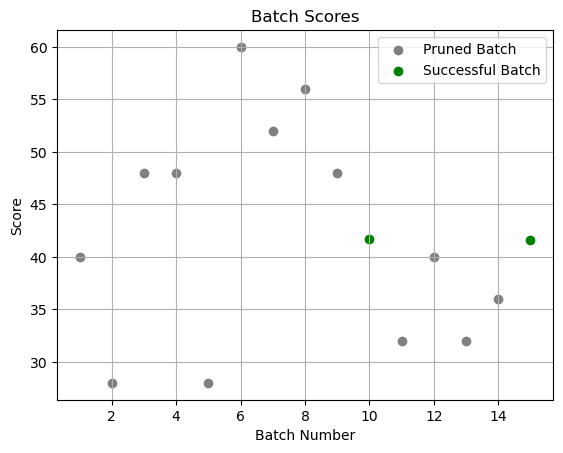

In [10]:
import matplotlib.pyplot as plt


trial_logs = optimized_program.trial_logs

trial_numbers = list(trial_logs.keys())
scores = [trial_logs[trial]["score"] for trial in trial_numbers]

full_eval = [trial_logs[trial]["full_eval"] for trial in trial_numbers]

for trial_number, score, pruned in zip(trial_numbers, scores, full_eval):
    if pruned is False:
        plt.scatter(
            trial_number,
            score,
            color="grey",
            label=(
                "Pruned Batch"
                if "Pruned Batch" not in plt.gca().get_legend_handles_labels()[1]
                else ""
            ),
        )
    else:
        plt.scatter(
            trial_number,
            score,
            color="green",
            label=(
                "Successful Batch"
                if "Successful Batch" not in plt.gca().get_legend_handles_labels()[1]
                else ""
            ),
        )

plt.xlabel("Batch Number")
plt.ylabel("Score")
plt.title("Batch Scores")
plt.grid(True)
plt.legend()
plt.show()

In [11]:
best_score = 0
best_program_so_far = None


def get_signature(predictor):
    if hasattr(predictor, "extended_signature"):
        return predictor.extended_signature
    elif hasattr(predictor, "signature"):
        return predictor.signature


# print(f"Baseline program | Score: {best_score}:")
# for i, predictor in enumerate(WrapperEnglishSPT().predictors()):
#     print(f"Prompt {i+1} Instruction: {get_signature(predictor).instructions}")
# print()

print("----------------")

for trial_num in optimized_program.trial_logs:
    program_score = optimized_program.trial_logs[trial_num]["score"]
    program_pruned = optimized_program.trial_logs[trial_num]["full_eval"]
    # if (
    #     program_score > best_score
    #     and program_pruned is True
    #     # and optimized_program.trial_logs[trial_num]["full_eval"]
    # ):
    if program_pruned is True:
        best_score = program_score
        best_program_so_far = optimized_program.trial_logs[trial_num]["program"]
    # if trial_num % 5 == 0:
    #     print(f"Best program after {trial_num} batches | Score: {best_score}:")
    #     for i, predictor in enumerate(best_program_so_far.predictors()):
    #         print(f"Prompt {i+1} Instruction: {get_signature(predictor).instructions}")
    #     print()
    
        # print(f"Best program with best score: {best_score}")
        for i, predictor in enumerate(best_program_so_far.predictors()):
            print(f"Prompt {trial_num} Instruction: {get_signature(predictor).instructions}")
            print(best_score)
        print()

----------------
Prompt 10 Instruction: Eres una herramienta de anotación de datos textuales altamente entrenada, capaz de proporcionar respuestas subjetivas. Evalúa la similitud semántica de la palabra objetivo en estas oraciones 1 y 2. Considera solo los objetos/conceptos a los que se refieren las palabras: ¡Ignora cualquier etimología común y similitud metafórica! ¡Ignora mayúsculas! ¡Ignora número (gato/Gatos = significado idéntico)! Los homónimos (como murciélago el animal vs murciélago en béisbol) se consideran no relacionados. De como salida una calificación numérica: 1 es no relacionado; 2 es lejanamente relacionado; 3 es estrechamente relacionado; 4 es significado idéntico. Tu respuesta debe alinearse con el juicio sucinto de un humano.
41.75

Prompt 15 Instruction: Eres una herramienta de anotación de datos textuales altamente entrenada, capaz de proporcionar respuestas subjetivas. Evalúa la similitud semántica de la palabra objetivo en estas oraciones 1 y 2. Considera solo l

In [12]:
program_spt_prompt_es_assertions.load(
    "compile-models/sp/es_spt_mipro_optimized_prompt_es_deepseek-70b-q4"
)

In [13]:

custom_evaluate(
    random.choices(classes_1_test, k=225)
    + random.choices(classes_2_test, k=225)
    + random.choices(classes_3_test, k=225)
    + random.choices(classes_4_test, k=225),
    evaluate_answer,
    program_spt_prompt_es_assertions,
    debug=False,
)

Evaluating: 900 examples


2025/05/10 11:16:45 INFO dspy.primitives.assertions: SuggestionFailed: La salida deberia ser 1 o 2 o 3 o 4. Por favor, revise en consecuencia.


Accurate examples: 392
Bad-formatted examples: 0
Accuracy: 43.55555555555556
